In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
print(grid_data_file)
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))

/home/lena/Promotion/neurolib/GUI/rate/bi.pickle
147


In [31]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [32]:
dur = 500.
t0_ = dur - 20.
t_pen = t0_/dur

In [33]:
bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 
convergence_ = [None] * len(exc) 

initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)
w_ = [None] * len(exc)
conv = [None] * len(exc)
conv_shift = [None] * len(exc)

In [34]:
file_ = '4.pickle'
folder = str(os.getcwd().split('data')[1])
print(folder)
case = str(folder[1])

/4


In [35]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-12
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [3,4]

    
p_var = [0]

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
    cost_index = 2
else:
    factor_ws = 0.
    factor_we = 1.
    cost_index = 1
    
maxC = [5., -5., 0.3, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [40]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]    

file found


In [9]:
# get initial parameters and target states
i_range = [1, 2, 3, 5, 9, 10, 13, 14, 19, 25, 55, 62, 69, 76]
#i_range = [1,2,3,4,5]
print(i_range)
#i_range = [50]

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

[1, 2, 3, 5, 9, 10, 13, 14, 19, 25, 55, 62, 69, 76]
-------  1 0.4250000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  10 0.4250000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  14 0.4250000000000001 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  25 0.4250000000000001 0.5000000000000002
-------  55 0.4250000000000001 0.6250000000000003
-------  62 0.4250000000000001 0.6500000000000004
-------  69 0.4250000000000001 0.6750000000000004
-------  76 0.4250000000000001 0.7000000000000004


In [10]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
            
    cost.setParams(1.0, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  1 0.4250000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  244234.70502182204
RUN  0 , total integrated cost =  244234.70502182204
Gradient descend method:  None
RUN  0 , total integrated cost =  244234.70502182204
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  137806.3558139294
RUN  0 , total integrated cost =  137806.3558139294
Gradient descend method:  None
RUN  0 , total integrated cost =  137806.3558139294
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  3 0.4250000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  241480.3484875782
RUN  0 , total integrated cost =  241480.3484875782
Gradient descend method:  None
RUN  0 , total integrated cost =  241480.3484875782
Improved ov

In [11]:
bad = []

-------  1 0.4250000000000001 0.3500000000000001
set cost params:  1.0 1000.0 0.0
interpolate adjoint :  True True True
initial cost =  244234.70502182204
RUN  0 , total integrated cost =  244234.70502182204
Gradient descend method:  None
RUN  1 , total integrated cost =  4736.336380626473
RUN  2 , total integrated cost =  3522.7497055652047
RUN  3 , total integrated cost =  3509.16851060002
RUN  4 , total integrated cost =  3493.855329834044
RUN  5 , total integrated cost =  3013.0984333581537
RUN  6 , total integrated cost =  2913.881833124555
RUN  7 , total integrated cost =  2912.8553046894335
RUN  8 , total integrated cost =  2912.791654419122
RUN  9 , total integrated cost =  2888.6297998046643


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  2866.8543726133157
RUN  10 , total integrated cost =  2866.8543726133157
Improved over  10  iterations in  8.20327487308532  seconds by  98.82618877920844  percent.
Problem in initial value trasfer post:  sigmae_f 1.5765991181876085 1.578169896951117
Problem in initial value trasfer post:  tau_exc 15.879759418377937 15.86084724206529
set cost params:  1.0 9000.0 0.0
interpolate adjoint :  True True True
initial cost =  244234.70502182204
RUN  0 , total integrated cost =  244234.70502182204
Gradient descend method:  None
RUN  1 , total integrated cost =  39705.05930032767
RUN  2 , total integrated cost =  34428.422845414636
RUN  3 , total integrated cost =  32666.289224319124
RUN  4 , total integrated cost =  31142.37017393524
RUN  5 , total integrated cost =  30293.320501825754
RUN  6 , total integrated cost =  29440.488946892314
RUN  7 , total integrated cost =  28875.680729798423
RUN  8 , total integrated cost =  28247.459126502366
RUN  9 , total in

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  27333.842406357897
RUN  10 , total integrated cost =  27333.842406357897
Improved over  10  iterations in  6.547612144029699  seconds by  88.80837086444546  percent.
Problem in initial value trasfer post:  sigmae_f 1.5392640080850373 1.542064643772112
Problem in initial value trasfer post:  tau_exc 18.6393376822353 18.608612193830453
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  244234.70502182204
RUN  0 , total integrated cost =  244234.70502182204
Gradient descend method:  None
RUN  1 , total integrated cost =  43480.640821254914
RUN  2 , total integrated cost =  37915.34307626649
RUN  3 , total integrated cost =  35986.74535162924
RUN  4 , total integrated cost =  34353.05456050506
RUN  5 , total integrated cost =  33309.71485216259
RUN  6 , total integrated cost =  32319.731936460204
RUN  7 , total integrated cost =  31531.276910337507
RUN  8 , total integrated cost =  30514.03446633719
RUN  9 , total integ

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  26585.476370718374
RUN  20 , total integrated cost =  26585.476370718374
Improved over  20  iterations in  11.839070769026875  seconds by  89.11478351598599  percent.
Problem in initial value trasfer post:  sigmae_f 1.5444332530177225 1.5492053937200343
Problem in initial value trasfer post:  tau_exc 16.23312331904146 16.171600282158835
weight =  9900.0


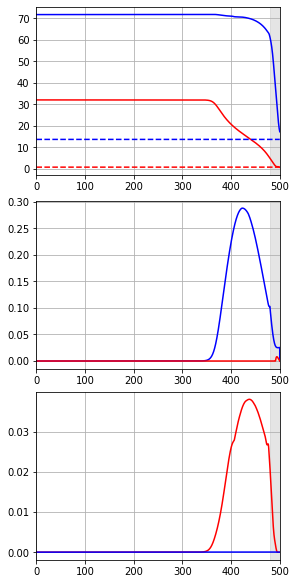

uncontrolled cost :  244234.70502182204
cost splitting :  808.7653503803012 [1.35772683e-04 2.55450458e+00 4.90678346e-02 1.46658945e-09]
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 1000.0 0.0
interpolate adjoint :  True True True
initial cost =  137806.3558139294
RUN  0 , total integrated cost =  137806.3558139294
Gradient descend method:  None
RUN  1 , total integrated cost =  1780.0058969587376
RUN  2 , total integrated cost =  977.8919663024033
RUN  3 , total integrated cost =  199.19839494122203
RUN  4 , total integrated cost =  174.86217733324833
RUN  5 , total integrated cost =  166.36165484208288
RUN  6 , total integrated cost =  151.83038145014726
RUN  7 , total integrated cost =  146.37958171278368
RUN  8 , total integrated cost =  138.30247597469702
RUN  9 , total integrated cost =  133.89755315198352


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  127.40739476073033
RUN  10 , total integrated cost =  127.40739476073033
Improved over  10  iterations in  5.9289901099400595  seconds by  99.90754606780781  percent.
Problem in initial value trasfer post:  sigmae_f 1.5230611306644928 1.5230864241967468
Problem in initial value trasfer post:  tau_exc 21.395421412602897 21.395287433155183
set cost params:  1.0 9000.0 0.0
interpolate adjoint :  True True True
initial cost =  137806.3558139294
RUN  0 , total integrated cost =  137806.3558139294
Gradient descend method:  None
RUN  1 , total integrated cost =  13126.109550381929
RUN  2 , total integrated cost =  9080.44682345658
RUN  3 , total integrated cost =  3706.730674778447
RUN  4 , total integrated cost =  3140.6521436300695
RUN  5 , total integrated cost =  2368.7152974984347
RUN  6 , total integrated cost =  2107.2044368131315
RUN  7 , total integrated cost =  1756.8198974038264
RUN  8 , total integrated cost =  1609.776524684182
RUN  9 , total in

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  1295.3487024139722
RUN  10 , total integrated cost =  1295.3487024139722
Improved over  10  iterations in  6.057043028995395  seconds by  99.0600225259835  percent.
Problem in initial value trasfer post:  sigmae_f 1.5286248485565912 1.5286452149885024
Problem in initial value trasfer post:  tau_exc 21.35342953979223 21.353320562539587
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  137806.3558139294
RUN  0 , total integrated cost =  137806.3558139294
Gradient descend method:  None
RUN  1 , total integrated cost =  14135.601765464748
RUN  2 , total integrated cost =  9740.961803864748
RUN  3 , total integrated cost =  4891.288148103355
RUN  4 , total integrated cost =  3950.511108440165
RUN  5 , total integrated cost =  2741.1067186980504
RUN  6 , total integrated cost =  2348.2567915281634
RUN  7 , total integrated cost =  1861.3819266733472
RUN  8 , total integrated cost =  1678.4087909076093
RUN  9 , total inte

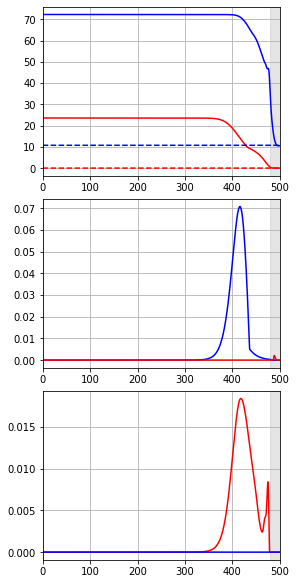

uncontrolled cost :  137806.3558139294
cost splitting :  2.6384482871621437 [5.59842329e-06 6.59206311e-02 6.22912362e-03 7.77103146e-12]
-------  3 0.4250000000000001 0.3750000000000001
set cost params:  1.0 1000.0 0.0
interpolate adjoint :  True True True
initial cost =  241480.3484875782
RUN  0 , total integrated cost =  241480.3484875782
Gradient descend method:  None
RUN  1 , total integrated cost =  4660.267204173368
RUN  2 , total integrated cost =  3379.5018597410003
RUN  3 , total integrated cost =  3343.2071022040373
RUN  4 , total integrated cost =  3341.085529431363
RUN  5 , total integrated cost =  3302.0564540425776
RUN  6 , total integrated cost =  3300.131649164275
RUN  7 , total integrated cost =  3269.1310920305414
RUN  8 , total integrated cost =  3265.5993688468952
RUN  9 , total integrated cost =  3264.2611568005786


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  3263.0970130681612
RUN  10 , total integrated cost =  3263.0970130681612
Improved over  10  iterations in  6.758241444942541  seconds by  98.64871115454929  percent.
Problem in initial value trasfer post:  sigmae_f 1.58767184575541 1.5876881138670031
Problem in initial value trasfer post:  tau_exc 18.0457005468091 18.045524512941224
set cost params:  1.0 9000.0 0.0
interpolate adjoint :  True True True
initial cost =  241480.3484875782
RUN  0 , total integrated cost =  241480.3484875782
Gradient descend method:  None
RUN  1 , total integrated cost =  39406.72958712824
RUN  2 , total integrated cost =  33880.66684346317
RUN  3 , total integrated cost =  31790.364731265694
RUN  4 , total integrated cost =  29849.140824949907
RUN  5 , total integrated cost =  28828.49069955007
RUN  6 , total integrated cost =  27801.466315670536
RUN  7 , total integrated cost =  27226.331160807254
RUN  8 , total integrated cost =  26658.98336913282
RUN  9 , total integra

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  25875.873700783628
RUN  10 , total integrated cost =  25875.873700783628
Improved over  10  iterations in  4.330530179897323  seconds by  89.28448055386392  percent.
Problem in initial value trasfer post:  sigmae_f 1.5361018281521739 1.5374954042373528
Problem in initial value trasfer post:  tau_exc 18.66111013676935 18.645798100255515
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  241480.3484875782
RUN  0 , total integrated cost =  241480.3484875782
Gradient descend method:  None
RUN  1 , total integrated cost =  43158.76511108339
RUN  2 , total integrated cost =  37163.30001280377
RUN  3 , total integrated cost =  35024.13749060102
RUN  4 , total integrated cost =  33237.38114909937
RUN  5 , total integrated cost =  32222.879806756962
RUN  6 , total integrated cost =  31250.589046977184
RUN  7 , total integrated cost =  30631.995579521932
RUN  8 , total integrated cost =  29959.705077967996
RUN  9 , total inte

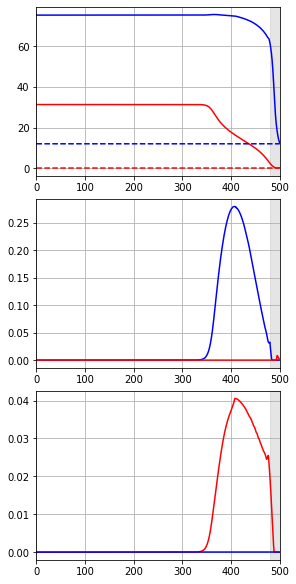

uncontrolled cost :  241480.3484875782
cost splitting :  190.05465758509231 [9.55160493e-05 2.33039135e+00 6.19356747e-02 2.07037275e-09]
-------  5 0.4000000000000001 0.40000000000000013
set cost params:  1.0 1000.0 0.0
interpolate adjoint :  True True True
initial cost =  126823.61408372025
RUN  0 , total integrated cost =  126823.61408372025
Gradient descend method:  None
RUN  1 , total integrated cost =  1604.7767019401608
RUN  2 , total integrated cost =  937.0318757946934
RUN  3 , total integrated cost =  146.46230791052795
RUN  4 , total integrated cost =  83.69519788564165
RUN  5 , total integrated cost =  65.34744983718112
RUN  6 , total integrated cost =  64.08312943766113
RUN  7 , total integrated cost =  62.09850983912454
RUN  8 , total integrated cost =  60.76212179077111
RUN  9 , total integrated cost =  59.964160920013434


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  58.89568807795984
RUN  10 , total integrated cost =  58.89568807795984
Improved over  10  iterations in  6.005370221100748  seconds by  99.95356094485757  percent.
Problem in initial value trasfer post:  sigmae_f 1.553271028179921 1.5532755182320752
Problem in initial value trasfer post:  tau_exc 20.85812433253605 20.858095493436615
set cost params:  1.0 9000.0 0.0
interpolate adjoint :  True True True
initial cost =  126823.61408372025
RUN  0 , total integrated cost =  126823.61408372025
Gradient descend method:  None
RUN  1 , total integrated cost =  9844.113623074438
RUN  2 , total integrated cost =  5947.446655078582
RUN  3 , total integrated cost =  643.2751608681896
RUN  4 , total integrated cost =  602.9998831200237
RUN  5 , total integrated cost =  589.2591099524556
RUN  6 , total integrated cost =  580.6956628735862
RUN  7 , total integrated cost =  569.2084351586891
RUN  8 , total integrated cost =  561.9793219829606
RUN  9 , total integrate

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  545.9129629649914
RUN  10 , total integrated cost =  545.9129629649914
Improved over  10  iterations in  7.545756537932903  seconds by  99.5695494353247  percent.
Problem in initial value trasfer post:  sigmae_f 1.5653141860048678 1.5653144674760369
Problem in initial value trasfer post:  tau_exc 20.364525899888672 20.364523824123935
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  126823.61408372025
RUN  0 , total integrated cost =  126823.61408372025
Gradient descend method:  None
RUN  1 , total integrated cost =  10401.492741713
RUN  2 , total integrated cost =  6467.978371805178
RUN  3 , total integrated cost =  705.347603547399
RUN  4 , total integrated cost =  638.6302939861182
RUN  5 , total integrated cost =  524.4922942447921
RUN  6 , total integrated cost =  512.7539132794944
RUN  7 , total integrated cost =  496.58671371324044
RUN  8 , total integrated cost =  490.8647131097685
RUN  9 , total integrated

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  446.9640327387887
RUN  20 , total integrated cost =  446.9640327387887
Improved over  20  iterations in  14.501309687970206  seconds by  99.64757033935042  percent.
Problem in initial value trasfer post:  sigmae_f 1.5669705800349032 1.5669721257501394
Problem in initial value trasfer post:  tau_exc 20.38996310208359 20.38995187115648
weight =  9900.0


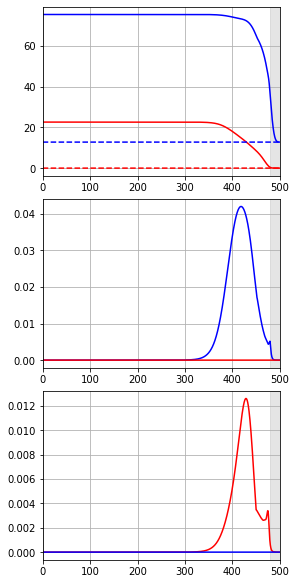

uncontrolled cost :  126823.61408372025
cost splitting :  2.1141055206181245 [1.02848164e-19 4.23678737e-02 2.56646234e-03 0.00000000e+00]
-------  9 0.4000000000000001 0.42500000000000016
set cost params:  1.0 1000.0 0.0
interpolate adjoint :  True True True
initial cost =  115502.5972235114
RUN  0 , total integrated cost =  115502.5972235114
Gradient descend method:  None
RUN  1 , total integrated cost =  1229.740160121773
RUN  2 , total integrated cost =  969.8942194626783
RUN  3 , total integrated cost =  525.7636659482371
RUN  4 , total integrated cost =  410.89966689130483
RUN  5 , total integrated cost =  239.66030648316223
RUN  6 , total integrated cost =  198.70611326678087
RUN  7 , total integrated cost =  34.26078177505092
RUN  8 , total integrated cost =  33.87357795468648
RUN  9 , total integrated cost =  32.579873262739966


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  30.83274167179287
RUN  10 , total integrated cost =  30.83274167179287
Improved over  10  iterations in  7.163019216037355  seconds by  99.97330558583707  percent.
Problem in initial value trasfer post:  sigmae_f 1.548880780086861 1.5488811298088336
Problem in initial value trasfer post:  tau_exc 20.869605946922313 20.86960368113745
set cost params:  1.0 9000.0 0.0
interpolate adjoint :  True True True
initial cost =  115502.5972235114
RUN  0 , total integrated cost =  115502.5972235114
Gradient descend method:  None
RUN  1 , total integrated cost =  6237.368469303637
RUN  2 , total integrated cost =  4419.046074498678
RUN  3 , total integrated cost =  2400.5361853182358
RUN  4 , total integrated cost =  1901.310429723612
RUN  5 , total integrated cost =  347.827958866366
RUN  6 , total integrated cost =  324.26359016564794
RUN  7 , total integrated cost =  315.2284973367594
RUN  8 , total integrated cost =  290.1320676641786
RUN  9 , total integrated

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  285.79741503640537
RUN  10 , total integrated cost =  285.79741503640537
Improved over  10  iterations in  7.765429568011314  seconds by  99.75256191470451  percent.
Problem in initial value trasfer post:  sigmae_f 1.5478535360925612 1.547853585287857
Problem in initial value trasfer post:  tau_exc 20.77006849901489 20.770068169892873
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  115502.5972235114
RUN  0 , total integrated cost =  115502.5972235114
Gradient descend method:  None
RUN  1 , total integrated cost =  6669.06612908537
RUN  2 , total integrated cost =  4811.238279496611
RUN  3 , total integrated cost =  2637.5617903826815
RUN  4 , total integrated cost =  2070.9893247991763
RUN  5 , total integrated cost =  1399.8054926082286
RUN  6 , total integrated cost =  1151.7550392453268
RUN  7 , total integrated cost =  364.5576946890586
RUN  8 , total integrated cost =  332.96134453070596
RUN  9 , total integ

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  247.93882651789372
RUN  20 , total integrated cost =  247.93882651789372
Improved over  20  iterations in  14.664689998026006  seconds by  99.78533917636666  percent.
Problem in initial value trasfer post:  sigmae_f 1.5484274026759826 1.5484275244378713
Problem in initial value trasfer post:  tau_exc 20.81359859302903 20.813597786771975
weight =  9900.0


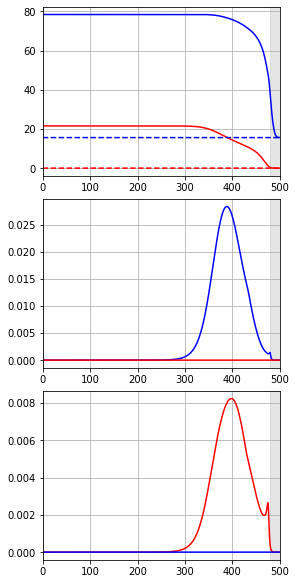

uncontrolled cost :  115502.5972235114
cost splitting :  1.6247824824548254 [1.73292056e-20 2.26559202e-02 2.22428625e-03 0.00000000e+00]
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 1000.0 0.0
interpolate adjoint :  True True True
initial cost =  226698.47715197233
RUN  0 , total integrated cost =  226698.47715197233
Gradient descend method:  None
RUN  1 , total integrated cost =  4534.849913296116
RUN  2 , total integrated cost =  4057.4130359203205
RUN  3 , total integrated cost =  3859.25563689288
RUN  4 , total integrated cost =  3626.1218680013612
RUN  5 , total integrated cost =  3492.302838313137
RUN  6 , total integrated cost =  3289.3964719631103
RUN  7 , total integrated cost =  3178.4447809632734
RUN  8 , total integrated cost =  3059.608060949834
RUN  9 , total integrated cost =  2992.581969553052


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  2923.219984939549
RUN  10 , total integrated cost =  2923.219984939549
Improved over  10  iterations in  4.511199404951185  seconds by  98.71052508968558  percent.
Problem in initial value trasfer post:  sigmae_f 1.5007977953240195 1.501785738324759
Problem in initial value trasfer post:  tau_exc 21.397403288655045 21.39168873844725
set cost params:  1.0 9000.0 0.0
interpolate adjoint :  True True True
initial cost =  226698.47715197233
RUN  0 , total integrated cost =  226698.47715197233
Gradient descend method:  None
RUN  1 , total integrated cost =  38254.4441602615
RUN  2 , total integrated cost =  28278.876266591902
RUN  3 , total integrated cost =  27860.318301994826
RUN  4 , total integrated cost =  20572.867660956574
RUN  5 , total integrated cost =  20063.825117629636
RUN  6 , total integrated cost =  20033.88023969205
RUN  7 , total integrated cost =  19962.21193070439
RUN  8 , total integrated cost =  19935.400622814264
RUN  9 , total integ

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  19851.930203295044
RUN  10 , total integrated cost =  19851.930203295044
Improved over  10  iterations in  7.417182698962279  seconds by  91.24302445578985  percent.
Problem in initial value trasfer post:  sigmae_f 1.5478637838121805 1.547864551482073
Problem in initial value trasfer post:  tau_exc 20.467481090874244 20.467475365761295
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  226698.47715197233
RUN  0 , total integrated cost =  226698.47715197233
Gradient descend method:  None
RUN  1 , total integrated cost =  41891.959721912805
RUN  2 , total integrated cost =  31031.388972062585
RUN  3 , total integrated cost =  30856.341815672236
RUN  4 , total integrated cost =  30765.01454543797
RUN  5 , total integrated cost =  27623.896571492092
RUN  6 , total integrated cost =  22653.983000155895
RUN  7 , total integrated cost =  22306.114088099785
RUN  8 , total integrated cost =  22282.079730100875
RUN  9 , total

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  20225.17912799495
RUN  20 , total integrated cost =  20225.17912799495
Improved over  20  iterations in  13.153404651908204  seconds by  91.0783789189565  percent.
Problem in initial value trasfer post:  sigmae_f 1.5443036187006194 1.5443049064639902
Problem in initial value trasfer post:  tau_exc 20.383686446989763 20.383676439613886
weight =  9900.0


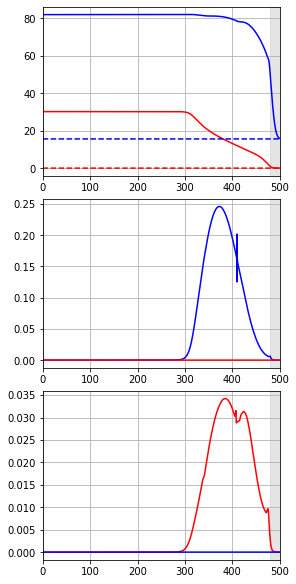

uncontrolled cost :  226698.47715197233
cost splitting :  19.11523433314521 [2.28653095e-16 1.99069207e+00 5.03244836e-02 2.76523731e-20]
-------  13 0.4000000000000001 0.4500000000000002
-------  14 0.4250000000000001 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  25 0.4250000000000001 0.5000000000000002
-------  55 0.4250000000000001 0.6250000000000003
-------  62 0.4250000000000001 0.6500000000000004
-------  69 0.4250000000000001 0.6750000000000004
-------  76 0.4250000000000001 0.7000000000000004


In [15]:
cgv = None
j = 0

wp = 1.

for i in i_range:

    print("------- ", i, exc[i], inh[i])
    
    if type(bestControl_[i]) != type(None) or i in bad:
        continue
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
        
    found_exponent = False
    found_digit_0 = False
    found_digit_1 = False
    exponent = 3
    sig_digit = [1., 0.]
    
    while not found_digit_1:
        
        if exponent < -10:
            bad.append(i)
            break
        
        w_[i] = sig_digit[0] * 10**exponent + sig_digit[1] * 10**(exponent-1.)
    
        aln.params.duration = dur
        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        cost.setParams(wp, factor_we * w_[i], factor_ws * w_[i])
        max_it = int(10)
        if found_digit_0:
            max_it = int(20)

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if found_exponent == False and cost_[i][-1] == 0.:
            exponent -= 1
            continue
        elif found_exponent == False and found_digit_0 == False:
            found_exponent = True
            sig_digit[0] = 9.
        elif found_exponent == True and found_digit_0 == False and cost_[i][-1] == 0.:
            sig_digit[0] -= 1.
        elif found_exponent == True and found_digit_0 == False:
            found_digit_0 = True
            sig_digit[1] = 9.
        elif found_exponent == True and found_digit_0 == True and found_digit_1 == False and cost_[i][-1] == 0.:
            sig_digit[1] -= 1.
        elif found_exponent == True and found_digit_0 == True and found_digit_1 == False:
            print("weight = ", w_[i])
            
            if True:
                plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
                target_ = aln.getZeroTarget()
                target_[:,0,:] = target[i][0]
                target_[:,1,:] = target[i][1]

                fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )
                
                ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
                ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
                ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
                ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')
                
                ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
                ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

                ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
                ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')
                
                for k in range(3):
                    ax[k].set_xlim(0.,dur)
                    ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
                plt.show()
                
            with open(file_,'wb') as f:
                pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

            print('uncontrolled cost : ', cost_uncontrolled[i])
            print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][cost_index][0][2:])    

            break   
            

In [13]:
print(bad)

[]


In [46]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


-------  1 0.4250000000000001 0.3500000000000001
--------------- k  0
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  26585.476370718374
RUN  0 , total integrated cost =  26585.476370718374
Gradient descend method:  None
RUN  1 , total integrated cost =  26552.603601334802
RUN  2 , total integrated cost =  26515.1635302037
RUN  3 , total integrated cost =  26484.88709466314
RUN  4 , total integrated cost =  26448.690021438866
RUN  5 , total integrated cost =  26418.91499745473
RUN  6 , total integrated cost =  26381.286909950733
RUN  7 , total integrated cost =  26351.460389914773
RUN  8 , total integrated cost =  24906.39910714839
RUN  9 , total integrated cost =  24876.565482838374
RUN  10 , total integrated cost =  24643.097266566114
RUN  11 , total integrated cost =  24570.473473543254
RUN  12 , total integrated cost =  24543.4980611869
RUN  13 , total integrated cost =  24528.39750723268
RUN  14 , total integrated cost =  24513.420846411027
R

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  23971.945558474414
RUN  100 , total integrated cost =  23971.945558474414
Improved over  100  iterations in  45.41684812994208  seconds by  9.830671362814243  percent.
Problem in initial value trasfer post:  sigmae_f 1.5858254482208751 1.5859130817944218
Problem in initial value trasfer post:  tau_exc 15.600181706024454 15.599126597798952
cost splitting :  105.33271128367083 [5.86425088e-05 2.34653145e+00 6.41788717e-02 8.50295183e-09]
--------------- k  1
set cost params:  1.0 10813.661830712526 0.0
interpolate adjoint :  True True True
initial cost =  26174.573153107893
RUN  0 , total integrated cost =  26174.573153107893
Gradient descend method:  None
RUN  1 , total integrated cost =  26174.100114730714
RUN  2 , total integrated cost =  26172.299785806703
RUN  3 , total integrated cost =  26170.885732848343
RUN  4 , total integrated cost =  26168.47554051699
RUN  5 , total integrated cost =  26166.872133610745
RUN  6 , total integrated cost =  261

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  25777.435617204006
RUN  100 , total integrated cost =  25777.435617204006
Improved over  100  iterations in  49.70384612295311  seconds by  1.5172646124192113  percent.
Problem in initial value trasfer post:  sigmae_f 1.5879575491259215 1.5888890303359624
Problem in initial value trasfer post:  tau_exc 15.673677760982303 15.662462727213406
cost splitting :  27.293253096031258 [2.82665844e-05 2.31302443e+00 6.82074887e-02 4.17391578e-10]
--------------- k  2
set cost params:  1.0 11753.077100918428 0.0
interpolate adjoint :  True True True
initial cost =  28014.42779668164
RUN  0 , total integrated cost =  28014.42779668164
Gradient descend method:  None
RUN  1 , total integrated cost =  28014.28523819941
RUN  2 , total integrated cost =  28014.134531464773
RUN  3 , total integrated cost =  28014.002614804227
RUN  4 , total integrated cost =  27996.105245861923
RUN  5 , total integrated cost =  27987.60566995965
RUN  6 , total integrated cost =  27987

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  200 , total integrated cost =  27894.50127043747
RUN  200 , total integrated cost =  27894.50127043747
Improved over  200  iterations in  102.95802553300746  seconds by  0.4280884375527876  percent.
Problem in initial value trasfer post:  sigmae_f 1.5921383518623275 1.5927207315979481
Problem in initial value trasfer post:  tau_exc 15.74925768590106 15.742245833884189
cost splitting :  14.759359070678775 [3.13544855e-05 2.30681391e+00 6.52775062e-02 9.36756660e-09]
--------------- k  3
set cost params:  1.0 12691.62527502757 0.0
interpolate adjoint :  True True True
initial cost =  30120.852773185892
RUN  0 , total integrated cost =  30120.852773185892
Gradient descend method:  None
RUN  1 , total integrated cost =  30120.81607953226
RUN  2 , total integrated cost =  30120.80742913255
RUN  3 , total integrated cost =  30120.79614658894
RUN  4 , total integrated cost =  30120.788106959597
RUN  5 , total integrated cost =  30120.4825389447
RUN  6 , total integrated cost =  30120.195

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  61 , total integrated cost =  30115.241962569184
Improved over  61  iterations in  31.526011201902293  seconds by  0.01862766190239995  percent.
Problem in initial value trasfer post:  sigmae_f 1.5932840464968745 1.5935706947723276
Problem in initial value trasfer post:  tau_exc 15.741209249900363 15.737758004663908
cost splitting :  15.965947970576194 [2.68712298e-05 2.30637368e+00 6.51970579e-02 1.64708776e-08]
--------------- k  4
set cost params:  1.0 13623.058580344385 0.0
interpolate adjoint :  True True True
initial cost =  32324.226981052117
RUN  0 , total integrated cost =  32324.226981052117
Gradient descend method:  None
RUN  1 , total integrated cost =  32324.190628370317
RUN  2 , total integrated cost =  32324.184705510368
RUN  3 , total integrated cost =  32324.179823803304
RUN  4 , total integrated cost =  32324.17684798896
RUN  5 , total integrated cost =  32324.174343137085
RUN  6 , total integrated cost =  32324.169752478636
RUN  

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  32324.152496349558
Control only changes marginally.
RUN  10 , total integrated cost =  32324.152496349558
Improved over  10  iterations in  7.2396991399582475  seconds by  0.00023042995771049846  percent.
Problem in initial value trasfer post:  sigmae_f 1.5932841766011545 1.5935467961497973
Problem in initial value trasfer post:  tau_exc 15.738497425024859 15.7353354856592
cost splitting :  17.507389613622614 [2.52798544e-05 2.30623830e+00 6.52133917e-02 1.65015328e-08]
--------------- k  5
set cost params:  1.0 14554.0526653899 0.0
interpolate adjoint :  True True True
initial cost =  34531.98354059403
RUN  0 , total integrated cost =  34531.98354059403
Gradient descend method:  None
RUN  1 , total integrated cost =  34531.95540327097
RUN  2 , total integrated cost =  34531.951850300036
RUN  3 , total integrated cost =  34531.94664566196
RUN  4 , total integrated cost =  34531.94454942609
RUN  5 , total integrated cost =  34531.9431160042


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  34531.942046488875
Control only changes marginally.
RUN  6 , total integrated cost =  34531.942046488875
Improved over  6  iterations in  4.4548613239312544  seconds by  0.00012016137188197717  percent.
Problem in initial value trasfer post:  sigmae_f 1.592871350318362 1.5931281647080042
Problem in initial value trasfer post:  tau_exc 15.750725334126244 15.747633288874953
cost splitting :  18.530195978206734 [2.47795982e-05 2.30616892e+00 6.52131217e-02 1.65138139e-08]
--------------- k  6
set cost params:  1.0 15485.020081257408 0.0
interpolate adjoint :  True True True
initial cost =  36739.64454495124
RUN  0 , total integrated cost =  36739.64454495124
Gradient descend method:  None
RUN  1 , total integrated cost =  36739.61100488543
RUN  2 , total integrated cost =  36739.60087601504
RUN  3 , total integrated cost =  36739.59511207677
RUN  4 , total integrated cost =  36739.58521612821
RUN  5 , total integrated cost =  36739.57745284201
RUN  6 , to

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  36739.20241675437
Control only changes marginally.
RUN  20 , total integrated cost =  36739.20241675437
Improved over  20  iterations in  11.6144219560083  seconds by  0.0012034090213575155  percent.
Problem in initial value trasfer post:  sigmae_f 1.5929451616251538 1.5931815215737208
Problem in initial value trasfer post:  tau_exc 15.740990281798735 15.738144508017987
cost splitting :  20.062212125720944 [2.38186607e-05 2.30602650e+00 6.52319345e-02 1.70501842e-08]
--------------- k  7
set cost params:  1.0 16416.190234634814 0.0
interpolate adjoint :  True True True
initial cost =  38947.26969339131
RUN  0 , total integrated cost =  38947.26969339131
Gradient descend method:  None
RUN  1 , total integrated cost =  38947.236715399136
RUN  2 , total integrated cost =  38947.22833402507
RUN  3 , total integrated cost =  38947.22108947668
RUN  4 , total integrated cost =  38947.21485194301
RUN  5 , total integrated cost =  38947.21070774673
RUN  6 , to

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  16 , total integrated cost =  38947.1792187563
Control only changes marginally.
RUN  16 , total integrated cost =  38947.1792187563
Improved over  16  iterations in  10.420418227091432  seconds by  0.0002323003274113944  percent.
Problem in initial value trasfer post:  sigmae_f 1.5930222452099019 1.5932424312083866
Problem in initial value trasfer post:  tau_exc 15.729534221854834 15.726883182433076
cost splitting :  21.656946996511433 [2.32109725e-05 2.30596024e+00 6.51983434e-02 1.71474079e-08]
--------------- k  8
set cost params:  1.0 17347.36980773745 0.0
interpolate adjoint :  True True True
initial cost =  41155.17528795917
RUN  0 , total integrated cost =  41155.17528795917
Gradient descend method:  None
RUN  1 , total integrated cost =  41155.143491532246
RUN  2 , total integrated cost =  41155.13433355152
RUN  3 , total integrated cost =  41155.126151686476
RUN  4 , total integrated cost =  41155.12197903629
RUN  5 , total integrated cost =  41155.116021669055
RUN  6 , t

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  41155.09603872658
Control only changes marginally.
RUN  10 , total integrated cost =  41155.09603872658
Improved over  10  iterations in  6.914129587006755  seconds by  0.00019256200960171554  percent.
Problem in initial value trasfer post:  sigmae_f 1.5928885729876465 1.5931000698164506
Problem in initial value trasfer post:  tau_exc 15.729878883589215 15.727332461770413
cost splitting :  22.998255248505142 [2.26285190e-05 2.30587769e+00 6.51961444e-02 1.71473145e-08]
--------------- k  9
set cost params:  1.0 18278.57373103581 0.0
interpolate adjoint :  True True True
initial cost =  43363.0703798283
RUN  0 , total integrated cost =  43363.0703798283
Gradient descend method:  None
RUN  1 , total integrated cost =  43363.04301899022
RUN  2 , total integrated cost =  43363.03488171765
RUN  3 , total integrated cost =  43363.025782370816
RUN  4 , total integrated cost =  43363.02237377037
RUN  5 , total integrated cost =  43363.02009980382
RUN  6 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  43363.01587151918
Control only changes marginally.
RUN  8 , total integrated cost =  43363.01587151918
Improved over  8  iterations in  6.06749820697587  seconds by  0.00012570214387608303  percent.
Problem in initial value trasfer post:  sigmae_f 1.5926578952389827 1.5928642023478234
Problem in initial value trasfer post:  tau_exc 15.74323800482993 15.740754067239486
cost splitting :  24.316673921091642 [2.20026387e-05 2.30583391e+00 6.51649685e-02 1.71462202e-08]
--------------- k  10
set cost params:  1.0 19209.799065395393 0.0
interpolate adjoint :  True True True
initial cost =  45570.97060053326
RUN  0 , total integrated cost =  45570.97060053326
Gradient descend method:  None
RUN  1 , total integrated cost =  45570.94269974985
RUN  2 , total integrated cost =  45570.93593525495
RUN  3 , total integrated cost =  45570.92159949223
RUN  4 , total integrated cost =  45570.91346466902
RUN  5 , total integrated cost =  45570.90968949087
RUN  6 , total

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  13 , total integrated cost =  45570.88939800601
Control only changes marginally.
RUN  13 , total integrated cost =  45570.88939800601
Improved over  13  iterations in  9.165634760051034  seconds by  0.00017818915459599793  percent.
Problem in initial value trasfer post:  sigmae_f 1.5927336085212762 1.5929323233744725
Problem in initial value trasfer post:  tau_exc 15.73984710558794 15.737454578755457
cost splitting :  25.843782913938192 [2.18126005e-05 2.30578169e+00 6.51308839e-02 1.71570006e-08]
--------------- k  11
set cost params:  1.0 20141.12146353948 0.0
interpolate adjoint :  True True True
initial cost =  47778.993709437
RUN  0 , total integrated cost =  47778.993709437
Gradient descend method:  None
RUN  1 , total integrated cost =  47778.96724306534
RUN  2 , total integrated cost =  47778.96207153684
RUN  3 , total integrated cost =  47778.8684296803
RUN  4 , total integrated cost =  47778.79730462426
RUN  5 , total integrated cost =  47778.78772546943
RUN  6 , total i

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  47778.32037240512
Control only changes marginally.
RUN  20 , total integrated cost =  47778.32037240512
Improved over  20  iterations in  11.154264899087138  seconds by  0.0014092742010802795  percent.
Problem in initial value trasfer post:  sigmae_f 1.5926047045926621 1.5927866575546958
Problem in initial value trasfer post:  tau_exc 15.742469089702066 15.74027837603918
cost splitting :  27.178268700564693 [2.16219375e-05 2.30556316e+00 6.52556956e-02 1.79045539e-08]
--------------- k  12
set cost params:  1.0 21072.554498454447 0.0
interpolate adjoint :  True True True
initial cost =  49986.59953484409
RUN  0 , total integrated cost =  49986.59953484409
Gradient descend method:  None
RUN  1 , total integrated cost =  49986.568790136706
RUN  2 , total integrated cost =  49986.562069147876
RUN  3 , total integrated cost =  49986.39336787216
RUN  4 , total integrated cost =  49986.26060632754
RUN  5 , total integrated cost =  49986.258216760376
RUN  6 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  26 , total integrated cost =  49984.96091161209
Improved over  26  iterations in  15.437628006911837  seconds by  0.0032781250319970923  percent.
Problem in initial value trasfer post:  sigmae_f 1.5925705612145427 1.5927186358561527
Problem in initial value trasfer post:  tau_exc 15.743439489693813 15.74165667100883
cost splitting :  28.767891745239382 [2.12190179e-05 2.30538955e+00 6.52794627e-02 1.85994732e-08]
--------------- k  13
set cost params:  1.0 22004.362200959247 0.0
interpolate adjoint :  True True True
initial cost =  52193.98834840692
RUN  0 , total integrated cost =  52193.98834840692
Gradient descend method:  None
RUN  1 , total integrated cost =  52193.961693608115
RUN  2 , total integrated cost =  52193.95739887449
RUN  3 , total integrated cost =  52193.69907803951
RUN  4 , total integrated cost =  52193.420041069745
RUN  5 , total integrated cost =  52193.41632635338
RUN  6 , total integrated cost =  52193.41330697584
RUN  7 , 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  16 , total integrated cost =  52193.31054162404
Control only changes marginally.
RUN  16 , total integrated cost =  52193.31054162404
Improved over  16  iterations in  9.96653519605752  seconds by  0.001298629984646027  percent.
Problem in initial value trasfer post:  sigmae_f 1.5924304969147642 1.5925631961880364
Problem in initial value trasfer post:  tau_exc 15.7404970379092 15.738899338659003
cost splitting :  30.008277238355628 [2.11151729e-05 2.30536099e+00 6.52202850e-02 1.86323455e-08]
--------------- k  14
set cost params:  1.0 22935.92813730418 0.0
interpolate adjoint :  True True True
initial cost =  54401.68299185087
RUN  0 , total integrated cost =  54401.68299185087
Gradient descend method:  None
RUN  1 , total integrated cost =  54401.65347608599
RUN  2 , total integrated cost =  54401.64714117908
RUN  3 , total integrated cost =  54401.57586107294
RUN  4 , total integrated cost =  54401.51824860327
RUN  5 , total integrated cost =  54401.51274187963
RUN  6 , total 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  19 , total integrated cost =  54401.424106409686
Control only changes marginally.
RUN  19 , total integrated cost =  54401.424106409686
Improved over  19  iterations in  11.147253960021771  seconds by  0.00047587763272360917  percent.
Problem in initial value trasfer post:  sigmae_f 1.5921998988957093 1.5923229973451005
Problem in initial value trasfer post:  tau_exc 15.745198171848386 15.743716066517717
cost splitting :  31.696702233881688 [2.06330475e-05 2.30518667e+00 6.53098717e-02 1.88490700e-08]
--------------- k  15
set cost params:  1.0 23867.51445628339 0.0
interpolate adjoint :  True True True
initial cost =  56609.765495583175
RUN  0 , total integrated cost =  56609.765495583175
Gradient descend method:  None
RUN  1 , total integrated cost =  56609.7432872438
RUN  2 , total integrated cost =  56609.740100889416
RUN  3 , total integrated cost =  56597.688854476015
RUN  4 , total integrated cost =  56594.88364377145
RUN  5 , total integrated cost =  56594.838666360316
RUN

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  28 , total integrated cost =  56592.971897666706
Improved over  28  iterations in  15.411817932035774  seconds by  0.029665549343732778  percent.
Problem in initial value trasfer post:  sigmae_f 1.5922844371819083 1.5923114510832048
Problem in initial value trasfer post:  tau_exc 15.747006076033745 15.746680828662136
cost splitting :  31.318633531163325 [2.22527066e-05 2.30471872e+00 6.50891643e-02 1.95942154e-08]
--------------- k  16
set cost params:  1.0 24803.486153695314 0.0
interpolate adjoint :  True True True
initial cost =  58811.065847862956
RUN  0 , total integrated cost =  58811.065847862956
Gradient descend method:  None
RUN  1 , total integrated cost =  58811.03687402611
RUN  2 , total integrated cost =  58811.03240828836
RUN  3 , total integrated cost =  58810.93361762952
RUN  4 , total integrated cost =  58810.80987322717
RUN  5 , total integrated cost =  58810.80883122884
RUN  6 , total integrated cost =  58810.80193384296
RUN  7 ,

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  58810.78985720748
Control only changes marginally.
RUN  8 , total integrated cost =  58810.78985720748
Improved over  8  iterations in  5.418993497965857  seconds by  0.00046928354639419467  percent.
Problem in initial value trasfer post:  sigmae_f 1.591897747652771 1.5919210582025287
Problem in initial value trasfer post:  tau_exc 15.76793236374304 15.767651704723956
cost splitting :  32.483252415080024 [2.16424480e-05 2.30466206e+00 6.50860451e-02 1.96191815e-08]
--------------- k  17
set cost params:  1.0 25735.316855674042 0.0
interpolate adjoint :  True True True
initial cost =  61019.01408524538
RUN  0 , total integrated cost =  61019.01408524538
Gradient descend method:  None
RUN  1 , total integrated cost =  61018.98662578451
RUN  2 , total integrated cost =  61018.98220105011
RUN  3 , total integrated cost =  61018.929293167384
RUN  4 , total integrated cost =  61018.917609965196
RUN  5 , total integrated cost =  61018.91457079494


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  61018.91230623907
Control only changes marginally.
RUN  6 , total integrated cost =  61018.91230623907
Improved over  6  iterations in  4.607186421053484  seconds by  0.00016679883775339022  percent.
Problem in initial value trasfer post:  sigmae_f 1.5923029131699087 1.5923242042512036
Problem in initial value trasfer post:  tau_exc 15.75405361530904 15.753797270690248
cost splitting :  34.13179967783249 [2.15566156e-05 2.30459742e+00 6.50859948e-02 1.96343541e-08]
--------------- k  18
set cost params:  1.0 26667.187904269056 0.0
interpolate adjoint :  True True True
initial cost =  63227.171782280835
RUN  0 , total integrated cost =  63227.171782280835
Gradient descend method:  None
RUN  1 , total integrated cost =  63227.14804305666
RUN  2 , total integrated cost =  63227.14336470563
RUN  3 , total integrated cost =  63227.01513210104
RUN  4 , total integrated cost =  63226.86735385688
RUN  5 , total integrated cost =  63226.86285434499
RUN  6 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  45 , total integrated cost =  63194.40658384868
Improved over  45  iterations in  24.303121339995414  seconds by  0.05182138866653929  percent.
Problem in initial value trasfer post:  sigmae_f 1.5925749203381523 1.5926161827328835
Problem in initial value trasfer post:  tau_exc 15.764537090752048 15.764040291519485
cost splitting :  27.645891797779953 [2.11199763e-05 2.30346104e+00 6.52332891e-02 1.87552038e-08]
--------------- k  19
set cost params:  1.0 27607.397986561577 0.0
interpolate adjoint :  True True True
initial cost =  65421.4967456133
RUN  0 , total integrated cost =  65421.4967456133
Gradient descend method:  None
RUN  1 , total integrated cost =  65421.47718254639
RUN  2 , total integrated cost =  65421.47346108907
RUN  3 , total integrated cost =  65421.44761128281
RUN  4 , total integrated cost =  65421.41833127434
RUN  5 , total integrated cost =  65421.41570091778
RUN  6 , total integrated cost =  65421.406663084425
RUN  7 , tota

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  46 , total integrated cost =  65419.7359472888
Improved over  46  iterations in  25.5174073750386  seconds by  0.0026914675024158896  percent.
Problem in initial value trasfer post:  sigmae_f 1.592818019579703 1.592853134038074
Problem in initial value trasfer post:  tau_exc 15.733877737600661 15.733454959521874
cost splitting :  28.788721698863515 [2.10820723e-05 2.30328040e+00 6.53120031e-02 1.93216167e-08]
--------------- k  20
set cost params:  1.0 28540.157375956966 0.0
interpolate adjoint :  True True True
initial cost =  67629.08243501688
RUN  0 , total integrated cost =  67629.08243501688
Gradient descend method:  None
RUN  1 , total integrated cost =  67629.06270922977
RUN  2 , total integrated cost =  67629.05780120459
RUN  3 , total integrated cost =  67625.41443723744
RUN  4 , total integrated cost =  67623.08873151257
RUN  5 , total integrated cost =  67623.07811078444
RUN  6 , total integrated cost =  67623.06709552131
RUN  7 , total 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  11 , total integrated cost =  67623.04781474905
Control only changes marginally.
RUN  11 , total integrated cost =  67623.04781474905
Improved over  11  iterations in  7.312879906967282  seconds by  0.008923114214411498  percent.
Problem in initial value trasfer post:  sigmae_f 1.5929179756380092 1.592929633076757
Problem in initial value trasfer post:  tau_exc 15.719791116924124 15.7196507613616
cost splitting :  30.408130348453945 [2.10745190e-05 2.30295263e+00 6.53693861e-02 2.63915819e-08]
--------------- k  21
set cost params:  1.0 29474.493511029694 0.0
interpolate adjoint :  True True True
initial cost =  69835.87637056588
RUN  0 , total integrated cost =  69835.87637056588
Gradient descend method:  None
RUN  1 , total integrated cost =  69835.86322457762
RUN  2 , total integrated cost =  69835.86008555553
RUN  3 , total integrated cost =  69835.85788330442
RUN  4 , total integrated cost =  69835.8518314417


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  69835.85092008211
Control only changes marginally.
RUN  5 , total integrated cost =  69835.85092008211
Improved over  5  iterations in  4.5133384770015255  seconds by  3.6443279711306786e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5925851339325563 1.5925976996604039
Problem in initial value trasfer post:  tau_exc 15.739154922479429 15.739003631116146
cost splitting :  31.15613565642507 [2.07198363e-05 2.30295943e+00 6.53353807e-02 2.63903662e-08]
--------------- k  22
set cost params:  1.0 30406.806750747466 0.0
interpolate adjoint :  True True True
initial cost =  72043.86287050959
RUN  0 , total integrated cost =  72043.86287050959
Gradient descend method:  None
RUN  1 , total integrated cost =  72043.84501099066
RUN  2 , total integrated cost =  72043.84114168934
RUN  3 , total integrated cost =  72043.8381168192
RUN  4 , total integrated cost =  72043.8310361269
RUN  5 , total integrated cost =  72043.83003110257
RUN  6 , total

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  12 , total integrated cost =  72043.82871218934
Control only changes marginally.
RUN  12 , total integrated cost =  72043.82871218934
Improved over  12  iterations in  8.85397481394466  seconds by  4.741322700851924e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5923647740688642 1.5923739165534119
Problem in initial value trasfer post:  tau_exc 15.746790068261777 15.746679992747826
cost splitting :  32.09926130034527 [2.04508113e-05 2.30291085e+00 6.53471924e-02 2.63940636e-08]
--------------- k  23
set cost params:  1.0 31339.213590841737 0.0
interpolate adjoint :  True True True
initial cost =  74252.02780749564
RUN  0 , total integrated cost =  74252.02780749564
Gradient descend method:  None
RUN  1 , total integrated cost =  74252.01290070407
RUN  2 , total integrated cost =  74252.00926977684
RUN  3 , total integrated cost =  74252.00729816373
RUN  4 , total integrated cost =  74252.00114223163
RUN  5 , total integrated cost =  74251.99923110066
RUN  6 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  74251.99809079399
Control only changes marginally.
RUN  7 , total integrated cost =  74251.99809079399
Improved over  7  iterations in  5.496424926910549  seconds by  4.002140080672234e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5921583687849585 1.5921642023188445
Problem in initial value trasfer post:  tau_exc 15.7529703554132 15.752900119665215
cost splitting :  33.224827402184395 [2.00017556e-05 2.30286707e+00 6.53574222e-02 2.63992071e-08]
--------------- k  24
set cost params:  1.0 32271.59456288784 0.0
interpolate adjoint :  True True True
initial cost =  76460.10421989833
RUN  0 , total integrated cost =  76460.10421989833
Gradient descend method:  None
RUN  1 , total integrated cost =  76460.08578532377
RUN  2 , total integrated cost =  76460.08243445052
RUN  3 , total integrated cost =  76460.08123250327
RUN  4 , total integrated cost =  76460.08054432608
RUN  5 , total integrated cost =  76460.0675940706
RUN  6 , total in

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  76460.05126435691
Control only changes marginally.
RUN  7 , total integrated cost =  76460.05126435691
Improved over  7  iterations in  5.794566020020284  seconds by  6.925904949639516e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5919178632352333 1.591921593098568
Problem in initial value trasfer post:  tau_exc 15.762853247924406 15.762808340369856
cost splitting :  34.276557739197436 [1.96449551e-05 2.30281525e+00 6.53739582e-02 2.64046154e-08]
--------------- k  25
set cost params:  1.0 33204.02125707897 0.0
interpolate adjoint :  True True True
initial cost =  78668.2324435618
RUN  0 , total integrated cost =  78668.2324435618
Gradient descend method:  None
RUN  1 , total integrated cost =  78668.21623940766
RUN  2 , total integrated cost =  78668.21283060519
RUN  3 , total integrated cost =  78668.20476511853
RUN  4 , total integrated cost =  78668.19257467135
RUN  5 , total integrated cost =  78668.18685843919
RUN  6 , total in

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  9 , total integrated cost =  78668.17268300154
Control only changes marginally.
RUN  9 , total integrated cost =  78668.17268300154
Improved over  9  iterations in  6.72855639399495  seconds by  7.596530188891393e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5918991822702837 1.5918992849782931
Problem in initial value trasfer post:  tau_exc 15.745486833086229 15.745485596481792
cost splitting :  35.67303145966386 [1.94768960e-05 2.30277511e+00 6.53728936e-02 2.64464387e-08]
--------------- k  26
set cost params:  1.0 34136.49719814463 0.0
interpolate adjoint :  True True True
initial cost =  80876.43190791279
RUN  0 , total integrated cost =  80876.43190791279
Gradient descend method:  None
RUN  1 , total integrated cost =  80876.41690795802
RUN  2 , total integrated cost =  80876.41426432753


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  80876.4133154214
Control only changes marginally.
RUN  3 , total integrated cost =  80876.4133154214
Improved over  3  iterations in  3.21965290105436  seconds by  2.2988763163311887e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5916739033988176 1.5916744045606914
Problem in initial value trasfer post:  tau_exc 15.763115337373561 15.763109303384597
cost splitting :  36.29372988673117 [1.91447927e-05 2.30275725e+00 6.53723257e-02 2.64456628e-08]
--------------- k  27
set cost params:  1.0 35068.81994949434 0.0
interpolate adjoint :  True True True
initial cost =  83084.29227154065
RUN  0 , total integrated cost =  83084.29227154065
Gradient descend method:  None
RUN  1 , total integrated cost =  83084.26683543263
RUN  2 , total integrated cost =  83084.26191085347
RUN  3 , total integrated cost =  83084.21821800104
RUN  4 , total integrated cost =  83084.16563558317
RUN  5 , total integrated cost =  83084.16123266474
RUN  6 , total in

RUN  1 , total integrated cost =  102957.2296677965
RUN  2 , total integrated cost =  102957.22759268036
RUN  3 , total integrated cost =  102957.22592731062
RUN  4 , total integrated cost =  102957.21522258173
RUN  5 , total integrated cost =  102957.21168748042
RUN  6 , total integrated cost =  102957.21034886561
RUN  7 , total integrated cost =  102957.19760190295
RUN  8 , total integrated cost =  102957.19239016646
RUN  9 , total integrated cost =  102957.19124870343
Control only changes marginally.
RUN  9 , total integrated cost =  102957.19124870343
Improved over  9  iterations in  7.275889246957377  seconds by  5.0733310857253855e-05  percent.
cost splitting :  48.304784595485344 [1.67486181e-05 2.30248636e+00 6.53241383e-02 2.66516166e-08]
--------------- k  37
set cost params:  1.0 44393.90828162698 0.0
interpolate adjoint :  True True True
initial cost =  105165.05743631124
RUN  0 , total integrated cost =  105165.05743631124
Gradient descend method:  None
RUN  1 , total inte

RUN  1 , total integrated cost =  122828.61500798512
RUN  2 , total integrated cost =  122828.61137556228
RUN  3 , total integrated cost =  122828.61044719158
RUN  4 , total integrated cost =  122828.60966791875
RUN  5 , total integrated cost =  122828.60496413817
RUN  6 , total integrated cost =  122828.59122893437
RUN  7 , total integrated cost =  122828.58981353692
RUN  8 , total integrated cost =  122828.58821246392
RUN  9 , total integrated cost =  122828.57822392123
RUN  10 , total integrated cost =  122828.57608760626
RUN  11 , total integrated cost =  122828.57522924388
RUN  12 , total integrated cost =  122828.52571890884
RUN  13 , total integrated cost =  122828.49404310802
RUN  14 , total integrated cost =  122828.49323434132
Control only changes marginally.
RUN  14 , total integrated cost =  122828.49323434132
Improved over  14  iterations in  10.40402905200608  seconds by  0.00011902945843189627  percent.
cost splitting :  59.096243301878744 [1.58783789e-05 2.30222594e+00 

RUN  6 , total integrated cost =  140491.0853319033
RUN  7 , total integrated cost =  140491.07305077702
RUN  8 , total integrated cost =  140491.07121795928
RUN  9 , total integrated cost =  140491.06715772278
RUN  10 , total integrated cost =  140491.055531906
RUN  11 , total integrated cost =  140491.05390792873
Control only changes marginally.
RUN  11 , total integrated cost =  140491.05390792873
Improved over  11  iterations in  5.78288847010117  seconds by  5.4312946119239314e-05  percent.
cost splitting :  68.67593946134114 [1.49608798e-05 2.30203225e+00 6.53361162e-02 2.93795358e-08]
--------------- k  54
set cost params:  1.0 60248.256427824796 0.0
interpolate adjoint :  True True True
initial cost =  142698.87569476178
RUN  0 , total integrated cost =  142698.87569476178
Gradient descend method:  None
RUN  1 , total integrated cost =  142698.85870477383
RUN  2 , total integrated cost =  142698.85544050523
RUN  3 , total integrated cost =  142698.8541841798
RUN  4 , total inte

RUN  1 , total integrated cost =  158152.80114397052
RUN  2 , total integrated cost =  158152.79950071013
RUN  3 , total integrated cost =  158152.7987920755
RUN  4 , total integrated cost =  158152.79637492148
RUN  5 , total integrated cost =  158152.78417601576
RUN  6 , total integrated cost =  158152.78124490872
Control only changes marginally.
RUN  6 , total integrated cost =  158152.78124490872
Improved over  6  iterations in  3.946833337075077  seconds by  2.2710856313779004e-05  percent.
cost splitting :  78.74295198128405 [1.40683215e-05 2.30184607e+00 6.53368391e-02 2.58745795e-08]
--------------- k  62
set cost params:  1.0 67709.65463419401 0.0
interpolate adjoint :  True True True
initial cost =  160360.2377616949
RUN  0 , total integrated cost =  160360.2377616949
Gradient descend method:  None
RUN  1 , total integrated cost =  160360.22253588148
RUN  2 , total integrated cost =  160360.22045430815
RUN  3 , total integrated cost =  160360.21959963968
RUN  4 , total integra

RUN  1 , total integrated cost =  180228.04677536257
RUN  2 , total integrated cost =  180228.04434751844
RUN  3 , total integrated cost =  180228.04379565554
RUN  4 , total integrated cost =  180228.03444492616
RUN  5 , total integrated cost =  180228.00919489074
RUN  6 , total integrated cost =  180228.0077630229
RUN  7 , total integrated cost =  180228.00712257324
RUN  8 , total integrated cost =  180227.77679434308
RUN  9 , total integrated cost =  180227.4742070854
RUN  10 , total integrated cost =  180227.47342318943
Control only changes marginally.
RUN  10 , total integrated cost =  180227.47342318943
Improved over  10  iterations in  7.774824451073073  seconds by  0.00032461201338662704  percent.
cost splitting :  90.46673191480586 [1.34022023e-05 2.30165201e+00 6.53267182e-02 2.26905528e-08]
--------------- k  72
set cost params:  1.0 77036.65342167707 0.0
interpolate adjoint :  True True True
initial cost =  182435.2622192273
RUN  0 , total integrated cost =  182435.262219227

RUN  1 , total integrated cost =  204508.3059126231
RUN  2 , total integrated cost =  204508.30308832272
RUN  3 , total integrated cost =  204508.3012306771
RUN  4 , total integrated cost =  204508.29929989018
RUN  5 , total integrated cost =  204508.27651093007
RUN  6 , total integrated cost =  204508.2694542521
RUN  7 , total integrated cost =  204508.26864288226
Control only changes marginally.
RUN  7 , total integrated cost =  204508.26864288226
Improved over  7  iterations in  5.708665556972846  seconds by  2.6097196681007517e-05  percent.
cost splitting :  104.52712658921918 [1.21487068e-05 2.30147514e+00 6.53196238e-02 2.26097498e-08]
--------------- k  83
set cost params:  1.0 87295.41090150732 0.0
interpolate adjoint :  True True True
initial cost =  206715.46367776085
RUN  0 , total integrated cost =  206715.46367776085
Gradient descend method:  None
RUN  1 , total integrated cost =  206715.44547748644
RUN  2 , total integrated cost =  206715.44361643976
RUN  3 , total integr

RUN  1 , total integrated cost =  228786.17547425104
RUN  2 , total integrated cost =  228786.17240125427
Control only changes marginally.
RUN  2 , total integrated cost =  228786.17240125427
Improved over  2  iterations in  2.0873233609599993  seconds by  7.880499168777533e-06  percent.
cost splitting :  118.35591310666166 [1.15871040e-05 2.30129008e+00 6.53007600e-02 2.11069377e-08]
--------------- k  94
set cost params:  1.0 97555.5189347453 0.0
interpolate adjoint :  True True True
initial cost =  230992.61246759817
RUN  0 , total integrated cost =  230992.61246759817
Gradient descend method:  None
RUN  1 , total integrated cost =  230992.59652622108
RUN  2 , total integrated cost =  230992.58975397918
RUN  3 , total integrated cost =  230992.5884525642
Control only changes marginally.
RUN  3 , total integrated cost =  230992.5884525642
Improved over  3  iterations in  2.9421460650628433  seconds by  1.0396451088467984e-05  percent.
cost splitting :  119.55343529485808 [1.10883363e

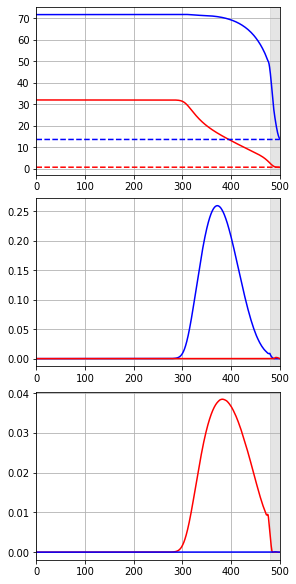

-------  2 0.4000000000000001 0.3750000000000001
--------------- k  0
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  716.9764445568785
RUN  0 , total integrated cost =  716.9764445568785
Gradient descend method:  None
RUN  1 , total integrated cost =  712.4872714989104
RUN  2 , total integrated cost =  709.4706191082921
RUN  3 , total integrated cost =  705.538743996997
RUN  4 , total integrated cost =  702.667098344222
RUN  5 , total integrated cost =  698.9016562727654
RUN  6 , total integrated cost =  696.1911607277048
RUN  7 , total integrated cost =  692.4717593624738
RUN  8 , total integrated cost =  689.983225505021
RUN  9 , total integrated cost =  686.2272446693726
RUN  10 , total integrated cost =  683.545316820427
RUN  11 , total integrated cost =  678.7279681133946
RUN  12 , total integrated cost =  675.4257564877894
RUN  13 , total integrated cost =  670.5009774899922
RUN  14 , total integrated cost =  667.2978075690718
RUN  15 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  514.7037738609539
RUN  100 , total integrated cost =  514.7037738609539
Improved over  100  iterations in  47.44544457399752  seconds by  28.21189904236499  percent.
Problem in initial value trasfer post:  sigmae_f 1.5928153706195174 1.593128048769791
Problem in initial value trasfer post:  tau_exc 19.09423157043776 19.09130749375459
cost splitting :  0.9709435581182365 [4.69353371e-06 4.80051056e-02 3.88240584e-03 5.74175626e-11]
--------------- k  1
set cost params:  1.0 36357.08576567835 0.0
interpolate adjoint :  True True True
initial cost =  1887.620294261639
RUN  0 , total integrated cost =  1887.620294261639
Gradient descend method:  None
RUN  1 , total integrated cost =  1886.219648353526
RUN  2 , total integrated cost =  1885.7759722269789
RUN  3 , total integrated cost =  1885.2817577699814
RUN  4 , total integrated cost =  1884.9659488007012
RUN  5 , total integrated cost =  1884.582910337999
RUN  6 , total integrated cost =  1884.3261750

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  1834.438847042966
RUN  100 , total integrated cost =  1834.438847042966
Improved over  100  iterations in  55.525879301014356  seconds by  2.817380560081091  percent.
Problem in initial value trasfer post:  sigmae_f 1.5904903349423327 1.590490463178963
Problem in initial value trasfer post:  tau_exc 19.353014303180117 19.353013140474815
cost splitting :  3.4792602142189724 [1.22658294e-06 4.63786931e-02 3.98054079e-03 1.33810330e-10]
--------------- k  2
set cost params:  1.0 64428.6148052804 0.0
interpolate adjoint :  True True True
initial cost =  3248.133980455482
RUN  0 , total integrated cost =  3248.133980455482
Gradient descend method:  None
RUN  1 , total integrated cost =  3247.5553452315266
RUN  2 , total integrated cost =  3247.5069706775707
RUN  3 , total integrated cost =  3247.449919608417
RUN  4 , total integrated cost =  3247.4024911451215
RUN  5 , total integrated cost =  3247.3750617704964
RUN  6 , total integrated cost =  3247.3374

RUN  2 , total integrated cost =  14235.653189156974
RUN  3 , total integrated cost =  14235.64361811138
RUN  4 , total integrated cost =  14235.63993925451
Control only changes marginally.
RUN  4 , total integrated cost =  14235.63993925451
Improved over  4  iterations in  3.6172549290349707  seconds by  0.0008786851684874364  percent.
cost splitting :  14.860404230141565 [1.29988843e-08 4.57633413e-02 4.00666758e-03 6.46416012e-10]
--------------- k  11
set cost params:  1.0 313353.0464088019 0.0
interpolate adjoint :  True True True
initial cost =  15610.155573022947
RUN  0 , total integrated cost =  15610.155573022947
Gradient descend method:  None
RUN  1 , total integrated cost =  15610.068770652137
RUN  2 , total integrated cost =  15610.065968878971
Control only changes marginally.
RUN  2 , total integrated cost =  15610.065968878971
Improved over  2  iterations in  2.4390774479834363  seconds by  0.0005740118575801034  percent.
cost splitting :  16.279255409592114 [1.29819261e-

RUN  1 , total integrated cost =  29351.757887405056
RUN  2 , total integrated cost =  29351.75217427067
RUN  3 , total integrated cost =  29351.74724786459
RUN  4 , total integrated cost =  29351.723587198874
RUN  5 , total integrated cost =  29351.71296472707
Control only changes marginally.
RUN  5 , total integrated cost =  29351.71296472707
Improved over  5  iterations in  4.563340194057673  seconds by  0.00034588608663455034  percent.
cost splitting :  32.55043378447882 [7.22324355e-10 4.57152522e-02 4.01165167e-03 5.57504634e-10]
--------------- k  22
set cost params:  1.0 617255.9555853152 0.0
interpolate adjoint :  True True True
initial cost =  30726.02605367904
RUN  0 , total integrated cost =  30726.02605367904
Gradient descend method:  None
RUN  1 , total integrated cost =  30725.975251926473
RUN  2 , total integrated cost =  30725.97219012484
RUN  3 , total integrated cost =  30725.93312523624
RUN  4 , total integrated cost =  30725.89863182224
Control only changes margina

RUN  1 , total integrated cost =  45837.85455931766
RUN  2 , total integrated cost =  45837.84822848212
RUN  3 , total integrated cost =  45837.75322063519
RUN  4 , total integrated cost =  45837.688091621654
RUN  5 , total integrated cost =  45837.6831455433
Control only changes marginally.
RUN  5 , total integrated cost =  45837.6831455433
Improved over  5  iterations in  4.5291081020841375  seconds by  0.0005168643278778973  percent.
cost splitting :  50.7120683218699 [6.85282299e-10 4.56926603e-02 4.00669410e-03 4.31703290e-10]
--------------- k  34
set cost params:  1.0 948938.9542458117 0.0
interpolate adjoint :  True True True
initial cost =  47211.80028496867
RUN  0 , total integrated cost =  47211.80028496867
Gradient descend method:  None
RUN  1 , total integrated cost =  47211.735718338736
RUN  2 , total integrated cost =  47211.73280919078
RUN  3 , total integrated cost =  47211.70308925616
RUN  4 , total integrated cost =  47211.68051253841
Control only changes marginally.

RUN  1 , total integrated cost =  63693.70825611223
RUN  2 , total integrated cost =  63693.70135144555
Control only changes marginally.
RUN  2 , total integrated cost =  63693.70135144555
Improved over  2  iterations in  2.5058311499888077  seconds by  9.10861039642441e-05  percent.
cost splitting :  72.61815617421996 [6.63368499e-10 4.56688574e-02 4.01001680e-03 4.12405106e-10]
--------------- k  47
set cost params:  1.0 1308313.0692299674 0.0
interpolate adjoint :  True True True
initial cost =  65066.970451485984
RUN  0 , total integrated cost =  65066.970451485984
Gradient descend method:  None
RUN  1 , total integrated cost =  65066.92354374033
RUN  2 , total integrated cost =  65066.91282197825
Control only changes marginally.
RUN  2 , total integrated cost =  65066.91282197825
Improved over  2  iterations in  2.3593941900180653  seconds by  8.856952663904849e-05  percent.
cost splitting :  74.22255392555068 [6.61207240e-10 4.56679414e-02 4.00992422e-03 4.10831127e-10]
---------

RUN  1 , total integrated cost =  96643.54020549149
RUN  2 , total integrated cost =  96643.52548155034
Control only changes marginally.
RUN  2 , total integrated cost =  96643.52548155034
Improved over  2  iterations in  2.143088571028784  seconds by  7.15406172986377e-05  percent.
cost splitting :  113.36631089378844 [6.34076032e-10 4.56480348e-02 4.00522322e-03 3.93452537e-10]
--------------- k  71
set cost params:  1.0 1971765.3785914057 0.0
interpolate adjoint :  True True True
initial cost =  98015.83614102544
RUN  0 , total integrated cost =  98015.83614102544
Gradient descend method:  None
RUN  1 , total integrated cost =  98015.77841989062
RUN  2 , total integrated cost =  98015.76563929494
Control only changes marginally.
RUN  2 , total integrated cost =  98015.76563929494
Improved over  2  iterations in  1.6813238090835512  seconds by  7.192891810348101e-05  percent.
cost splitting :  114.96200960819989 [6.31290010e-10 4.56471013e-02 4.00513725e-03 3.91957044e-10]
----------

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  115626.80976373298
Control only changes marginally.
RUN  7 , total integrated cost =  115626.80976373298
Improved over  7  iterations in  5.296084861969575  seconds by  15.253506548345285  percent.
Problem in initial value trasfer post:  sigmae_f 1.504981244705455 1.5049822394662202
Problem in initial value trasfer post:  tau_exc 3.0581711415556216 3.0581707237561004
cost splitting :  98205.15464345319 [3.95859708e-11 6.05477775e-03 2.89703548e-04 1.95701616e-24]
converged to zero, reload and break
file found
-------  3 0.4250000000000001 0.3750000000000001
--------------- k  0
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  23875.03785578684
RUN  0 , total integrated cost =  23875.03785578684
Gradient descend method:  None
RUN  1 , total integrated cost =  23866.08655075297
RUN  2 , total integrated cost =  23858.395979147383
RUN  3 , total integrated cost =  23849.742986043497
RUN  4 , total integrated cost =  2

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  22606.34194917612
RUN  100 , total integrated cost =  22606.34194917612
Improved over  100  iterations in  50.434682121966034  seconds by  5.313901130855015  percent.
Problem in initial value trasfer post:  sigmae_f 1.576333406155748 1.5763469976551474
Problem in initial value trasfer post:  tau_exc 17.913907566514002 17.913757042010193
cost splitting :  29.28659497532169 [5.55352772e-05 2.21844238e+00 6.20126826e-02 4.48403212e-08]
--------------- k  1
set cost params:  1.0 10859.758759827377 0.0
interpolate adjoint :  True True True
initial cost =  24795.082014560154
RUN  0 , total integrated cost =  24795.082014560154
Gradient descend method:  None
RUN  1 , total integrated cost =  24790.587336864053
RUN  2 , total integrated cost =  24789.593181055305
RUN  3 , total integrated cost =  24788.5306241995
RUN  4 , total integrated cost =  24788.058776638056
RUN  5 , total integrated cost =  24787.463503580144
RUN  6 , total integrated cost =  24787.1

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  24538.234861511228
RUN  100 , total integrated cost =  24538.234861511228
Improved over  100  iterations in  53.364606096060015  seconds by  1.03587942519448  percent.
Problem in initial value trasfer post:  sigmae_f 1.5847831861330388 1.5848494158877622
Problem in initial value trasfer post:  tau_exc 17.815491555079653 17.814757699233834
cost splitting :  20.655594518448698 [1.51584934e-05 2.19497558e+00 6.26633916e-02 9.51281511e-09]
--------------- k  2
set cost params:  1.0 11841.031742477779 0.0
interpolate adjoint :  True True True
initial cost =  26753.609868153802
RUN  0 , total integrated cost =  26753.609868153802
Gradient descend method:  None
RUN  1 , total integrated cost =  26753.52038819685
RUN  2 , total integrated cost =  26753.514065491596
RUN  3 , total integrated cost =  26753.48365357528
RUN  4 , total integrated cost =  26753.47138647838
RUN  5 , total integrated cost =  26751.954343663423
RUN  6 , total integrated cost =  26750

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  200 , total integrated cost =  26706.725234023063
RUN  200 , total integrated cost =  26706.725234023063
Improved over  200  iterations in  107.25795049697626  seconds by  0.17524601114314464  percent.
Problem in initial value trasfer post:  sigmae_f 1.586136495847113 1.5861366682474214
Problem in initial value trasfer post:  tau_exc 17.859650157016834 17.85964825844002
cost splitting :  13.206821787433064 [1.54399946e-05 2.19240460e+00 6.19036356e-02 2.24979204e-08]
--------------- k  3
set cost params:  1.0 12816.386911093072 0.0
interpolate adjoint :  True True True
initial cost =  28905.491500184096
RUN  0 , total integrated cost =  28905.491500184096
Gradient descend method:  None
RUN  1 , total integrated cost =  28905.015322699794
RUN  2 , total integrated cost =  28904.788596209495
RUN  3 , total integrated cost =  28904.563786496143
RUN  4 , total integrated cost =  28904.477578024445
RUN  5 , total integrated cost =  28904.392388766122
RUN  6 , total integrated cost =  2

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  65 , total integrated cost =  28903.013416021506
Improved over  65  iterations in  36.859556002076715  seconds by  0.008573056654554989  percent.
Problem in initial value trasfer post:  sigmae_f 1.5845282784985795 1.5845299845311334
Problem in initial value trasfer post:  tau_exc 17.86415241294071 17.864133599181113
cost splitting :  16.623836888010768 [1.45342191e-05 2.19192487e+00 6.19353245e-02 2.08922897e-08]
--------------- k  4
set cost params:  1.0 13789.308667061781 0.0
interpolate adjoint :  True True True
initial cost =  31095.857192205898
RUN  0 , total integrated cost =  31095.857192205898
Gradient descend method:  None
RUN  1 , total integrated cost =  31095.79581998837
RUN  2 , total integrated cost =  31095.792963633732
RUN  3 , total integrated cost =  31095.78836993894
RUN  4 , total integrated cost =  31095.77884415924
RUN  5 , total integrated cost =  31095.7767955648
RUN  6 , total integrated cost =  31095.775340807155
RUN  7 , 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  79 , total integrated cost =  31093.266645334974
Improved over  79  iterations in  40.961934920051135  seconds by  0.008330842449240095  percent.
Problem in initial value trasfer post:  sigmae_f 1.5846951973746077 1.5846973533139794
Problem in initial value trasfer post:  tau_exc 17.8502562194065 17.850232414310952
cost splitting :  17.60544698511603 [1.38897520e-05 2.19140473e+00 6.21958846e-02 2.06412498e-08]
--------------- k  5
set cost params:  1.0 14762.232577206114 0.0
interpolate adjoint :  True True True
initial cost =  33285.86210136186
RUN  0 , total integrated cost =  33285.86210136186
Gradient descend method:  None
RUN  1 , total integrated cost =  33285.799200143854
RUN  2 , total integrated cost =  33285.79599949802
RUN  3 , total integrated cost =  33285.7945933518
RUN  4 , total integrated cost =  33285.78670923863
RUN  5 , total integrated cost =  33285.783911898536
RUN  6 , total integrated cost =  33285.781979945554
RUN  7 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  307 , total integrated cost =  33246.89701686302
Improved over  307  iterations in  147.14911055599805  seconds by  0.11706196576849948  percent.
Problem in initial value trasfer post:  sigmae_f 1.5853646519806688 1.585564361716427
Problem in initial value trasfer post:  tau_exc 17.851917662563704 17.849714616190468
cost splitting :  13.128081006689293 [1.38098640e-05 2.18898197e+00 6.22790514e-02 3.74577377e-08]
--------------- k  6
set cost params:  1.0 15741.479490873777 0.0
interpolate adjoint :  True True True
initial cost =  35451.45098059186
RUN  0 , total integrated cost =  35451.45098059186
Gradient descend method:  None
RUN  1 , total integrated cost =  35451.40924671771
RUN  2 , total integrated cost =  35451.40801548129
RUN  3 , total integrated cost =  35451.40740873019
RUN  4 , total integrated cost =  35451.40708856261
RUN  5 , total integrated cost =  35451.40673752193
RUN  6 , total integrated cost =  35451.39994149973
RUN  7 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  35451.396441323384
Control only changes marginally.
RUN  8 , total integrated cost =  35451.396441323384
Improved over  8  iterations in  6.2430871919495985  seconds by  0.00015384213330094099  percent.
Problem in initial value trasfer post:  sigmae_f 1.585056497018856 1.585252046939513
Problem in initial value trasfer post:  tau_exc 17.857177746857495 17.855021006281397
cost splitting :  14.11338843135815 [1.33000709e-05 2.18891914e+00 6.22781556e-02 3.74358708e-08]
--------------- k  7
set cost params:  1.0 16715.24297827557 0.0
interpolate adjoint :  True True True
initial cost =  37643.54316196329
RUN  0 , total integrated cost =  37643.54316196329
Gradient descend method:  None
RUN  1 , total integrated cost =  37643.505435975276
RUN  2 , total integrated cost =  37643.503424523056
RUN  3 , total integrated cost =  37643.50215488752
RUN  4 , total integrated cost =  37643.49780016536
RUN  5 , total integrated cost =  37643.496013519325


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  37643.49526501896
Control only changes marginally.
RUN  6 , total integrated cost =  37643.49526501896
Improved over  6  iterations in  4.7551431759493425  seconds by  0.00012723814047888027  percent.
Problem in initial value trasfer post:  sigmae_f 1.585070407215665 1.5852616353175706
Problem in initial value trasfer post:  tau_exc 17.842757511688916 17.84064530384967
cost splitting :  15.222720271283368 [1.29102611e-05 2.18885481e+00 6.22788879e-02 3.74118027e-08]
--------------- k  8
set cost params:  1.0 17689.053623950982 0.0
interpolate adjoint :  True True True
initial cost =  39835.68583122394
RUN  0 , total integrated cost =  39835.68583122394
Gradient descend method:  None
RUN  1 , total integrated cost =  39835.6528991316
RUN  2 , total integrated cost =  39835.649805955676
RUN  3 , total integrated cost =  39835.64893070882
RUN  4 , total integrated cost =  39835.64428312075
RUN  5 , total integrated cost =  39835.6426626361


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  39835.641696010294
Control only changes marginally.
RUN  6 , total integrated cost =  39835.641696010294
Improved over  6  iterations in  4.474295787978917  seconds by  0.00011079315625295294  percent.
Problem in initial value trasfer post:  sigmae_f 1.5849060090315161 1.5850935913498172
Problem in initial value trasfer post:  tau_exc 17.848124120101478 17.846052946762224
cost splitting :  16.274598315432662 [1.23537422e-05 2.18879462e+00 6.22775430e-02 3.73985998e-08]
--------------- k  9
set cost params:  1.0 18662.909528779754 0.0
interpolate adjoint :  True True True
initial cost =  42027.8736836214
RUN  0 , total integrated cost =  42027.8736836214
Gradient descend method:  None
RUN  1 , total integrated cost =  42027.84508340898
RUN  2 , total integrated cost =  42027.842901898555
RUN  3 , total integrated cost =  42027.84240199239
RUN  4 , total integrated cost =  42027.84190454226
RUN  5 , total integrated cost =  42027.83402668243
RUN  6 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  42027.82960241657
Control only changes marginally.
RUN  7 , total integrated cost =  42027.82960241657
Improved over  7  iterations in  5.660797154996544  seconds by  0.00010488564127797417  percent.
Problem in initial value trasfer post:  sigmae_f 1.5846019179704065 1.58478722882749
Problem in initial value trasfer post:  tau_exc 17.85997023319334 17.85792594739533
cost splitting :  17.083615015074404 [1.19938173e-05 2.18874575e+00 6.22770408e-02 3.73676838e-08]
--------------- k  10
set cost params:  1.0 19636.76719135566 0.0
interpolate adjoint :  True True True
initial cost =  44220.01711363853
RUN  0 , total integrated cost =  44220.01711363853
Gradient descend method:  None
RUN  1 , total integrated cost =  44219.9840562202
RUN  2 , total integrated cost =  44219.981302642605
RUN  3 , total integrated cost =  44219.98048748216
RUN  4 , total integrated cost =  44219.97982363897
RUN  5 , total integrated cost =  44219.973274833246
RUN  6 , total i

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  44219.95176122873
Control only changes marginally.
RUN  10 , total integrated cost =  44219.95176122873
Improved over  10  iterations in  5.6400695940246806  seconds by  0.0001477892006107595  percent.
Problem in initial value trasfer post:  sigmae_f 1.58436713507055 1.584549807505442
Problem in initial value trasfer post:  tau_exc 17.867888302304802 17.865874241286896
cost splitting :  18.115858651594067 [1.16456812e-05 2.18869244e+00 6.22763521e-02 3.71813314e-08]
--------------- k  11
set cost params:  1.0 20610.678379699857 0.0
interpolate adjoint :  True True True
initial cost =  46412.206826052425
RUN  0 , total integrated cost =  46412.206826052425
Gradient descend method:  None
RUN  1 , total integrated cost =  46412.174800904766
RUN  2 , total integrated cost =  46412.171752156166
RUN  3 , total integrated cost =  46412.17062551518
RUN  4 , total integrated cost =  46412.16386570047
RUN  5 , total integrated cost =  46412.16141171994


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  46412.159975119765
Control only changes marginally.
RUN  6 , total integrated cost =  46412.159975119765
Improved over  6  iterations in  4.194134602905251  seconds by  0.00010094528113313572  percent.
Problem in initial value trasfer post:  sigmae_f 1.584258274528285 1.5844396586839136
Problem in initial value trasfer post:  tau_exc 17.88262215833385 17.880625122959977
cost splitting :  19.433250902781527 [1.09633960e-05 2.18863117e+00 6.22766708e-02 3.71775670e-08]
--------------- k  12
set cost params:  1.0 21584.65862979644 0.0
interpolate adjoint :  True True True
initial cost =  48604.5104696763
RUN  0 , total integrated cost =  48604.5104696763
Gradient descend method:  None
RUN  1 , total integrated cost =  48604.48608584864


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  48604.48551268529
Control only changes marginally.
RUN  2 , total integrated cost =  48604.48551268529
Improved over  2  iterations in  2.112910163938068  seconds by  5.134706793796795e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5839909608817861 1.5841709220438618
Problem in initial value trasfer post:  tau_exc 17.88184280685683 17.879860668348496
cost splitting :  20.18386160663676 [1.09632339e-05 2.18859417e+00 6.22756246e-02 3.71624965e-08]
--------------- k  13
set cost params:  1.0 22558.572517950597 0.0
interpolate adjoint :  True True True
initial cost =  50796.64958268867
RUN  0 , total integrated cost =  50796.64958268867
Gradient descend method:  None
RUN  1 , total integrated cost =  50796.61728626082
RUN  2 , total integrated cost =  50796.61428018745
RUN  3 , total integrated cost =  50796.61325838172
RUN  4 , total integrated cost =  50796.612908164825
RUN  5 , total integrated cost =  50796.61245565227
RUN  6 , total

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  50796.606736771515
Control only changes marginally.
RUN  7 , total integrated cost =  50796.606736771515
Improved over  7  iterations in  5.576385576045141  seconds by  8.434791961065002e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5837102532968907 1.5838888792433499
Problem in initial value trasfer post:  tau_exc 17.89881200272684 17.896847421783246
cost splitting :  21.43198758270429 [1.04888149e-05 2.18854099e+00 6.22746596e-02 3.71370249e-08]
--------------- k  14
set cost params:  1.0 23532.595666275316 0.0
interpolate adjoint :  True True True
initial cost =  52988.96353878555
RUN  0 , total integrated cost =  52988.96353878555
Gradient descend method:  None
RUN  1 , total integrated cost =  52988.94148693194
RUN  2 , total integrated cost =  52988.940196145326
RUN  3 , total integrated cost =  52988.9395201212
RUN  4 , total integrated cost =  52988.920681568714
RUN  5 , total integrated cost =  52988.907170050166
RUN  6 , to

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  9 , total integrated cost =  52988.89823426539
Control only changes marginally.
RUN  9 , total integrated cost =  52988.89823426539
Improved over  9  iterations in  6.550064834998921  seconds by  0.00012324173903266455  percent.
Problem in initial value trasfer post:  sigmae_f 1.583720326351218 1.583895815122146
Problem in initial value trasfer post:  tau_exc 17.893427477229785 17.891496335405563
cost splitting :  22.346790758567405 [1.03615930e-05 2.18849720e+00 6.22754438e-02 3.71076234e-08]
--------------- k  15
set cost params:  1.0 24506.599960952146 0.0
interpolate adjoint :  True True True
initial cost =  55181.170580155354
RUN  0 , total integrated cost =  55181.170580155354
Gradient descend method:  None
RUN  1 , total integrated cost =  55181.148236855115
RUN  2 , total integrated cost =  55181.14711201576
RUN  3 , total integrated cost =  55181.14679451381


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  55181.146607636256
Control only changes marginally.
RUN  4 , total integrated cost =  55181.146607636256
Improved over  4  iterations in  3.844985484960489  seconds by  4.344329568084504e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5833503698151337 1.58352500177081
Problem in initial value trasfer post:  tau_exc 17.914615498416545 17.91269722480532
cost splitting :  23.029944552135778 [9.98882383e-06 2.18846330e+00 6.22744820e-02 2.00387978e-08]
--------------- k  16
set cost params:  1.0 25480.59353394821 0.0
interpolate adjoint :  True True True
initial cost =  57373.36048976392
RUN  0 , total integrated cost =  57373.36048976392
Gradient descend method:  None
RUN  1 , total integrated cost =  57373.33507323184
RUN  2 , total integrated cost =  57373.333552603115
RUN  3 , total integrated cost =  57373.3330237258
RUN  4 , total integrated cost =  57373.33261890312
RUN  5 , total integrated cost =  57373.32922404113
RUN  6 , total 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  21 , total integrated cost =  57372.88451040087
Improved over  21  iterations in  13.579129428952001  seconds by  0.0008296173676853869  percent.
Problem in initial value trasfer post:  sigmae_f 1.5833519367039424 1.583504564144003
Problem in initial value trasfer post:  tau_exc 17.914654075142774 17.912977523571833
cost splitting :  24.25446868708598 [1.00940366e-05 2.18834527e+00 6.23273769e-02 2.00335755e-08]
--------------- k  17
set cost params:  1.0 26454.815088316132 0.0
interpolate adjoint :  True True True
initial cost =  59565.54816637563
RUN  0 , total integrated cost =  59565.54816637563
Gradient descend method:  None
RUN  1 , total integrated cost =  59565.5319606956
RUN  2 , total integrated cost =  59565.53116337424


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  59565.53057889688
Control only changes marginally.
RUN  3 , total integrated cost =  59565.53057889688
Improved over  3  iterations in  2.930243756971322  seconds by  2.9526260206580446e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5830487441188017 1.5832006490062975
Problem in initial value trasfer post:  tau_exc 17.932179507580813 17.93051337498175
cost splitting :  25.05103316624633 [9.78141722e-06 2.18831797e+00 6.23275599e-02 2.00335832e-08]
--------------- k  18
set cost params:  1.0 27428.799341178885 0.0
interpolate adjoint :  True True True
initial cost =  61757.63343287303
RUN  0 , total integrated cost =  61757.63343287303
Gradient descend method:  None
RUN  1 , total integrated cost =  61757.60611179745
RUN  2 , total integrated cost =  61757.60505434382


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  61757.604645751286
Control only changes marginally.
RUN  3 , total integrated cost =  61757.604645751286
Improved over  3  iterations in  3.077375611057505  seconds by  4.661305841580088e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.582732181506229 1.582883133689735
Problem in initial value trasfer post:  tau_exc 17.94771118441719 17.946057597497052
cost splitting :  25.989597242724294 [9.46052981e-06 2.18828155e+00 6.23277014e-02 2.00337997e-08]
--------------- k  19
set cost params:  1.0 28402.87376839553 0.0
interpolate adjoint :  True True True
initial cost =  63949.87480064925
RUN  0 , total integrated cost =  63949.87480064925
Gradient descend method:  None
RUN  1 , total integrated cost =  63949.84818151517
RUN  2 , total integrated cost =  63949.8461872546
RUN  3 , total integrated cost =  63949.845531841085


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  63949.84536707842
Control only changes marginally.
RUN  4 , total integrated cost =  63949.84536707842
Improved over  4  iterations in  3.721937282010913  seconds by  4.6026002280541434e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5828612635982304 1.5830113474484286
Problem in initial value trasfer post:  tau_exc 17.941741752585923 17.940096890570253
cost splitting :  27.10774468149263 [9.26852586e-06 2.18823893e+00 6.23277829e-02 2.00336839e-08]
--------------- k  20
set cost params:  1.0 29377.017245777668 0.0
interpolate adjoint :  True True True
initial cost =  66142.22930253696
RUN  0 , total integrated cost =  66142.22930253696
Gradient descend method:  None
RUN  1 , total integrated cost =  66142.21043059055
RUN  2 , total integrated cost =  66142.20944552858


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  66142.20918022563
Control only changes marginally.
RUN  3 , total integrated cost =  66142.20918022563
Improved over  3  iterations in  3.046022600028664  seconds by  3.042278969189738e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5824367370614325 1.5825861157154917
Problem in initial value trasfer post:  tau_exc 17.971243078935913 17.969610221196852
cost splitting :  28.091551649120706 [8.78585237e-06 2.18820592e+00 6.23278799e-02 2.00335191e-08]
--------------- k  21
set cost params:  1.0 30351.110705416082 0.0
interpolate adjoint :  True True True
initial cost =  68334.44800887613
RUN  0 , total integrated cost =  68334.44800887613
Gradient descend method:  None
RUN  1 , total integrated cost =  68334.42720013902
RUN  2 , total integrated cost =  68334.4260550696


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  68334.42595276846
Control only changes marginally.
RUN  3 , total integrated cost =  68334.42595276846
Improved over  3  iterations in  2.9464885039487854  seconds by  3.2276704232003794e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5823888341597638 1.5825374614864096
Problem in initial value trasfer post:  tau_exc 17.97636577547389 17.974741917896683
cost splitting :  29.058425818569738 [8.54811285e-06 2.18817313e+00 6.23269207e-02 2.00325652e-08]
--------------- k  22
set cost params:  1.0 31325.235032150045 0.0
interpolate adjoint :  True True True
initial cost =  70526.70114347941
RUN  0 , total integrated cost =  70526.70114347941
Gradient descend method:  None
RUN  1 , total integrated cost =  70526.68097541398
RUN  2 , total integrated cost =  70526.6800356114


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  70526.67968688127
Control only changes marginally.
RUN  3 , total integrated cost =  70526.67968688127
Improved over  3  iterations in  3.0312526690540835  seconds by  3.042336844316651e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5820938185999136 1.5822415105252425
Problem in initial value trasfer post:  tau_exc 17.995357128066637 17.993745637001993
cost splitting :  30.250390294920013 [8.17943723e-06 2.18813756e+00 6.23270549e-02 2.00322119e-08]
--------------- k  23
set cost params:  1.0 32299.38007395141 0.0
interpolate adjoint :  True True True
initial cost =  72718.96662263847
RUN  0 , total integrated cost =  72718.96662263847
Gradient descend method:  None
RUN  1 , total integrated cost =  72718.94973247379


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  72718.94885220591
Control only changes marginally.
RUN  2 , total integrated cost =  72718.94885220591
Improved over  2  iterations in  2.1934155370108783  seconds by  2.443713572120032e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5818810589838 1.582027810692743
Problem in initial value trasfer post:  tau_exc 17.994440481960236 17.992838861753555
cost splitting :  31.09454656991464 [8.17927476e-06 2.18811251e+00 6.23272287e-02 2.00311074e-08]
--------------- k  24
set cost params:  1.0 33273.46074465829 0.0
interpolate adjoint :  True True True
initial cost =  74911.06669314527
RUN  0 , total integrated cost =  74911.06669314527
Gradient descend method:  None
RUN  1 , total integrated cost =  74911.04204264993
RUN  2 , total integrated cost =  74911.03993932637
RUN  3 , total integrated cost =  74911.03963274955


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  74911.03940788303
Control only changes marginally.
RUN  4 , total integrated cost =  74911.03940788303
Improved over  4  iterations in  3.867421063943766  seconds by  3.642353986776925e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5817711536472099 1.5819170720977471
Problem in initial value trasfer post:  tau_exc 18.00661394792909 18.00502272933145
cost splitting :  32.13708386179101 [7.87520702e-06 2.18807796e+00 6.23273318e-02 2.00305712e-08]
--------------- k  25
set cost params:  1.0 34247.65335735603 0.0
interpolate adjoint :  True True True
initial cost =  77103.37531109163
RUN  0 , total integrated cost =  77103.37531109163
Gradient descend method:  None
RUN  1 , total integrated cost =  77103.35539305862
RUN  2 , total integrated cost =  77103.35390204839


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  77103.3535179744
Control only changes marginally.
RUN  3 , total integrated cost =  77103.3535179744
Improved over  3  iterations in  3.1006001399364322  seconds by  2.8264803106026193e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5813560535205673 1.5815010536862255
Problem in initial value trasfer post:  tau_exc 18.031779389480434 18.03020062917762
cost splitting :  33.452912143654885 [7.45607114e-06 2.18808330e+00 6.22849859e-02 2.00300249e-08]
--------------- k  26
set cost params:  1.0 35221.87140550603 0.0
interpolate adjoint :  True True True
initial cost =  79295.71019969357
RUN  0 , total integrated cost =  79295.71019969357
Gradient descend method:  None
RUN  1 , total integrated cost =  79295.69614476096
RUN  2 , total integrated cost =  79295.69525394471


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  79295.69434773726
Control only changes marginally.
RUN  3 , total integrated cost =  79295.69434773726
Improved over  3  iterations in  3.1295807029819116  seconds by  1.9990938056935192e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5812427747528521 1.5813871881805819
Problem in initial value trasfer post:  tau_exc 18.031602549882034 18.03003001160501
cost splitting :  33.891454598758756 [7.45596679e-06 2.18806184e+00 6.22931100e-02 2.00276694e-08]
--------------- k  27
set cost params:  1.0 36195.90854864917 0.0
interpolate adjoint :  True True True
initial cost =  81487.63093884414
RUN  0 , total integrated cost =  81487.63093884414
Gradient descend method:  None
RUN  1 , total integrated cost =  81487.5980141571
RUN  2 , total integrated cost =  81487.59566331973
RUN  3 , total integrated cost =  81487.59524392584
RUN  4 , total integrated cost =  81487.59508470296
RUN  5 , total integrated cost =  81487.59504833499
RUN  6 , total

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  81487.59501640151
Control only changes marginally.
RUN  10 , total integrated cost =  81487.59501640151
Improved over  10  iterations in  9.698268380016088  seconds by  4.4083307145115214e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5811251430683428 1.581268475675394
Problem in initial value trasfer post:  tau_exc 18.03967018920742 18.038110214889876
cost splitting :  35.35673791824172 [7.21786406e-06 2.18801583e+00 6.22931100e-02 1.42678611e-08]
--------------- k  28
set cost params:  1.0 37170.26632895611 0.0
interpolate adjoint :  True True True
initial cost =  83680.2080843504
RUN  0 , total integrated cost =  83680.2080843504
Gradient descend method:  None
RUN  1 , total integrated cost =  83680.19525008183
RUN  2 , total integrated cost =  83680.1938043807
RUN  3 , total integrated cost =  83680.18599135302
RUN  4 , total integrated cost =  83680.17361317812
RUN  5 , total integrated cost =  83680.17219069717
RUN  6 , total i

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  83680.15853007739
Control only changes marginally.
RUN  8 , total integrated cost =  83680.15853007739
Improved over  8  iterations in  6.090243146987632  seconds by  5.921863022706475e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5809349073162662 1.5810765782789111
Problem in initial value trasfer post:  tau_exc 18.043345227817454 18.04180352392137
cost splitting :  36.6477640718906 [7.21566909e-06 2.18798675e+00 6.22973533e-02 1.42638190e-08]
--------------- k  29
set cost params:  1.0 38144.381409229 0.0
interpolate adjoint :  True True True
initial cost =  85872.20125574227
RUN  0 , total integrated cost =  85872.20125574227
Gradient descend method:  None
RUN  1 , total integrated cost =  85872.18080340237
RUN  2 , total integrated cost =  85872.17941986198
RUN  3 , total integrated cost =  85872.17902179346
RUN  4 , total integrated cost =  85872.17871547551
RUN  5 , total integrated cost =  85872.17659970192
RUN  6 , total inte

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  85872.16872620492
Control only changes marginally.
RUN  7 , total integrated cost =  85872.16872620492
Improved over  7  iterations in  5.604333012015559  seconds by  3.788133629711865e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.580560419489029 1.5807013544131574
Problem in initial value trasfer post:  tau_exc 18.07119282745656 18.069661871858745
cost splitting :  37.46424794615118 [6.81434624e-06 2.18794323e+00 6.23126404e-02 1.42640319e-08]
--------------- k  30
set cost params:  1.0 39118.62642602573 0.0
interpolate adjoint :  True True True
initial cost =  88064.4759439616
RUN  0 , total integrated cost =  88064.4759439616
Gradient descend method:  None
RUN  1 , total integrated cost =  88064.45600560718
RUN  2 , total integrated cost =  88064.45527659374


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  88064.45480169676
Control only changes marginally.
RUN  3 , total integrated cost =  88064.45480169676
Improved over  3  iterations in  3.0973596969852224  seconds by  2.4007710962337114e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5802658009795243 1.5804057323565053
Problem in initial value trasfer post:  tau_exc 18.083994506188162 18.082475550411644
cost splitting :  38.700666520494224 [6.57688491e-06 2.18791183e+00 6.23117205e-02 1.42637808e-08]
--------------- k  31
set cost params:  1.0 40092.89147875092 0.0
interpolate adjoint :  True True True
initial cost =  90256.77539078175
RUN  0 , total integrated cost =  90256.77539078175
Gradient descend method:  None
RUN  1 , total integrated cost =  90256.75959419123
RUN  2 , total integrated cost =  90256.75893980879
RUN  3 , total integrated cost =  90256.75839161348
RUN  4 , total integrated cost =  90256.70828453264
RUN  5 , total integrated cost =  90256.67332728764
RUN  6 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  9 , total integrated cost =  90256.66193731215
Control only changes marginally.
RUN  9 , total integrated cost =  90256.66193731215
Improved over  9  iterations in  6.579077354050241  seconds by  0.00012570077882401165  percent.
Problem in initial value trasfer post:  sigmae_f 1.580079815665769 1.5802155505085151
Problem in initial value trasfer post:  tau_exc 18.086608101413994 18.085134765045876
cost splitting :  39.81354603599924 [6.57642882e-06 2.18789028e+00 6.23071999e-02 1.42438664e-08]
--------------- k  32
set cost params:  1.0 41067.09526574898 0.0
interpolate adjoint :  True True True
initial cost =  92448.81926582339
RUN  0 , total integrated cost =  92448.81926582339
Gradient descend method:  None
RUN  1 , total integrated cost =  92448.8006248956
RUN  2 , total integrated cost =  92448.79935055872


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  92448.79860976977
Control only changes marginally.
RUN  3 , total integrated cost =  92448.79860976977
Improved over  3  iterations in  2.96198285499122  seconds by  2.234323139305161e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5797935283985913 1.5799285227892155
Problem in initial value trasfer post:  tau_exc 18.10631850636149 18.104855040391023
cost splitting :  40.78072396378257 [6.25274726e-06 2.18786384e+00 6.23073507e-02 1.42436919e-08]
--------------- k  33
set cost params:  1.0 42041.34387319269 0.0
interpolate adjoint :  True True True
initial cost =  94641.03086894871
RUN  0 , total integrated cost =  94641.03086894871
Gradient descend method:  None
RUN  1 , total integrated cost =  94641.01236058913
RUN  2 , total integrated cost =  94641.01158023065
RUN  3 , total integrated cost =  94641.01112838737
RUN  4 , total integrated cost =  94641.01108076304


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  94641.01105526478
Control only changes marginally.
RUN  5 , total integrated cost =  94641.01105526478
Improved over  5  iterations in  4.603510391898453  seconds by  2.093561720073467e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5797339557790793 1.5798683090998935
Problem in initial value trasfer post:  tau_exc 18.10301757633035 18.101560626440964
cost splitting :  41.55589673555884 [6.25473577e-06 2.18786398e+00 6.22828699e-02 1.42436812e-08]
--------------- k  34
set cost params:  1.0 43015.60155231603 0.0
interpolate adjoint :  True True True
initial cost =  96833.24000963467
RUN  0 , total integrated cost =  96833.24000963467
Gradient descend method:  None
RUN  1 , total integrated cost =  96833.22439100036
RUN  2 , total integrated cost =  96833.22339289576
RUN  3 , total integrated cost =  96833.22125175253
RUN  4 , total integrated cost =  96833.2123296336
RUN  5 , total integrated cost =  96833.21116835171
RUN  6 , total in

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  12 , total integrated cost =  96833.09147999261
Control only changes marginally.
RUN  12 , total integrated cost =  96833.09147999261
Improved over  12  iterations in  8.051820811000653  seconds by  0.0001533870415215688  percent.
Problem in initial value trasfer post:  sigmae_f 1.5795629621756992 1.5796935065743987
Problem in initial value trasfer post:  tau_exc 18.115542316661386 18.114127810877612
cost splitting :  42.846789923147405 [6.25442345e-06 2.18777950e+00 6.23383791e-02 1.42398688e-08]
--------------- k  35
set cost params:  1.0 43989.872483041436 0.0
interpolate adjoint :  True True True
initial cost =  99025.3220316747
RUN  0 , total integrated cost =  99025.3220316747
Gradient descend method:  None
RUN  1 , total integrated cost =  99025.30474439714
RUN  2 , total integrated cost =  99025.30434676279


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  99025.3040317772
Control only changes marginally.
RUN  3 , total integrated cost =  99025.3040317772
Improved over  3  iterations in  2.88882690097671  seconds by  1.8177065356894673e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5793133994885602 1.5794432401923093
Problem in initial value trasfer post:  tau_exc 18.126580806262496 18.125174810746902
cost splitting :  43.761220265411104 [6.07062656e-06 2.18775856e+00 6.23377428e-02 1.42386611e-08]
--------------- k  36
set cost params:  1.0 44964.096106452205 0.0
interpolate adjoint :  True True True
initial cost =  101217.40693636738
RUN  0 , total integrated cost =  101217.40693636738
Gradient descend method:  None
RUN  1 , total integrated cost =  101217.39132229518


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  101217.39077201003
Control only changes marginally.
RUN  2 , total integrated cost =  101217.39077201003
Improved over  2  iterations in  1.959434036980383  seconds by  1.5969938218063362e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5791106886696382 1.579239656668753
Problem in initial value trasfer post:  tau_exc 18.124758947096733 18.123361977814604
cost splitting :  44.83378750220268 [6.07054769e-06 2.18773646e+00 6.23379009e-02 1.42381142e-08]
--------------- k  37
set cost params:  1.0 45938.309655468074 0.0
interpolate adjoint :  True True True
initial cost =  103409.44962649069
RUN  0 , total integrated cost =  103409.44962649069
Gradient descend method:  None
RUN  1 , total integrated cost =  103409.43155070518
RUN  2 , total integrated cost =  103409.4298529621


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  103409.42967841729
Control only changes marginally.
RUN  3 , total integrated cost =  103409.42967841729
Improved over  3  iterations in  2.780288903042674  seconds by  1.9290377693437222e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5787336953674824 1.5788619585144292
Problem in initial value trasfer post:  tau_exc 18.151431212315188 18.1500442496682
cost splitting :  45.79674379612209 [5.67180520e-06 2.18771026e+00 6.23379223e-02 1.42380509e-08]
--------------- k  38
set cost params:  1.0 46912.63691283565 0.0
interpolate adjoint :  True True True
initial cost =  105601.71849639327
RUN  0 , total integrated cost =  105601.71849639327
Gradient descend method:  None
RUN  1 , total integrated cost =  105601.70606361673


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  105601.70539932851
Control only changes marginally.
RUN  2 , total integrated cost =  105601.70539932851
Improved over  2  iterations in  1.6546470919856802  seconds by  1.2402321615923029e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.578553900691912 1.5786813560599446
Problem in initial value trasfer post:  tau_exc 18.149694873174283 18.148316261308914
cost splitting :  46.910877453293296 [5.67176571e-06 2.18769077e+00 6.23380646e-02 1.42375730e-08]
--------------- k  39
set cost params:  1.0 47886.82049403687 0.0
interpolate adjoint :  True True True
initial cost =  107793.65208514089
RUN  0 , total integrated cost =  107793.65208514089
Gradient descend method:  None
RUN  1 , total integrated cost =  107793.63591564813
RUN  2 , total integrated cost =  107793.63406550241
RUN  3 , total integrated cost =  107793.63384960966


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  107793.63372500359
Control only changes marginally.
RUN  4 , total integrated cost =  107793.63372500359
Improved over  4  iterations in  3.747376702958718  seconds by  1.703267024311117e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5783733314223778 1.5785000554534936
Problem in initial value trasfer post:  tau_exc 18.16136348119563 18.159993787936116
cost splitting :  48.02764446514051 [5.46958633e-06 2.18766457e+00 6.23381367e-02 1.42373581e-08]
--------------- k  40
set cost params:  1.0 48861.14518277691 0.0
interpolate adjoint :  True True True
initial cost =  109985.87225783445
RUN  0 , total integrated cost =  109985.87225783445
Gradient descend method:  None
RUN  1 , total integrated cost =  109985.86210546765


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  109985.86102840223
Control only changes marginally.
RUN  2 , total integrated cost =  109985.86102840223
Improved over  2  iterations in  2.0850131269544363  seconds by  1.0209886042389371e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5782626028983555 1.5783887878191614
Problem in initial value trasfer post:  tau_exc 18.16026518520515 18.158901081739483
cost splitting :  48.834520142679885 [5.46939880e-06 2.18765304e+00 6.23377535e-02 1.42343966e-08]
--------------- k  41
set cost params:  1.0 49835.25969806885 0.0
interpolate adjoint :  True True True
initial cost =  112177.61506553418
RUN  0 , total integrated cost =  112177.61506553418
Gradient descend method:  None
RUN  1 , total integrated cost =  112177.59666516453
RUN  2 , total integrated cost =  112177.59494955833
RUN  3 , total integrated cost =  112177.59347573532
RUN  4 , total integrated cost =  112177.56599166771
RUN  5 , total integrated cost =  112177.53098155204


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  112177.52966057388
Control only changes marginally.
RUN  6 , total integrated cost =  112177.52966057388
Improved over  6  iterations in  4.814024050952867  seconds by  7.613369230341505e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5779091329715529 1.5780326749464837
Problem in initial value trasfer post:  tau_exc 18.187442723753648 18.18610955514063
cost splitting :  50.070502635447795 [5.10705091e-06 2.18766012e+00 6.23068436e-02 1.41901757e-08]
--------------- k  42
set cost params:  1.0 50809.54429465825 0.0
interpolate adjoint :  True True True
initial cost =  114369.64280901392
RUN  0 , total integrated cost =  114369.64280901392
Gradient descend method:  None
RUN  1 , total integrated cost =  114369.62397127903


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  114369.62328714278
Control only changes marginally.
RUN  2 , total integrated cost =  114369.62328714278
Improved over  2  iterations in  2.0772958600427955  seconds by  1.7069102142386328e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.577714102803955 1.5778368234766034
Problem in initial value trasfer post:  tau_exc 18.18531553958069 18.183990808340845
cost splitting :  50.882009460844905 [5.10706948e-06 2.18763991e+00 6.23062465e-02 1.41876817e-08]
--------------- k  43
set cost params:  1.0 51783.85275217106 0.0
interpolate adjoint :  True True True
initial cost =  116561.769845611
RUN  0 , total integrated cost =  116561.769845611
Gradient descend method:  None
RUN  1 , total integrated cost =  116561.75413422965
RUN  2 , total integrated cost =  116561.75230296419
RUN  3 , total integrated cost =  116561.75096136912
RUN  4 , total integrated cost =  116561.73922709787
RUN  5 , total integrated cost =  116561.73659704592


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  116561.7354148967
Control only changes marginally.
RUN  6 , total integrated cost =  116561.7354148967
Improved over  6  iterations in  4.938166863983497  seconds by  2.953859944909709e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.577600407399865 1.5777223417510173
Problem in initial value trasfer post:  tau_exc 18.186544377967813 18.1852281349754
cost splitting :  51.568537360169294 [5.10665121e-06 2.18763691e+00 6.22957414e-02 1.41835229e-08]
--------------- k  44
set cost params:  1.0 52758.04499079829 0.0
interpolate adjoint :  True True True
initial cost =  118753.60732945084
RUN  0 , total integrated cost =  118753.60732945084
Gradient descend method:  None
RUN  1 , total integrated cost =  118753.58154857744
RUN  2 , total integrated cost =  118753.57896999278
RUN  3 , total integrated cost =  118753.57825153816
RUN  4 , total integrated cost =  118753.57809577718
RUN  5 , total integrated cost =  118753.57803909929
RUN  6 , t

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  118753.57798297805
Control only changes marginally.
RUN  7 , total integrated cost =  118753.57798297805
Improved over  7  iterations in  5.840479917940684  seconds by  2.471206850884755e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5773335292324666 1.5774547441058815
Problem in initial value trasfer post:  tau_exc 18.20773177401128 18.20642511614257
cost splitting :  52.76796957511797 [4.81077535e-06 2.18760533e+00 6.22998160e-02 8.60363382e-09]
--------------- k  45
set cost params:  1.0 53732.4483250229 0.0
interpolate adjoint :  True True True
initial cost =  120945.89775583452
RUN  0 , total integrated cost =  120945.89775583452
Gradient descend method:  None
RUN  1 , total integrated cost =  120945.881628743
RUN  2 , total integrated cost =  120945.8805913486
RUN  3 , total integrated cost =  120945.87996147656
RUN  4 , total integrated cost =  120945.85120186945
RUN  5 , total integrated cost =  120945.8377012919


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  120945.83696140265
Control only changes marginally.
RUN  6 , total integrated cost =  120945.83696140265
Improved over  6  iterations in  4.535649737925269  seconds by  5.026580728895169e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.577186701501921 1.5773060676237003
Problem in initial value trasfer post:  tau_exc 18.2070628519882 18.2057759027767
cost splitting :  53.85564149319689 [4.81052749e-06 2.18757549e+00 6.23126325e-02 8.60325400e-09]
--------------- k  46
set cost params:  1.0 54706.65396067521 0.0
interpolate adjoint :  True True True
initial cost =  123137.69534019084
RUN  0 , total integrated cost =  123137.69534019084
Gradient descend method:  None
RUN  1 , total integrated cost =  123137.6738630366
RUN  2 , total integrated cost =  123137.67250692673
RUN  3 , total integrated cost =  123137.67186368686
RUN  4 , total integrated cost =  123137.67140052044
RUN  5 , total integrated cost =  123137.66114228431
RUN  6 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  123137.63830860629
Control only changes marginally.
RUN  7 , total integrated cost =  123137.63830860629
Improved over  7  iterations in  4.111438179039396  seconds by  4.631529313314786e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5767971673948802 1.576914959872872
Problem in initial value trasfer post:  tau_exc 18.231722860403856 18.230454853497704
cost splitting :  55.20224686188218 [4.49838034e-06 2.18757108e+00 6.22905601e-02 8.60310751e-09]
--------------- k  47
set cost params:  1.0 55681.03077331568 0.0
interpolate adjoint :  True True True
initial cost =  125329.85571841472
RUN  0 , total integrated cost =  125329.85571841472
Gradient descend method:  None
RUN  1 , total integrated cost =  125329.84262677585
RUN  2 , total integrated cost =  125329.84149704644
RUN  3 , total integrated cost =  125329.84132680477
RUN  4 , total integrated cost =  125329.83772608466
RUN  5 , total integrated cost =  125329.82767973885


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  125329.82601397962
Control only changes marginally.
RUN  6 , total integrated cost =  125329.82601397962
Improved over  6  iterations in  3.8375924209831282  seconds by  2.370100477833148e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5766536437185144 1.5767707505636208
Problem in initial value trasfer post:  tau_exc 18.23265953398846 18.231398849334923
cost splitting :  56.293347925255254 [4.49839625e-06 2.18753780e+00 6.23073009e-02 8.60279845e-09]
--------------- k  48
set cost params:  1.0 56655.24125962522 0.0
interpolate adjoint :  True True True
initial cost =  127521.65309300814
RUN  0 , total integrated cost =  127521.65309300814
Gradient descend method:  None
RUN  1 , total integrated cost =  127521.63707005868


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  127521.6353647254
Control only changes marginally.
RUN  2 , total integrated cost =  127521.6353647254
Improved over  2  iterations in  2.303902241983451  seconds by  1.3902174501367881e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.57648502505755 1.576601350973969
Problem in initial value trasfer post:  tau_exc 18.23049029620524 18.229237638325827
cost splitting :  57.44730541650603 [4.49815029e-06 2.18752048e+00 6.23067681e-02 8.60184749e-09]
--------------- k  49
set cost params:  1.0 57629.47466040577 0.0
interpolate adjoint :  True True True
initial cost =  129713.49660649628
RUN  0 , total integrated cost =  129713.49660649628
Gradient descend method:  None
RUN  1 , total integrated cost =  129713.4775943429
RUN  2 , total integrated cost =  129713.47570562069
RUN  3 , total integrated cost =  129713.47554701302
RUN  4 , total integrated cost =  129713.47546689995
RUN  5 , total integrated cost =  129713.47538748084
RUN  6 , tot

RUN  1 , total integrated cost =  153823.10036973553
RUN  2 , total integrated cost =  153823.09789410004
Control only changes marginally.
RUN  2 , total integrated cost =  153823.09789410004
Improved over  2  iterations in  2.0795178380794823  seconds by  1.1697011970568383e-05  percent.
cost splitting :  69.30197932901473 [3.84531169e-06 2.18723393e+00 6.22420384e-02 7.14105083e-09]
--------------- k  61
set cost params:  1.0 69325.35180732449 0.0
interpolate adjoint :  True True True
initial cost =  156014.7090006523
RUN  0 , total integrated cost =  156014.7090006523
Gradient descend method:  None
RUN  1 , total integrated cost =  156014.6909205134
RUN  2 , total integrated cost =  156014.68858029385
RUN  3 , total integrated cost =  156014.6881436478
Control only changes marginally.
RUN  3 , total integrated cost =  156014.6881436478
Improved over  3  iterations in  2.8868859079666436  seconds by  1.3368614176556548e-05  percent.
cost splitting :  70.4437755621739 [3.51504454e-06 

RUN  1 , total integrated cost =  184506.12364425126
RUN  2 , total integrated cost =  184506.11829769253
RUN  3 , total integrated cost =  184506.11781865082
RUN  4 , total integrated cost =  184506.11763730628
Control only changes marginally.
RUN  4 , total integrated cost =  184506.11763730628
Improved over  4  iterations in  2.914092074963264  seconds by  1.0342429533238828e-05  percent.
cost splitting :  82.8144023959923 [2.47214162e-06 2.18704468e+00 6.22431662e-02 7.13059572e-09]
--------------- k  75
set cost params:  1.0 82966.23244233073 0.0
interpolate adjoint :  True True True
initial cost =  186697.85158897456
RUN  0 , total integrated cost =  186697.85158897456
Gradient descend method:  None
RUN  1 , total integrated cost =  186697.83068530218
RUN  2 , total integrated cost =  186697.82905061508
Control only changes marginally.
RUN  2 , total integrated cost =  186697.82905061508
Improved over  2  iterations in  2.200884540914558  seconds by  1.2072104354388102e-05  perce

RUN  1 , total integrated cost =  212994.64306610107
RUN  2 , total integrated cost =  212994.63353581377
RUN  3 , total integrated cost =  212994.6330378845
Control only changes marginally.
RUN  3 , total integrated cost =  212994.6330378845
Improved over  3  iterations in  3.0522604030556977  seconds by  1.4822022194493911e-05  percent.
cost splitting :  96.31912359756181 [1.66463365e-06 2.18689187e+00 6.22432859e-02 7.09897668e-09]
--------------- k  88
set cost params:  1.0 95632.20759926473 0.0
interpolate adjoint :  True True True
initial cost =  215185.87667014578
RUN  0 , total integrated cost =  215185.87667014578
Gradient descend method:  None
RUN  1 , total integrated cost =  215185.85842050123
RUN  2 , total integrated cost =  215185.85526966647
Control only changes marginally.
RUN  2 , total integrated cost =  215185.85526966647
Improved over  2  iterations in  2.2074011879740283  seconds by  9.945113333742484e-06  percent.
cost splitting :  98.04371924678134 [1.66453092e-

RUN  1 , total integrated cost =  241479.70661337988
RUN  2 , total integrated cost =  241479.69783202923
RUN  3 , total integrated cost =  241479.69624397758
RUN  4 , total integrated cost =  241479.66929637623
RUN  5 , total integrated cost =  241479.6299622687
RUN  6 , total integrated cost =  241479.6281337108
Control only changes marginally.
RUN  6 , total integrated cost =  241479.6281337108
Improved over  6  iterations in  4.782565210945904  seconds by  4.540611625714064e-05  percent.
cost splitting :  110.38855132247866 [1.17769431e-06 2.18671090e+00 6.22861268e-02 1.49804013e-09]
--------------- k  101
set cost params:  1.0 107323.32236989439 0.0
interpolate adjoint :  True True True
initial cost =  241479.51744672444
RUN  0 , total integrated cost =  241479.51744672444
Gradient descend method:  None
RUN  1 , total integrated cost =  241479.5163275946
Control only changes marginally.
RUN  1 , total integrated cost =  241479.5163275946
Improved over  1  iterations in  1.1893162

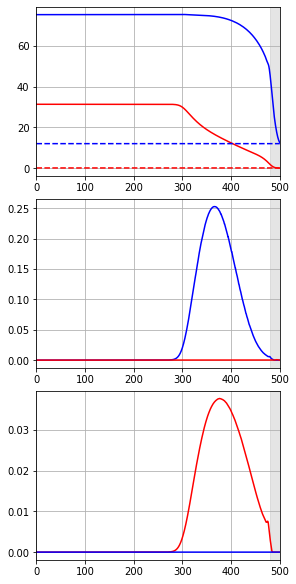

-------  5 0.4000000000000001 0.40000000000000013
--------------- k  0
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  446.9640327387887
RUN  0 , total integrated cost =  446.9640327387887
Gradient descend method:  None
RUN  1 , total integrated cost =  443.58205841087647
RUN  2 , total integrated cost =  441.9904990282055
RUN  3 , total integrated cost =  440.5294886758822
RUN  4 , total integrated cost =  439.5891851250268
RUN  5 , total integrated cost =  438.66765094691146
RUN  6 , total integrated cost =  438.0369508653368
RUN  7 , total integrated cost =  437.25956809082425
RUN  8 , total integrated cost =  436.64945666724674
RUN  9 , total integrated cost =  435.90928350051854
RUN  10 , total integrated cost =  435.35527809313373
RUN  11 , total integrated cost =  434.66594689116846
RUN  12 , total integrated cost =  434.1012242104015
RUN  13 , total integrated cost =  433.39753944517423
RUN  14 , total integrated cost =  432.82623419788104

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  364.5672886813546
RUN  100 , total integrated cost =  364.5672886813546
Improved over  100  iterations in  66.9055611960357  seconds by  18.434759403915564  percent.
Problem in initial value trasfer post:  sigmae_f 1.5670166753451071 1.567017823600679
Problem in initial value trasfer post:  tau_exc 20.372613250994334 20.37260485501988
cost splitting :  1.658688973842067 [7.11568909e-19 3.37206322e-02 2.93680212e-03 0.00000000e+00]
--------------- k  1
set cost params:  1.0 44397.517123592384 0.0
interpolate adjoint :  True True True
initial cost =  1629.157756631742
RUN  0 , total integrated cost =  1629.157756631742
Gradient descend method:  None
RUN  1 , total integrated cost =  1625.3021406287248
RUN  2 , total integrated cost =  1611.4133656095196
RUN  3 , total integrated cost =  1610.6648375185034
RUN  4 , total integrated cost =  1610.3678455864758
RUN  5 , total integrated cost =  1610.159379240429
RUN  6 , total integrated cost =  1600.96283

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  1577.8584860654396
RUN  100 , total integrated cost =  1577.8584860654396
Improved over  100  iterations in  75.41997161798645  seconds by  3.1488215525771324  percent.
Problem in initial value trasfer post:  sigmae_f 1.5662445584488818 1.56624498629039
Problem in initial value trasfer post:  tau_exc 20.323616551692442 20.32361335209873
cost splitting :  3.434418318010559 [4.13090705e-19 3.25098067e-02 2.95217790e-03 0.00000000e+00]
--------------- k  2
set cost params:  1.0 81226.58112975229 0.0
interpolate adjoint :  True True True
initial cost =  2883.890186047527
RUN  0 , total integrated cost =  2883.890186047527
Gradient descend method:  None
RUN  1 , total integrated cost =  2883.4256180542693
RUN  2 , total integrated cost =  2883.416913603835
RUN  3 , total integrated cost =  2883.4056982759935
RUN  4 , total integrated cost =  2883.395080248027
RUN  5 , total integrated cost =  2883.379721788621
RUN  6 , total integrated cost =  2883.369810

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  137 , total integrated cost =  2870.759805308766
Improved over  137  iterations in  122.10383805597667  seconds by  0.45530099593553075  percent.
Problem in initial value trasfer post:  sigmae_f 1.5658851187474632 1.5658853514693738
Problem in initial value trasfer post:  tau_exc 20.31206269197802 20.31206094146618
cost splitting :  4.437593113770841 [1.46405607e-19 3.23334672e-02 2.95564411e-03 0.00000000e+00]
--------------- k  3
set cost params:  1.0 117414.59263546763 0.0
interpolate adjoint :  True True True
initial cost =  4147.802571991051
RUN  0 , total integrated cost =  4147.802571991051
Gradient descend method:  None
RUN  1 , total integrated cost =  4147.388034358953
RUN  2 , total integrated cost =  4147.383109304987
RUN  3 , total integrated cost =  4147.373010506938
RUN  4 , total integrated cost =  4147.363263882816
RUN  5 , total integrated cost =  4147.321535928457
RUN  6 , total integrated cost =  4147.270551153137
RUN  7 , total

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  72 , total integrated cost =  4142.905174480313
Improved over  72  iterations in  65.2776765950257  seconds by  0.11807209783341932  percent.
Problem in initial value trasfer post:  sigmae_f 1.5653063083859833 1.565306495430842
Problem in initial value trasfer post:  tau_exc 20.30435660664495 20.304355192817688
cost splitting :  6.043608932506361 [1.44166646e-19 3.22784041e-02 2.95563667e-03 0.00000000e+00]
--------------- k  4
set cost params:  1.0 153475.6451307752 0.0
interpolate adjoint :  True True True
initial cost =  5413.48176949376
RUN  0 , total integrated cost =  5413.48176949376
Gradient descend method:  None
RUN  1 , total integrated cost =  5413.157445972106
RUN  2 , total integrated cost =  5413.153448920062
RUN  3 , total integrated cost =  5413.1412864049325
RUN  4 , total integrated cost =  5413.134712477209
RUN  5 , total integrated cost =  5412.887510362905
RUN  6 , total integrated cost =  5412.66012019242
RUN  7 , total integr

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  18 , total integrated cost =  5402.06882636845
Control only changes marginally.
RUN  18 , total integrated cost =  5402.06882636845
Improved over  18  iterations in  17.228801900986582  seconds by  0.21082444924124388  percent.
Problem in initial value trasfer post:  sigmae_f 1.5649387726409132 1.5649388951528997
Problem in initial value trasfer post:  tau_exc 20.297978977792447 20.29797804832182
cost splitting :  7.223983492097649 [6.76205978e-20 3.22087668e-02 2.94387461e-03 0.00000000e+00]
--------------- k  5
set cost params:  1.0 189784.60294180142 0.0
interpolate adjoint :  True True True
initial cost =  6678.424601300887
RUN  0 , total integrated cost =  6678.424601300887
Gradient descend method:  None
RUN  1 , total integrated cost =  6678.221628676583
RUN  2 , total integrated cost =  6678.178392034529
RUN  3 , total integrated cost =  6678.131644769576


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  6678.129060525682
Control only changes marginally.
RUN  4 , total integrated cost =  6678.129060525682
Improved over  4  iterations in  4.408446811954491  seconds by  0.004425306757937619  percent.
Problem in initial value trasfer post:  sigmae_f 1.5644441959152746 1.5644443172840194
Problem in initial value trasfer post:  tau_exc 20.293947519265732 20.29394659557387
cost splitting :  8.780970155558364 [6.76270737e-20 3.21989058e-02 2.94398056e-03 0.00000000e+00]
--------------- k  6
set cost params:  1.0 225818.94947351312 0.0
interpolate adjoint :  True True True
initial cost =  7944.480007077562
RUN  0 , total integrated cost =  7944.480007077562
Gradient descend method:  None
RUN  1 , total integrated cost =  7944.289694411869
RUN  2 , total integrated cost =  7944.284154773272
RUN  3 , total integrated cost =  7944.272460619334
RUN  4 , total integrated cost =  7944.268560733647
RUN  5 , total integrated cost =  7944.254817059083
RUN  6 , total in

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  16 , total integrated cost =  7943.763945450544
Control only changes marginally.
RUN  16 , total integrated cost =  7943.763945450544
Improved over  16  iterations in  15.112455329974182  seconds by  0.009013322789911626  percent.
Problem in initial value trasfer post:  sigmae_f 1.56395579212432 1.563955910710605
Problem in initial value trasfer post:  tau_exc 20.29028820616356 20.290287300963563
cost splitting :  10.481045728697097 [6.72243928e-20 3.21872749e-02 2.94507544e-03 0.00000000e+00]
--------------- k  7
set cost params:  1.0 261877.80689062478 0.0
interpolate adjoint :  True True True
initial cost =  9210.596357700508
RUN  0 , total integrated cost =  9210.596357700508
Gradient descend method:  None
RUN  1 , total integrated cost =  9210.421385408226
RUN  2 , total integrated cost =  9210.41440952025
RUN  3 , total integrated cost =  9210.401713864005


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  9210.397096985473
Control only changes marginally.
RUN  4 , total integrated cost =  9210.397096985473
Improved over  4  iterations in  4.705514084082097  seconds by  0.002163385597370393  percent.
Problem in initial value trasfer post:  sigmae_f 1.563443670455817 1.5634437876983542
Problem in initial value trasfer post:  tau_exc 20.28679890599641 20.286798008387485
cost splitting :  12.413612662164866 [6.71685125e-20 3.21793222e-02 2.94514546e-03 0.00000000e+00]
--------------- k  8
set cost params:  1.0 297935.0400663787 0.0
interpolate adjoint :  True True True
initial cost =  10476.888218767313
RUN  0 , total integrated cost =  10476.888218767313
Gradient descend method:  None
RUN  1 , total integrated cost =  10476.750316364574
RUN  2 , total integrated cost =  10476.741008744137
RUN  3 , total integrated cost =  10476.727164993934


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  10476.720586766145
Control only changes marginally.
RUN  4 , total integrated cost =  10476.720586766145
Improved over  4  iterations in  4.592469008057378  seconds by  0.0016000170820547055  percent.
Problem in initial value trasfer post:  sigmae_f 1.5630169021944798 1.5630170182198466
Problem in initial value trasfer post:  tau_exc 20.2840489699498 20.284048079510846
cost splitting :  14.147141972953648 [6.71210821e-20 3.21732908e-02 2.94507248e-03 0.00000000e+00]
--------------- k  9
set cost params:  1.0 333991.4579382821 0.0
interpolate adjoint :  True True True
initial cost =  11742.96296897194
RUN  0 , total integrated cost =  11742.96296897194
Gradient descend method:  None
RUN  1 , total integrated cost =  11742.837687326464
RUN  2 , total integrated cost =  11742.823764230146
RUN  3 , total integrated cost =  11742.805882237091
RUN  4 , total integrated cost =  11742.800044356842
RUN  5 , total integrated cost =  11742.78069771696


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  11742.769309301702
Control only changes marginally.
RUN  6 , total integrated cost =  11742.769309301702
Improved over  6  iterations in  6.125418541021645  seconds by  0.0016491550790931342  percent.
Problem in initial value trasfer post:  sigmae_f 1.5625841894726915 1.5625843040041112
Problem in initial value trasfer post:  tau_exc 20.28138695905864 20.281386077973295
cost splitting :  16.12731272329871 [6.69637196e-20 3.21675233e-02 2.94494890e-03 0.00000000e+00]
--------------- k  10
set cost params:  1.0 370056.5639746319 0.0
interpolate adjoint :  True True True
initial cost =  13009.10434133603
RUN  0 , total integrated cost =  13009.10434133603
Gradient descend method:  None
RUN  1 , total integrated cost =  13008.994218618705
RUN  2 , total integrated cost =  13008.988078210688
RUN  3 , total integrated cost =  13008.966946416656
RUN  4 , total integrated cost =  13008.956021757158
RUN  5 , total integrated cost =  13008.411104253357
RUN  6 , 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  18 , total integrated cost =  13005.765819494329
Control only changes marginally.
RUN  18 , total integrated cost =  13005.765819494329
Improved over  18  iterations in  15.832899729022756  seconds by  0.02566296459851003  percent.
Problem in initial value trasfer post:  sigmae_f 1.562279878228175 1.562279974355326
Problem in initial value trasfer post:  tau_exc 20.278984304469994 20.278983563841727
cost splitting :  17.290938169765713 [5.77248568e-20 3.21523695e-02 2.94756488e-03 0.00000000e+00]
--------------- k  11
set cost params:  1.0 406210.4768547213 0.0
interpolate adjoint :  True True True
initial cost =  14274.76578787053
RUN  0 , total integrated cost =  14274.76578787053
Gradient descend method:  None
RUN  1 , total integrated cost =  14274.64347885225
RUN  2 , total integrated cost =  14274.637123425704
RUN  3 , total integrated cost =  14274.616290507201
RUN  4 , total integrated cost =  14274.603646430685
RUN  5 , total integrated cost =  14274.301839559292
RUN  6 ,

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  14 , total integrated cost =  14273.714344095184
Control only changes marginally.
RUN  14 , total integrated cost =  14273.714344095184
Improved over  14  iterations in  13.295260110986419  seconds by  0.007365751501424711  percent.
Problem in initial value trasfer post:  sigmae_f 1.561904962655004 1.5619050550995257
Problem in initial value trasfer post:  tau_exc 20.2760314016244 20.27603068834332
cost splitting :  18.899275783905857 [5.76510619e-20 3.21404407e-02 2.95281998e-03 0.00000000e+00]
--------------- k  12
set cost params:  1.0 442315.6465056546 0.0
interpolate adjoint :  True True True
initial cost =  15540.762472746665
RUN  0 , total integrated cost =  15540.762472746665
Gradient descend method:  None
RUN  1 , total integrated cost =  15540.639951904186
RUN  2 , total integrated cost =  15540.631252711397
RUN  3 , total integrated cost =  15540.612087665962


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  15540.605504443287
Control only changes marginally.
RUN  4 , total integrated cost =  15540.605504443287
Improved over  4  iterations in  4.567535026930273  seconds by  0.0010100424844239342  percent.
Problem in initial value trasfer post:  sigmae_f 1.5614805934646911 1.5614806849123326
Problem in initial value trasfer post:  tau_exc 20.27321159353994 20.273210886890592
cost splitting :  20.961320802251105 [5.75765604e-20 3.21356447e-02 2.95284536e-03 0.00000000e+00]
--------------- k  13
set cost params:  1.0 478406.5093110895 0.0
interpolate adjoint :  True True True
initial cost =  16806.979383517428
RUN  0 , total integrated cost =  16806.979383517428
Gradient descend method:  None
RUN  1 , total integrated cost =  16806.87915381688
RUN  2 , total integrated cost =  16806.868614436546
RUN  3 , total integrated cost =  16806.84815723434


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  16806.84230666972
Control only changes marginally.
RUN  4 , total integrated cost =  16806.84230666972
Improved over  4  iterations in  4.610330688068643  seconds by  0.0008155947870136515  percent.
Problem in initial value trasfer post:  sigmae_f 1.5611149553308903 1.5611150458835061
Problem in initial value trasfer post:  tau_exc 20.270819768265486 20.270819067633138
cost splitting :  22.77823656870496 [5.74977937e-20 3.21316909e-02 2.95286413e-03 0.00000000e+00]
--------------- k  14
set cost params:  1.0 514494.9652629667 0.0
interpolate adjoint :  True True True
initial cost =  18072.98972536844
RUN  0 , total integrated cost =  18072.98972536844
Gradient descend method:  None
RUN  1 , total integrated cost =  18072.90132807958
RUN  2 , total integrated cost =  18072.894871497974
RUN  3 , total integrated cost =  18072.878912447133


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  18072.87174639971
Control only changes marginally.
RUN  4 , total integrated cost =  18072.87174639971
Improved over  4  iterations in  5.153620889992453  seconds by  0.0006527916549714519  percent.
Problem in initial value trasfer post:  sigmae_f 1.5607564275909116 1.5607565172946343
Problem in initial value trasfer post:  tau_exc 20.268491507797574 20.268490812861632
cost splitting :  24.355691327864704 [5.74177031e-20 3.21283472e-02 2.95251837e-03 0.00000000e+00]
--------------- k  15
set cost params:  1.0 550587.7332114796 0.0
interpolate adjoint :  True True True
initial cost =  19339.03728614147
RUN  0 , total integrated cost =  19339.03728614147
Gradient descend method:  None
RUN  1 , total integrated cost =  19338.96127447512
RUN  2 , total integrated cost =  19338.95045775986
RUN  3 , total integrated cost =  19338.92435965928


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  19338.913346006415
Control only changes marginally.
RUN  4 , total integrated cost =  19338.913346006415
Improved over  4  iterations in  5.083241018932313  seconds by  0.0006408805837736509  percent.
Problem in initial value trasfer post:  sigmae_f 1.560446352149693 1.5604464410179963
Problem in initial value trasfer post:  tau_exc 20.266489297262666 20.26648860805281
cost splitting :  26.406811551456137 [5.73213538e-20 3.21251970e-02 2.95254250e-03 0.00000000e+00]
--------------- k  16
set cost params:  1.0 586675.7645088967 0.0
interpolate adjoint :  True True True
initial cost =  20604.799907350713
RUN  0 , total integrated cost =  20604.799907350713
Gradient descend method:  None
RUN  1 , total integrated cost =  20604.71424125138
RUN  2 , total integrated cost =  20604.706758144956
RUN  3 , total integrated cost =  20604.680417331718


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  20604.67010411643
Control only changes marginally.
RUN  4 , total integrated cost =  20604.67010411643
Improved over  4  iterations in  5.278784550959244  seconds by  0.0006299660024211562  percent.
Problem in initial value trasfer post:  sigmae_f 1.5600956996077544 1.5600957875734065
Problem in initial value trasfer post:  tau_exc 20.264224624886328 20.264223941840804
cost splitting :  28.14683286341442 [5.72102438e-20 3.21221287e-02 2.95220771e-03 0.00000000e+00]
--------------- k  17
set cost params:  1.0 622775.4391907406 0.0
interpolate adjoint :  True True True
initial cost =  21870.842237779874
RUN  0 , total integrated cost =  21870.842237779874
Gradient descend method:  None
RUN  1 , total integrated cost =  21870.76638185718
RUN  2 , total integrated cost =  21870.755124600793
RUN  3 , total integrated cost =  21870.72869881428


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  21870.719402623505
Control only changes marginally.
RUN  4 , total integrated cost =  21870.719402623505
Improved over  4  iterations in  4.937102777999826  seconds by  0.0005616388936147132  percent.
Problem in initial value trasfer post:  sigmae_f 1.5597842162115316 1.5597843033449648
Problem in initial value trasfer post:  tau_exc 20.26221042789974 20.262209750579302
cost splitting :  29.752679235097094 [5.71496290e-20 3.21195801e-02 2.95181352e-03 0.00000000e+00]
--------------- k  18
set cost params:  1.0 658873.2942485802 0.0
interpolate adjoint :  True True True
initial cost =  23136.72148496973
RUN  0 , total integrated cost =  23136.72148496973
Gradient descend method:  None
RUN  1 , total integrated cost =  23136.641630776572
RUN  2 , total integrated cost =  23136.625824568924
RUN  3 , total integrated cost =  23136.601611815968
RUN  4 , total integrated cost =  23136.5872052227
RUN  5 , total integrated cost =  23135.63618953425
RUN  6 , to

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  14 , total integrated cost =  23134.62903843291
Control only changes marginally.
RUN  14 , total integrated cost =  23134.62903843291
Improved over  14  iterations in  14.028831850970164  seconds by  0.009043833363236331  percent.
Problem in initial value trasfer post:  sigmae_f 1.5595198014093121 1.559519880522203
Problem in initial value trasfer post:  tau_exc 20.260482956537295 20.260482340992162
cost splitting :  31.415133363885836 [5.69281370e-20 3.21143046e-02 2.95164901e-03 0.00000000e+00]
--------------- k  19
set cost params:  1.0 695024.9217386829 0.0
interpolate adjoint :  True True True
initial cost =  24402.320331930943
RUN  0 , total integrated cost =  24402.320331930943
Gradient descend method:  None
RUN  1 , total integrated cost =  24402.231897864975
RUN  2 , total integrated cost =  24402.218703400606
RUN  3 , total integrated cost =  24402.187509332136


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  24402.175858459465
Control only changes marginally.
RUN  4 , total integrated cost =  24402.175858459465
Improved over  4  iterations in  5.195031127892435  seconds by  0.0005920480901551173  percent.
Problem in initial value trasfer post:  sigmae_f 1.559187186938075 1.5591872652282854
Problem in initial value trasfer post:  tau_exc 20.258310458092886 20.258309848236728
cost splitting :  33.6210867419363 [5.68559578e-20 3.21114211e-02 2.95155058e-03 0.00000000e+00]
--------------- k  20
set cost params:  1.0 731133.0472104093 0.0
interpolate adjoint :  True True True
initial cost =  25668.23403961456
RUN  0 , total integrated cost =  25668.23403961456
Gradient descend method:  None
RUN  1 , total integrated cost =  25668.149490943382
RUN  2 , total integrated cost =  25668.139710719654
RUN  3 , total integrated cost =  25668.09757896667


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  25668.075477207414
Control only changes marginally.
RUN  4 , total integrated cost =  25668.075477207414
Improved over  4  iterations in  5.329347062041052  seconds by  0.0006177378891720764  percent.
Problem in initial value trasfer post:  sigmae_f 1.558815885712113 1.5588159630537735
Problem in initial value trasfer post:  tau_exc 20.255859476297946 20.255858873040673
cost splitting :  36.00072179892757 [5.68002951e-20 3.21082594e-02 2.95146202e-03 0.00000000e+00]
--------------- k  21
set cost params:  1.0 767250.8458024043 0.0
interpolate adjoint :  True True True
initial cost =  26934.355432916665
RUN  0 , total integrated cost =  26934.355432916665
Gradient descend method:  None
RUN  1 , total integrated cost =  26934.295617794578


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  26934.28609587317
Control only changes marginally.
RUN  2 , total integrated cost =  26934.28609587317
Improved over  2  iterations in  2.7985408160602674  seconds by  0.0002574297486717114  percent.
Problem in initial value trasfer post:  sigmae_f 1.5586150225835314 1.5586150994828463
Problem in initial value trasfer post:  tau_exc 20.254519597740952 20.254518997506484
cost splitting :  36.83123333905295 [5.67606890e-20 3.21067284e-02 2.95130003e-03 0.00000000e+00]
--------------- k  22
set cost params:  1.0 803348.3798168134 0.0
interpolate adjoint :  True True True
initial cost =  28199.79446886868
RUN  0 , total integrated cost =  28199.79446886868
Gradient descend method:  None
RUN  1 , total integrated cost =  28199.709410777778


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  28199.700050134183
Control only changes marginally.
RUN  2 , total integrated cost =  28199.700050134183
Improved over  2  iterations in  2.6491804129909724  seconds by  0.00033482064772272224  percent.
Problem in initial value trasfer post:  sigmae_f 1.55834581016806 1.558345886495593
Problem in initial value trasfer post:  tau_exc 20.252704122643838 20.252703526300362
cost splitting :  38.59912584313334 [5.67203362e-20 3.21047122e-02 2.95109366e-03 0.00000000e+00]
--------------- k  23
set cost params:  1.0 839455.3510415822 0.0
interpolate adjoint :  True True True
initial cost =  29465.459025063756
RUN  0 , total integrated cost =  29465.459025063756
Gradient descend method:  None
RUN  1 , total integrated cost =  29465.37392830971


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  29465.364742558664
Control only changes marginally.
RUN  2 , total integrated cost =  29465.364742558664
Improved over  2  iterations in  2.705279811983928  seconds by  0.00031997636627068005  percent.
Problem in initial value trasfer post:  sigmae_f 1.5580561984658656 1.5580562741892285
Problem in initial value trasfer post:  tau_exc 20.250738316185643 20.250737723949516
cost splitting :  40.46125881018226 [5.66838881e-20 3.21025900e-02 2.95087977e-03 0.00000000e+00]
--------------- k  24
set cost params:  1.0 875568.0742134948 0.0
interpolate adjoint :  True True True
initial cost =  30731.240991059618
RUN  0 , total integrated cost =  30731.240991059618
Gradient descend method:  None
RUN  1 , total integrated cost =  30731.1642246509


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  30731.15348017675
Control only changes marginally.
RUN  2 , total integrated cost =  30731.15348017675
Improved over  2  iterations in  2.7290781509364024  seconds by  0.0002847619557400094  percent.
Problem in initial value trasfer post:  sigmae_f 1.557785993439809 1.557786068590014
Problem in initial value trasfer post:  tau_exc 20.248890593516023 20.24889000519242
cost splitting :  42.26539594465469 [5.66471104e-20 3.21006487e-02 2.95068182e-03 0.00000000e+00]
--------------- k  25
set cost params:  1.0 911679.8953247896 0.0
interpolate adjoint :  True True True
initial cost =  31996.92085609401
RUN  0 , total integrated cost =  31996.92085609401
Gradient descend method:  None
RUN  1 , total integrated cost =  31996.845897631516


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  31996.83373206908
Control only changes marginally.
RUN  2 , total integrated cost =  31996.83373206908
Improved over  2  iterations in  2.7014727720525116  seconds by  0.0002722887784187833  percent.
Problem in initial value trasfer post:  sigmae_f 1.557514850855116 1.5575149254256508
Problem in initial value trasfer post:  tau_exc 20.24702071280351 20.247020128447357
cost splitting :  44.11896359776938 [5.66100390e-20 3.20987367e-02 2.95048589e-03 0.00000000e+00]
--------------- k  26
set cost params:  1.0 947793.8984212832 0.0
interpolate adjoint :  True True True
initial cost =  33262.60146600935
RUN  0 , total integrated cost =  33262.60146600935
Gradient descend method:  None
RUN  1 , total integrated cost =  33262.52949440662
RUN  2 , total integrated cost =  33262.51637166667
RUN  3 , total integrated cost =  33262.4721382605


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  33262.44698887983
Control only changes marginally.
RUN  4 , total integrated cost =  33262.44698887983
Improved over  4  iterations in  5.2639069869183  seconds by  0.0004644168607228494  percent.
Problem in initial value trasfer post:  sigmae_f 1.5572138649248817 1.5572139386682915
Problem in initial value trasfer post:  tau_exc 20.244923051896578 20.244922473391867
cost splitting :  46.77012595826419 [5.65619062e-20 3.20964111e-02 2.95044739e-03 0.00000000e+00]
--------------- k  27
set cost params:  1.0 983912.1954847226 0.0
interpolate adjoint :  True True True
initial cost =  34528.27983618833
RUN  0 , total integrated cost =  34528.27983618833
Gradient descend method:  None
RUN  1 , total integrated cost =  34528.21988414029
RUN  2 , total integrated cost =  34528.208495015104
RUN  3 , total integrated cost =  34528.169863839226


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  34528.15076721704
Control only changes marginally.
RUN  4 , total integrated cost =  34528.15076721704
Improved over  4  iterations in  5.067247690050863  seconds by  0.0003738065490210829  percent.
Problem in initial value trasfer post:  sigmae_f 1.5569639331063616 1.5569640061591774
Problem in initial value trasfer post:  tau_exc 20.243161139310452 20.243160565701615
cost splitting :  48.432943906165924 [5.64676124e-20 3.20946953e-02 2.95023029e-03 0.00000000e+00]
--------------- k  28
set cost params:  1.0 1020029.299654604 0.0
interpolate adjoint :  True True True
initial cost =  35793.87199690092
RUN  0 , total integrated cost =  35793.87199690092
Gradient descend method:  None
RUN  1 , total integrated cost =  35793.80934983457


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  35793.797184036164
Control only changes marginally.
RUN  2 , total integrated cost =  35793.797184036164
Improved over  2  iterations in  2.757103114039637  seconds by  0.000209010259524689  percent.
Problem in initial value trasfer post:  sigmae_f 1.5567803146714208 1.5567803872954173
Problem in initial value trasfer post:  tau_exc 20.241851465637488 20.24185089501224
cost splitting :  49.42650113793557 [5.64322183e-20 3.20934587e-02 2.95009400e-03 0.00000000e+00]
--------------- k  29
set cost params:  1.0 1056138.2250047238 0.0
interpolate adjoint :  True True True
initial cost =  37059.18221194808
RUN  0 , total integrated cost =  37059.18221194808
Gradient descend method:  None
RUN  1 , total integrated cost =  37059.09453021108
RUN  2 , total integrated cost =  37059.07668009246
RUN  3 , total integrated cost =  37059.0407168181


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  37059.02743650036
Control only changes marginally.
RUN  4 , total integrated cost =  37059.02743650036
Improved over  4  iterations in  5.517502935952507  seconds by  0.00041764399126975604  percent.
Problem in initial value trasfer post:  sigmae_f 1.5564777841651305 1.5564778560120278
Problem in initial value trasfer post:  tau_exc 20.239679723325466 20.239679158178518
cost splitting :  51.83049503849529 [5.63530723e-20 3.20914455e-02 2.94985450e-03 0.00000000e+00]
--------------- k  30
set cost params:  1.0 1092264.5923027128 0.0
interpolate adjoint :  True True True
initial cost =  38324.94231180984
RUN  0 , total integrated cost =  38324.94231180984
Gradient descend method:  None
RUN  1 , total integrated cost =  38324.87087408908
RUN  2 , total integrated cost =  38324.85744054665
RUN  3 , total integrated cost =  38324.81445668375


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  38324.798191061316
Control only changes marginally.
RUN  4 , total integrated cost =  38324.798191061316
Improved over  4  iterations in  5.491222504992038  seconds by  0.00037604948587954823  percent.
Problem in initial value trasfer post:  sigmae_f 1.5561982574316993 1.5561983285357588
Problem in initial value trasfer post:  tau_exc 20.23764729574137 20.23764673585955
cost splitting :  53.98613433396299 [5.62755652e-20 3.20896142e-02 2.94963043e-03 0.00000000e+00]
--------------- k  31
set cost params:  1.0 1128390.1299404658 0.0
interpolate adjoint :  True True True
initial cost =  39590.609739914995
RUN  0 , total integrated cost =  39590.609739914995
Gradient descend method:  None
RUN  1 , total integrated cost =  39590.54596998962
RUN  2 , total integrated cost =  39590.533303713855
RUN  3 , total integrated cost =  39590.4771495911


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  39590.44958258529
Control only changes marginally.
RUN  4 , total integrated cost =  39590.44958258529
Improved over  4  iterations in  4.7636043259408325  seconds by  0.00040453362744585775  percent.
Problem in initial value trasfer post:  sigmae_f 1.5559222879049008 1.5559223582104276
Problem in initial value trasfer post:  tau_exc 20.235612902814403 20.235612348651692
cost splitting :  56.52151679633294 [5.62399671e-20 3.20875976e-02 2.94962688e-03 0.00000000e+00]
--------------- k  32
set cost params:  1.0 1164514.0502407865 0.0
interpolate adjoint :  True True True
initial cost =  40856.13148812574
RUN  0 , total integrated cost =  40856.13148812574
Gradient descend method:  None
RUN  1 , total integrated cost =  40856.07409112724


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  40856.06028615427
Control only changes marginally.
RUN  2 , total integrated cost =  40856.06028615427
Improved over  2  iterations in  2.6808899650350213  seconds by  0.00017427487351540094  percent.
Problem in initial value trasfer post:  sigmae_f 1.5557139436554928 1.5557140134939116
Problem in initial value trasfer post:  tau_exc 20.2340569727694 20.23405642185901
cost splitting :  57.62730189661831 [5.62151720e-20 3.20862783e-02 2.94948551e-03 0.00000000e+00]
--------------- k  33
set cost params:  1.0 1200635.1007217793 0.0
interpolate adjoint :  True True True
initial cost =  42121.58888084172
RUN  0 , total integrated cost =  42121.58888084172
Gradient descend method:  None
RUN  1 , total integrated cost =  42121.520310047265


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  42121.51009226353
Control only changes marginally.
RUN  2 , total integrated cost =  42121.51009226353
Improved over  2  iterations in  2.7016878679860383  seconds by  0.0001870503470655649  percent.
Problem in initial value trasfer post:  sigmae_f 1.5555089084463312 1.5555089778229878
Problem in initial value trasfer post:  tau_exc 20.232505382794695 20.23250483510389
cost splitting :  59.17896768462607 [5.61916672e-20 3.20849931e-02 2.94934746e-03 0.00000000e+00]
--------------- k  34
set cost params:  1.0 1236752.9025689422 0.0
interpolate adjoint :  True True True
initial cost =  43386.87346079657
RUN  0 , total integrated cost =  43386.87346079657
Gradient descend method:  None
RUN  1 , total integrated cost =  43386.8007720139


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  43386.78976059237
Control only changes marginally.
RUN  2 , total integrated cost =  43386.78976059237
Improved over  2  iterations in  2.72740812797565  seconds by  0.00019291596171910896  percent.
Problem in initial value trasfer post:  sigmae_f 1.5552642398131278 1.5552643086648998
Problem in initial value trasfer post:  tau_exc 20.23062418435067 20.23062364029827
cost splitting :  61.35150991409884 [5.61723620e-20 3.20834761e-02 2.94919123e-03 0.00000000e+00]
--------------- k  35
set cost params:  1.0 1272875.5922864894 0.0
interpolate adjoint :  True True True
initial cost =  44652.26393076504
RUN  0 , total integrated cost =  44652.26393076504
Gradient descend method:  None
RUN  1 , total integrated cost =  44652.20004556203


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  44652.18626866483
Control only changes marginally.
RUN  2 , total integrated cost =  44652.18626866483
Improved over  2  iterations in  2.7647769829491153  seconds by  0.00017392645607117174  percent.
Problem in initial value trasfer post:  sigmae_f 1.5551010877034581 1.5551011561643016
Problem in initial value trasfer post:  tau_exc 20.229356319319322 20.22935577801891
cost splitting :  62.74385272667942 [5.61515715e-20 3.20824700e-02 2.94907789e-03 0.00000000e+00]
--------------- k  36
set cost params:  1.0 1308987.9237160278 0.0
interpolate adjoint :  True True True
initial cost =  45917.25713748699
RUN  0 , total integrated cost =  45917.25713748699
Gradient descend method:  None
RUN  1 , total integrated cost =  45917.17562981899


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  45917.16089512065
Control only changes marginally.
RUN  2 , total integrated cost =  45917.16089512065
Improved over  2  iterations in  2.8162538249744102  seconds by  0.000209599554366946  percent.
Problem in initial value trasfer post:  sigmae_f 1.5548656453441632 1.5548657132757897
Problem in initial value trasfer post:  tau_exc 20.227500702542457 20.22750016494001
cost splitting :  64.69123282104088 [5.61308611e-20 3.20810340e-02 2.94892462e-03 0.00000000e+00]
--------------- k  37
set cost params:  1.0 1345113.8743731442 0.0
interpolate adjoint :  True True True
initial cost =  47182.651450351914
RUN  0 , total integrated cost =  47182.651450351914
Gradient descend method:  None
RUN  1 , total integrated cost =  47182.57751320194


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  47182.5655191068
Control only changes marginally.
RUN  2 , total integrated cost =  47182.5655191068
Improved over  2  iterations in  2.748224923037924  seconds by  0.00018212466335398858  percent.
Problem in initial value trasfer post:  sigmae_f 1.5546458668526504 1.5546459342963124
Problem in initial value trasfer post:  tau_exc 20.22573568575296 20.225735151556762
cost splitting :  66.62965669725939 [5.61151240e-20 3.20797045e-02 2.94878446e-03 0.00000000e+00]
--------------- k  38
set cost params:  1.0 1381237.3980538284 0.0
interpolate adjoint :  True True True
initial cost =  48447.917969516
RUN  0 , total integrated cost =  48447.917969516
Gradient descend method:  None
RUN  1 , total integrated cost =  48447.84727847865


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  48447.83249818898
Control only changes marginally.
RUN  2 , total integrated cost =  48447.83249818898
Improved over  2  iterations in  2.7101761259837076  seconds by  0.00017641898888598462  percent.
Problem in initial value trasfer post:  sigmae_f 1.5544707015076653 1.5544707685340973
Problem in initial value trasfer post:  tau_exc 20.22431154858963 20.224311017334884
cost splitting :  68.2024679137545 [5.60993261e-20 3.20786505e-02 2.94866690e-03 0.00000000e+00]
--------------- k  39
set cost params:  1.0 1417354.915748609 0.0
interpolate adjoint :  True True True
initial cost =  49712.932254121886
RUN  0 , total integrated cost =  49712.932254121886
Gradient descend method:  None
RUN  1 , total integrated cost =  49712.84926295198


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  49712.83393369691
Control only changes marginally.
RUN  2 , total integrated cost =  49712.83393369691
Improved over  2  iterations in  2.6932026490103453  seconds by  0.00019777635419870876  percent.
Problem in initial value trasfer post:  sigmae_f 1.554272203037885 1.5542722695901328
Problem in initial value trasfer post:  tau_exc 20.222674833020694 20.22267430511238
cost splitting :  70.19361035294574 [5.60836454e-20 3.20774647e-02 2.94853449e-03 0.00000000e+00]
--------------- k  40
set cost params:  1.0 1453475.2416478682 0.0
interpolate adjoint :  True True True
initial cost =  50977.98443908478
RUN  0 , total integrated cost =  50977.98443908478
Gradient descend method:  None
RUN  1 , total integrated cost =  50977.897600929944


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  50977.88242041316
Control only changes marginally.
RUN  2 , total integrated cost =  50977.88242041316
Improved over  2  iterations in  2.303865951951593  seconds by  0.00020012299964378144  percent.
Problem in initial value trasfer post:  sigmae_f 1.5540401859704378 1.5540402519985472
Problem in initial value trasfer post:  tau_exc 20.220723354902216 20.220722830668453
cost splitting :  72.34900573586847 [5.60720401e-20 3.20760892e-02 2.94838826e-03 0.00000000e+00]
--------------- k  41
set cost params:  1.0 1489603.857503508 0.0
interpolate adjoint :  True True True
initial cost =  52243.26831024398
RUN  0 , total integrated cost =  52243.26831024398
Gradient descend method:  None
RUN  1 , total integrated cost =  52243.19197637677


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  52243.17573963381
Control only changes marginally.
RUN  2 , total integrated cost =  52243.17573963381
Improved over  2  iterations in  2.2995576970279217  seconds by  0.00017719146056549562  percent.
Problem in initial value trasfer post:  sigmae_f 1.5538352828241182 1.553835348379363
Problem in initial value trasfer post:  tau_exc 20.21897137278463 20.218970851877696
cost splitting :  74.1121743894651 [5.60627953e-20 3.20748820e-02 2.94825793e-03 0.00000000e+00]
--------------- k  42
set cost params:  1.0 1525731.0981713624 0.0
interpolate adjoint :  True True True
initial cost =  53508.46514303658
RUN  0 , total integrated cost =  53508.46514303658
Gradient descend method:  None
RUN  1 , total integrated cost =  53508.3872099832


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  53508.37314018427
Control only changes marginally.
RUN  2 , total integrated cost =  53508.37314018427
Improved over  2  iterations in  1.9397437500301749  seconds by  0.0001719407425753161  percent.
Problem in initial value trasfer post:  sigmae_f 1.5536570265921108 1.553657091711453
Problem in initial value trasfer post:  tau_exc 20.217425350457756 20.217424832642077
cost splitting :  75.96086296601874 [5.60550434e-20 3.20738366e-02 2.94813962e-03 0.00000000e+00]
--------------- k  43
set cost params:  1.0 1561851.3235257133 0.0
interpolate adjoint :  True True True
initial cost =  54773.3748132584
RUN  0 , total integrated cost =  54773.3748132584
Gradient descend method:  None
RUN  1 , total integrated cost =  54773.28972423421


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  54773.26930801682
Control only changes marginally.
RUN  2 , total integrated cost =  54773.26930801682
Improved over  2  iterations in  2.1188238030299544  seconds by  0.00019262140035891662  percent.
Problem in initial value trasfer post:  sigmae_f 1.5534236346304011 1.5534236992144144
Problem in initial value trasfer post:  tau_exc 20.215374101955405 20.21537358790914
cost splitting :  78.42513282153463 [5.60501536e-20 3.20724820e-02 2.94799426e-03 0.00000000e+00]
--------------- k  44
set cost params:  1.0 1597980.4583737382 0.0
interpolate adjoint :  True True True
initial cost =  56038.528816175516
RUN  0 , total integrated cost =  56038.528816175516
Gradient descend method:  None
RUN  1 , total integrated cost =  56038.45441088113


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  56038.43845140091
Control only changes marginally.
RUN  2 , total integrated cost =  56038.43845140091
Improved over  2  iterations in  2.4693233650177717  seconds by  0.00016125472333783364  percent.
Problem in initial value trasfer post:  sigmae_f 1.553199699410613 1.5531997634902124
Problem in initial value trasfer post:  tau_exc 20.213381702453006 20.213381191954113
cost splitting :  79.9378860231059 [5.60475004e-20 3.20711952e-02 2.94785819e-03 0.00000000e+00]
--------------- k  45
set cost params:  1.0 1634119.9293486858 0.0
interpolate adjoint :  True True True
initial cost =  57304.00851458507
RUN  0 , total integrated cost =  57304.00851458507
Gradient descend method:  None
RUN  1 , total integrated cost =  57303.937880933525


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  57303.92310082601
Control only changes marginally.
RUN  2 , total integrated cost =  57303.92310082601
Improved over  2  iterations in  2.4329179590567946  seconds by  0.00014905372464113498  percent.
Problem in initial value trasfer post:  sigmae_f 1.5530486543028998 1.55304871799521
Problem in initial value trasfer post:  tau_exc 20.212019550837084 20.212019043107738
cost splitting :  82.13753370774522 [5.60491924e-20 3.20703287e-02 2.94775605e-03 0.00000000e+00]
--------------- k  46
set cost params:  1.0 1670230.864422316 0.0
interpolate adjoint :  True True True
initial cost =  58568.45888415442
RUN  0 , total integrated cost =  58568.45888415442
Gradient descend method:  None
RUN  1 , total integrated cost =  58568.37734567121


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  58568.356228764795
Control only changes marginally.
RUN  2 , total integrated cost =  58568.356228764795
Improved over  2  iterations in  2.8211251909378916  seconds by  0.00017527418609120105  percent.
Problem in initial value trasfer post:  sigmae_f 1.552873755897325 1.5528738191552556
Problem in initial value trasfer post:  tau_exc 20.210426692961093 20.210426188329066
cost splitting :  83.86510660864182 [5.60558010e-20 3.20693323e-02 2.94764167e-03 0.00000000e+00]
--------------- k  47
set cost params:  1.0 1706355.7819789532 0.0
interpolate adjoint :  True True True
initial cost =  59833.34152822463
RUN  0 , total integrated cost =  59833.34152822463
Gradient descend method:  None
RUN  1 , total integrated cost =  59833.25275385021


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  59833.236187543655
Control only changes marginally.
RUN  2 , total integrated cost =  59833.236187543655
Improved over  2  iterations in  2.7963496220763773  seconds by  0.00017605682430144043  percent.
Problem in initial value trasfer post:  sigmae_f 1.5526629697700134 1.552663032531703
Problem in initial value trasfer post:  tau_exc 20.208211855763576 20.208211354512684
cost splitting :  85.9547510949687 [5.60658067e-20 3.20681430e-02 2.94751102e-03 0.00000000e+00]
--------------- k  48
set cost params:  1.0 1742487.4315120126 0.0
interpolate adjoint :  True True True
initial cost =  61098.40952740024
RUN  0 , total integrated cost =  61098.40952740024
Gradient descend method:  None
RUN  1 , total integrated cost =  61098.327526317946
RUN  2 , total integrated cost =  61098.30053651993
RUN  3 , total integrated cost =  61098.22903720492


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  61098.193542803936
Control only changes marginally.
RUN  4 , total integrated cost =  61098.193542803936
Improved over  4  iterations in  5.42631284694653  seconds by  0.00035350281287094276  percent.
Problem in initial value trasfer post:  sigmae_f 1.5524292632288614 1.5524293252555297
Problem in initial value trasfer post:  tau_exc 20.20553127380185 20.205530777690132
cost splitting :  89.33792461901221 [5.60997109e-20 3.20666077e-02 2.94753239e-03 0.00000000e+00]
--------------- k  49
set cost params:  1.0 1778612.3408750356 0.0
interpolate adjoint :  True True True
initial cost =  62363.07618083635
RUN  0 , total integrated cost =  62363.07618083635
Gradient descend method:  None
RUN  1 , total integrated cost =  62363.00350817926


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  62362.98708945721
Control only changes marginally.
RUN  2 , total integrated cost =  62362.98708945721
Improved over  2  iterations in  2.95213817700278  seconds by  0.0001428591798173784  percent.
Problem in initial value trasfer post:  sigmae_f 1.5522379236706676 1.5522379852483028
Problem in initial value trasfer post:  tau_exc 20.20331012925646 20.20330963613713
cost splitting :  90.06617221015841 [5.61176522e-20 3.20655425e-02 2.94741478e-03 0.00000000e+00]
--------------- k  50
set cost params:  1.0 1814759.2490808086 0.0
interpolate adjoint :  True True True
initial cost =  63628.59724292385
RUN  0 , total integrated cost =  63628.59724292385
Gradient descend method:  None
RUN  1 , total integrated cost =  63628.52554469264


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  63628.5070870216
Control only changes marginally.
RUN  2 , total integrated cost =  63628.5070870216
Improved over  2  iterations in  2.7339036359917372  seconds by  0.00014169085311266372  percent.
Problem in initial value trasfer post:  sigmae_f 1.5520840401064404 1.5520841012963675
Problem in initial value trasfer post:  tau_exc 20.20150223482834 20.201501744331136
cost splitting :  92.33218640758331 [5.61447584e-20 3.20646871e-02 2.94731426e-03 0.00000000e+00]
--------------- k  51
set cost params:  1.0 1850873.8298308717 0.0
interpolate adjoint :  True True True
initial cost =  64892.950836165706
RUN  0 , total integrated cost =  64892.950836165706
Gradient descend method:  None
RUN  1 , total integrated cost =  64892.86711000143


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  64892.848484325616
Control only changes marginally.
RUN  2 , total integrated cost =  64892.848484325616
Improved over  2  iterations in  2.6186298240209  seconds by  0.00015772412685066683  percent.
Problem in initial value trasfer post:  sigmae_f 1.5518865175556922 1.5518865782795102
Problem in initial value trasfer post:  tau_exc 20.19915440976941 20.199153922388838
cost splitting :  94.31637571659991 [5.61734687e-20 3.20635975e-02 2.94719340e-03 0.00000000e+00]
--------------- k  52
set cost params:  1.0 1887006.9573422675 0.0
interpolate adjoint :  True True True
initial cost =  66157.89785765232
RUN  0 , total integrated cost =  66157.89785765232
Gradient descend method:  None
RUN  1 , total integrated cost =  66157.82412309325


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  66157.80795416348
Control only changes marginally.
RUN  2 , total integrated cost =  66157.80795416348
Improved over  2  iterations in  2.653875165968202  seconds by  0.00013589229970989436  percent.
Problem in initial value trasfer post:  sigmae_f 1.5517107287195404 1.5517107890278394
Problem in initial value trasfer post:  tau_exc 20.197040875738843 20.197040391141282
cost splitting :  95.93191347233487 [5.62039804e-20 3.20626330e-02 2.94708620e-03 0.00000000e+00]
--------------- k  53
set cost params:  1.0 1923139.440588047 0.0
interpolate adjoint :  True True True
initial cost =  67422.79604614952
RUN  0 , total integrated cost =  67422.79604614952
Gradient descend method:  None
RUN  1 , total integrated cost =  67422.7249676921


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  67422.70602518771
Control only changes marginally.
RUN  2 , total integrated cost =  67422.70602518771
Improved over  2  iterations in  2.288516095955856  seconds by  0.0001335170996838997  percent.
Problem in initial value trasfer post:  sigmae_f 1.5515612864113686 1.5515613463480746
Problem in initial value trasfer post:  tau_exc 20.19521586250375 20.195215380420876
cost splitting :  97.84499291187826 [5.62417786e-20 3.20618127e-02 2.94699101e-03 0.00000000e+00]
--------------- k  54
set cost params:  1.0 1959259.9058954576 0.0
interpolate adjoint :  True True True
initial cost =  68687.24030391734
RUN  0 , total integrated cost =  68687.24030391734
Gradient descend method:  None
RUN  1 , total integrated cost =  68687.16415890567


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  68687.14598843246
Control only changes marginally.
RUN  2 , total integrated cost =  68687.14598843246
Improved over  2  iterations in  2.7050194909097627  seconds by  0.00013731150714590967  percent.
Problem in initial value trasfer post:  sigmae_f 1.5513859232246168 1.5513859827435015
Problem in initial value trasfer post:  tau_exc 20.19305693871109 20.193056459436626
cost splitting :  99.76855398291995 [5.62813493e-20 3.20608571e-02 2.94688415e-03 0.00000000e+00]
--------------- k  55
set cost params:  1.0 1995389.3632580873 0.0
interpolate adjoint :  True True True
initial cost =  69951.95668340761
RUN  0 , total integrated cost =  69951.95668340761
Gradient descend method:  None
RUN  1 , total integrated cost =  69951.8848989851


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  69951.8638070694
Control only changes marginally.
RUN  2 , total integrated cost =  69951.8638070694
Improved over  2  iterations in  2.679907061974518  seconds by  0.00013277160870472926  percent.
Problem in initial value trasfer post:  sigmae_f 1.5512334315356056 1.5512334906760994
Problem in initial value trasfer post:  tau_exc 20.191148159373004 20.191147682663143
cost splitting :  101.74344356079561 [5.63278830e-20 3.20600258e-02 2.94678794e-03 0.00000000e+00]
--------------- k  56
set cost params:  1.0 2031511.2864582043 0.0
interpolate adjoint :  True True True
initial cost =  71216.37724488339
RUN  0 , total integrated cost =  71216.37724488339
Gradient descend method:  None
RUN  1 , total integrated cost =  71216.30092161188


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  71216.28232136245
Control only changes marginally.
RUN  2 , total integrated cost =  71216.28232136245
Improved over  2  iterations in  2.463000613031909  seconds by  0.0001332888931102616  percent.
Problem in initial value trasfer post:  sigmae_f 1.5510824108328396 1.5510824695966294
Problem in initial value trasfer post:  tau_exc 20.1892426013921 20.189242127241336
cost splitting :  103.58295331467738 [5.63792134e-20 3.20592063e-02 2.94669258e-03 0.00000000e+00]
--------------- k  57
set cost params:  1.0 2067635.4605089605 0.0
interpolate adjoint :  True True True
initial cost =  72480.84150538688
RUN  0 , total integrated cost =  72480.84150538688
Gradient descend method:  None
RUN  1 , total integrated cost =  72480.76465477061


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  72480.74168785178
Control only changes marginally.
RUN  2 , total integrated cost =  72480.74168785178
Improved over  2  iterations in  2.8065368740353733  seconds by  0.00013771575085286258  percent.
Problem in initial value trasfer post:  sigmae_f 1.5509227353326427 1.5509227937034993
Problem in initial value trasfer post:  tau_exc 20.18719620006192 20.18719572857506
cost splitting :  105.52602400738749 [5.64350552e-20 3.20583411e-02 2.94659332e-03 0.00000000e+00]
--------------- k  58
set cost params:  1.0 2103761.735122581 0.0
interpolate adjoint :  True True True
initial cost =  73745.339561862
RUN  0 , total integrated cost =  73745.339561862
Gradient descend method:  None
RUN  1 , total integrated cost =  73745.26118994519


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  73745.24183244327
Control only changes marginally.
RUN  2 , total integrated cost =  73745.24183244327
Improved over  2  iterations in  2.766661190893501  seconds by  0.00013252284051645802  percent.
Problem in initial value trasfer post:  sigmae_f 1.5507668337398715 1.5507668917261066
Problem in initial value trasfer post:  tau_exc 20.18517710765703 20.185176638782
cost splitting :  107.34411590766494 [5.64943494e-20 3.20574994e-02 2.94649653e-03 0.00000000e+00]
--------------- k  59
set cost params:  1.0 2139889.4180949107 0.0
interpolate adjoint :  True True True
initial cost =  75009.8551004859
RUN  0 , total integrated cost =  75009.8551004859
Gradient descend method:  None
RUN  1 , total integrated cost =  75009.77559737884


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  75009.75434286337
Control only changes marginally.
RUN  2 , total integrated cost =  75009.75434286337
Improved over  2  iterations in  2.7150846320437267  seconds by  0.0001343258461190544  percent.
Problem in initial value trasfer post:  sigmae_f 1.550600466337966 1.5506005239197749
Problem in initial value trasfer post:  tau_exc 20.18298816174618 20.182987695611278
cost splitting :  109.26279795483033 [5.65571002e-20 3.20566028e-02 2.94639500e-03 0.00000000e+00]
--------------- k  60
set cost params:  1.0 2176019.9830667255 0.0
interpolate adjoint :  True True True
initial cost =  76274.43242846445
RUN  0 , total integrated cost =  76274.43242846445
Gradient descend method:  None
RUN  1 , total integrated cost =  76274.35671275182


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  76274.33426052565
Control only changes marginally.
RUN  2 , total integrated cost =  76274.33426052565
Improved over  2  iterations in  2.6940246620215476  seconds by  0.0001287035978947415  percent.
Problem in initial value trasfer post:  sigmae_f 1.5504650907682356 1.5504651479992522
Problem in initial value trasfer post:  tau_exc 20.181191125096646 20.181190661370085
cost splitting :  111.30655743229495 [5.66308376e-20 3.20558742e-02 2.94630763e-03 0.00000000e+00]
--------------- k  61
set cost params:  1.0 2212137.844575148 0.0
interpolate adjoint :  True True True
initial cost =  77538.53821547501
RUN  0 , total integrated cost =  77538.53821547501
Gradient descend method:  None
RUN  1 , total integrated cost =  77538.45483385985


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  77538.43326975014
Control only changes marginally.
RUN  2 , total integrated cost =  77538.43326975014
Improved over  2  iterations in  2.8300082109635696  seconds by  0.00013534653514568618  percent.
Problem in initial value trasfer post:  sigmae_f 1.5502765125541584 1.5502765693392422
Problem in initial value trasfer post:  tau_exc 20.178650068963645 20.17864960824802
cost splitting :  113.26120234639991 [5.67002582e-20 3.20548648e-02 2.94619645e-03 0.00000000e+00]
--------------- k  62
set cost params:  1.0 2248277.338104469 0.0
interpolate adjoint :  True True True
initial cost =  78803.35389568427
RUN  0 , total integrated cost =  78803.35389568427
Gradient descend method:  None
RUN  1 , total integrated cost =  78803.28054961175


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  78803.2558494743
Control only changes marginally.
RUN  2 , total integrated cost =  78803.2558494743
Improved over  2  iterations in  2.802814468042925  seconds by  0.00012441882878988508  percent.
Problem in initial value trasfer post:  sigmae_f 1.5501356375705053 1.5501356939933624
Problem in initial value trasfer post:  tau_exc 20.176724202907764 20.176723744679457
cost splitting :  115.57977347086292 [5.67845555e-20 3.20541089e-02 2.94610672e-03 0.00000000e+00]
--------------- k  63
set cost params:  1.0 2284393.56429294 0.0
interpolate adjoint :  True True True
initial cost =  80067.33155494128
RUN  0 , total integrated cost =  80067.33155494128
Gradient descend method:  None
RUN  1 , total integrated cost =  80067.25164057441


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  80067.22911563556
Control only changes marginally.
RUN  2 , total integrated cost =  80067.22911563556
Improved over  2  iterations in  3.065036849002354  seconds by  0.00012794145092698272  percent.
Problem in initial value trasfer post:  sigmae_f 1.5499810932485798 1.5499811492831592
Problem in initial value trasfer post:  tau_exc 20.174580308708084 20.174579853136226
cost splitting :  117.31151998628424 [5.68716740e-20 3.20532812e-02 2.94601074e-03 0.00000000e+00]
--------------- k  64
set cost params:  1.0 2320526.1226936616 0.0
interpolate adjoint :  True True True
initial cost =  81331.84307399954
RUN  0 , total integrated cost =  81331.84307399954
Gradient descend method:  None
RUN  1 , total integrated cost =  81331.76960776048


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  81331.74115855453
Control only changes marginally.
RUN  2 , total integrated cost =  81331.74115855453
Improved over  2  iterations in  2.991459567914717  seconds by  0.0001253081710075321  percent.
Problem in initial value trasfer post:  sigmae_f 1.5498651798071919 1.54986523552235
Problem in initial value trasfer post:  tau_exc 20.172950062425095 20.172949609076138
cost splitting :  119.53261909938955 [5.69739232e-20 3.20526572e-02 2.94593217e-03 0.00000000e+00]
--------------- k  65
set cost params:  1.0 2356635.6376421745 0.0
interpolate adjoint :  True True True
initial cost =  82595.52324593156
RUN  0 , total integrated cost =  82595.52324593156
Gradient descend method:  None
RUN  1 , total integrated cost =  82595.43719438673


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  82595.41417401202
Control only changes marginally.
RUN  2 , total integrated cost =  82595.41417401202
Improved over  2  iterations in  2.7252476140856743  seconds by  0.00013205548587791327  percent.
Problem in initial value trasfer post:  sigmae_f 1.5497162951058905 1.5497163504436267
Problem in initial value trasfer post:  tau_exc 20.170836749607286 20.17083629884906
cost splitting :  121.02229656572673 [5.70725201e-20 3.20518618e-02 2.94583936e-03 0.00000000e+00]
--------------- k  66
set cost params:  1.0 2392771.813668905 0.0
interpolate adjoint :  True True True
initial cost =  83860.09726309704
RUN  0 , total integrated cost =  83860.09726309704
Gradient descend method:  None
RUN  1 , total integrated cost =  83860.01076298328


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  83859.98296704583
Control only changes marginally.
RUN  2 , total integrated cost =  83859.98296704583
Improved over  2  iterations in  2.7293494559125975  seconds by  0.00013629372602963485  percent.
Problem in initial value trasfer post:  sigmae_f 1.5495624089183682 1.5495624638638674
Problem in initial value trasfer post:  tau_exc 20.16860245922261 20.168602011158885
cost splitting :  123.51935123512497 [5.71814055e-20 3.20510352e-02 2.94574293e-03 0.00000000e+00]
--------------- k  67
set cost params:  1.0 2428892.0999448523 0.0
interpolate adjoint :  True True True
initial cost =  85124.07661215626
RUN  0 , total integrated cost =  85124.07661215626
Gradient descend method:  None
RUN  1 , total integrated cost =  85123.99063287667


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  85123.96669488265
Control only changes marginally.
RUN  2 , total integrated cost =  85123.96669488265
Improved over  2  iterations in  2.711408677045256  seconds by  0.00012912595119018988  percent.
Problem in initial value trasfer post:  sigmae_f 1.549401930371268 1.5494019849158118
Problem in initial value trasfer post:  tau_exc 20.166252486116825 20.16625204080137
cost splitting :  125.33263865274598 [5.72903077e-20 3.20501786e-02 2.94564471e-03 0.00000000e+00]
--------------- k  68
set cost params:  1.0 2465028.3975616223 0.0
interpolate adjoint :  True True True
initial cost =  86388.58617982578
RUN  0 , total integrated cost =  86388.58617982578
Gradient descend method:  None
RUN  1 , total integrated cost =  86388.50526447145


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  86388.47439248188
Control only changes marginally.
RUN  2 , total integrated cost =  86388.47439248188
Improved over  2  iterations in  2.7556770050432533  seconds by  0.00012940059428956374  percent.
Problem in initial value trasfer post:  sigmae_f 1.54927421394588 1.5492742681452352
Problem in initial value trasfer post:  tau_exc 20.164357213321555 20.16435677040812
cost splitting :  127.86318761068787 [5.74187886e-20 3.20494941e-02 2.94556040e-03 0.00000000e+00]
--------------- k  69
set cost params:  1.0 2501138.2123133573 0.0
interpolate adjoint :  True True True
initial cost =  87652.1393260936
RUN  0 , total integrated cost =  87652.1393260936
Gradient descend method:  None
RUN  1 , total integrated cost =  87652.05129369181


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  87652.02815677061
Control only changes marginally.
RUN  2 , total integrated cost =  87652.02815677061
Improved over  2  iterations in  2.605845438083634  seconds by  0.0001268301308385844  percent.
Problem in initial value trasfer post:  sigmae_f 1.549125502464859 1.5491255562849626
Problem in initial value trasfer post:  tau_exc 20.162134818202773 20.162134377904803
cost splitting :  129.36708719701818 [5.75425105e-20 3.20487031e-02 2.94546789e-03 0.00000000e+00]
--------------- k  70
set cost params:  1.0 2537277.0075838156 0.0
interpolate adjoint :  True True True
initial cost =  88916.67533973434
RUN  0 , total integrated cost =  88916.67533973434
Gradient descend method:  None
RUN  1 , total integrated cost =  88916.59056669248


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  88916.56102349695
Control only changes marginally.
RUN  2 , total integrated cost =  88916.56102349695
Improved over  2  iterations in  2.82357919390779  seconds by  0.00012856557778206934  percent.
Problem in initial value trasfer post:  sigmae_f 1.54897144474877 1.5489714981779488
Problem in initial value trasfer post:  tau_exc 20.159797755701018 20.15979731809842
cost splitting :  131.57940517580272 [5.76747195e-20 3.20478841e-02 2.94537265e-03 0.00000000e+00]
--------------- k  71
set cost params:  1.0 2573404.670764448 0.0
interpolate adjoint :  True True True
initial cost =  90180.78561549555
RUN  0 , total integrated cost =  90180.78561549555
Gradient descend method:  None
RUN  1 , total integrated cost =  90180.70152449535


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  90180.67355200918
Control only changes marginally.
RUN  2 , total integrated cost =  90180.67355200918
Improved over  2  iterations in  3.3003619899973273  seconds by  0.00012426536940779442  percent.
Problem in initial value trasfer post:  sigmae_f 1.5488450776246032 1.5488451307115294
Problem in initial value trasfer post:  tau_exc 20.15786389530334 20.15786346009151
cost splitting :  133.91093851141008 [5.78240498e-20 3.20472121e-02 2.94528957e-03 0.00000000e+00]
--------------- k  72
set cost params:  1.0 2609518.644881169 0.0
interpolate adjoint :  True True True
initial cost =  91444.39185077144
RUN  0 , total integrated cost =  91444.39185077144
Gradient descend method:  None
RUN  1 , total integrated cost =  91444.3026226221


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  91444.27090386176
Control only changes marginally.
RUN  2 , total integrated cost =  91444.27090386176
Improved over  2  iterations in  2.9912873229477555  seconds by  0.00013226279624234394  percent.
Problem in initial value trasfer post:  sigmae_f 1.5486873266460723 1.548687379330411
Problem in initial value trasfer post:  tau_exc 20.155417636295777 20.155417203868684
cost splitting :  135.99812438915836 [5.79763383e-20 3.20463759e-02 2.94519187e-03 0.00000000e+00]
--------------- k  73
set cost params:  1.0 2645651.4523620754 0.0
interpolate adjoint :  True True True
initial cost =  92708.61448582167
RUN  0 , total integrated cost =  92708.61448582167
Gradient descend method:  None
RUN  1 , total integrated cost =  92708.53361089916


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  92708.4985306797
Control only changes marginally.
RUN  2 , total integrated cost =  92708.4985306797
Improved over  2  iterations in  3.231027343077585  seconds by  0.00012507483000945285  percent.
Problem in initial value trasfer post:  sigmae_f 1.548562650211326 1.5485627025550808
Problem in initial value trasfer post:  tau_exc 20.153464791882506 20.153464361842968
cost splitting :  138.424557013924 [5.81447800e-20 3.20457141e-02 2.94510942e-03 0.00000000e+00]
--------------- k  74
set cost params:  1.0 2681763.3104343526 0.0
interpolate adjoint :  True True True
initial cost =  93972.08218227558
RUN  0 , total integrated cost =  93972.08218227558
Gradient descend method:  None
RUN  1 , total integrated cost =  93971.99380701166


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  93971.96582114392
Control only changes marginally.
RUN  2 , total integrated cost =  93971.96582114392
Improved over  2  iterations in  2.6578837720444426  seconds by  0.00012382521377674038  percent.
Problem in initial value trasfer post:  sigmae_f 1.5484181503771923 1.548418202348127
Problem in initial value trasfer post:  tau_exc 20.15117285233501 20.151172424884802
cost splitting :  139.8455979416283 [5.83055352e-20 3.20449499e-02 2.94501923e-03 0.00000000e+00]
--------------- k  75
set cost params:  1.0 2717905.4180656197 0.0
interpolate adjoint :  True True True
initial cost =  95236.57704961201
RUN  0 , total integrated cost =  95236.57704961201
Gradient descend method:  None
RUN  1 , total integrated cost =  95236.49041033674


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  95236.45589633114
Control only changes marginally.
RUN  2 , total integrated cost =  95236.45589633114
Improved over  2  iterations in  2.3461821500677615  seconds by  0.00012721297281359512  percent.
Problem in initial value trasfer post:  sigmae_f 1.5482850362987637 1.5482850879132979
Problem in initial value trasfer post:  tau_exc 20.14903429031761 20.149033865361396
cost splitting :  142.41516096370864 [5.84864039e-20 3.20442441e-02 2.94493304e-03 0.00000000e+00]
--------------- k  76
set cost params:  1.0 2754018.6267662584 0.0
interpolate adjoint :  True True True
initial cost =  96500.02735117386
RUN  0 , total integrated cost =  96500.02735117386
Gradient descend method:  None
RUN  1 , total integrated cost =  96499.93486749839


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  96499.90318639168
Control only changes marginally.
RUN  2 , total integrated cost =  96499.90318639168
Improved over  2  iterations in  1.9364058589562774  seconds by  0.0001286681316088334  percent.
Problem in initial value trasfer post:  sigmae_f 1.548142229921255 1.548142281156615
Problem in initial value trasfer post:  tau_exc 20.146716499048456 20.146716076744873
cost splitting :  144.56512074917543 [5.86809328e-20 3.20434897e-02 2.94484162e-03 0.00000000e+00]
--------------- k  77
set cost params:  1.0 2790145.527863523 0.0
interpolate adjoint :  True True True
initial cost =  97763.92317118488
RUN  0 , total integrated cost =  97763.92317118488
Gradient descend method:  None
RUN  1 , total integrated cost =  97763.8364560666


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  97763.79406332475
Control only changes marginally.
RUN  2 , total integrated cost =  97763.79406332475
Improved over  2  iterations in  1.8086342610185966  seconds by  0.00013206084203432056  percent.
Problem in initial value trasfer post:  sigmae_f 1.5479936736037843 1.5479937244476834
Problem in initial value trasfer post:  tau_exc 20.144266667777874 20.144266248210972
cost splitting :  147.1191049304537 [5.88872940e-20 3.20427033e-02 2.94474715e-03 0.00000000e+00]
--------------- k  78
set cost params:  1.0 2826266.778407938 0.0
interpolate adjoint :  True True True
initial cost =  99027.58452543584
RUN  0 , total integrated cost =  99027.58452543584
Gradient descend method:  None
RUN  1 , total integrated cost =  99027.48776879525


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  99027.45583575453
Control only changes marginally.
RUN  2 , total integrated cost =  99027.45583575453
Improved over  2  iterations in  2.4355777129530907  seconds by  0.00012995336795995627  percent.
Problem in initial value trasfer post:  sigmae_f 1.5478767412788201 1.547876791778945
Problem in initial value trasfer post:  tau_exc 20.142319907340223 20.14231949022444
cost splitting :  148.99137121763013 [5.89487954e-20 3.20419061e-02 2.94484270e-03 0.00000000e+00]
--------------- k  79
set cost params:  1.0 2862389.1302176286 0.0
interpolate adjoint :  True True True
initial cost =  100291.25948366224
RUN  0 , total integrated cost =  100291.25948366224
Gradient descend method:  None
RUN  1 , total integrated cost =  100291.16845300511


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  100291.14038836473
Control only changes marginally.
RUN  2 , total integrated cost =  100291.14038836473
Improved over  2  iterations in  3.1946547620464116  seconds by  0.00011874942855172321  percent.
Problem in initial value trasfer post:  sigmae_f 1.5477476947548816 1.5477477449110293
Problem in initial value trasfer post:  tau_exc 20.140138945300222 20.140138530598257
cost splitting :  150.42715889068526 [5.91487875e-20 3.20412231e-02 2.94475930e-03 0.00000000e+00]
--------------- k  80
set cost params:  1.0 2898527.2076611947 0.0
interpolate adjoint :  True True True
initial cost =  101555.46652867527
RUN  0 , total integrated cost =  101555.46652867527
Gradient descend method:  None
RUN  1 , total integrated cost =  101555.38773768545


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  101555.34963569549
Control only changes marginally.
RUN  2 , total integrated cost =  101555.34963569549
Improved over  2  iterations in  2.8364856620319188  seconds by  0.00011510259740532547  percent.
Problem in initial value trasfer post:  sigmae_f 1.5476493175389465 1.547649367411528
Problem in initial value trasfer post:  tau_exc 20.13846187778627 20.13846146510287
cost splitting :  152.53716665423374 [5.93606674e-20 3.20407003e-02 2.94469048e-03 0.00000000e+00]
--------------- k  81
set cost params:  1.0 2934635.789494045 0.0
interpolate adjoint :  True True True
initial cost =  102818.62248077296
RUN  0 , total integrated cost =  102818.62248077296
Gradient descend method:  None
RUN  1 , total integrated cost =  102818.52297602066


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  102818.49585166099
Control only changes marginally.
RUN  2 , total integrated cost =  102818.49585166099
Improved over  2  iterations in  2.6377195679815486  seconds by  0.00012315775967408626  percent.
Problem in initial value trasfer post:  sigmae_f 1.5475538509919022 1.547553900568508
Problem in initial value trasfer post:  tau_exc 20.136819950438724 20.136819539887917
cost splitting :  154.31761087322263 [5.94366193e-20 3.20400285e-02 2.94478396e-03 0.00000000e+00]
--------------- k  82
set cost params:  1.0 2970750.9797314564 0.0
interpolate adjoint :  True True True
initial cost =  104081.979010926
RUN  0 , total integrated cost =  104081.979010926
Gradient descend method:  None
RUN  1 , total integrated cost =  104081.88537955773


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  104081.85722761077
Control only changes marginally.
RUN  2 , total integrated cost =  104081.85722761077
Improved over  2  iterations in  2.4662971750367433  seconds by  0.00011700710957995852  percent.
Problem in initial value trasfer post:  sigmae_f 1.5474059990858648 1.5474060482899759
Problem in initial value trasfer post:  tau_exc 20.134237278869207 20.134236870911085
cost splitting :  156.01866877485955 [5.96335088e-20 3.20392480e-02 2.94469332e-03 0.00000000e+00]
--------------- k  83
set cost params:  1.0 3006893.393246638 0.0
interpolate adjoint :  True True True
initial cost =  105346.26130290695
RUN  0 , total integrated cost =  105346.26130290695
Gradient descend method:  None
RUN  1 , total integrated cost =  105346.18470173847


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  105346.14387323704
Control only changes marginally.
RUN  2 , total integrated cost =  105346.14387323704
Improved over  2  iterations in  2.640435548964888  seconds by  0.00011147018265944553  percent.
Problem in initial value trasfer post:  sigmae_f 1.547323986078727 1.5473240350321822
Problem in initial value trasfer post:  tau_exc 20.132792026717322 20.132791620564113
cost splitting :  158.45403330632635 [5.98666404e-20 3.20388104e-02 2.94463201e-03 0.00000000e+00]
--------------- k  84
set cost params:  1.0 3042986.6466750316 0.0
interpolate adjoint :  True True True
initial cost =  106608.81012720533
RUN  0 , total integrated cost =  106608.81012720533
Gradient descend method:  None
RUN  1 , total integrated cost =  106608.70781103324


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  106608.67999303916
Control only changes marginally.
RUN  2 , total integrated cost =  106608.67999303916
Improved over  2  iterations in  2.8672687540529296  seconds by  0.00012206699054218006  percent.
Problem in initial value trasfer post:  sigmae_f 1.547164146344734 1.5471641948913522
Problem in initial value trasfer post:  tau_exc 20.12993325367513 20.129932850363396
cost splitting :  160.33535432580283 [6.01013993e-20 3.20379658e-02 2.94453317e-03 0.00000000e+00]
--------------- k  85
set cost params:  1.0 3079132.1121173026 0.0
interpolate adjoint :  True True True
initial cost =  107873.13870052973
RUN  0 , total integrated cost =  107873.13870052973
Gradient descend method:  None
RUN  1 , total integrated cost =  107873.0568796045


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  107873.01111129762
Control only changes marginally.
RUN  2 , total integrated cost =  107873.01111129762
Improved over  2  iterations in  2.8846518519567326  seconds by  0.00011827711109901884  percent.
Problem in initial value trasfer post:  sigmae_f 1.5470664664152662 1.5470665146723375
Problem in initial value trasfer post:  tau_exc 20.1281605605449 20.12816015931081
cost splitting :  162.8088116649752 [6.03688692e-20 3.20374435e-02 2.94446247e-03 0.00000000e+00]
--------------- k  86
set cost params:  1.0 3115232.7006576452 0.0
interpolate adjoint :  True True True
initial cost =  109135.87850561766
RUN  0 , total integrated cost =  109135.87850561766
Gradient descend method:  None
RUN  1 , total integrated cost =  109135.79693905094


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  109135.75296863764
Control only changes marginally.
RUN  2 , total integrated cost =  109135.75296863764
Improved over  2  iterations in  3.011792063014582  seconds by  0.000115028148158558  percent.
Problem in initial value trasfer post:  sigmae_f 1.546977936877001 1.5469779848652023
Problem in initial value trasfer post:  tau_exc 20.12654245770849 20.126542058412866
cost splitting :  164.75924620270354 [6.06387362e-20 3.20369698e-02 2.94439680e-03 0.00000000e+00]
--------------- k  87
set cost params:  1.0 3151341.2801230317 0.0
interpolate adjoint :  True True True
initial cost =  110398.88042576326
RUN  0 , total integrated cost =  110398.88042576326
Gradient descend method:  None
RUN  1 , total integrated cost =  110398.77772217401


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  110398.74632199276
Control only changes marginally.
RUN  2 , total integrated cost =  110398.74632199276
Improved over  2  iterations in  2.861494092969224  seconds by  0.00012147203847234778  percent.
Problem in initial value trasfer post:  sigmae_f 1.5468556008469536 1.546855648497006
Problem in initial value trasfer post:  tau_exc 20.124270591805367 20.124270194911063
cost splitting :  166.28807704760376 [6.09132469e-20 3.20363169e-02 2.94431455e-03 0.00000000e+00]
--------------- k  88
set cost params:  1.0 3187478.303534146 0.0
interpolate adjoint :  True True True
initial cost =  111662.84222060326
RUN  0 , total integrated cost =  111662.84222060326
Gradient descend method:  None
RUN  1 , total integrated cost =  111662.75652165558


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  111662.71504534772
Control only changes marginally.
RUN  2 , total integrated cost =  111662.71504534772
Improved over  2  iterations in  2.791222161031328  seconds by  0.00011389218920498934  percent.
Problem in initial value trasfer post:  sigmae_f 1.546744262985737 1.5467443103279834
Problem in initial value trasfer post:  tau_exc 20.1221758474692 20.122175452762292
cost splitting :  168.2948895965126 [6.11751983e-20 3.20357211e-02 2.94423955e-03 0.00000000e+00]
--------------- k  89
set cost params:  1.0 3223597.886982606 0.0
interpolate adjoint :  True True True
initial cost =  112926.17665331418
RUN  0 , total integrated cost =  112926.17665331418
Gradient descend method:  None
RUN  1 , total integrated cost =  112926.08932090248


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  112926.04611934818
Control only changes marginally.
RUN  2 , total integrated cost =  112926.04611934818
Improved over  2  iterations in  2.7284461780218408  seconds by  0.00011559230097191175  percent.
Problem in initial value trasfer post:  sigmae_f 1.5466652581803764 1.5466653052702521
Problem in initial value trasfer post:  tau_exc 20.120677969698924 20.12067757682886
cost splitting :  170.7521767667912 [6.14768333e-20 3.20352949e-02 2.94417790e-03 0.00000000e+00]
--------------- k  90
set cost params:  1.0 3259689.080344569 0.0
interpolate adjoint :  True True True
initial cost =  114188.49703445466
RUN  0 , total integrated cost =  114188.49703445466
Gradient descend method:  None
RUN  1 , total integrated cost =  114188.39102853379


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  114188.35952952447
Control only changes marginally.
RUN  2 , total integrated cost =  114188.35952952447
Improved over  2  iterations in  2.835826690075919  seconds by  0.00012041924865968667  percent.
Problem in initial value trasfer post:  sigmae_f 1.54651623332901 1.5465162800326036
Problem in initial value trasfer post:  tau_exc 20.117796298193355 20.117795908038858
cost splitting :  172.20811930636802 [6.17535544e-20 3.20344964e-02 2.94408409e-03 0.00000000e+00]
--------------- k  91
set cost params:  1.0 3295844.016802737 0.0
interpolate adjoint :  True True True
initial cost =  115453.00788583816
RUN  0 , total integrated cost =  115453.00788583816
Gradient descend method:  None
RUN  1 , total integrated cost =  115452.91393727998


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  115452.86144836228
Control only changes marginally.
RUN  2 , total integrated cost =  115452.86144836228
Improved over  2  iterations in  2.9697122399229556  seconds by  0.000126837298182636  percent.
Problem in initial value trasfer post:  sigmae_f 1.5464123521271749 1.5464123985204088
Problem in initial value trasfer post:  tau_exc 20.115766125245237 20.11576573732939
cost splitting :  175.1820074667926 [6.20972791e-20 3.20339348e-02 2.94400839e-03 0.00000000e+00]
--------------- k  92
set cost params:  1.0 3331935.7665436156 0.0
interpolate adjoint :  True True True
initial cost =  116715.27662136083
RUN  0 , total integrated cost =  116715.27662136083
Gradient descend method:  None
RUN  1 , total integrated cost =  116715.16918422666


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  116715.12149158223
Control only changes marginally.
RUN  2 , total integrated cost =  116715.12149158223
Improved over  2  iterations in  2.9783147249836475  seconds by  0.0001329130025453651  percent.
Problem in initial value trasfer post:  sigmae_f 1.5463309606963374 1.5463310068051581
Problem in initial value trasfer post:  tau_exc 20.114157054793363 20.114156668977564
cost splitting :  177.33905756281553 [6.21922943e-20 3.20333088e-02 2.94412222e-03 0.00000000e+00]
--------------- k  93
set cost params:  1.0 3368036.809391502 0.0
interpolate adjoint :  True True True
initial cost =  117977.84322712316
RUN  0 , total integrated cost =  117977.84322712316
Gradient descend method:  None
RUN  1 , total integrated cost =  117977.7186160481


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  117977.67759120245
Control only changes marginally.
RUN  2 , total integrated cost =  117977.67759120245
Improved over  2  iterations in  2.675442398060113  seconds by  0.00014039578634594818  percent.
Problem in initial value trasfer post:  sigmae_f 1.546193047620729 1.5461930933331123
Problem in initial value trasfer post:  tau_exc 20.11137742971745 20.111377046745055
cost splitting :  178.82368048923425 [6.22718198e-20 3.20323817e-02 2.94420607e-03 0.00000000e+00]
--------------- k  94
set cost params:  1.0 3404187.9644932984 0.0
interpolate adjoint :  True True True
initial cost =  119242.12164003888
RUN  0 , total integrated cost =  119242.12164003888
Gradient descend method:  None
RUN  1 , total integrated cost =  119242.00872300554


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  119241.94353095321
Control only changes marginally.
RUN  2 , total integrated cost =  119241.94353095321
Improved over  2  iterations in  2.7781183869810775  seconds by  0.00014936759194483784  percent.
Problem in initial value trasfer post:  sigmae_f 1.5460995939643336 1.5460996393543307
Problem in initial value trasfer post:  tau_exc 20.109474047069774 20.109473666476937
cost splitting :  181.8569815767453 [6.23767928e-20 3.20316801e-02 2.94431680e-03 0.00000000e+00]
--------------- k  95
set cost params:  1.0 3440273.127448324 0.0
interpolate adjoint :  True True True
initial cost =  120504.05807991275
RUN  0 , total integrated cost =  120504.05807991275
Gradient descend method:  None
RUN  1 , total integrated cost =  120503.93134210636


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  120503.86985926291
Control only changes marginally.
RUN  2 , total integrated cost =  120503.86985926291
Improved over  2  iterations in  2.743880926980637  seconds by  0.00015619444924652726  percent.
Problem in initial value trasfer post:  sigmae_f 1.5460174847604096 1.5460175298394774
Problem in initial value trasfer post:  tau_exc 20.1077761480227 20.107775769753417
cost splitting :  184.07357081599875 [6.24799058e-20 3.20310257e-02 2.94444072e-03 0.00000000e+00]
--------------- k  96
set cost params:  1.0 3476374.199923071 0.0
interpolate adjoint :  True True True
initial cost =  121766.52170820521
RUN  0 , total integrated cost =  121766.52170820521
Gradient descend method:  None
RUN  1 , total integrated cost =  121766.38565419745


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  121766.31957149232
Control only changes marginally.
RUN  2 , total integrated cost =  121766.31957149232
Improved over  2  iterations in  2.83033129805699  seconds by  0.00016600352054751966  percent.
Problem in initial value trasfer post:  sigmae_f 1.545895654817041 1.5458956995028996
Problem in initial value trasfer post:  tau_exc 20.105188407976527 20.105188032594466
cost splitting :  186.02917062378933 [6.25871436e-20 3.20301479e-02 2.94455060e-03 0.00000000e+00]
--------------- k  97
set cost params:  1.0 3512506.1863046107 0.0
interpolate adjoint :  True True True
initial cost =  123030.02490145211
RUN  0 , total integrated cost =  123030.02490145211
Gradient descend method:  None
RUN  1 , total integrated cost =  123029.91022615705


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  123029.83908052747
Control only changes marginally.
RUN  2 , total integrated cost =  123029.83908052747
Improved over  2  iterations in  2.893914096057415  seconds by  0.0001510370535839911  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458099765858675 1.545810020963828
Problem in initial value trasfer post:  tau_exc 20.103150002886526 20.103149629892645
cost splitting :  188.29646873478032 [6.27068987e-20 3.20294755e-02 2.94467086e-03 0.00000000e+00]
--------------- k  98
set cost params:  1.0 3548608.013946141 0.0
interpolate adjoint :  True True True
initial cost =  124292.46968523767
RUN  0 , total integrated cost =  124292.46968523767
Gradient descend method:  None
RUN  1 , total integrated cost =  124292.36346448303


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  124292.31390373035
Control only changes marginally.
RUN  2 , total integrated cost =  124292.31390373035
Improved over  2  iterations in  3.03045824309811  seconds by  0.00012533463025476976  percent.
Problem in initial value trasfer post:  sigmae_f 1.5457352143796845 1.5457352585026414
Problem in initial value trasfer post:  tau_exc 20.101350449852927 20.10135007882875
cost splitting :  189.49233926434692 [6.31664356e-20 3.20290626e-02 2.94460281e-03 0.00000000e+00]
--------------- k  99
set cost params:  1.0 3584732.7207191265 0.0
interpolate adjoint :  True True True
initial cost =  125555.72731306737
RUN  0 , total integrated cost =  125555.72731306737
Gradient descend method:  None
RUN  1 , total integrated cost =  125555.59456217605


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  125555.54683116534
Control only changes marginally.
RUN  2 , total integrated cost =  125555.54683116534
Improved over  2  iterations in  3.101432327996008  seconds by  0.00014374645100190264  percent.
Problem in initial value trasfer post:  sigmae_f 1.5456024149317595 1.5456024586666983
Problem in initial value trasfer post:  tau_exc 20.098131144946628 20.098130776877916
cost splitting :  191.35010116205996 [6.32692438e-20 3.20281482e-02 2.94469218e-03 0.00000000e+00]
--------------- k  100
set cost params:  1.0 3620874.446239246 0.0
interpolate adjoint :  True True True
initial cost =  126819.52562822148
RUN  0 , total integrated cost =  126819.52562822148
Gradient descend method:  None
RUN  1 , total integrated cost =  126819.40604378462


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126819.33262562766
Control only changes marginally.
RUN  2 , total integrated cost =  126819.33262562766
Improved over  2  iterations in  3.404881939990446  seconds by  0.00015218681261330858  percent.
Problem in initial value trasfer post:  sigmae_f 1.5454924646693617 1.5454925080499442
Problem in initial value trasfer post:  tau_exc 20.095432644500473 20.095432279159162
cost splitting :  194.60196456324033 [6.33874825e-20 3.20273430e-02 2.94480084e-03 0.00000000e+00]
--------------- k  101
set cost params:  1.0 3620853.578294473 0.0
interpolate adjoint :  True True True
initial cost =  126818.60282886148
RUN  0 , total integrated cost =  126818.60282886148
Gradient descend method:  None
RUN  1 , total integrated cost =  126818.5046936114
RUN  2 , total integrated cost =  126818.35317599609


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126818.32905106091
Control only changes marginally.
RUN  3 , total integrated cost =  126818.32905106091
Improved over  3  iterations in  4.710840019048192  seconds by  0.0002158814199617609  percent.
Problem in initial value trasfer post:  sigmae_f 1.5455570435954462 1.5455570870479303
Problem in initial value trasfer post:  tau_exc 20.097059440981692 20.097059075187722
cost splitting :  190.96878888383966 [6.36677443e-20 3.20262034e-02 2.94624343e-03 0.00000000e+00]
--------------- k  102
set cost params:  1.0 3620926.096965687 0.0
interpolate adjoint :  True True True
initial cost =  126820.86520643182
RUN  0 , total integrated cost =  126820.86520643182
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.6313907494
RUN  2 , total integrated cost =  126820.48256154147
RUN  3 , total integrated cost =  126820.41285270607
RUN  4 , total integrated cost =  126820.26124589331


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126820.23756331892
Control only changes marginally.
RUN  5 , total integrated cost =  126820.23756331892
Improved over  5  iterations in  7.229876448982395  seconds by  0.0004949052443947721  percent.
Problem in initial value trasfer post:  sigmae_f 1.5455759915945853 1.5455760346073277
Problem in initial value trasfer post:  tau_exc 20.097525777854077 20.09752541580559
cost splitting :  190.85615236587472 [6.40796781e-20 3.20260908e-02 2.94629301e-03 0.00000000e+00]
--------------- k  103
set cost params:  1.0 3620935.840068561 0.0
interpolate adjoint :  True True True
initial cost =  126820.57830285252
RUN  0 , total integrated cost =  126820.57830285252
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.42839207953


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126820.31959131689
Control only changes marginally.
RUN  2 , total integrated cost =  126820.31959131689
Improved over  2  iterations in  3.1738997369538993  seconds by  0.00020399807277726723  percent.
Problem in initial value trasfer post:  sigmae_f 1.5454925486518518 1.5454925913259412
Problem in initial value trasfer post:  tau_exc 20.09547632771917 20.095475968330852
cost splitting :  196.1264286204049 [6.49444728e-20 3.20256381e-02 2.94618511e-03 0.00000000e+00]
--------------- k  104
set cost params:  1.0 3620843.18206585 0.0
interpolate adjoint :  True True True
initial cost =  126817.07917202635
RUN  0 , total integrated cost =  126817.07917202635
Gradient descend method:  None
RUN  1 , total integrated cost =  126817.00532153445
RUN  2 , total integrated cost =  126816.8584283733


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126816.82936047761
Control only changes marginally.
RUN  3 , total integrated cost =  126816.82936047761
Improved over  3  iterations in  3.958349502994679  seconds by  0.0001969857296586497  percent.
Problem in initial value trasfer post:  sigmae_f 1.545556032429424 1.5455560750398964
Problem in initial value trasfer post:  tau_exc 20.09704067848827 20.097040319780678
cost splitting :  191.37042058595375 [6.52391315e-20 3.20260693e-02 2.94605735e-03 0.00000000e+00]
--------------- k  105
set cost params:  1.0 3620947.7584559442 0.0
interpolate adjoint :  True True True
initial cost =  126820.48661923865
RUN  0 , total integrated cost =  126820.48661923865
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.1823601424
RUN  2 , total integrated cost =  126819.95023741279
RUN  3 , total integrated cost =  126819.91334445804
RUN  4 , total integrated cost =  126819.7945752749


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126819.76029336278
Control only changes marginally.
RUN  5 , total integrated cost =  126819.76029336278
Improved over  5  iterations in  6.146936449920759  seconds by  0.0005727196727036699  percent.
Problem in initial value trasfer post:  sigmae_f 1.5455516489587589 1.5455516910291254
Problem in initial value trasfer post:  tau_exc 20.096936553398542 20.096936199228107
cost splitting :  191.69621684667723 [6.60763795e-20 3.20256547e-02 2.94624544e-03 0.00000000e+00]
--------------- k  106
set cost params:  1.0 3620961.8955093003 0.0
interpolate adjoint :  True True True
initial cost =  126820.25469298109
RUN  0 , total integrated cost =  126820.25469298109
Gradient descend method:  None
RUN  1 , total integrated cost =  126819.76314045356
RUN  2 , total integrated cost =  126819.35433360976
RUN  3 , total integrated cost =  126819.10122038065
RUN  4 , total integrated cost =  126818.8583765185


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126818.83557926537
Control only changes marginally.
RUN  5 , total integrated cost =  126818.83557926537
Improved over  5  iterations in  6.002999685006216  seconds by  0.0011189961092128442  percent.
Problem in initial value trasfer post:  sigmae_f 1.545587745297242 1.5455877867228955
Problem in initial value trasfer post:  tau_exc 20.09790780014903 20.097907451491743
cost splitting :  190.7681934254584 [6.64769277e-20 3.20231491e-02 2.94856859e-03 0.00000000e+00]
--------------- k  107
set cost params:  1.0 3621007.321372455 0.0
interpolate adjoint :  True True True
initial cost =  126820.42419972827
RUN  0 , total integrated cost =  126820.42419972827
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.22292866094


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126820.1006812582
Control only changes marginally.
RUN  2 , total integrated cost =  126820.1006812582
Improved over  2  iterations in  2.7134403119562194  seconds by  0.00025509965931291845  percent.
Problem in initial value trasfer post:  sigmae_f 1.5455035614349903 1.5455036024791913
Problem in initial value trasfer post:  tau_exc 20.095841855238678 20.095841509607286
cost splitting :  196.38421184800453 [6.65914924e-20 3.20224155e-02 2.94872030e-03 0.00000000e+00]
--------------- k  108
set cost params:  1.0 3620906.9834965384 0.0
interpolate adjoint :  True True True
initial cost =  126816.59175177236
RUN  0 , total integrated cost =  126816.59175177236
Gradient descend method:  None
RUN  1 , total integrated cost =  126816.47628516998
RUN  2 , total integrated cost =  126816.29865000026


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126816.27569811679
Control only changes marginally.
RUN  3 , total integrated cost =  126816.27569811679
Improved over  3  iterations in  3.9865826590685174  seconds by  0.00024922106106828323  percent.
Problem in initial value trasfer post:  sigmae_f 1.5456003055242882 1.5456003465216515
Problem in initial value trasfer post:  tau_exc 20.098215997881884 20.098215652856776
cost splitting :  190.47187499217398 [6.68702143e-20 3.20230360e-02 2.94857786e-03 0.00000000e+00]
--------------- k  109
set cost params:  1.0 3621026.552491834 0.0
interpolate adjoint :  True True True
initial cost =  126820.4572188441
RUN  0 , total integrated cost =  126820.4572188441
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.28408539866


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126820.16422125917
Control only changes marginally.
RUN  2 , total integrated cost =  126820.16422125917
Improved over  2  iterations in  2.7753213919932023  seconds by  0.000231033376905998  percent.
Problem in initial value trasfer post:  sigmae_f 1.545504745393169 1.5455047860147795
Problem in initial value trasfer post:  tau_exc 20.095872686219845 20.09587234414975
cost splitting :  196.23709626297153 [6.69844687e-20 3.20222476e-02 2.94872674e-03 0.00000000e+00]
--------------- k  110
set cost params:  1.0 3620927.9070508745 0.0
interpolate adjoint :  True True True
initial cost =  126816.71449407254
RUN  0 , total integrated cost =  126816.71449407254
Gradient descend method:  None
RUN  1 , total integrated cost =  126816.60591075748
RUN  2 , total integrated cost =  126816.43793861345


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126816.41454557849
Control only changes marginally.
RUN  3 , total integrated cost =  126816.41454557849
Improved over  3  iterations in  3.8595234589884058  seconds by  0.00023652126239426252  percent.
Problem in initial value trasfer post:  sigmae_f 1.5455994764242071 1.5455995170078443
Problem in initial value trasfer post:  tau_exc 20.098197473420615 20.098197131875665
cost splitting :  190.278502482696 [6.72631410e-20 3.20228565e-02 2.94858859e-03 0.00000000e+00]
--------------- k  111
set cost params:  1.0 3621049.555283144 0.0
interpolate adjoint :  True True True
initial cost =  126820.66876005018
RUN  0 , total integrated cost =  126820.66876005018
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.47994466608
RUN  2 , total integrated cost =  126820.34731299109
RUN  3 , total integrated cost =  126820.15041911857
RUN  4 , total integrated cost =  126819.95682140761


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126819.93369809417
Control only changes marginally.
RUN  5 , total integrated cost =  126819.93369809417
Improved over  5  iterations in  4.742196901934221  seconds by  0.0005796073804020807  percent.
Problem in initial value trasfer post:  sigmae_f 1.5455906934912969 1.5455907337957295
Problem in initial value trasfer post:  tau_exc 20.098066501144853 20.098066161936256
cost splitting :  190.49689954421723 [6.76396073e-20 3.20206758e-02 2.95051440e-03 0.00000000e+00]
--------------- k  112
set cost params:  1.0 3621069.7018142994 0.0
interpolate adjoint :  True True True
initial cost =  126820.63824626687
RUN  0 , total integrated cost =  126820.63824626687
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.37215022028
RUN  2 , total integrated cost =  126820.21866267828
RUN  3 , total integrated cost =  126820.02694050645
RUN  4 , total integrated cost =  126819.7569329693


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126819.73325629024
Control only changes marginally.
RUN  5 , total integrated cost =  126819.73325629024
Improved over  5  iterations in  5.894499182002619  seconds by  0.0007135983457686734  percent.
Problem in initial value trasfer post:  sigmae_f 1.5455846033972636 1.5455846430955489
Problem in initial value trasfer post:  tau_exc 20.09792191250481 20.097921578385048
cost splitting :  190.84719660326746 [6.95511200e-20 3.20203833e-02 2.95052116e-03 0.00000000e+00]
--------------- k  113
set cost params:  1.0 3621089.26580136 0.0
interpolate adjoint :  True True True
initial cost =  126820.41742661309
RUN  0 , total integrated cost =  126820.41742661309
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.04229303029
RUN  2 , total integrated cost =  126819.74493087367
RUN  3 , total integrated cost =  126815.33724519523
RUN  4 , total integrated cost =  126810.49355533867


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126810.46554628326
Control only changes marginally.
RUN  5 , total integrated cost =  126810.46554628326
Improved over  5  iterations in  5.721015542047098  seconds by  0.007847222499151485  percent.
Problem in initial value trasfer post:  sigmae_f 1.5456036166960962 1.5456036501093673
Problem in initial value trasfer post:  tau_exc 20.098441799456996 20.098441518271734
cost splitting :  190.35446581852196 [1.07480953e-19 3.20334789e-02 2.93478444e-03 0.00000000e+00]
--------------- k  114
set cost params:  1.0 3621376.8559968877 0.0
interpolate adjoint :  True True True
initial cost =  126820.5220759791
RUN  0 , total integrated cost =  126820.5220759791
Gradient descend method:  None
RUN  1 , total integrated cost =  126808.05432407974
RUN  2 , total integrated cost =  126796.65022181247
RUN  3 , total integrated cost =  126796.59644744942
RUN  4 , total integrated cost =  126796.46268342325
RUN  5 , total integrated cost =  126796.39711342803
RUN  6

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  126794.18825020018
Control only changes marginally.
RUN  10 , total integrated cost =  126794.18825020018
Improved over  10  iterations in  11.144186843070202  seconds by  0.02076464072835904  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458341145029137 1.5458341349959637
Problem in initial value trasfer post:  tau_exc 20.10407977636388 20.104079604158727
cost splitting :  185.40566943173644 [1.07752738e-19 3.20322616e-02 2.93005062e-03 0.00000000e+00]
--------------- k  115
set cost params:  1.0 3622134.8209265666 0.0
interpolate adjoint :  True True True
initial cost =  126820.68845670276
RUN  0 , total integrated cost =  126820.68845670276
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.5518813155


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126820.47292978686
Control only changes marginally.
RUN  2 , total integrated cost =  126820.47292978686
Improved over  2  iterations in  2.7584444120293483  seconds by  0.00016994618033550069  percent.
Problem in initial value trasfer post:  sigmae_f 1.54577518681899 1.5457752072256734
Problem in initial value trasfer post:  tau_exc 20.10266832828738 20.102668156744933
cost splitting :  189.63078343273986 [1.08377524e-19 3.20318433e-02 2.93007421e-03 0.00000000e+00]
--------------- k  116
set cost params:  1.0 3622054.85950223 0.0
interpolate adjoint :  True True True
initial cost =  126817.67732506355
RUN  0 , total integrated cost =  126817.67732506355
Gradient descend method:  None
RUN  1 , total integrated cost =  126817.30686711648
RUN  2 , total integrated cost =  126816.82106380895


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126816.79696846787
Control only changes marginally.
RUN  3 , total integrated cost =  126816.79696846787
Improved over  3  iterations in  4.0582538860617206  seconds by  0.000694190758139257  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458276599660539 1.5458276802708173
Problem in initial value trasfer post:  tau_exc 20.10392585532436 20.10392568469455
cost splitting :  185.4711256256593 [1.08487839e-19 3.20318239e-02 2.93014904e-03 0.00000000e+00]
--------------- k  117
set cost params:  1.0 3622168.0935547436 0.0
interpolate adjoint :  True True True
initial cost =  126820.75585435034
RUN  0 , total integrated cost =  126820.75585435034
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.54386994534
RUN  2 , total integrated cost =  126820.39939672558
RUN  3 , total integrated cost =  126820.3294358725
RUN  4 , total integrated cost =  126820.19765870571


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126820.16953966107
Control only changes marginally.
RUN  5 , total integrated cost =  126820.16953966107
Improved over  5  iterations in  5.1641178879654035  seconds by  0.00046231761142223604  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458115372725845 1.5458115574679858
Problem in initial value trasfer post:  tau_exc 20.10354069316084 20.103540523433015
cost splitting :  185.9745418757924 [1.08806460e-19 3.20314700e-02 2.93024968e-03 0.00000000e+00]
--------------- k  118
set cost params:  1.0 3622179.940589203 0.0
interpolate adjoint :  True True True
initial cost =  126820.5837323586
RUN  0 , total integrated cost =  126820.5837323586
Gradient descend method:  None
RUN  1 , total integrated cost =  126819.91122509101
RUN  2 , total integrated cost =  126819.38851642601
RUN  3 , total integrated cost =  126819.26940092609
RUN  4 , total integrated cost =  126819.09387453747


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126819.07113428453
Control only changes marginally.
RUN  5 , total integrated cost =  126819.07113428453
Improved over  5  iterations in  5.59175275999587  seconds by  0.0011927070744803814  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458448852833924 1.5458449052635796
Problem in initial value trasfer post:  tau_exc 20.104337329025356 20.104337161141103
cost splitting :  185.11497269784405 [1.09130718e-19 3.20310002e-02 2.93049086e-03 0.00000000e+00]
--------------- k  119
set cost params:  1.0 3622228.207775215 0.0
interpolate adjoint :  True True True
initial cost =  126820.75862707698
RUN  0 , total integrated cost =  126820.75862707698
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.57883211659


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126820.4636979239
Control only changes marginally.
RUN  2 , total integrated cost =  126820.4636979239
Improved over  2  iterations in  2.302103413036093  seconds by  0.00023255589721316028  percent.
Problem in initial value trasfer post:  sigmae_f 1.5457794029449021 1.5457794228230384
Problem in initial value trasfer post:  tau_exc 20.10277048017333 20.102770313078377
cost splitting :  190.53267195423635 [1.09225540e-19 3.20303828e-02 2.93065477e-03 0.00000000e+00]
--------------- k  120
set cost params:  1.0 3622120.2285191603 0.0
interpolate adjoint :  True True True
initial cost =  126816.68863109546
RUN  0 , total integrated cost =  126816.68863109546
Gradient descend method:  None
RUN  1 , total integrated cost =  126816.58807152163
RUN  2 , total integrated cost =  126816.42327149081


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126816.40291463314
Control only changes marginally.
RUN  3 , total integrated cost =  126816.40291463314
Improved over  3  iterations in  3.9465699420543388  seconds by  0.00022529878788191127  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458524561527491 1.5458524760486585
Problem in initial value trasfer post:  tau_exc 20.10451791460768 20.10451774743945
cost splitting :  184.75918236175102 [1.09417851e-19 3.20308182e-02 2.93055536e-03 0.00000000e+00]
--------------- k  121
set cost params:  1.0 3622250.556465596 0.0
interpolate adjoint :  True True True
initial cost =  126820.95935865637
RUN  0 , total integrated cost =  126820.95935865637
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.79863235739


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126820.69316742333
Control only changes marginally.
RUN  2 , total integrated cost =  126820.69316742333
Improved over  2  iterations in  2.5924134430242702  seconds by  0.00020989529994608347  percent.
Problem in initial value trasfer post:  sigmae_f 1.5457842508129747 1.54578427060989
Problem in initial value trasfer post:  tau_exc 20.102887507521974 20.10288734111483
cost splitting :  190.1282618953967 [1.09511346e-19 3.20302006e-02 2.93071238e-03 0.00000000e+00]
--------------- k  122
set cost params:  1.0 3622144.7082714476 0.0
interpolate adjoint :  True True True
initial cost =  126816.9926179224
RUN  0 , total integrated cost =  126816.9926179224
Gradient descend method:  None
RUN  1 , total integrated cost =  126816.8708761763
RUN  2 , total integrated cost =  126816.70008409886


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126816.67868273873
Control only changes marginally.
RUN  3 , total integrated cost =  126816.67868273873
Improved over  3  iterations in  3.8193372329697013  seconds by  0.00024754977798124855  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458413387871242 1.5458413585843656
Problem in initial value trasfer post:  tau_exc 20.104252788985356 20.104252622634654
cost splitting :  184.91560340370106 [1.09690817e-19 3.20305506e-02 2.93059988e-03 0.00000000e+00]
--------------- k  123
set cost params:  1.0 3622269.1951648667 0.0
interpolate adjoint :  True True True
initial cost =  126821.0308877547
RUN  0 , total integrated cost =  126821.0308877547
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.7555049912
RUN  2 , total integrated cost =  126820.53831085272
RUN  3 , total integrated cost =  126820.39617918452
RUN  4 , total integrated cost =  126820.19166294493


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126820.16794491328
Control only changes marginally.
RUN  5 , total integrated cost =  126820.16794491328
Improved over  5  iterations in  5.508137975935824  seconds by  0.0006804414341843312  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458884213640827 1.5458884410692997
Problem in initial value trasfer post:  tau_exc 20.10537309916444 20.105372933635376
cost splitting :  184.26478354727874 [1.10012417e-19 3.20304642e-02 2.93071386e-03 0.00000000e+00]
--------------- k  124
set cost params:  1.0 3622284.9598668525 0.0
interpolate adjoint :  True True True
initial cost =  126820.71909746589
RUN  0 , total integrated cost =  126820.71909746589
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.60431060303


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126820.53257173397
Control only changes marginally.
RUN  2 , total integrated cost =  126820.53257173397
Improved over  2  iterations in  2.586513367947191  seconds by  0.00014707827966731202  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458047631547704 1.5458047827624015
Problem in initial value trasfer post:  tau_exc 20.10337922809657 20.103379063301592
cost splitting :  188.47067469746972 [1.10107431e-19 3.20298100e-02 2.93084332e-03 0.00000000e+00]
--------------- k  125
set cost params:  1.0 3622219.0227351044 0.0
interpolate adjoint :  True True True
initial cost =  126818.22736653236
RUN  0 , total integrated cost =  126818.22736653236
Gradient descend method:  None
RUN  1 , total integrated cost =  126817.49786318434
RUN  2 , total integrated cost =  126816.6027951432
RUN  3 , total integrated cost =  126816.55025644842
RUN  4 , total integrated cost =  126816.4327928429


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126816.4119666409
Control only changes marginally.
RUN  5 , total integrated cost =  126816.4119666409
Improved over  5  iterations in  6.025651030009612  seconds by  0.00143149760816641  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458480208531375 1.5458480402258896
Problem in initial value trasfer post:  tau_exc 20.104412315480815 20.10441215270374
cost splitting :  184.77349610163836 [1.10307555e-19 3.20296258e-02 2.93077149e-03 0.00000000e+00]
--------------- k  126
set cost params:  1.0 3622351.2973645655 0.0
interpolate adjoint :  True True True
initial cost =  126821.03634024208
RUN  0 , total integrated cost =  126821.03634024208
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.40429895272
RUN  2 , total integrated cost =  126819.87944728289


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126819.8542501633
Control only changes marginally.
RUN  3 , total integrated cost =  126819.8542501633
Improved over  3  iterations in  3.043161383946426  seconds by  0.0009320930603280431  percent.
Problem in initial value trasfer post:  sigmae_f 1.5459464585361327 1.5459464778187646
Problem in initial value trasfer post:  tau_exc 20.106615711586812 20.106615549692318
cost splitting :  183.62631545624208 [1.10607165e-19 3.20294327e-02 2.93119229e-03 0.00000000e+00]
--------------- k  127
set cost params:  1.0 3622360.5219819373 0.0
interpolate adjoint :  True True True
initial cost =  126820.17674855195
RUN  0 , total integrated cost =  126820.17674855195
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.08752292233


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126820.05294578023
Control only changes marginally.
RUN  2 , total integrated cost =  126820.05294578023
Improved over  2  iterations in  2.7911147649865597  seconds by  9.762072163255198e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458311535315477 1.5458311727042238
Problem in initial value trasfer post:  tau_exc 20.10401002746642 20.104009866353564
cost splitting :  185.87566762973006 [1.10882214e-19 3.20287843e-02 2.93115689e-03 0.00000000e+00]
--------------- k  128
set cost params:  1.0 3622367.0305256573 0.0
interpolate adjoint :  True True True
initial cost =  126820.28048408603
RUN  0 , total integrated cost =  126820.28048408603
Gradient descend method:  None
RUN  1 , total integrated cost =  126818.61802072203
RUN  2 , total integrated cost =  126816.697610731


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126816.67699598873
Control only changes marginally.
RUN  3 , total integrated cost =  126816.67699598873
Improved over  3  iterations in  3.4384375780355185  seconds by  0.0028414131269443033  percent.
Problem in initial value trasfer post:  sigmae_f 1.5459176372844543 1.5459176560186518
Problem in initial value trasfer post:  tau_exc 20.10600526176052 20.1060051044285
cost splitting :  183.54758321243767 [1.10994654e-19 3.20282054e-02 2.93122865e-03 0.00000000e+00]
--------------- k  129
set cost params:  1.0 3622486.1710445182 0.0
interpolate adjoint :  True True True
initial cost =  126820.84208110445
RUN  0 , total integrated cost =  126820.84208110445
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.71470249204


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126820.63491640883
Control only changes marginally.
RUN  2 , total integrated cost =  126820.63491640883
Improved over  2  iterations in  2.7172953400295228  seconds by  0.0001633522473269977  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458352781991376 1.5458352968427203
Problem in initial value trasfer post:  tau_exc 20.104108237559842 20.104108080897102
cost splitting :  187.80247319028712 [1.11560013e-19 3.20276844e-02 2.93122816e-03 0.00000000e+00]
--------------- k  130
set cost params:  1.0 3622418.5020389464 0.0
interpolate adjoint :  True True True
initial cost =  126818.2692815602
RUN  0 , total integrated cost =  126818.2692815602
Gradient descend method:  None
RUN  1 , total integrated cost =  126818.13977950682
RUN  2 , total integrated cost =  126817.96228744986


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126817.94274013297
Control only changes marginally.
RUN  3 , total integrated cost =  126817.94274013297
Improved over  3  iterations in  3.983897540019825  seconds by  0.00025748768618427675  percent.
Problem in initial value trasfer post:  sigmae_f 1.545901328042054 1.5459013466969085
Problem in initial value trasfer post:  tau_exc 20.105659119717608 20.10565896302816
cost splitting :  183.86715568052975 [1.11727423e-19 3.20280849e-02 2.93111012e-03 0.00000000e+00]
--------------- k  131
set cost params:  1.0 3622501.8003285527 0.0
interpolate adjoint :  True True True
initial cost =  126820.85478128446
RUN  0 , total integrated cost =  126820.85478128446
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.54299266398
RUN  2 , total integrated cost =  126820.33149752383
RUN  3 , total integrated cost =  126820.21705832763
RUN  4 , total integrated cost =  126820.0531212837


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126820.0334923665
Control only changes marginally.
RUN  5 , total integrated cost =  126820.0334923665
Improved over  5  iterations in  5.723401462077163  seconds by  0.0006475976836526343  percent.
Problem in initial value trasfer post:  sigmae_f 1.5459051882696535 1.545905206823734
Problem in initial value trasfer post:  tau_exc 20.105740832235092 20.105740676397666
cost splitting :  183.6953519842687 [1.11992567e-19 3.20277758e-02 2.93121421e-03 0.00000000e+00]
--------------- k  132
set cost params:  1.0 3622527.9611507445 0.0
interpolate adjoint :  True True True
initial cost =  126820.94804828735
RUN  0 , total integrated cost =  126820.94804828735
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.61424200817
RUN  2 , total integrated cost =  126820.37283205138
RUN  3 , total integrated cost =  126820.28756296956
RUN  4 , total integrated cost =  126820.16052901631


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126820.14069097055
Control only changes marginally.
RUN  5 , total integrated cost =  126820.14069097055
Improved over  5  iterations in  5.731233598082326  seconds by  0.000636611955059152  percent.
Problem in initial value trasfer post:  sigmae_f 1.5459117177223667 1.5459117361813768
Problem in initial value trasfer post:  tau_exc 20.105879142574157 20.105878987544635
cost splitting :  183.67949648779947 [1.12271537e-19 3.20274460e-02 2.93135776e-03 0.00000000e+00]
--------------- k  133
set cost params:  1.0 3622547.707664717 0.0
interpolate adjoint :  True True True
initial cost =  126820.83100547885
RUN  0 , total integrated cost =  126820.83100547885
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.54055147812
RUN  2 , total integrated cost =  126820.31281651944
RUN  3 , total integrated cost =  126820.19496060327
RUN  4 , total integrated cost =  126820.03635576219


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126820.01497375323
Control only changes marginally.
RUN  5 , total integrated cost =  126820.01497375323
Improved over  5  iterations in  6.598961956915446  seconds by  0.0006434524353267079  percent.
Problem in initial value trasfer post:  sigmae_f 1.5459410764024861 1.5459410947850378
Problem in initial value trasfer post:  tau_exc 20.106501399935237 20.10650124558997
cost splitting :  183.3998781555043 [1.12556876e-19 3.20272593e-02 2.93148423e-03 0.00000000e+00]
--------------- k  134
set cost params:  1.0 3622561.9522232106 0.0
interpolate adjoint :  True True True
initial cost =  126820.51294562056
RUN  0 , total integrated cost =  126820.51294562056
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.3812968708


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126820.2937322057
Control only changes marginally.
RUN  2 , total integrated cost =  126820.2937322057
Improved over  2  iterations in  2.818145878962241  seconds by  0.00017285327884053459  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458588879615045 1.5458589062552914
Problem in initial value trasfer post:  tau_exc 20.104670622565994 20.104670468865148
cost splitting :  187.681575964414 [1.13145205e-19 3.20267369e-02 2.93148370e-03 0.00000000e+00]
--------------- k  135
set cost params:  1.0 3622493.660461638 0.0
interpolate adjoint :  True True True
initial cost =  126817.90637373971
RUN  0 , total integrated cost =  126817.90637373971
Gradient descend method:  None
RUN  1 , total integrated cost =  126817.74120856187
RUN  2 , total integrated cost =  126817.52392690687


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126817.5029611392
Control only changes marginally.
RUN  3 , total integrated cost =  126817.5029611392
Improved over  3  iterations in  3.213551672990434  seconds by  0.00031810381676677935  percent.
Problem in initial value trasfer post:  sigmae_f 1.5459224641328995 1.5459224824285804
Problem in initial value trasfer post:  tau_exc 20.10610687823775 20.106106724595303
cost splitting :  183.59463220491557 [1.13304464e-19 3.20271270e-02 2.93134020e-03 0.00000000e+00]
--------------- k  136
set cost params:  1.0 3622585.020308132 0.0
interpolate adjoint :  True True True
initial cost =  126820.69676133188
RUN  0 , total integrated cost =  126820.69676133188
Gradient descend method:  None
RUN  1 , total integrated cost =  126820.45245570848
RUN  2 , total integrated cost =  126820.29005616144
RUN  3 , total integrated cost =  126820.24671555626
RUN  4 , total integrated cost =  126820.14956339604


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  126820.12489826833
Control only changes marginally.
RUN  5 , total integrated cost =  126820.12489826833
Improved over  5  iterations in  5.768266065046191  seconds by  0.0004509225056779087  percent.
Problem in initial value trasfer post:  sigmae_f 1.5458975145082339 1.5458975327184414
Problem in initial value trasfer post:  tau_exc 20.105577638681513 20.105577485721376
cost splitting :  184.09166806560773 [1.13875840e-19 3.20265926e-02 2.93157637e-03 0.00000000e+00]
--------------- k  137
set cost params:  1.0 3622601.702091079 0.0
interpolate adjoint :  True True True
initial cost =  126820.70806285492
RUN  0 , total integrated cost =  126820.70806285492
Gradient descend method:  None
RUN  1 , total integrated cost =  126812.25829377673
RUN  2 , total integrated cost =  126804.0818490772
RUN  3 , total integrated cost =  126654.46437601229
RUN  4 , total integrated cost =  126651.3663621537
RUN  5 , total integrated cost =  126651.33359597808
RUN  6

ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  126646.34604093689
Control only changes marginally.
RUN  10 , total integrated cost =  126646.34604093689
Improved over  10  iterations in  10.51517977390904  seconds by  0.13748702761667175  percent.
Problem in initial value trasfer post:  tau_exc 20.134567595422723 20.134567531493357
cost splitting :  154.74837119019864 [7.90371082e-19 3.19724509e-02 2.94544407e-03 0.00000000e+00]
--------------- k  138
set cost params:  1.0 3627620.3302127845 0.0
interpolate adjoint :  True True True
initial cost =  126821.58597062717
RUN  0 , total integrated cost =  126821.58597062717
Gradient descend method:  None
RUN  1 , total integrated cost =  126821.23427630168
RUN  2 , total integrated cost =  126820.94582284696
RUN  3 , total integrated cost =  126820.85533040685


ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  126820.73153989762
Control only changes marginally.
RUN  4 , total integrated cost =  126820.73153989762
Improved over  4  iterations in  5.489452995010652  seconds by  0.0006737265766076916  percent.
Problem in initial value trasfer post:  tau_exc 20.13265824523958 20.13265818000805
cost splitting :  148.52771716682014 [7.83276674e-19 3.19715983e-02 2.94555768e-03 0.00000000e+00]
--------------- k  139
set cost params:  1.0 3627875.265856401 0.0
interpolate adjoint :  True True True
initial cost =  126829.6331675192
RUN  0 , total integrated cost =  126829.6331675192
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  126829.61862481656
Control only changes marginally.
RUN  1 , total integrated cost =  126829.61862481656
Improved over  1  iterations in  1.5585511249955744  seconds by  1.1466328714959673e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.134635320899804 20.134635255498136
cost splitting :  154.54680096528264 [7.82622425e-19 3.19720800e-02 2.94559362e-03 0.00000000e+00]


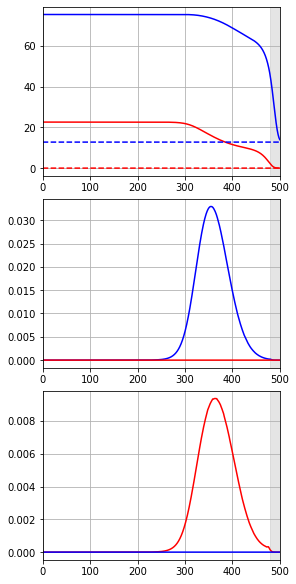

-------  9 0.4000000000000001 0.42500000000000016
--------------- k  0
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  247.93882651789372
RUN  0 , total integrated cost =  247.93882651789372
Gradient descend method:  None
RUN  1 , total integrated cost =  247.9005328985721
RUN  2 , total integrated cost =  247.86041044305526
RUN  3 , total integrated cost =  247.82277939849212
RUN  4 , total integrated cost =  247.78475756297073
RUN  5 , total integrated cost =  247.74754756351624
RUN  6 , total integrated cost =  247.71015810213132
RUN  7 , total integrated cost =  247.6727618862922
RUN  8 , total integrated cost =  247.63614544990114
RUN  9 , total integrated cost =  247.59943421792843
RUN  10 , total integrated cost =  247.56253207512526
RUN  11 , total integrated cost =  247.5280426654803
RUN  12 , total integrated cost =  247.49185143712407
RUN  13 , total integrated cost =  247.45508197527
RUN  14 , total integrated cost =  247.4188028407355

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  232.37175715182474
RUN  100 , total integrated cost =  232.37175715182474
Improved over  100  iterations in  75.10618362401146  seconds by  6.278592822550735  percent.
Problem in initial value trasfer post:  sigmae_f 1.5488151436159943 1.5488152412831984
Problem in initial value trasfer post:  tau_exc 20.837705111486184 20.837704468540686
cost splitting :  0.5645899182670225 [1.19621062e-20 2.13989693e-02 2.01589609e-03 0.00000000e+00]
--------------- k  1
set cost params:  1.0 59129.50596118388 0.0
interpolate adjoint :  True True True
initial cost =  1385.0740118154226
RUN  0 , total integrated cost =  1385.0740118154226
Gradient descend method:  None
RUN  1 , total integrated cost =  1381.0295272468186
RUN  2 , total integrated cost =  1381.0053997104135
RUN  3 , total integrated cost =  1380.9754575691063
RUN  4 , total integrated cost =  1380.9557967388646
RUN  5 , total integrated cost =  1380.9334964364762
RUN  6 , total integrated cost =  138

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  1358.2032392297717
RUN  100 , total integrated cost =  1358.2032392297717
Improved over  100  iterations in  81.9167748860782  seconds by  1.9400243132445496  percent.
Problem in initial value trasfer post:  sigmae_f 1.548130241959539 1.548130267289437
Problem in initial value trasfer post:  tau_exc 20.779342083498392 20.779341914446356
cost splitting :  2.5032650376769077 [1.70874080e-21 2.09105073e-02 2.01713182e-03 0.00000000e+00]
--------------- k  2
set cost params:  1.0 110453.84221058611 0.0
interpolate adjoint :  True True True
initial cost =  2534.949098977301
RUN  0 , total integrated cost =  2534.949098977301
Gradient descend method:  None
RUN  1 , total integrated cost =  2534.223232301764
RUN  2 , total integrated cost =  2534.198585664857
RUN  3 , total integrated cost =  2534.1765888270597
RUN  4 , total integrated cost =  2531.8544462661043
RUN  5 , total integrated cost =  2530.383196105465
RUN  6 , total integrated cost =  2530.3788

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  61 , total integrated cost =  2510.1067684063373
Improved over  61  iterations in  52.30786724505015  seconds by  0.9799932701207439  percent.
Problem in initial value trasfer post:  sigmae_f 1.548004899477518 1.5480049143897314
Problem in initial value trasfer post:  tau_exc 20.77115290495683 20.77115280523772
cost splitting :  3.029914366896545 [7.08196421e-22 2.06941767e-02 2.00476458e-03 0.00000000e+00]
--------------- k  3
set cost params:  1.0 162252.7196349717 0.0
interpolate adjoint :  True True True
initial cost =  3685.886444370839
RUN  0 , total integrated cost =  3685.886444370839
Gradient descend method:  None
RUN  1 , total integrated cost =  3685.53753089277
RUN  2 , total integrated cost =  3685.528059153691


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  3685.5214314500113
Control only changes marginally.
RUN  3 , total integrated cost =  3685.5214314500113
Improved over  3  iterations in  3.295722844079137  seconds by  0.009902988774527444  percent.
Problem in initial value trasfer post:  sigmae_f 1.5476048609543753 1.5476048756879444
Problem in initial value trasfer post:  tau_exc 20.75612138143831 20.75612128253597
cost splitting :  4.691810896482116 [7.07679511e-22 2.06832802e-02 2.00388046e-03 0.00000000e+00]
--------------- k  4
set cost params:  1.0 213139.71681161114 0.0
interpolate adjoint :  True True True
initial cost =  4840.002910173478
RUN  0 , total integrated cost =  4840.002910173478
Gradient descend method:  None
RUN  1 , total integrated cost =  4839.789947665503
RUN  2 , total integrated cost =  4839.394289739708
RUN  3 , total integrated cost =  4839.022126684615


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  4839.019300685884
Control only changes marginally.
RUN  4 , total integrated cost =  4839.019300685884
Improved over  4  iterations in  4.320987451006658  seconds by  0.020322497854834864  percent.
Problem in initial value trasfer post:  sigmae_f 1.5472978233405499 1.5472978368441503
Problem in initial value trasfer post:  tau_exc 20.74591920980527 20.745919118795946
cost splitting :  5.99498984472776 [6.39819711e-22 2.06738917e-02 2.00238132e-03 0.00000000e+00]
--------------- k  5
set cost params:  1.0 264068.9880061577 0.0
interpolate adjoint :  True True True
initial cost =  5993.905357261898
RUN  0 , total integrated cost =  5993.905357261898
Gradient descend method:  None
RUN  1 , total integrated cost =  5993.70519579833


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  5993.703232762341
Control only changes marginally.
RUN  2 , total integrated cost =  5993.703232762341
Improved over  2  iterations in  2.4911964050261304  seconds by  0.003372167018142136  percent.
Problem in initial value trasfer post:  sigmae_f 1.5469782097640927 1.54697822314439
Problem in initial value trasfer post:  tau_exc 20.736287973423202 20.736287882816868
cost splitting :  7.4937146327668485 [6.39647347e-22 2.06673555e-02 2.00243762e-03 0.00000000e+00]
--------------- k  6
set cost params:  1.0 314986.1702626385 0.0
interpolate adjoint :  True True True
initial cost =  7147.985219069757
RUN  0 , total integrated cost =  7147.985219069757
Gradient descend method:  None
RUN  1 , total integrated cost =  7147.83145214055
RUN  2 , total integrated cost =  7147.823978875747
RUN  3 , total integrated cost =  7147.81012803034


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  7147.807183726621
Control only changes marginally.
RUN  4 , total integrated cost =  7147.807183726621
Improved over  4  iterations in  4.448588965926319  seconds by  0.0024907066492119156  percent.
Problem in initial value trasfer post:  sigmae_f 1.546693899031938 1.5466939122753285
Problem in initial value trasfer post:  tau_exc 20.728486473696567 20.728486383667388
cost splitting :  9.005731738190974 [6.37762054e-22 2.06626499e-02 2.00195202e-03 0.00000000e+00]
--------------- k  7
set cost params:  1.0 365910.8784490114 0.0
interpolate adjoint :  True True True
initial cost =  8301.995422100039
RUN  0 , total integrated cost =  8301.995422100039
Gradient descend method:  None
RUN  1 , total integrated cost =  8301.856150883168
RUN  2 , total integrated cost =  8301.84265122022
RUN  3 , total integrated cost =  8301.827548316429
RUN  4 , total integrated cost =  8301.82110729067
RUN  5 , total integrated cost =  8301.803903541319


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  8301.79755782794
Control only changes marginally.
RUN  6 , total integrated cost =  8301.79755782794
Improved over  6  iterations in  6.4460861049592495  seconds by  0.0023833339099610384  percent.
Problem in initial value trasfer post:  sigmae_f 1.5464214802941791 1.5464214933648468
Problem in initial value trasfer post:  tau_exc 20.721528064550295 20.721527975382244
cost splitting :  10.7108703436825 [6.36331054e-22 2.06584333e-02 2.00154718e-03 0.00000000e+00]
--------------- k  8
set cost params:  1.0 416846.6974374044 0.0
interpolate adjoint :  True True True
initial cost =  9456.002219761607
RUN  0 , total integrated cost =  9456.002219761607
Gradient descend method:  None
RUN  1 , total integrated cost =  9455.864039695947
RUN  2 , total integrated cost =  9455.844144093146
RUN  3 , total integrated cost =  9455.81541926328
RUN  4 , total integrated cost =  9455.809591367404
RUN  5 , total integrated cost =  9455.793083659457


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  9455.790353723416
Control only changes marginally.
RUN  6 , total integrated cost =  9455.790353723416
Improved over  6  iterations in  5.867935066926293  seconds by  0.0022405455631968607  percent.
Problem in initial value trasfer post:  sigmae_f 1.5461377704832313 1.5461377833637355
Problem in initial value trasfer post:  tau_exc 20.714751341132594 20.714751252956535
cost splitting :  12.142341348715545 [6.34692582e-22 2.06541645e-02 2.00138081e-03 0.00000000e+00]
--------------- k  9
set cost params:  1.0 467799.1458457211 0.0
interpolate adjoint :  True True True
initial cost =  10610.145857560623
RUN  0 , total integrated cost =  10610.145857560623
Gradient descend method:  None
RUN  1 , total integrated cost =  10610.038472192291
RUN  2 , total integrated cost =  10610.029871370834
RUN  3 , total integrated cost =  10610.009972454143


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  10610.006543232945
Control only changes marginally.
RUN  4 , total integrated cost =  10610.006543232945
Improved over  4  iterations in  4.883507752907462  seconds by  0.0013130293357761502  percent.
Problem in initial value trasfer post:  sigmae_f 1.5459015056317091 1.5459015183882434
Problem in initial value trasfer post:  tau_exc 20.709417806927892 20.709417719359102
cost splitting :  13.621396642016771 [6.32792158e-22 2.06511288e-02 2.00105828e-03 0.00000000e+00]
--------------- k  10
set cost params:  1.0 518745.8728480842 0.0
interpolate adjoint :  True True True
initial cost =  11764.061335487098
RUN  0 , total integrated cost =  11764.061335487098
Gradient descend method:  None
RUN  1 , total integrated cost =  11763.956565478824


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  11763.951837751669
Control only changes marginally.
RUN  2 , total integrated cost =  11763.951837751669
Improved over  2  iterations in  2.7096527739195153  seconds by  0.0009307817454100586  percent.
Problem in initial value trasfer post:  sigmae_f 1.5456704557008667 1.545670468361274
Problem in initial value trasfer post:  tau_exc 20.70442974993135 20.70442966279571
cost splitting :  15.173477642625146 [6.32167686e-22 2.06483661e-02 2.00078229e-03 0.00000000e+00]
--------------- k  11
set cost params:  1.0 569698.1633808188 0.0
interpolate adjoint :  True True True
initial cost =  12917.977828526502
RUN  0 , total integrated cost =  12917.977828526502
Gradient descend method:  None
RUN  1 , total integrated cost =  12917.871133396044
RUN  2 , total integrated cost =  12917.847919962269
RUN  3 , total integrated cost =  12917.824438723543
RUN  4 , total integrated cost =  12917.817679739357
RUN  5 , total integrated cost =  12917.79245873888


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  12917.78336594389
Control only changes marginally.
RUN  6 , total integrated cost =  12917.78336594389
Improved over  6  iterations in  6.803415413014591  seconds by  0.0015053639601632085  percent.
Problem in initial value trasfer post:  sigmae_f 1.5454163513564658 1.5454163638380214
Problem in initial value trasfer post:  tau_exc 20.69916258378814 20.699162497644743
cost splitting :  17.05677869754533 [6.29752307e-22 2.06455162e-02 2.00033702e-03 0.00000000e+00]
--------------- k  12
set cost params:  1.0 620667.959106547 0.0
interpolate adjoint :  True True True
initial cost =  14072.037880796503
RUN  0 , total integrated cost =  14072.037880796503
Gradient descend method:  None
RUN  1 , total integrated cost =  14071.946348276104
RUN  2 , total integrated cost =  14071.935077374834
RUN  3 , total integrated cost =  14071.914015848348


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  14071.901965328838
Control only changes marginally.
RUN  4 , total integrated cost =  14071.901965328838
Improved over  4  iterations in  5.227247452014126  seconds by  0.0009658549018638496  percent.
Problem in initial value trasfer post:  sigmae_f 1.5451982961723734 1.545198308529129
Problem in initial value trasfer post:  tau_exc 20.694800438111912 20.694800352632093
cost splitting :  18.784624850860798 [6.28595341e-22 2.06429922e-02 2.00022918e-03 0.00000000e+00]
--------------- k  13
set cost params:  1.0 671632.4262360191 0.0
interpolate adjoint :  True True True
initial cost =  15225.9016763114
RUN  0 , total integrated cost =  15225.9016763114
Gradient descend method:  None
RUN  1 , total integrated cost =  15225.799044453517


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  15225.792180402597
Control only changes marginally.
RUN  2 , total integrated cost =  15225.792180402597
Improved over  2  iterations in  2.4631595259997994  seconds by  0.0007191423610208858  percent.
Problem in initial value trasfer post:  sigmae_f 1.5449712171240686 1.5449712293828306
Problem in initial value trasfer post:  tau_exc 20.690386730377867 20.69038664537571
cost splitting :  20.103476727145882 [6.27875253e-22 2.06406622e-02 1.99999386e-03 0.00000000e+00]
--------------- k  14
set cost params:  1.0 722607.6662869526 0.0
interpolate adjoint :  True True True
initial cost =  16379.905060221878
RUN  0 , total integrated cost =  16379.905060221878
Gradient descend method:  None
RUN  1 , total integrated cost =  16379.807929979046
RUN  2 , total integrated cost =  16379.771052880187
RUN  3 , total integrated cost =  16379.733205704702


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  16379.725632014493
Control only changes marginally.
RUN  4 , total integrated cost =  16379.725632014493
Improved over  4  iterations in  4.921083322959021  seconds by  0.0010954166506138563  percent.
Problem in initial value trasfer post:  sigmae_f 1.5447730879061308 1.5447731000181324
Problem in initial value trasfer post:  tau_exc 20.6866281819338 20.68662809777952
cost splitting :  21.683255016797805 [6.26899965e-22 2.06387533e-02 1.99964604e-03 0.00000000e+00]
--------------- k  15
set cost params:  1.0 773581.1610732574 0.0
interpolate adjoint :  True True True
initial cost =  17533.683961372837
RUN  0 , total integrated cost =  17533.683961372837
Gradient descend method:  None
RUN  1 , total integrated cost =  17533.585860304218
RUN  2 , total integrated cost =  17533.57005398255
RUN  3 , total integrated cost =  17533.540920890413


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  17533.53304927014
Control only changes marginally.
RUN  4 , total integrated cost =  17533.53304927014
Improved over  4  iterations in  4.901636746013537  seconds by  0.0008606982025582965  percent.
Problem in initial value trasfer post:  sigmae_f 1.5445628175890413 1.5445628295755858
Problem in initial value trasfer post:  tau_exc 20.682719836900024 20.682719753441578
cost splitting :  23.227726311254287 [6.25864622e-22 2.06368093e-02 1.99932739e-03 0.00000000e+00]
--------------- k  16
set cost params:  1.0 824563.9045676643 0.0
interpolate adjoint :  True True True
initial cost =  18687.585398518615
RUN  0 , total integrated cost =  18687.585398518615
Gradient descend method:  None
RUN  1 , total integrated cost =  18687.495812421806


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  18687.486990518642
Control only changes marginally.
RUN  2 , total integrated cost =  18687.486990518642
Improved over  2  iterations in  2.6947762250201777  seconds by  0.000526595586720191  percent.
Problem in initial value trasfer post:  sigmae_f 1.5443815255521398 1.5443815374562286
Problem in initial value trasfer post:  tau_exc 20.679411332896432 20.679411249863357
cost splitting :  24.669093986049926 [6.25163328e-22 2.06351347e-02 1.99915626e-03 0.00000000e+00]
--------------- k  17
set cost params:  1.0 875540.2936434888 0.0
interpolate adjoint :  True True True
initial cost =  19841.301412792753
RUN  0 , total integrated cost =  19841.301412792753
Gradient descend method:  None
RUN  1 , total integrated cost =  19841.201517958754
RUN  2 , total integrated cost =  19841.188115238136
RUN  3 , total integrated cost =  19841.155235285456


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  19841.137331066264
Control only changes marginally.
RUN  4 , total integrated cost =  19841.137331066264
Improved over  4  iterations in  4.5309777410002425  seconds by  0.0008269705856207565  percent.
Problem in initial value trasfer post:  sigmae_f 1.544152143946644 1.5441521557143782
Problem in initial value trasfer post:  tau_exc 20.675290108923257 20.675290026657116
cost splitting :  27.049326996673447 [6.24536343e-22 2.06326295e-02 1.99934703e-03 0.00000000e+00]
--------------- k  18
set cost params:  1.0 926535.2947186459 0.0
interpolate adjoint :  True True True
initial cost =  20995.25499646731
RUN  0 , total integrated cost =  20995.25499646731
Gradient descend method:  None
RUN  1 , total integrated cost =  20995.173729260183
RUN  2 , total integrated cost =  20995.16118694019
RUN  3 , total integrated cost =  20995.120307912013


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  20995.100217338488
Control only changes marginally.
RUN  4 , total integrated cost =  20995.100217338488
Improved over  4  iterations in  5.033306006924249  seconds by  0.0007372100450595553  percent.
Problem in initial value trasfer post:  sigmae_f 1.5439340125651613 1.5439340241966353
Problem in initial value trasfer post:  tau_exc 20.671053652791556 20.6710535713071
cost splitting :  28.820493858523783 [6.23594577e-22 2.06305423e-02 1.99929543e-03 0.00000000e+00]
--------------- k  19
set cost params:  1.0 977536.2311008353 0.0
interpolate adjoint :  True True True
initial cost =  22149.24312976653
RUN  0 , total integrated cost =  22149.24312976653
Gradient descend method:  None
RUN  1 , total integrated cost =  22149.174040037844


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  22149.163890231812
Control only changes marginally.
RUN  2 , total integrated cost =  22149.163890231812
Improved over  2  iterations in  2.688921876018867  seconds by  0.00035775278756489115  percent.
Problem in initial value trasfer post:  sigmae_f 1.5437960252245801 1.5437960367873562
Problem in initial value trasfer post:  tau_exc 20.66800341464426 20.668003333534713
cost splitting :  29.82915314472843 [6.22934921e-22 2.06293776e-02 1.99917128e-03 0.00000000e+00]
--------------- k  20
set cost params:  1.0 1028513.66606381 0.0
interpolate adjoint :  True True True
initial cost =  23302.709266817186
RUN  0 , total integrated cost =  23302.709266817186
Gradient descend method:  None
RUN  1 , total integrated cost =  23302.606147377246


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  23302.595076510777
Control only changes marginally.
RUN  2 , total integrated cost =  23302.595076510777
Improved over  2  iterations in  2.755425953073427  seconds by  0.0004900301724575229  percent.
Problem in initial value trasfer post:  sigmae_f 1.5435794687272009 1.5435794801944025
Problem in initial value trasfer post:  tau_exc 20.66326982085095 20.663269740247532
cost splitting :  31.619998861466392 [6.22363256e-22 2.06276059e-02 1.99898971e-03 0.00000000e+00]
--------------- k  21
set cost params:  1.0 1079520.233713745 0.0
interpolate adjoint :  True True True
initial cost =  24456.700058102182
RUN  0 , total integrated cost =  24456.700058102182
Gradient descend method:  None
RUN  1 , total integrated cost =  24456.61097970869


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  24456.599408484177
Control only changes marginally.
RUN  2 , total integrated cost =  24456.599408484177
Improved over  2  iterations in  2.00389349705074  seconds by  0.00041154210407512437  percent.
Problem in initial value trasfer post:  sigmae_f 1.543396503027635 1.5433965144106978
Problem in initial value trasfer post:  tau_exc 20.659320724467698 20.659320644319102
cost splitting :  33.27245752459702 [6.21829698e-22 2.06261471e-02 1.99883806e-03 0.00000000e+00]
--------------- k  22
set cost params:  1.0 1130518.3823230667 0.0
interpolate adjoint :  True True True
initial cost =  25610.431762175063
RUN  0 , total integrated cost =  25610.431762175063
Gradient descend method:  None
RUN  1 , total integrated cost =  25610.341473240147


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  25610.329762203346
Control only changes marginally.
RUN  2 , total integrated cost =  25610.329762203346
Improved over  2  iterations in  2.2558406100142747  seconds by  0.00039827509611711776  percent.
Problem in initial value trasfer post:  sigmae_f 1.5432166246271022 1.5432166359289
Problem in initial value trasfer post:  tau_exc 20.655474677099434 20.655474597390523
cost splitting :  34.95230238448903 [6.21385725e-22 2.06247473e-02 1.99869334e-03 0.00000000e+00]
--------------- k  23
set cost params:  1.0 1181518.639480704 0.0
interpolate adjoint :  True True True
initial cost =  26764.13105326445
RUN  0 , total integrated cost =  26764.13105326445
Gradient descend method:  None
RUN  1 , total integrated cost =  26764.04778066315


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  26764.03558605493
Control only changes marginally.
RUN  2 , total integrated cost =  26764.03558605493
Improved over  2  iterations in  2.220518794027157  seconds by  0.00035669833377482973  percent.
Problem in initial value trasfer post:  sigmae_f 1.5430344499417405 1.5430344611622833
Problem in initial value trasfer post:  tau_exc 20.651611612301195 20.651611533032842
cost splitting :  36.593964233244115 [6.20995943e-22 2.06233620e-02 1.99855070e-03 0.00000000e+00]
--------------- k  24
set cost params:  1.0 1232523.8987037349 0.0
interpolate adjoint :  True True True
initial cost =  27917.87210811546
RUN  0 , total integrated cost =  27917.87210811546
Gradient descend method:  None
RUN  1 , total integrated cost =  27917.796502156252
RUN  2 , total integrated cost =  27917.784890820483
RUN  3 , total integrated cost =  27917.751514684922


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  27917.737271429996
Control only changes marginally.
RUN  4 , total integrated cost =  27917.737271429996
Improved over  4  iterations in  5.028095819987357  seconds by  0.00048297622736015455  percent.
Problem in initial value trasfer post:  sigmae_f 1.5428513394589993 1.5428513505755692
Problem in initial value trasfer post:  tau_exc 20.64775768009873 20.647757601433565
cost splitting :  38.49762788042683 [6.20148560e-22 2.06219777e-02 1.99839502e-03 0.00000000e+00]
--------------- k  25
set cost params:  1.0 1283532.3960618488 0.0
interpolate adjoint :  True True True
initial cost =  29071.568492328188
RUN  0 , total integrated cost =  29071.568492328188
Gradient descend method:  None
RUN  1 , total integrated cost =  29071.5010023122


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  29071.490823251566
Control only changes marginally.
RUN  2 , total integrated cost =  29071.490823251566
Improved over  2  iterations in  2.889186260988936  seconds by  0.0002671650710652784  percent.
Problem in initial value trasfer post:  sigmae_f 1.5427053258884529 1.5427053369363846
Problem in initial value trasfer post:  tau_exc 20.644699378846077 20.64469930056284
cost splitting :  39.8952428790933 [6.19818110e-22 2.06209071e-02 1.99828268e-03 0.00000000e+00]
--------------- k  26
set cost params:  1.0 1334531.030892788 0.0
interpolate adjoint :  True True True
initial cost =  30225.038624712954
RUN  0 , total integrated cost =  30225.038624712954
Gradient descend method:  None
RUN  1 , total integrated cost =  30224.960127232644
RUN  2 , total integrated cost =  30224.946532676415
RUN  3 , total integrated cost =  30224.900907934178


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  30224.878504112723
Control only changes marginally.
RUN  4 , total integrated cost =  30224.878504112723
Improved over  4  iterations in  5.041090507991612  seconds by  0.0005297614412285157  percent.
Problem in initial value trasfer post:  sigmae_f 1.5424987227497062 1.5424987336753204
Problem in initial value trasfer post:  tau_exc 20.640396481448683 20.64039640388744
cost splitting :  42.34460180561334 [6.19408181e-22 2.06192481e-02 1.99826054e-03 0.00000000e+00]
--------------- k  27
set cost params:  1.0 1385551.5865494618 0.0
interpolate adjoint :  True True True
initial cost =  31378.83636112008
RUN  0 , total integrated cost =  31378.83636112008
Gradient descend method:  None
RUN  1 , total integrated cost =  31378.778541594744


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  31378.76579897957
Control only changes marginally.
RUN  2 , total integrated cost =  31378.76579897957
Improved over  2  iterations in  2.8214353939983994  seconds by  0.0002248717565436209  percent.
Problem in initial value trasfer post:  sigmae_f 1.5423938818532443 1.5423938927236465
Problem in initial value trasfer post:  tau_exc 20.638218240173412 20.638218162931132
cost splitting :  43.41287466690558 [6.19145043e-22 2.06184998e-02 1.99817817e-03 0.00000000e+00]
--------------- k  28
set cost params:  1.0 1436540.9171499577 0.0
interpolate adjoint :  True True True
initial cost =  32531.975068518204
RUN  0 , total integrated cost =  32531.975068518204
Gradient descend method:  None
RUN  1 , total integrated cost =  32531.88649823596


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  32531.8698514877
Control only changes marginally.
RUN  2 , total integrated cost =  32531.8698514877
Improved over  2  iterations in  2.6428323730360717  seconds by  0.0003234265066396347  percent.
Problem in initial value trasfer post:  sigmae_f 1.5422278457156908 1.5422278565069367
Problem in initial value trasfer post:  tau_exc 20.634775643238914 20.63477556644445
cost splitting :  45.431758605983546 [6.18885744e-22 2.06173378e-02 1.99805510e-03 0.00000000e+00]
--------------- k  29
set cost params:  1.0 1487550.6145726594 0.0
interpolate adjoint :  True True True
initial cost =  33685.474199527394
RUN  0 , total integrated cost =  33685.474199527394
Gradient descend method:  None
RUN  1 , total integrated cost =  33685.38837065966
RUN  2 , total integrated cost =  33685.364249752456
RUN  3 , total integrated cost =  33685.30632023891


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  33685.27608675936
Control only changes marginally.
RUN  4 , total integrated cost =  33685.27608675936
Improved over  4  iterations in  4.966942248982377  seconds by  0.0005881252164101625  percent.
Problem in initial value trasfer post:  sigmae_f 1.5420419417571363 1.5420419524226587
Problem in initial value trasfer post:  tau_exc 20.63092878699403 20.630928710967474
cost splitting :  47.94557773656859 [6.18656138e-22 2.06158612e-02 1.99805818e-03 0.00000000e+00]
--------------- k  30
set cost params:  1.0 1538570.531353941 0.0
interpolate adjoint :  True True True
initial cost =  34839.036371577306
RUN  0 , total integrated cost =  34839.036371577306
Gradient descend method:  None
RUN  1 , total integrated cost =  34838.96165097924


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  34838.94468644547
Control only changes marginally.
RUN  2 , total integrated cost =  34838.94468644547
Improved over  2  iterations in  2.742072801105678  seconds by  0.0002631678180051722  percent.
Problem in initial value trasfer post:  sigmae_f 1.5418917192057595 1.5418917297989116
Problem in initial value trasfer post:  tau_exc 20.627826682475536 20.627826606863177
cost splitting :  48.64371213315122 [6.18501713e-22 2.06148419e-02 1.99794923e-03 0.00000000e+00]
--------------- k  31
set cost params:  1.0 1589595.6103223877 0.0
interpolate adjoint :  True True True
initial cost =  35992.76414107716
RUN  0 , total integrated cost =  35992.76414107716
Gradient descend method:  None
RUN  1 , total integrated cost =  35992.68554095187


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  35992.671187695094
Control only changes marginally.
RUN  2 , total integrated cost =  35992.671187695094
Improved over  2  iterations in  2.798553560045548  seconds by  0.00025825574746818347  percent.
Problem in initial value trasfer post:  sigmae_f 1.5417618009104905 1.5417618114374576
Problem in initial value trasfer post:  tau_exc 20.625138458529783 20.62513838330227
cost splitting :  50.32018163649645 [6.18403967e-22 2.06139661e-02 1.99785350e-03 0.00000000e+00]
--------------- k  32
set cost params:  1.0 1640600.009635752 0.0
interpolate adjoint :  True True True
initial cost =  37145.973462817085
RUN  0 , total integrated cost =  37145.973462817085
Gradient descend method:  None
RUN  1 , total integrated cost =  37145.875980270976


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  37145.85911281468
Control only changes marginally.
RUN  2 , total integrated cost =  37145.85911281468
Improved over  2  iterations in  2.7800891370279714  seconds by  0.00030783956306379423  percent.
Problem in initial value trasfer post:  sigmae_f 1.5416017531038038 1.5416017635527184
Problem in initial value trasfer post:  tau_exc 20.621825350684784 20.621825275907856
cost splitting :  52.33466157377504 [6.18359060e-22 2.06129027e-02 1.99773938e-03 0.00000000e+00]
--------------- k  33
set cost params:  1.0 1691617.7283232787 0.0
interpolate adjoint :  True True True
initial cost =  38299.40249110007
RUN  0 , total integrated cost =  38299.40249110007
Gradient descend method:  None
RUN  1 , total integrated cost =  38299.30474997991


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  38299.28632629105
Control only changes marginally.
RUN  2 , total integrated cost =  38299.28632629105
Improved over  2  iterations in  2.6989966619294137  seconds by  0.0003033071052414016  percent.
Problem in initial value trasfer post:  sigmae_f 1.5414301919190974 1.5414302022859228
Problem in initial value trasfer post:  tau_exc 20.61828302192253 20.618282947619207
cost splitting :  54.5725564403549 [6.18361874e-22 2.06117816e-02 1.99761990e-03 0.00000000e+00]
--------------- k  34
set cost params:  1.0 1742640.4768661098 0.0
interpolate adjoint :  True True True
initial cost =  39452.88013386416
RUN  0 , total integrated cost =  39452.88013386416
Gradient descend method:  None
RUN  1 , total integrated cost =  39452.79348845276


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  39452.77930791118
Control only changes marginally.
RUN  2 , total integrated cost =  39452.77930791118
Improved over  2  iterations in  2.7329631770262495  seconds by  0.0002555604372389553  percent.
Problem in initial value trasfer post:  sigmae_f 1.5412832969082324 1.54128330720478
Problem in initial value trasfer post:  tau_exc 20.615259392499112 20.615259318602817
cost splitting :  55.64611669790558 [6.18404348e-22 2.06108355e-02 1.99751900e-03 0.00000000e+00]
--------------- k  35
set cost params:  1.0 1793669.572862748 0.0
interpolate adjoint :  True True True
initial cost =  40606.46320257163
RUN  0 , total integrated cost =  40606.46320257163
Gradient descend method:  None
RUN  1 , total integrated cost =  40606.381575530715
RUN  2 , total integrated cost =  40606.36367054875
RUN  3 , total integrated cost =  40606.30436873665


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  40606.28189681576
Control only changes marginally.
RUN  4 , total integrated cost =  40606.28189681576
Improved over  4  iterations in  5.127999013056979  seconds by  0.00044649482266834184  percent.
Problem in initial value trasfer post:  sigmae_f 1.541088269738309 1.5410882799204295
Problem in initial value trasfer post:  tau_exc 20.61124447079167 20.611244397589548
cost splitting :  58.29073162052099 [6.18693376e-22 2.06095769e-02 1.99737231e-03 0.00000000e+00]
--------------- k  36
set cost params:  1.0 1844706.5810067516 0.0
interpolate adjoint :  True True True
initial cost =  41760.07294728838
RUN  0 , total integrated cost =  41760.07294728838
Gradient descend method:  None
RUN  1 , total integrated cost =  41760.01751938601


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  41759.99797935146
Control only changes marginally.
RUN  2 , total integrated cost =  41759.99797935146
Improved over  2  iterations in  2.792647945927456  seconds by  0.00017952060817094662  percent.
Problem in initial value trasfer post:  sigmae_f 1.5409864959365103 1.5409865060652563
Problem in initial value trasfer post:  tau_exc 20.60914593404748 20.609145861163
cost splitting :  59.634615806276 [6.18845876e-22 2.06089327e-02 1.99730081e-03 0.00000000e+00]
--------------- k  37
set cost params:  1.0 1895711.2560502158 0.0
interpolate adjoint :  True True True
initial cost =  42913.02157136523
RUN  0 , total integrated cost =  42913.02157136523
Gradient descend method:  None
RUN  1 , total integrated cost =  42912.94798439341


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  42912.93020703139
Control only changes marginally.
RUN  2 , total integrated cost =  42912.93020703139
Improved over  2  iterations in  2.7594151430530474  seconds by  0.00021290585115707472  percent.
Problem in initial value trasfer post:  sigmae_f 1.5408590733061993 1.5408590833716231
Problem in initial value trasfer post:  tau_exc 20.60652378536039 20.606523712849437
cost splitting :  61.011999272042814 [6.19016942e-22 2.06081374e-02 1.99721449e-03 0.00000000e+00]
--------------- k  38
set cost params:  1.0 1946731.6524085184 0.0
interpolate adjoint :  True True True
initial cost =  44066.264220199715
RUN  0 , total integrated cost =  44066.264220199715
Gradient descend method:  None
RUN  1 , total integrated cost =  44066.18867802212


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  44066.17118363941
Control only changes marginally.
RUN  2 , total integrated cost =  44066.17118363941
Improved over  2  iterations in  2.673243794008158  seconds by  0.0002111287669919193  percent.
Problem in initial value trasfer post:  sigmae_f 1.5407493630406488 1.5407493730480932
Problem in initial value trasfer post:  tau_exc 20.604262611642255 20.60426253947855
cost splitting :  62.794117720367574 [6.19262285e-22 2.06074552e-02 1.99713846e-03 0.00000000e+00]
--------------- k  39
set cost params:  1.0 1997736.9683001905 0.0
interpolate adjoint :  True True True
initial cost =  45219.125622446845
RUN  0 , total integrated cost =  45219.125622446845
Gradient descend method:  None
RUN  1 , total integrated cost =  45219.03609581702
RUN  2 , total integrated cost =  45219.00634773256
RUN  3 , total integrated cost =  45218.9359020322


ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  45218.90463208011
Control only changes marginally.
RUN  4 , total integrated cost =  45218.90463208011
Improved over  4  iterations in  5.253574601025321  seconds by  0.0004887099511279303  percent.
Problem in initial value trasfer post:  tau_exc 20.600387702096967 20.600387630682867
cost splitting :  65.51378421001569 [6.19783540e-22 2.06061389e-02 1.99713842e-03 0.00000000e+00]
--------------- k  40
set cost params:  1.0 2048777.9826620878 0.0
interpolate adjoint :  True True True
initial cost =  46372.59883274195
RUN  0 , total integrated cost =  46372.59883274195
Gradient descend method:  None
RUN  1 , total integrated cost =  46372.52968733649


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  46372.51140088624
Control only changes marginally.
RUN  2 , total integrated cost =  46372.51140088624
Improved over  2  iterations in  2.571359443012625  seconds by  0.0001885420655867165  percent.
Problem in initial value trasfer post:  tau_exc 20.59788417233628 20.59788410128692
cost splitting :  66.38746985653066 [6.20086648e-22 2.06054040e-02 1.99705761e-03 0.00000000e+00]
--------------- k  41
set cost params:  1.0 2099809.6527878097 0.0
interpolate adjoint :  True True True
initial cost =  47525.95276364816
RUN  0 , total integrated cost =  47525.95276364816
Gradient descend method:  None
RUN  1 , total integrated cost =  47525.88221302715


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  47525.861656311856
Control only changes marginally.
RUN  2 , total integrated cost =  47525.861656311856
Improved over  2  iterations in  2.620508342050016  seconds by  0.0001917001785471939  percent.
Problem in initial value trasfer post:  tau_exc 20.595796500292664 20.595796429575817
cost splitting :  68.30779380803203 [6.20481028e-22 2.06047934e-02 1.99698814e-03 0.00000000e+00]
--------------- k  42
set cost params:  1.0 2150811.917405577 0.0
interpolate adjoint :  True True True
initial cost =  48678.6036968525
RUN  0 , total integrated cost =  48678.6036968525
Gradient descend method:  None
RUN  1 , total integrated cost =  48678.51798623938


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  48678.490538802354
Control only changes marginally.
RUN  2 , total integrated cost =  48678.490538802354
Improved over  2  iterations in  2.5063267779769376  seconds by  0.00023245952338868392  percent.
Problem in initial value trasfer post:  tau_exc 20.593390529624926 20.593390459288955
cost splitting :  70.10188810683604 [6.20981930e-22 2.06040958e-02 1.99690898e-03 0.00000000e+00]
--------------- k  43
set cost params:  1.0 2201827.3531509736 0.0
interpolate adjoint :  True True True
initial cost =  49831.49064433266
RUN  0 , total integrated cost =  49831.49064433266
Gradient descend method:  None
RUN  1 , total integrated cost =  49831.39966615431


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  49831.37679022428
Control only changes marginally.
RUN  2 , total integrated cost =  49831.37679022428
Improved over  2  iterations in  2.6528048790059984  seconds by  0.00022847823115057508  percent.
Problem in initial value trasfer post:  tau_exc 20.59101593242822 20.591015862466065
cost splitting :  71.61078934985491 [6.21529016e-22 2.06034143e-02 1.99683178e-03 0.00000000e+00]
--------------- k  44
set cost params:  1.0 2252848.4721160242 0.0
interpolate adjoint :  True True True
initial cost =  50984.46663285178
RUN  0 , total integrated cost =  50984.46663285178
Gradient descend method:  None
RUN  1 , total integrated cost =  50984.364210346095


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  50984.336282905955
Control only changes marginally.
RUN  2 , total integrated cost =  50984.336282905955
Improved over  2  iterations in  2.7064623060869053  seconds by  0.00025566599875048723  percent.
Problem in initial value trasfer post:  tau_exc 20.587777372731097 20.587777303224897
cost splitting :  73.89726935096466 [6.22117085e-22 2.06025020e-02 1.99673264e-03 0.00000000e+00]
--------------- k  45
set cost params:  1.0 2303881.910064666 0.0
interpolate adjoint :  True True True
initial cost =  52137.65292034031
RUN  0 , total integrated cost =  52137.65292034031
Gradient descend method:  None
RUN  1 , total integrated cost =  52137.565129368166


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  52137.54148210599
Control only changes marginally.
RUN  2 , total integrated cost =  52137.54148210599
Improved over  2  iterations in  2.7264707409776747  seconds by  0.00021373849430972314  percent.
Problem in initial value trasfer post:  tau_exc 20.585264441922064 20.585264372795262
cost splitting :  75.33964728630875 [6.22763405e-22 2.06017980e-02 1.99665412e-03 0.00000000e+00]
--------------- k  46
set cost params:  1.0 2354911.2789910254 0.0
interpolate adjoint :  True True True
initial cost =  53290.72623304475
RUN  0 , total integrated cost =  53290.72623304475
Gradient descend method:  None
RUN  1 , total integrated cost =  53290.63455929067
RUN  2 , total integrated cost =  53290.60496493415
RUN  3 , total integrated cost =  53290.53431845765


ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  53290.50375202804
Control only changes marginally.
RUN  4 , total integrated cost =  53290.50375202804
Improved over  4  iterations in  4.82358680292964  seconds by  0.00041748542840025493  percent.
Problem in initial value trasfer post:  tau_exc 20.582152014491776 20.582151945991846
cost splitting :  77.94798290496145 [6.24663865e-22 2.06009159e-02 1.99654311e-03 0.00000000e+00]
--------------- k  47
set cost params:  1.0 2405941.043823509 0.0
interpolate adjoint :  True True True
initial cost =  54443.64676882938
RUN  0 , total integrated cost =  54443.64676882938
Gradient descend method:  None
RUN  1 , total integrated cost =  54443.56050798907


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  54443.52887687964
Control only changes marginally.
RUN  2 , total integrated cost =  54443.52887687964
Improved over  2  iterations in  2.541006340063177  seconds by  0.0002165394067787929  percent.
Problem in initial value trasfer post:  tau_exc 20.57952782648205 20.57952775833259
cost splitting :  79.52344297244525 [6.25567082e-22 2.06002360e-02 1.99646611e-03 0.00000000e+00]
--------------- k  48
set cost params:  1.0 2456969.297042248 0.0
interpolate adjoint :  True True True
initial cost =  55596.599112775795
RUN  0 , total integrated cost =  55596.599112775795
Gradient descend method:  None
RUN  1 , total integrated cost =  55596.51018428988


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  55596.486576813986
Control only changes marginally.
RUN  2 , total integrated cost =  55596.486576813986
Improved over  2  iterations in  2.708867731038481  seconds by  0.00020241519014518872  percent.
Problem in initial value trasfer post:  tau_exc 20.577257979508843 20.577257911675098
cost splitting :  81.00188265294841 [6.26545771e-22 2.05996525e-02 1.99639891e-03 0.00000000e+00]
--------------- k  49
set cost params:  1.0 2507989.92116914 0.0
interpolate adjoint :  True True True
initial cost =  56749.35122227198
RUN  0 , total integrated cost =  56749.35122227198
Gradient descend method:  None
RUN  1 , total integrated cost =  56749.248021493055


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  56749.214249323006
Control only changes marginally.
RUN  2 , total integrated cost =  56749.214249323006
Improved over  2  iterations in  2.2422157380497083  seconds by  0.00024136478396030725  percent.
Problem in initial value trasfer post:  tau_exc 20.574367237684957 20.574367170226765
cost splitting :  82.9935466178222 [6.27708439e-22 2.05989191e-02 1.99631647e-03 0.00000000e+00]
--------------- k  50
set cost params:  1.0 2559019.4901661463 0.0
interpolate adjoint :  True True True
initial cost =  57902.23938276493
RUN  0 , total integrated cost =  57902.23938276493
Gradient descend method:  None
RUN  1 , total integrated cost =  57902.13847175978


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  57902.1100068163
Control only changes marginally.
RUN  2 , total integrated cost =  57902.1100068163
Improved over  2  iterations in  2.687316183000803  seconds by  0.0002234385923713944  percent.
Problem in initial value trasfer post:  tau_exc 20.571168253940424 20.571168186869897
cost splitting :  85.02833076333971 [6.28855988e-22 2.05981204e-02 1.99622880e-03 0.00000000e+00]
--------------- k  51
set cost params:  1.0 2610058.1470844755 0.0
interpolate adjoint :  True True True
initial cost =  59055.29524619559
RUN  0 , total integrated cost =  59055.29524619559
Gradient descend method:  None
RUN  1 , total integrated cost =  59055.19955769767


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  59055.168882090016
Control only changes marginally.
RUN  2 , total integrated cost =  59055.168882090016
Improved over  2  iterations in  3.107340404065326  seconds by  0.00021397591028460283  percent.
Problem in initial value trasfer post:  tau_exc 20.56803268495608 20.568032618266074
cost splitting :  87.46135090655152 [6.30096303e-22 2.05973469e-02 1.99614376e-03 0.00000000e+00]
--------------- k  52
set cost params:  1.0 2661086.583524658 0.0
interpolate adjoint :  True True True
initial cost =  60208.079385176585
RUN  0 , total integrated cost =  60208.079385176585
Gradient descend method:  None
RUN  1 , total integrated cost =  60207.99017974519


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  60207.95988167296
Control only changes marginally.
RUN  2 , total integrated cost =  60207.95988167296
Improved over  2  iterations in  2.955924688023515  seconds by  0.000198484164982915  percent.
Problem in initial value trasfer post:  tau_exc 20.56595086870151 20.565950802320717
cost splitting :  88.82084444570089 [6.31627379e-22 2.05968299e-02 1.99608254e-03 0.00000000e+00]
--------------- k  53
set cost params:  1.0 2712108.342765639 0.0
interpolate adjoint :  True True True
initial cost =  61360.69002048667
RUN  0 , total integrated cost =  61360.69002048667
Gradient descend method:  None
RUN  1 , total integrated cost =  61360.59082726649


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  61360.55629957149
Control only changes marginally.
RUN  2 , total integrated cost =  61360.55629957149
Improved over  2  iterations in  2.7700692230137065  seconds by  0.00021792602908021763  percent.
Problem in initial value trasfer post:  tau_exc 20.563404588724506 20.563404522684277
cost splitting :  90.64379048104153 [6.33194989e-22 2.05962076e-02 1.99601162e-03 0.00000000e+00]
--------------- k  54
set cost params:  1.0 2763134.481611821 0.0
interpolate adjoint :  True True True
initial cost =  62513.350012064155
RUN  0 , total integrated cost =  62513.350012064155
Gradient descend method:  None
RUN  1 , total integrated cost =  62513.253320541655


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  62513.222195798604
Control only changes marginally.
RUN  2 , total integrated cost =  62513.222195798604
Improved over  2  iterations in  2.872989624971524  seconds by  0.0002044623516894717  percent.
Problem in initial value trasfer post:  tau_exc 20.561182967600573 20.561182901873018
cost splitting :  92.25969357635887 [6.34837458e-22 2.05956667e-02 1.99594882e-03 0.00000000e+00]
--------------- k  55
set cost params:  1.0 2814156.0366490837 0.0
interpolate adjoint :  True True True
initial cost =  63665.88155216453
RUN  0 , total integrated cost =  63665.88155216453
Gradient descend method:  None
RUN  1 , total integrated cost =  63665.776496460734


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  63665.741432257695
Control only changes marginally.
RUN  2 , total integrated cost =  63665.741432257695
Improved over  2  iterations in  2.9007365750148892  seconds by  0.00022008633732184535  percent.
Problem in initial value trasfer post:  tau_exc 20.558310297556318 20.558310232191477
cost splitting :  94.16853136672268 [6.36528288e-22 2.05949789e-02 1.99587199e-03 0.00000000e+00]
--------------- k  56
set cost params:  1.0 2865192.028429912 0.0
interpolate adjoint :  True True True
initial cost =  64818.687911327805
RUN  0 , total integrated cost =  64818.687911327805
Gradient descend method:  None
RUN  1 , total integrated cost =  64818.59233673128


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  64818.56041834343
Control only changes marginally.
RUN  2 , total integrated cost =  64818.56041834343
Improved over  2  iterations in  2.926028916030191  seconds by  0.00019669170802671943  percent.
Problem in initial value trasfer post:  tau_exc 20.556191619834422 20.556191554773477
cost splitting :  96.01531167175091 [6.38362366e-22 2.05944709e-02 1.99581249e-03 0.00000000e+00]
--------------- k  57
set cost params:  1.0 2916205.9360847888 0.0
interpolate adjoint :  True True True
initial cost =  65970.97904921001
RUN  0 , total integrated cost =  65970.97904921001
Gradient descend method:  None
RUN  1 , total integrated cost =  65970.87279693711


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  65970.84074029308
Control only changes marginally.
RUN  2 , total integrated cost =  65970.84074029308
Improved over  2  iterations in  2.928550801007077  seconds by  0.00020965115105298082  percent.
Problem in initial value trasfer post:  tau_exc 20.55333802586676 20.553337961162025
cost splitting :  97.63731141722982 [6.40166249e-22 2.05937993e-02 1.99573771e-03 0.00000000e+00]
--------------- k  58
set cost params:  1.0 2967250.0088871685 0.0
interpolate adjoint :  True True True
initial cost =  67123.9027145914
RUN  0 , total integrated cost =  67123.9027145914
Gradient descend method:  None
RUN  1 , total integrated cost =  67123.80487801373


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  67123.77299164986
Control only changes marginally.
RUN  2 , total integrated cost =  67123.77299164986
Improved over  2  iterations in  2.7250942080281675  seconds by  0.00019325893801180882  percent.
Problem in initial value trasfer post:  tau_exc 20.550950725010125 20.550950660626004
cost splitting :  99.5027688074106 [6.42114292e-22 2.05932394e-02 1.99567365e-03 0.00000000e+00]
--------------- k  59
set cost params:  1.0 3018273.338103845 0.0
interpolate adjoint :  True True True
initial cost =  68276.33454106069
RUN  0 , total integrated cost =  68276.33454106069
Gradient descend method:  None
RUN  1 , total integrated cost =  68276.23278493348


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  68276.20403693148
Control only changes marginally.
RUN  2 , total integrated cost =  68276.20403693148
Improved over  2  iterations in  2.6571068230550736  seconds by  0.00019114108876294722  percent.
Problem in initial value trasfer post:  tau_exc 20.548293576444795 20.548293512395546
cost splitting :  101.16090242099314 [6.44027782e-22 2.05926242e-02 1.99560482e-03 0.00000000e+00]
--------------- k  60
set cost params:  1.0 3069311.504299112 0.0
interpolate adjoint :  True True True
initial cost =  69429.06582349024
RUN  0 , total integrated cost =  69429.06582349024
Gradient descend method:  None
RUN  1 , total integrated cost =  69428.96927803775


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  69428.93864237373
Control only changes marginally.
RUN  2 , total integrated cost =  69428.93864237373
Improved over  2  iterations in  2.3320925590815023  seconds by  0.00018318137368567022  percent.
Problem in initial value trasfer post:  tau_exc 20.545576863410528 20.545576799698225
cost splitting :  103.20157625216775 [6.46002760e-22 2.05920018e-02 1.99553554e-03 0.00000000e+00]
--------------- k  61
set cost params:  1.0 3120342.014544206 0.0
interpolate adjoint :  True True True
initial cost =  70581.59219898701
RUN  0 , total integrated cost =  70581.59219898701
Gradient descend method:  None
RUN  1 , total integrated cost =  70581.4954346113


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  70581.46493842224
Control only changes marginally.
RUN  2 , total integrated cost =  70581.46493842224
Improved over  2  iterations in  2.659111130051315  seconds by  0.00018030276847014193  percent.
Problem in initial value trasfer post:  tau_exc 20.5430642279424 20.54306416455584
cost splitting :  105.13831339032045 [6.48175139e-22 2.05914290e-02 1.99547066e-03 0.00000000e+00]
--------------- k  62
set cost params:  1.0 3171369.138960931 0.0
interpolate adjoint :  True True True
initial cost =  71734.00947617971
RUN  0 , total integrated cost =  71734.00947617971
Gradient descend method:  None
RUN  1 , total integrated cost =  71733.91690079363


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  71733.88739601104
Control only changes marginally.
RUN  2 , total integrated cost =  71733.88739601104
Improved over  2  iterations in  2.732699469081126  seconds by  0.0001701845046255812  percent.
Problem in initial value trasfer post:  tau_exc 20.540831902041308 20.54083183895463
cost splitting :  106.85851119924676 [6.50421016e-22 2.05909228e-02 1.99541250e-03 0.00000000e+00]
--------------- k  63
set cost params:  1.0 3222393.011303641 0.0
interpolate adjoint :  True True True
initial cost =  72886.32968684402
RUN  0 , total integrated cost =  72886.32968684402
Gradient descend method:  None
RUN  1 , total integrated cost =  72886.23706536794


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  72886.20587978105
Control only changes marginally.
RUN  2 , total integrated cost =  72886.20587978105
Improved over  2  iterations in  2.74789304996375  seconds by  0.00016986321510614744  percent.
Problem in initial value trasfer post:  tau_exc 20.53757969510474 20.53757963238335
cost splitting :  109.01777558651924 [6.52428115e-22 2.05902017e-02 1.99533482e-03 0.00000000e+00]
--------------- k  64
set cost params:  1.0 3273439.419805862 0.0
interpolate adjoint :  True True True
initial cost =  74039.11640535836
RUN  0 , total integrated cost =  74039.11640535836
Gradient descend method:  None
RUN  1 , total integrated cost =  74039.02505780639


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  74038.99036700546
Control only changes marginally.
RUN  2 , total integrated cost =  74038.99036700546
Improved over  2  iterations in  2.16915447905194  seconds by  0.00017023211380262637  percent.
Problem in initial value trasfer post:  tau_exc 20.535469789686218 20.535469727265966
cost splitting :  111.12273445252129 [6.55146016e-22 2.05897293e-02 1.99527910e-03 0.00000000e+00]
--------------- k  65
set cost params:  1.0 3324449.304707191 0.0
interpolate adjoint :  True True True
initial cost =  75191.04904598228
RUN  0 , total integrated cost =  75191.04904598228
Gradient descend method:  None
RUN  1 , total integrated cost =  75190.9595202326


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  75190.92141993459
Control only changes marginally.
RUN  2 , total integrated cost =  75190.92141993459
Improved over  2  iterations in  2.7648085159016773  seconds by  0.00016973569235290142  percent.
Problem in initial value trasfer post:  tau_exc 20.533056904584456 20.533056842481884
cost splitting :  113.21702018422631 [6.57824364e-22 2.05891964e-02 1.99521815e-03 0.00000000e+00]
--------------- k  66
set cost params:  1.0 3375469.828530597 0.0
interpolate adjoint :  True True True
initial cost =  76343.19008301778
RUN  0 , total integrated cost =  76343.19008301778
Gradient descend method:  None
RUN  1 , total integrated cost =  76343.09976310187


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  76343.05588815289
Control only changes marginally.
RUN  2 , total integrated cost =  76343.05588815289
Improved over  2  iterations in  2.837881586048752  seconds by  0.00017577843517813108  percent.
Problem in initial value trasfer post:  tau_exc 20.530832675535073 20.530832613739776
cost splitting :  115.21917310096462 [6.60776576e-22 2.05887070e-02 1.99516100e-03 0.00000000e+00]
--------------- k  67
set cost params:  1.0 3426486.7642480386 0.0
interpolate adjoint :  True True True
initial cost =  77495.21563020516
RUN  0 , total integrated cost =  77495.21563020516
Gradient descend method:  None
RUN  1 , total integrated cost =  77495.11905168214


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  77495.07659255451
Control only changes marginally.
RUN  2 , total integrated cost =  77495.07659255451
Improved over  2  iterations in  2.7504907100228593  seconds by  0.000179414496130903  percent.
Problem in initial value trasfer post:  tau_exc 20.52889611332271 20.52889605181791
cost splitting :  116.98753870253506 [6.63999841e-22 2.05882804e-02 1.99510952e-03 0.00000000e+00]
--------------- k  68
set cost params:  1.0 3477500.897339024 0.0
interpolate adjoint :  True True True
initial cost =  78647.14865235984
RUN  0 , total integrated cost =  78647.14865235984
Gradient descend method:  None
RUN  1 , total integrated cost =  78647.04101969975


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  78647.00621511048
Control only changes marginally.
RUN  2 , total integrated cost =  78647.00621511048
Improved over  2  iterations in  2.7490815619239584  seconds by  0.0001811092351147181  percent.
Problem in initial value trasfer post:  tau_exc 20.526292931696112 20.52629287052151
cost splitting :  118.28527401856913 [6.66996835e-22 2.05877199e-02 1.99504606e-03 0.00000000e+00]
--------------- k  69
set cost params:  1.0 3528552.7864663005 0.0
interpolate adjoint :  True True True
initial cost =  79799.89907908182
RUN  0 , total integrated cost =  79799.89907908182
Gradient descend method:  None
RUN  1 , total integrated cost =  79799.79502847782


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  79799.76042975034
Control only changes marginally.
RUN  2 , total integrated cost =  79799.76042975034
Improved over  2  iterations in  2.6332277740584686  seconds by  0.00017374624916044468  percent.
Problem in initial value trasfer post:  tau_exc 20.52358790024982 20.523587839409693
cost splitting :  120.3794240841067 [6.70037896e-22 2.05871439e-02 1.99498141e-03 0.00000000e+00]
--------------- k  70
set cost params:  1.0 3579584.2999106925 0.0
interpolate adjoint :  True True True
initial cost =  80952.16046330046
RUN  0 , total integrated cost =  80952.16046330046
Gradient descend method:  None
RUN  1 , total integrated cost =  80952.0620380504


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  80952.02599166482
Control only changes marginally.
RUN  2 , total integrated cost =  80952.02599166482
Improved over  2  iterations in  2.44930238800589  seconds by  0.00016611247292530607  percent.
Problem in initial value trasfer post:  tau_exc 20.520808959801617 20.520808899297258
cost splitting :  122.44435565536439 [6.73118687e-22 2.05865586e-02 1.99491617e-03 0.00000000e+00]
--------------- k  71
set cost params:  1.0 3630619.3764181305 0.0
interpolate adjoint :  True True True
initial cost =  82104.47328564052
RUN  0 , total integrated cost =  82104.47328564052
Gradient descend method:  None
RUN  1 , total integrated cost =  82104.37577196343


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  82104.33532794336
Control only changes marginally.
RUN  2 , total integrated cost =  82104.33532794336
Improved over  2  iterations in  2.2319799510296434  seconds by  0.00016802701682649968  percent.
Problem in initial value trasfer post:  tau_exc 20.51887803004534 20.51887796982431
cost splitting :  124.73718818295683 [6.76804322e-22 2.05861478e-02 1.99486670e-03 0.00000000e+00]
--------------- k  72
set cost params:  1.0 3681617.3098563235 0.0
interpolate adjoint :  True True True
initial cost =  83255.92040155384
RUN  0 , total integrated cost =  83255.92040155384
Gradient descend method:  None
RUN  1 , total integrated cost =  83255.81733309008


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  83255.77118864955
Control only changes marginally.
RUN  2 , total integrated cost =  83255.77118864955
Improved over  2  iterations in  2.8390284760389477  seconds by  0.0001792219743208534  percent.
Problem in initial value trasfer post:  tau_exc 20.51651088921392 20.51651082931189
cost splitting :  127.05739819835487 [6.80662925e-22 2.05856517e-02 1.99480893e-03 0.00000000e+00]
--------------- k  73
set cost params:  1.0 3732629.8631823664 0.0
interpolate adjoint :  True True True
initial cost =  84407.65814027777
RUN  0 , total integrated cost =  84407.65814027777
Gradient descend method:  None
RUN  1 , total integrated cost =  84407.55027680112


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  84407.49766217632
Control only changes marginally.
RUN  2 , total integrated cost =  84407.49766217632
Improved over  2  iterations in  2.9192093970486894  seconds by  0.00019012267959794826  percent.
Problem in initial value trasfer post:  tau_exc 20.514425276284413 20.514425216688636
cost splitting :  128.9059062143319 [6.85044398e-22 2.05852140e-02 1.99475604e-03 0.00000000e+00]
--------------- k  74
set cost params:  1.0 3783647.7388901045 0.0
interpolate adjoint :  True True True
initial cost =  85559.47976488959
RUN  0 , total integrated cost =  85559.47976488959
Gradient descend method:  None
RUN  1 , total integrated cost =  85559.36474579001


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  85559.32508581068
Control only changes marginally.
RUN  2 , total integrated cost =  85559.32508581068
Improved over  2  iterations in  2.805529886041768  seconds by  0.00018078543644151068  percent.
Problem in initial value trasfer post:  tau_exc 20.511990288632923 20.51199022935745
cost splitting :  130.23782627168623 [6.89118429e-22 2.05847123e-02 1.99469799e-03 0.00000000e+00]
--------------- k  75
set cost params:  1.0 3834695.0846203873 0.0
interpolate adjoint :  True True True
initial cost =  86711.9440484133
RUN  0 , total integrated cost =  86711.9440484133
Gradient descend method:  None
RUN  1 , total integrated cost =  86711.83523577201


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  86711.79788972835
Control only changes marginally.
RUN  2 , total integrated cost =  86711.79788972835
Improved over  2  iterations in  2.9220365480287  seconds by  0.00016855657723624518  percent.
Problem in initial value trasfer post:  tau_exc 20.508934534174188 20.50893447524722
cost splitting :  132.1354765353748 [6.92719774e-22 2.05840963e-02 1.99463030e-03 0.00000000e+00]
--------------- k  76
set cost params:  1.0 3885746.0685271434 0.0
interpolate adjoint :  True True True
initial cost =  87864.46409622935
RUN  0 , total integrated cost =  87864.46409622935
Gradient descend method:  None
RUN  1 , total integrated cost =  87864.35573622324


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  87864.31182061517
Control only changes marginally.
RUN  2 , total integrated cost =  87864.31182061517
Improved over  2  iterations in  2.9383446889696643  seconds by  0.00017330739537158024  percent.
Problem in initial value trasfer post:  tau_exc 20.506586649267838 20.506586590654486
cost splitting :  134.75650784608146 [6.97215976e-22 2.05836203e-02 1.99457466e-03 0.00000000e+00]
--------------- k  77
set cost params:  1.0 3936747.287438705 0.0
interpolate adjoint :  True True True
initial cost =  89015.8272861728
RUN  0 , total integrated cost =  89015.8272861728
Gradient descend method:  None
RUN  1 , total integrated cost =  89015.71792499599


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  89015.67085148925
Control only changes marginally.
RUN  2 , total integrated cost =  89015.67085148925
Improved over  2  iterations in  2.9777011870173737  seconds by  0.00017573805504866868  percent.
Problem in initial value trasfer post:  tau_exc 20.504656829963075 20.504656771636483
cost splitting :  136.93058298904316 [7.02129959e-22 2.05832274e-02 1.99452665e-03 0.00000000e+00]
--------------- k  78
set cost params:  1.0 3987748.0354848416 0.0
interpolate adjoint :  True True True
initial cost =  90167.15319684906
RUN  0 , total integrated cost =  90167.15319684906
Gradient descend method:  None
RUN  1 , total integrated cost =  90167.03590770166


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  90166.9812370562
Control only changes marginally.
RUN  2 , total integrated cost =  90166.9812370562
Improved over  2  iterations in  3.177944996044971  seconds by  0.00019071223474043109  percent.
Problem in initial value trasfer post:  tau_exc 20.502144602261698 20.50214454426687
cost splitting :  139.22892796726035 [7.07249712e-22 2.05827248e-02 1.99446798e-03 0.00000000e+00]
--------------- k  79
set cost params:  1.0 4038766.019851323 0.0
interpolate adjoint :  True True True
initial cost =  91318.82410425539
RUN  0 , total integrated cost =  91318.82410425539
Gradient descend method:  None
RUN  1 , total integrated cost =  91318.7030643487


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  91318.65765707838
Control only changes marginally.
RUN  2 , total integrated cost =  91318.65765707838
Improved over  2  iterations in  3.01011799601838  seconds by  0.00018227039018370306  percent.
Problem in initial value trasfer post:  tau_exc 20.499685242475564 20.49968518480444
cost splitting :  140.87836889165894 [7.12374078e-22 2.05822367e-02 1.99441106e-03 0.00000000e+00]
--------------- k  80
set cost params:  1.0 4089804.551004067 0.0
interpolate adjoint :  True True True
initial cost =  92470.93659823822
RUN  0 , total integrated cost =  92470.93659823822
Gradient descend method:  None
RUN  1 , total integrated cost =  92470.82496031687


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  92470.78355903341
Control only changes marginally.
RUN  2 , total integrated cost =  92470.78355903341
Improved over  2  iterations in  2.983808181947097  seconds by  0.00016549978883517724  percent.
Problem in initial value trasfer post:  tau_exc 20.496694428239685 20.496694370911925
cost splitting :  142.55497419878577 [7.16871765e-22 2.05816556e-02 1.99434657e-03 0.00000000e+00]
--------------- k  81
set cost params:  1.0 4140861.559785023 0.0
interpolate adjoint :  True True True
initial cost =  93623.44670157881
RUN  0 , total integrated cost =  93623.44670157881
Gradient descend method:  None
RUN  1 , total integrated cost =  93623.34053946385


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  93623.28074441604
Control only changes marginally.
RUN  2 , total integrated cost =  93623.28074441604
Improved over  2  iterations in  3.014551345957443  seconds by  0.0001772602575726978  percent.
Problem in initial value trasfer post:  tau_exc 20.494793325292214 20.494793268250618
cost splitting :  145.20954596045252 [7.22721858e-22 2.05812783e-02 1.99429991e-03 0.00000000e+00]
--------------- k  82
set cost params:  1.0 4191843.363921786 0.0
interpolate adjoint :  True True True
initial cost =  94774.2244494067
RUN  0 , total integrated cost =  94774.2244494067
Gradient descend method:  None
RUN  1 , total integrated cost =  94774.11083877935


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  94774.06640485082
Control only changes marginally.
RUN  2 , total integrated cost =  94774.06640485082
Improved over  2  iterations in  2.9665691209957004  seconds by  0.00016675900731399906  percent.
Problem in initial value trasfer post:  tau_exc 20.49290357551126 20.492903518745084
cost splitting :  146.36000321266397 [7.28326187e-22 2.05809067e-02 1.99425452e-03 0.00000000e+00]
--------------- k  83
set cost params:  1.0 4242878.714880664 0.0
interpolate adjoint :  True True True
initial cost =  95926.19767902826
RUN  0 , total integrated cost =  95926.19767902826
Gradient descend method:  None
RUN  1 , total integrated cost =  95926.07258311287


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  95926.01824830534
Control only changes marginally.
RUN  2 , total integrated cost =  95926.01824830534
Improved over  2  iterations in  2.9545737489825115  seconds by  0.00018705080287872988  percent.
Problem in initial value trasfer post:  tau_exc 20.49027645884945 20.490276402422484
cost splitting :  148.47994138583886 [7.34465588e-22 2.05803999e-02 1.99419543e-03 0.00000000e+00]
--------------- k  84
set cost params:  1.0 4293907.16819584 0.0
interpolate adjoint :  True True True
initial cost =  97077.96493184651
RUN  0 , total integrated cost =  97077.96493184651
Gradient descend method:  None
RUN  1 , total integrated cost =  97077.85090346629


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  97077.78983739456
Control only changes marginally.
RUN  2 , total integrated cost =  97077.78983739456
Improved over  2  iterations in  2.7962190409889445  seconds by  0.00018036477388250205  percent.
Problem in initial value trasfer post:  tau_exc 20.488414398110724 20.48841434196803
cost splitting :  150.69135667675465 [7.41086628e-22 2.05800361e-02 1.99414998e-03 0.00000000e+00]
--------------- k  85
set cost params:  1.0 4344902.727256629 0.0
interpolate adjoint :  True True True
initial cost =  98228.9730767519
RUN  0 , total integrated cost =  98228.9730767519
Gradient descend method:  None
RUN  1 , total integrated cost =  98228.85232860444


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  98228.7952038388
Control only changes marginally.
RUN  2 , total integrated cost =  98228.7952038388
Improved over  2  iterations in  2.9520351979881525  seconds by  0.0001810798866586083  percent.
Problem in initial value trasfer post:  tau_exc 20.486509154824525 20.48650909896948
cost splitting :  152.54918575064542 [7.47987749e-22 2.05796665e-02 1.99410393e-03 0.00000000e+00]
--------------- k  86
set cost params:  1.0 4395912.890666809 0.0
interpolate adjoint :  True True True
initial cost =  99380.28692381365
RUN  0 , total integrated cost =  99380.28692381365
Gradient descend method:  None
RUN  1 , total integrated cost =  99380.15959364707


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  99380.09628607283
Control only changes marginally.
RUN  2 , total integrated cost =  99380.09628607283
Improved over  2  iterations in  2.9743256400106475  seconds by  0.00019182651482196889  percent.
Problem in initial value trasfer post:  tau_exc 20.483873476700722 20.483873421186352
cost splitting :  154.41828546836456 [7.55183276e-22 2.05791994e-02 1.99404841e-03 0.00000000e+00]
--------------- k  87
set cost params:  1.0 4446943.925966123 0.0
interpolate adjoint :  True True True
initial cost =  100532.03249427251
RUN  0 , total integrated cost =  100532.03249427251
Gradient descend method:  None
RUN  1 , total integrated cost =  100531.91593582065


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  100531.85714418026
Control only changes marginally.
RUN  2 , total integrated cost =  100531.85714418026
Improved over  2  iterations in  2.966128697968088  seconds by  0.00017442210995000096  percent.
Problem in initial value trasfer post:  tau_exc 20.481627280056188 20.48162722484169
cost splitting :  156.15109004508426 [7.62210877e-22 2.05788276e-02 1.99400285e-03 0.00000000e+00]
--------------- k  88
set cost params:  1.0 4497960.025808877 0.0
interpolate adjoint :  True True True
initial cost =  101683.43491713233
RUN  0 , total integrated cost =  101683.43491713233
Gradient descend method:  None
RUN  1 , total integrated cost =  101683.31140021612


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  101683.25788890306
Control only changes marginally.
RUN  2 , total integrated cost =  101683.25788890306
Improved over  2  iterations in  3.006172342924401  seconds by  0.00017409741263918477  percent.
Problem in initial value trasfer post:  tau_exc 20.479372884160945 20.47937282924666
cost splitting :  157.9610757428658 [7.69532476e-22 2.05784567e-02 1.99395736e-03 0.00000000e+00]
--------------- k  89
set cost params:  1.0 4548973.230967797 0.0
interpolate adjoint :  True True True
initial cost =  102834.74908066908
RUN  0 , total integrated cost =  102834.74908066908
Gradient descend method:  None
RUN  1 , total integrated cost =  102834.61602098212


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  102834.54790623162
Control only changes marginally.
RUN  2 , total integrated cost =  102834.54790623162
Improved over  2  iterations in  2.943358885939233  seconds by  0.0001956288504203485  percent.
Problem in initial value trasfer post:  tau_exc 20.476486656175616 20.47648660161758
cost splitting :  160.2923768753522 [7.77770928e-22 2.05779889e-02 1.99390170e-03 0.00000000e+00]
--------------- k  90
set cost params:  1.0 4599987.761027936 0.0
interpolate adjoint :  True True True
initial cost =  103986.0422980975
RUN  0 , total integrated cost =  103986.0422980975
Gradient descend method:  None
RUN  1 , total integrated cost =  103985.9203821086


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  103985.8579137956
Control only changes marginally.
RUN  2 , total integrated cost =  103985.8579137956
Improved over  2  iterations in  2.797623979044147  seconds by  0.00017731639537998944  percent.
Problem in initial value trasfer post:  tau_exc 20.47388104775496 20.473880993518815
cost splitting :  161.96546782568544 [7.85624291e-22 2.05775692e-02 1.99385163e-03 0.00000000e+00]
--------------- k  91
set cost params:  1.0 4651018.059774716 0.0
interpolate adjoint :  True True True
initial cost =  105137.68426319053
RUN  0 , total integrated cost =  105137.68426319053
Gradient descend method:  None
RUN  1 , total integrated cost =  105137.5430987134


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  105137.48055183707
Control only changes marginally.
RUN  2 , total integrated cost =  105137.48055183707
Improved over  2  iterations in  2.966116162016988  seconds by  0.00019375674372668072  percent.
Problem in initial value trasfer post:  tau_exc 20.4718588232473 20.471858769312142
cost splitting :  164.19987768578082 [7.95147829e-22 2.05772371e-02 1.99380849e-03 0.00000000e+00]
--------------- k  92
set cost params:  1.0 4702006.442769699 0.0
interpolate adjoint :  True True True
initial cost =  106288.34166943331
RUN  0 , total integrated cost =  106288.34166943331
Gradient descend method:  None
RUN  1 , total integrated cost =  106288.20187817927


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  106288.12152874922
Control only changes marginally.
RUN  2 , total integrated cost =  106288.12152874922
Improved over  2  iterations in  2.9732765019871294  seconds by  0.0002071164914525525  percent.
Problem in initial value trasfer post:  tau_exc 20.468824557108007 20.468824503545296
cost splitting :  166.68674168258997 [8.05061827e-22 2.05767543e-02 1.99375074e-03 0.00000000e+00]
--------------- k  93
set cost params:  1.0 4753018.944726873 0.0
interpolate adjoint :  True True True
initial cost =  107439.49946193011
RUN  0 , total integrated cost =  107439.49946193011
Gradient descend method:  None
RUN  1 , total integrated cost =  107439.36565705122


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  107439.28505791049
Control only changes marginally.
RUN  2 , total integrated cost =  107439.28505791049
Improved over  2  iterations in  3.051744539057836  seconds by  0.00019955790997983058  percent.
Problem in initial value trasfer post:  tau_exc 20.466645633496093 20.46664558024453
cost splitting :  168.72178093250236 [8.15502026e-22 2.05764022e-02 1.99370565e-03 0.00000000e+00]
--------------- k  94
set cost params:  1.0 4804019.993839974 0.0
interpolate adjoint :  True True True
initial cost =  108590.38423882611
RUN  0 , total integrated cost =  108590.38423882611
Gradient descend method:  None
RUN  1 , total integrated cost =  108590.24784121684


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  108590.18140244845
Control only changes marginally.
RUN  2 , total integrated cost =  108590.18140244845
Improved over  2  iterations in  2.882910356973298  seconds by  0.0001867903673797855  percent.
Problem in initial value trasfer post:  tau_exc 20.464615821771172 20.464615768808724
cost splitting :  170.14433738531065 [8.25587335e-22 2.05760760e-02 1.99366383e-03 0.00000000e+00]
--------------- k  95
set cost params:  1.0 4855040.559041372 0.0
interpolate adjoint :  True True True
initial cost =  109741.70228482805
RUN  0 , total integrated cost =  109741.70228482805
Gradient descend method:  None
RUN  1 , total integrated cost =  109741.55598867562


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  109741.48533981827
Control only changes marginally.
RUN  2 , total integrated cost =  109741.48533981827
Improved over  2  iterations in  2.9163448000326753  seconds by  0.00019768693691446515  percent.
Problem in initial value trasfer post:  tau_exc 20.46162965546423 20.46162960285725
cost splitting :  171.99453463569847 [8.36036631e-22 2.05756106e-02 1.99360853e-03 0.00000000e+00]
--------------- k  96
set cost params:  1.0 4906076.51662207 0.0
interpolate adjoint :  True True True
initial cost =  110893.32705017341
RUN  0 , total integrated cost =  110893.32705017341
Gradient descend method:  None
RUN  1 , total integrated cost =  110893.19725252288


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  110893.12761088295
Control only changes marginally.
RUN  2 , total integrated cost =  110893.12761088295
Improved over  2  iterations in  3.0827066339552402  seconds by  0.00017984787341163155  percent.
Problem in initial value trasfer post:  tau_exc 20.45885064966037 20.458850597379694
cost splitting :  173.93074133760712 [8.45977497e-22 2.05751810e-02 1.99355765e-03 0.00000000e+00]
--------------- k  97
set cost params:  1.0 4957100.672826278 0.0
interpolate adjoint :  True True True
initial cost =  112044.67845561384
RUN  0 , total integrated cost =  112044.67845561384
Gradient descend method:  None
RUN  1 , total integrated cost =  112044.51771611528


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  112044.43099556945
Control only changes marginally.
RUN  2 , total integrated cost =  112044.43099556945
Improved over  2  iterations in  2.932699077995494  seconds by  0.00022085836454266428  percent.
Problem in initial value trasfer post:  tau_exc 20.456480050382833 20.45647999844073
cost splitting :  176.9830700280304 [8.59543516e-22 2.05748064e-02 1.99350918e-03 0.00000000e+00]
--------------- k  98
set cost params:  1.0 5008064.0760619 0.0
interpolate adjoint :  True True True
initial cost =  113194.5891616356
RUN  0 , total integrated cost =  113194.5891616356
Gradient descend method:  None
RUN  1 , total integrated cost =  113194.4080255826


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  113194.30500279277
Control only changes marginally.
RUN  2 , total integrated cost =  113194.30500279277
Improved over  2  iterations in  2.9300934799248353  seconds by  0.00025103571198314967  percent.
Problem in initial value trasfer post:  tau_exc 20.453512190915113 20.453512139385612
cost splitting :  179.45658658519204 [8.62404900e-22 2.05741819e-02 1.99361311e-03 0.00000000e+00]
--------------- k  99
set cost params:  1.0 5059073.929140729 0.0
interpolate adjoint :  True True True
initial cost =  114345.48491126149
RUN  0 , total integrated cost =  114345.48491126149
Gradient descend method:  None
RUN  1 , total integrated cost =  114345.30596541656


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  114345.20313215787
Control only changes marginally.
RUN  2 , total integrated cost =  114345.20313215787
Improved over  2  iterations in  3.004472409025766  seconds by  0.000246427835634222  percent.
Problem in initial value trasfer post:  tau_exc 20.451252162126167 20.45125211095995
cost splitting :  181.46310481997222 [8.65374817e-22 2.05736688e-02 1.99371988e-03 0.00000000e+00]
--------------- k  100
set cost params:  1.0 5110078.787794633 0.0
interpolate adjoint :  True True True
initial cost =  115496.24960126127
RUN  0 , total integrated cost =  115496.24960126127
Gradient descend method:  None
RUN  1 , total integrated cost =  115496.07648297331


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  115495.99304432175
Control only changes marginally.
RUN  2 , total integrated cost =  115495.99304432175
Improved over  2  iterations in  2.8097132119582966  seconds by  0.00022213443328666926  percent.
Problem in initial value trasfer post:  tau_exc 20.449114343012813 20.449114292178272
cost splitting :  182.6928079886187 [8.68408027e-22 2.05731910e-02 1.99381790e-03 0.00000000e+00]
--------------- k  101
set cost params:  1.0 5110110.293213046 0.0
interpolate adjoint :  True True True
initial cost =  115496.70402737903
RUN  0 , total integrated cost =  115496.70402737903
Gradient descend method:  None
RUN  1 , total integrated cost =  115495.18842679041
RUN  2 , total integrated cost =  113648.87113488954
RUN  3 , total integrated cost =  104011.75430926017
RUN  4 , total integrated cost =  103787.2960873305
RUN  5 , total integrated cost =  103781.08423814096
RUN  6 , total integrated cost =  103780.90735949275
RUN  7 , total integrated cost =  1037

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  103780.90613646992
Control only changes marginally.
RUN  8 , total integrated cost =  103780.90613646992
Improved over  8  iterations in  7.040193547960371  seconds by  10.143837427717273  percent.
Problem in initial value trasfer post:  sigmae_f 1.5048421034948376 1.504842700612457
Problem in initial value trasfer post:  tau_exc 3.1919448026315607 3.191944534538316
cost splitting :  93148.17704348596 [1.40225929e-11 1.96713143e-03 1.13594088e-04 2.52835850e-25]
converged to zero, reload and break
file found
-------  10 0.4250000000000001 0.42500000000000016
--------------- k  0
set cost params:  1.0 9900.0 0.0
interpolate adjoint :  True True True
initial cost =  20225.17912799495
RUN  0 , total integrated cost =  20225.17912799495
Gradient descend method:  None
RUN  1 , total integrated cost =  20224.21058770511
RUN  2 , total integrated cost =  20223.198377453013
RUN  3 , total integrated cost =  20222.44271955284
RUN  4 , total integrated cost =  2

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  20201.83469709722
RUN  100 , total integrated cost =  20201.83469709722
Improved over  100  iterations in  71.90702488098759  seconds by  0.11542261628436279  percent.
Problem in initial value trasfer post:  sigmae_f 1.5444777075559788 1.5444790013165668
Problem in initial value trasfer post:  tau_exc 20.402517199106484 20.402507196451413
cost splitting :  17.709992338865952 [9.34744434e-17 1.98220385e+00 5.65966272e-02 0.00000000e+00]
--------------- k  1
set cost params:  1.0 10912.833992162821 0.0
interpolate adjoint :  True True True
initial cost =  22266.801121646
RUN  0 , total integrated cost =  22266.801121646
Gradient descend method:  None
RUN  1 , total integrated cost =  22266.574641532894
RUN  2 , total integrated cost =  22266.510462648468
RUN  3 , total integrated cost =  22266.435643061974
RUN  4 , total integrated cost =  22266.395979704357
RUN  5 , total integrated cost =  22266.33280345853
RUN  6 , total integrated cost =  22266.298

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  22216.693088144988
RUN  100 , total integrated cost =  22216.693088144988
Improved over  100  iterations in  81.96828118001577  seconds by  0.22503471974832223  percent.
Problem in initial value trasfer post:  sigmae_f 1.5445252475893005 1.5445264253526096
Problem in initial value trasfer post:  tau_exc 20.39711381432245 20.397104696838788
cost splitting :  17.599976605693655 [8.46867966e-17 1.97796487e+00 5.62540298e-02 0.00000000e+00]
--------------- k  2
set cost params:  1.0 11930.677333243633 0.0
interpolate adjoint :  True True True
initial cost =  24287.209245344806
RUN  0 , total integrated cost =  24287.209245344806
Gradient descend method:  None
RUN  1 , total integrated cost =  24287.09459967456
RUN  2 , total integrated cost =  24287.091682177863
RUN  3 , total integrated cost =  24287.078397478665
RUN  4 , total integrated cost =  24287.068755576318
RUN  5 , total integrated cost =  24287.06254450571
RUN  6 , total integrated cost =  242

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  200 , total integrated cost =  24248.324364926335
RUN  200 , total integrated cost =  24248.324364926335
Improved over  200  iterations in  151.15781469095964  seconds by  0.16010435791804412  percent.
Problem in initial value trasfer post:  sigmae_f 1.5451066039556536 1.5451076410672286
Problem in initial value trasfer post:  tau_exc 20.397540820679094 20.39753280206269
cost splitting :  14.062369082287537 [3.26218474e-17 1.97490969e+00 5.63464871e-02 0.00000000e+00]
--------------- k  3
set cost params:  1.0 12950.944257242432 0.0
interpolate adjoint :  True True True
initial cost =  26320.747853657
RUN  0 , total integrated cost =  26320.747853657
Gradient descend method:  None
RUN  1 , total integrated cost =  26320.710927024873
RUN  2 , total integrated cost =  26320.710274316065
RUN  3 , total integrated cost =  26320.6963582164
RUN  4 , total integrated cost =  26320.673130946216
RUN  5 , total integrated cost =  26320.672453548465
RUN  6 , total integrated cost =  26320.66

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  26320.659480910992
Control only changes marginally.
RUN  8 , total integrated cost =  26320.659480910992
Improved over  8  iterations in  7.817296817083843  seconds by  0.00033575317274880945  percent.
Problem in initial value trasfer post:  sigmae_f 1.544953916614497 1.5449549484456573
Problem in initial value trasfer post:  tau_exc 20.391561848759874 20.39155385646323
cost splitting :  15.107399961707864 [3.26314244e-17 1.97482204e+00 5.63570342e-02 0.00000000e+00]
--------------- k  4
set cost params:  1.0 13968.074528595656 0.0
interpolate adjoint :  True True True
initial cost =  28386.6332088152
RUN  0 , total integrated cost =  28386.6332088152
Gradient descend method:  None
RUN  1 , total integrated cost =  28386.577775017202
RUN  2 , total integrated cost =  28386.576373308362
RUN  3 , total integrated cost =  28386.556868923737
RUN  4 , total integrated cost =  28386.54561995916
RUN  5 , total integrated cost =  28386.54419487386
RUN  6 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  133 , total integrated cost =  28384.462219980058
Improved over  133  iterations in  98.95665215002373  seconds by  0.0076479264700850536  percent.
Problem in initial value trasfer post:  sigmae_f 1.5448218265437443 1.5448228383752511
Problem in initial value trasfer post:  tau_exc 20.387440965878298 20.38743311827025
cost splitting :  15.913446900656883 [3.95481022e-17 1.97453917e+00 5.64229107e-02 0.00000000e+00]
--------------- k  5
set cost params:  1.0 14985.669522609562 0.0
interpolate adjoint :  True True True
initial cost =  30451.159066316988
RUN  0 , total integrated cost =  30451.159066316988
Gradient descend method:  None
RUN  1 , total integrated cost =  30451.10136388034
RUN  2 , total integrated cost =  30451.100409518975
RUN  3 , total integrated cost =  30450.941660311295
RUN  4 , total integrated cost =  30450.76528078834
RUN  5 , total integrated cost =  30450.764792285976
RUN  6 , total integrated cost =  30450.755003153503
RUN 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  50 , total integrated cost =  30450.556547856217
Control only changes marginally.
RUN  50 , total integrated cost =  30450.556547856217
Improved over  50  iterations in  38.77960397396237  seconds by  0.001978638840839153  percent.
Problem in initial value trasfer post:  sigmae_f 1.5446438142382504 1.5446448131069033
Problem in initial value trasfer post:  tau_exc 20.380697108627288 20.380689345611287
cost splitting :  17.100278454787723 [4.20885356e-17 1.97444532e+00 5.64010924e-02 0.00000000e+00]
--------------- k  6
set cost params:  1.0 16003.149785768655 0.0
interpolate adjoint :  True True True
initial cost =  32516.902689475934
RUN  0 , total integrated cost =  32516.902689475934
Gradient descend method:  None
RUN  1 , total integrated cost =  32516.84804641724
RUN  2 , total integrated cost =  32516.846983162868
RUN  3 , total integrated cost =  32516.83255467856
RUN  4 , total integrated cost =  32516.82423903195
RUN  5 , total integrated cost =  32516.822926179066
RUN  6

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  22 , total integrated cost =  32516.76736799002
Improved over  22  iterations in  17.965897868038155  seconds by  0.0004161573665300011  percent.
Problem in initial value trasfer post:  sigmae_f 1.544438926670503 1.5444399172798464
Problem in initial value trasfer post:  tau_exc 20.37321550515285 20.373207788657464
cost splitting :  18.49818232751093 [4.21297747e-17 1.97435381e+00 5.64011505e-02 0.00000000e+00]
--------------- k  7
set cost params:  1.0 17020.645090479346 0.0
interpolate adjoint :  True True True
initial cost =  34583.05100542049
RUN  0 , total integrated cost =  34583.05100542049
Gradient descend method:  None
RUN  1 , total integrated cost =  34583.00660265672


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  34583.00621956107
Control only changes marginally.
RUN  2 , total integrated cost =  34583.00621956107
Improved over  2  iterations in  1.706721262075007  seconds by  0.00012950233745812056  percent.
Problem in initial value trasfer post:  sigmae_f 1.5442554312940961 1.5442564155976604
Problem in initial value trasfer post:  tau_exc 20.36666570571508 20.366658022895457
cost splitting :  19.612152960944634 [4.21370046e-17 1.97428129e+00 5.63990614e-02 0.00000000e+00]
--------------- k  8
set cost params:  1.0 18038.164330494346 0.0
interpolate adjoint :  True True True
initial cost =  36649.26254278379
RUN  0 , total integrated cost =  36649.26254278379
Gradient descend method:  None
RUN  1 , total integrated cost =  36649.2199595945


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  36649.21949400767
Control only changes marginally.
RUN  2 , total integrated cost =  36649.21949400767
Improved over  2  iterations in  1.4466287289978936  seconds by  0.00011746150708802361  percent.
Problem in initial value trasfer post:  sigmae_f 1.5440820154052917 1.5440829936888592
Problem in initial value trasfer post:  tau_exc 20.360573424375517 20.360565774215477
cost splitting :  20.846434978473997 [4.21415490e-17 1.97421251e+00 5.63992627e-02 0.00000000e+00]
--------------- k  9
set cost params:  1.0 19055.719414918407 0.0
interpolate adjoint :  True True True
initial cost =  38715.47883222414
RUN  0 , total integrated cost =  38715.47883222414
Gradient descend method:  None
RUN  1 , total integrated cost =  38715.43491985952


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  38715.4343956186
Control only changes marginally.
RUN  2 , total integrated cost =  38715.4343956186
Improved over  2  iterations in  1.506538864923641  seconds by  0.0001147773626541948  percent.
Problem in initial value trasfer post:  sigmae_f 1.5439232992855294 1.543924272012244
Problem in initial value trasfer post:  tau_exc 20.355068598220967 20.355060978603404
cost splitting :  21.935044065171628 [4.21514348e-17 1.97415299e+00 5.63975439e-02 0.00000000e+00]
--------------- k  10
set cost params:  1.0 20073.304648620237 0.0
interpolate adjoint :  True True True
initial cost =  40781.69263487637
RUN  0 , total integrated cost =  40781.69263487637
Gradient descend method:  None
RUN  1 , total integrated cost =  40781.65097454433


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  40781.65059991129
Control only changes marginally.
RUN  2 , total integrated cost =  40781.65059991129
Improved over  2  iterations in  1.4764342090347782  seconds by  0.00010307312513191391  percent.
Problem in initial value trasfer post:  sigmae_f 1.5437649897729262 1.543765956901969
Problem in initial value trasfer post:  tau_exc 20.34963494411105 20.34962735563732
cost splitting :  23.074154651095892 [4.21615249e-17 1.97409494e+00 5.63958681e-02 0.00000000e+00]
--------------- k  11
set cost params:  1.0 21090.934573763487 0.0
interpolate adjoint :  True True True
initial cost =  42847.93881340472
RUN  0 , total integrated cost =  42847.93881340472
Gradient descend method:  None
RUN  1 , total integrated cost =  42847.89940990282


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  42847.89911165045
Control only changes marginally.
RUN  2 , total integrated cost =  42847.89911165045
Improved over  2  iterations in  1.5450149980606511  seconds by  9.265732580843178e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5436049781580146 1.5436059396092638
Problem in initial value trasfer post:  tau_exc 20.344227849880266 20.34422029334423
cost splitting :  24.252494587974663 [4.21638813e-17 1.97403608e+00 5.63959466e-02 0.00000000e+00]
--------------- k  12
set cost params:  1.0 22108.610508679805 0.0
interpolate adjoint :  True True True
initial cost =  44914.22091760459
RUN  0 , total integrated cost =  44914.22091760459
Gradient descend method:  None
RUN  1 , total integrated cost =  44914.185281770035


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  44914.18513193444
Control only changes marginally.
RUN  2 , total integrated cost =  44914.18513193444
Improved over  2  iterations in  1.7395803510444239  seconds by  7.967558917698625e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5434473792629124 1.5434483351085597
Problem in initial value trasfer post:  tau_exc 20.33899045709426 20.33898293242387
cost splitting :  25.484212304321904 [4.21755599e-17 1.97398129e+00 5.63943630e-02 0.00000000e+00]
--------------- k  13
set cost params:  1.0 23126.318776745164 0.0
interpolate adjoint :  True True True
initial cost =  46980.51522082404
RUN  0 , total integrated cost =  46980.51522082404
Gradient descend method:  None
RUN  1 , total integrated cost =  46980.48301865783


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  46980.4824466087
Control only changes marginally.
RUN  2 , total integrated cost =  46980.4824466087
Improved over  2  iterations in  1.7661288670497015  seconds by  6.976129398594821e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5433064638702538 1.5433074146625552
Problem in initial value trasfer post:  tau_exc 20.33437806258444 20.334370566977743
cost splitting :  26.755107573409557 [4.21830074e-17 1.97393181e+00 5.63946531e-02 0.00000000e+00]
--------------- k  14
set cost params:  1.0 24144.01896316406 0.0
interpolate adjoint :  True True True
initial cost =  49046.74606441866
RUN  0 , total integrated cost =  49046.74606441866
Gradient descend method:  None
RUN  1 , total integrated cost =  49046.711189477224


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  49046.71027470865
Control only changes marginally.
RUN  2 , total integrated cost =  49046.71027470865
Improved over  2  iterations in  2.467837131000124  seconds by  7.297061046074305e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5431596191011046 1.5431605646175677
Problem in initial value trasfer post:  tau_exc 20.329634018704585 20.329626553693593
cost splitting :  27.862470935644957 [4.21918897e-17 1.97388150e+00 5.63948516e-02 0.00000000e+00]
--------------- k  15
set cost params:  1.0 25161.78039838391 0.0
interpolate adjoint :  True True True
initial cost =  51113.04724783385
RUN  0 , total integrated cost =  51113.04724783385
Gradient descend method:  None
RUN  1 , total integrated cost =  51113.01250198468


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  51113.011965818856
Control only changes marginally.
RUN  2 , total integrated cost =  51113.011965818856
Improved over  2  iterations in  1.8334262060234323  seconds by  6.902741451142447e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5430177232998814 1.5430186636963397
Problem in initial value trasfer post:  tau_exc 20.32510054598215 20.325093110913976
cost splitting :  29.049881355547857 [4.22007183e-17 1.97383388e+00 5.63950753e-02 0.00000000e+00]
--------------- k  16
set cost params:  1.0 26179.5558859046 0.0
interpolate adjoint :  True True True
initial cost =  53179.32922824869
RUN  0 , total integrated cost =  53179.32922824869
Gradient descend method:  None
RUN  1 , total integrated cost =  53179.292509045


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  53179.29159786609
Control only changes marginally.
RUN  2 , total integrated cost =  53179.29159786609
Improved over  2  iterations in  2.49814216804225  seconds by  7.076129605820825e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5428592868650315 1.5428602215464484
Problem in initial value trasfer post:  tau_exc 20.320089902254313 20.320082500827635
cost splitting :  30.33937334294832 [4.22075395e-17 1.97378187e+00 5.63952605e-02 0.00000000e+00]
--------------- k  17
set cost params:  1.0 27197.404641862875 0.0
interpolate adjoint :  True True True
initial cost =  55245.70486402828
RUN  0 , total integrated cost =  55245.70486402828
Gradient descend method:  None
RUN  1 , total integrated cost =  55245.67315234664


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  55245.67277198581
Control only changes marginally.
RUN  2 , total integrated cost =  55245.67277198581
Improved over  2  iterations in  2.431051151943393  seconds by  5.808966064080323e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.542709895467937 1.5427108247420878
Problem in initial value trasfer post:  tau_exc 20.315409586376145 20.315402217020925
cost splitting :  31.541034726544524 [4.22122976e-17 1.97373389e+00 5.63953720e-02 0.00000000e+00]
--------------- k  18
set cost params:  1.0 28215.266340597762 0.0
interpolate adjoint :  True True True
initial cost =  57312.063592109946
RUN  0 , total integrated cost =  57312.063592109946
Gradient descend method:  None
RUN  1 , total integrated cost =  57312.034267456474


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  57312.033822965
Control only changes marginally.
RUN  2 , total integrated cost =  57312.033822965
Improved over  2  iterations in  2.6629353129537776  seconds by  5.19421969471523e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5425736274627628 1.5425745517550165
Problem in initial value trasfer post:  tau_exc 20.31117314076914 20.31116580122544
cost splitting :  32.8584232229826 [4.22365741e-17 1.97369221e+00 5.63941496e-02 0.00000000e+00]
--------------- k  19
set cost params:  1.0 29233.106156511334 0.0
interpolate adjoint :  True True True
initial cost =  59378.33655042176
RUN  0 , total integrated cost =  59378.33655042176
Gradient descend method:  None
RUN  1 , total integrated cost =  59378.30464230941


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  59378.30449691897
Control only changes marginally.
RUN  2 , total integrated cost =  59378.30449691897
Improved over  2  iterations in  2.574303184985183  seconds by  5.398181332338936e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5424124837456834 1.542413402160364
Problem in initial value trasfer post:  tau_exc 20.30618660221686 20.30617929798764
cost splitting :  34.18223410094766 [4.22422726e-17 1.97364221e+00 5.63942857e-02 0.00000000e+00]
--------------- k  20
set cost params:  1.0 30251.05614901109 0.0
interpolate adjoint :  True True True
initial cost =  61444.78013310895
RUN  0 , total integrated cost =  61444.78013310895
Gradient descend method:  None
RUN  1 , total integrated cost =  61444.75580983434
RUN  2 , total integrated cost =  61444.75376855214
RUN  3 , total integrated cost =  61444.73427770178
RUN  4 , total integrated cost =  61444.69798855995
RUN  5 , total integrated cost =  61444.69608386831
RUN  6 , total int

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  21 , total integrated cost =  61444.52383448977
Improved over  21  iterations in  14.05610945704393  seconds by  0.00041712024784601454  percent.
Problem in initial value trasfer post:  sigmae_f 1.5423098535036646 1.5423107589505485
Problem in initial value trasfer post:  tau_exc 20.303135610596513 20.303128402589323
cost splitting :  35.19454385827528 [4.30017742e-17 1.97360138e+00 5.63957488e-02 0.00000000e+00]
--------------- k  21
set cost params:  1.0 31268.958921093894 0.0
interpolate adjoint :  True True True
initial cost =  63510.86354189237
RUN  0 , total integrated cost =  63510.86354189237
Gradient descend method:  None
RUN  1 , total integrated cost =  63510.827323666024


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  63510.82660911822
Control only changes marginally.
RUN  2 , total integrated cost =  63510.82660911822
Improved over  2  iterations in  1.7010508959647268  seconds by  5.815190046121188e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5421502041046613 1.5421511037194866
Problem in initial value trasfer post:  tau_exc 20.29822610263033 20.298218930071815
cost splitting :  36.63762096610462 [4.30271386e-17 1.97355470e+00 5.63943806e-02 0.00000000e+00]
--------------- k  22
set cost params:  1.0 32286.953503721186 0.0
interpolate adjoint :  True True True
initial cost =  65577.3037727368
RUN  0 , total integrated cost =  65577.3037727368
Gradient descend method:  None
RUN  1 , total integrated cost =  65577.27936182973


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  65577.27889547948
Control only changes marginally.
RUN  2 , total integrated cost =  65577.27889547948
Improved over  2  iterations in  1.6397659910144284  seconds by  3.793577334931797e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5420371763556513 1.5420380718103863
Problem in initial value trasfer post:  tau_exc 20.294650385871726 20.294643238012796
cost splitting :  37.59971830461049 [4.30466098e-17 1.97352196e+00 5.63934208e-02 0.00000000e+00]
--------------- k  23
set cost params:  1.0 33304.85954852446 0.0
interpolate adjoint :  True True True
initial cost =  67643.54203618261
RUN  0 , total integrated cost =  67643.54203618261
Gradient descend method:  None
RUN  1 , total integrated cost =  67643.51480381392


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  67643.51453441099
Control only changes marginally.
RUN  2 , total integrated cost =  67643.51453441099
Improved over  2  iterations in  2.2536964890314266  seconds by  4.065690647792053e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5419008052474439 1.5419016956540739
Problem in initial value trasfer post:  tau_exc 20.289861903768397 20.289854782259493
cost splitting :  38.938160438370694 [4.30713895e-17 1.97348293e+00 5.63922762e-02 0.00000000e+00]
--------------- k  24
set cost params:  1.0 34322.83429273369 0.0
interpolate adjoint :  True True True
initial cost =  69709.8762309573
RUN  0 , total integrated cost =  69709.8762309573
Gradient descend method:  None
RUN  1 , total integrated cost =  69709.85665001566
RUN  2 , total integrated cost =  69709.85548648254
RUN  3 , total integrated cost =  69709.85124719351
RUN  4 , total integrated cost =  69709.8392630612


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  69709.83693173243
Control only changes marginally.
RUN  5 , total integrated cost =  69709.83693173243
Improved over  5  iterations in  3.8660076439846307  seconds by  5.637540475333935e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5417883285623675 1.5417892142288194
Problem in initial value trasfer post:  tau_exc 20.286076286035005 20.286069191376406
cost splitting :  40.35730285629066 [4.31713143e-17 1.97347909e+00 5.63625860e-02 0.00000000e+00]
--------------- k  25
set cost params:  1.0 35340.73875849005 0.0
interpolate adjoint :  True True True
initial cost =  71776.02183902085
RUN  0 , total integrated cost =  71776.02183902085
Gradient descend method:  None
RUN  1 , total integrated cost =  71775.99956759857
RUN  2 , total integrated cost =  71775.9989416562
RUN  3 , total integrated cost =  71775.99782032278
RUN  4 , total integrated cost =  71775.99134547052


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  71775.98872827484
Control only changes marginally.
RUN  5 , total integrated cost =  71775.98872827484
Improved over  5  iterations in  3.4767044459003955  seconds by  4.6130650815712215e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5416896030863236 1.5416904848788646
Problem in initial value trasfer post:  tau_exc 20.282818100531433 20.282811027384422
cost splitting :  41.35083584594007 [4.32241739e-17 1.97343704e+00 5.63754920e-02 0.00000000e+00]
--------------- k  26
set cost params:  1.0 36358.65783495956 0.0
interpolate adjoint :  True True True
initial cost =  73842.17363086587
RUN  0 , total integrated cost =  73842.17363086587
Gradient descend method:  None
RUN  1 , total integrated cost =  73842.14634234982


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  73842.14507724004
Control only changes marginally.
RUN  2 , total integrated cost =  73842.14507724004
Improved over  2  iterations in  1.6578200970543548  seconds by  3.866845248978734e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5415614712033259 1.5415623481109315
Problem in initial value trasfer post:  tau_exc 20.27827340548478 20.278266358486974
cost splitting :  42.4999649383932 [4.32372720e-17 1.97339988e+00 5.63756908e-02 0.00000000e+00]
--------------- k  27
set cost params:  1.0 37376.69474393601 0.0
interpolate adjoint :  True True True
initial cost =  75908.53152465164
RUN  0 , total integrated cost =  75908.53152465164
Gradient descend method:  None
RUN  1 , total integrated cost =  75908.5097481767
RUN  2 , total integrated cost =  75908.50881517894
RUN  3 , total integrated cost =  75908.49404733015
RUN  4 , total integrated cost =  75908.47896831094


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  75908.47782916458
Control only changes marginally.
RUN  5 , total integrated cost =  75908.47782916458
Improved over  5  iterations in  3.6363593480782583  seconds by  7.073709105043235e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5414718842059163 1.5414727577633383
Problem in initial value trasfer post:  tau_exc 20.27641089397603 20.276403867882035
cost splitting :  43.61854002602592 [4.33044840e-17 1.97334305e+00 5.64048447e-02 0.00000000e+00]
--------------- k  28
set cost params:  1.0 38394.62215202865 0.0
interpolate adjoint :  True True True
initial cost =  77974.61384021991
RUN  0 , total integrated cost =  77974.61384021991
Gradient descend method:  None
RUN  1 , total integrated cost =  77974.58247962632


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  77974.58241560368
Control only changes marginally.
RUN  2 , total integrated cost =  77974.58241560368
Improved over  2  iterations in  1.7213037649635226  seconds by  4.03010860594577e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5413268585385598 1.5413277266183727
Problem in initial value trasfer post:  tau_exc 20.271267585792998 20.271260589136283
cost splitting :  44.771950760810995 [4.33284544e-17 1.97330334e+00 5.64036783e-02 0.00000000e+00]
--------------- k  29
set cost params:  1.0 39412.77462921202 0.0
interpolate adjoint :  True True True
initial cost =  80041.13363997893
RUN  0 , total integrated cost =  80041.13363997893
Gradient descend method:  None
RUN  1 , total integrated cost =  80041.11626140264
RUN  2 , total integrated cost =  80041.11397314766
RUN  3 , total integrated cost =  80041.07494457356
RUN  4 , total integrated cost =  80041.02051560799


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  80041.018916858
Control only changes marginally.
RUN  5 , total integrated cost =  80041.018916858
Improved over  5  iterations in  3.412929429090582  seconds by  0.00014333020500600924  percent.
Problem in initial value trasfer post:  sigmae_f 1.5412495043948886 1.5412503660125128
Problem in initial value trasfer post:  tau_exc 20.26862580099504 20.268618848912308
cost splitting :  45.98841632115976 [4.43049160e-17 1.97327919e+00 5.64035253e-02 0.00000000e+00]
--------------- k  30
set cost params:  1.0 40430.67778495353 0.0
interpolate adjoint :  True True True
initial cost =  82107.03935699652
RUN  0 , total integrated cost =  82107.03935699652
Gradient descend method:  None
RUN  1 , total integrated cost =  82107.00988686793


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  82107.00864407838
Control only changes marginally.
RUN  2 , total integrated cost =  82107.00864407838
Improved over  2  iterations in  2.1977570020826533  seconds by  3.740595006718195e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.541134820749349 1.5411356779642713
Problem in initial value trasfer post:  tau_exc 20.264584346968917 20.264577419040247
cost splitting :  47.196514384371774 [4.43481058e-17 1.97324848e+00 5.64025974e-02 0.00000000e+00]
--------------- k  31
set cost params:  1.0 41448.722183170554 0.0
interpolate adjoint :  True True True
initial cost =  84173.2835499797
RUN  0 , total integrated cost =  84173.2835499797
Gradient descend method:  None
RUN  1 , total integrated cost =  84173.25751396906
RUN  2 , total integrated cost =  84173.2557139571
RUN  3 , total integrated cost =  84173.2491861902
RUN  4 , total integrated cost =  84173.23404544505


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  84173.2321041796
Control only changes marginally.
RUN  5 , total integrated cost =  84173.2321041796
Improved over  5  iterations in  5.438044606940821  seconds by  6.111891794091662e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5410067935218583 1.5410076449793855
Problem in initial value trasfer post:  tau_exc 20.260092442009427 20.260085548040895
cost splitting :  48.779040943749756 [4.45531804e-17 1.97321189e+00 5.64036232e-02 0.00000000e+00]
--------------- k  32
set cost params:  1.0 42466.79945232694 0.0
interpolate adjoint :  True True True
initial cost =  86239.53752517638
RUN  0 , total integrated cost =  86239.53752517638
Gradient descend method:  None
RUN  1 , total integrated cost =  86239.5159371726


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  86239.51474635593
Control only changes marginally.
RUN  2 , total integrated cost =  86239.51474635593
Improved over  2  iterations in  2.4289739910745993  seconds by  2.641343066045465e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5409117347632273 1.5409125825516428
Problem in initial value trasfer post:  tau_exc 20.256739615208055 20.25673274160831
cost splitting :  49.62180949811882 [4.45940908e-17 1.97318691e+00 5.64028644e-02 0.00000000e+00]
--------------- k  33
set cost params:  1.0 43484.84233760334 0.0
interpolate adjoint :  True True True
initial cost =  88305.72417308688
RUN  0 , total integrated cost =  88305.72417308688
Gradient descend method:  None
RUN  1 , total integrated cost =  88305.69840058126


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  88305.69774608278
Control only changes marginally.
RUN  2 , total integrated cost =  88305.69774608278
Improved over  2  iterations in  2.369221308035776  seconds by  2.9926716933914577e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.54078066000898 1.5407815027480198
Problem in initial value trasfer post:  tau_exc 20.252127635395887 20.25212078995192
cost splitting :  51.08722992339576 [4.46453302e-17 1.97315287e+00 5.64018368e-02 0.00000000e+00]
--------------- k  34
set cost params:  1.0 44502.97535154818 0.0
interpolate adjoint :  True True True
initial cost =  90372.05439497734
RUN  0 , total integrated cost =  90372.05439497734
Gradient descend method:  None
RUN  1 , total integrated cost =  90372.03845727332
RUN  2 , total integrated cost =  90372.03679520973
RUN  3 , total integrated cost =  90372.03139479672
RUN  4 , total integrated cost =  90372.0197351427


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  90372.01795589551
Control only changes marginally.
RUN  5 , total integrated cost =  90372.01795589551
Improved over  5  iterations in  4.6888861740008  seconds by  4.032118343388902e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5407047110289085 1.5407055506202436
Problem in initial value trasfer post:  tau_exc 20.250007084825068 20.25000025880472
cost splitting :  52.29020866030012 [4.46953465e-17 1.97311867e+00 5.64149670e-02 0.00000000e+00]
--------------- k  35
set cost params:  1.0 45520.90822320185 0.0
interpolate adjoint :  True True True
initial cost =  92437.94695804296
RUN  0 , total integrated cost =  92437.94695804296
Gradient descend method:  None
RUN  1 , total integrated cost =  92437.91801346393


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  92437.91757763085
Control only changes marginally.
RUN  2 , total integrated cost =  92437.91757763085
Improved over  2  iterations in  1.9112759919371456  seconds by  3.178392972813526e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5405732418756755 1.5405740763949458
Problem in initial value trasfer post:  tau_exc 20.245356062782175 20.2453492652324
cost splitting :  53.47314414290189 [4.47019282e-17 1.97308392e+00 5.64150771e-02 0.00000000e+00]
--------------- k  36
set cost params:  1.0 46539.12478039876 0.0
interpolate adjoint :  True True True
initial cost =  94504.38705981696
RUN  0 , total integrated cost =  94504.38705981696
Gradient descend method:  None
RUN  1 , total integrated cost =  94504.37017406455


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  94504.36801152882
Control only changes marginally.
RUN  2 , total integrated cost =  94504.36801152882
Improved over  2  iterations in  2.6567377620376647  seconds by  2.0155982952019258e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5404842673198178 1.5404850982909952
Problem in initial value trasfer post:  tau_exc 20.242215861265798 20.242209084025397
cost splitting :  54.89357496968718 [4.47732655e-17 1.97306137e+00 5.64143476e-02 0.00000000e+00]
--------------- k  37
set cost params:  1.0 47557.09328890619 0.0
interpolate adjoint :  True True True
initial cost =  96570.3103794635
RUN  0 , total integrated cost =  96570.3103794635
Gradient descend method:  None
RUN  1 , total integrated cost =  96570.28572867601


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  96570.2854454005
Control only changes marginally.
RUN  2 , total integrated cost =  96570.2854454005
Improved over  2  iterations in  2.307941029081121  seconds by  2.581959496694708e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5403711665209678 1.5403719931070707
Problem in initial value trasfer post:  tau_exc 20.238201774014087 20.238195021618573
cost splitting :  55.79678313340428 [4.47769095e-17 1.97303199e+00 5.64143916e-02 0.00000000e+00]
--------------- k  38
set cost params:  1.0 48575.296813604706 0.0
interpolate adjoint :  True True True
initial cost =  98636.67490617793
RUN  0 , total integrated cost =  98636.67490617793
Gradient descend method:  None
RUN  1 , total integrated cost =  98636.65518092024


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  98636.65368045174
Control only changes marginally.
RUN  2 , total integrated cost =  98636.65368045174
Improved over  2  iterations in  1.8829089920036495  seconds by  2.1519101494504866e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5402750341631573 1.540275856858039
Problem in initial value trasfer post:  tau_exc 20.23477833882069 20.23477160894487
cost splitting :  57.41622516541812 [4.48016148e-17 1.97300685e+00 5.64146594e-02 0.00000000e+00]
--------------- k  39
set cost params:  1.0 49593.29050498352 0.0
interpolate adjoint :  True True True
initial cost =  100702.59196911994
RUN  0 , total integrated cost =  100702.59196911994
Gradient descend method:  None
RUN  1 , total integrated cost =  100702.56907493819


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  100702.56851423443
Control only changes marginally.
RUN  2 , total integrated cost =  100702.56851423443
Improved over  2  iterations in  1.7450665180804208  seconds by  2.329124309596864e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.540183852927289 1.540184672148989
Problem in initial value trasfer post:  tau_exc 20.2316211756811 20.231614465656463
cost splitting :  58.272847502261584 [4.48143251e-17 1.97301135e+00 5.63866722e-02 0.00000000e+00]
--------------- k  40
set cost params:  1.0 50611.41512678782 0.0
interpolate adjoint :  True True True
initial cost =  102768.74861296816
RUN  0 , total integrated cost =  102768.74861296816
Gradient descend method:  None
RUN  1 , total integrated cost =  102768.724565588


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  102768.72306831936
Control only changes marginally.
RUN  2 , total integrated cost =  102768.72306831936
Improved over  2  iterations in  1.6543243509950116  seconds by  2.485643655347758e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.540064481816901 1.5400652962786936
Problem in initial value trasfer post:  tau_exc 20.22734043522808 20.227333752720682
cost splitting :  60.05794781088088 [4.48925775e-17 1.97298175e+00 5.63857796e-02 0.00000000e+00]
--------------- k  41
set cost params:  1.0 51629.52798757158 0.0
interpolate adjoint :  True True True
initial cost =  104834.84824829616
RUN  0 , total integrated cost =  104834.84824829616
Gradient descend method:  None
RUN  1 , total integrated cost =  104834.82892087451


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  104834.82763117037
Control only changes marginally.
RUN  2 , total integrated cost =  104834.82763117037
Improved over  2  iterations in  2.271419020020403  seconds by  1.9666290484110505e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5399761393479388 1.539976950275517
Problem in initial value trasfer post:  tau_exc 20.22415369054982 20.22414702854301
cost splitting :  60.94885213258762 [4.49054906e-17 1.97295917e+00 5.63859061e-02 0.00000000e+00]
--------------- k  42
set cost params:  1.0 52647.6559948893 0.0
interpolate adjoint :  True True True
initial cost =  106900.96068643598
RUN  0 , total integrated cost =  106900.96068643598
Gradient descend method:  None
RUN  1 , total integrated cost =  106900.93903394202


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  106900.9375699333
Control only changes marginally.
RUN  2 , total integrated cost =  106900.9375699333
Improved over  2  iterations in  2.325003333040513  seconds by  2.162422350693305e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5398665772781805 1.5398673837876906
Problem in initial value trasfer post:  tau_exc 20.220177373139165 20.22017073688985
cost splitting :  62.42972899681868 [4.49816478e-17 1.97293219e+00 5.63850918e-02 0.00000000e+00]
--------------- k  43
set cost params:  1.0 53665.8011293826 0.0
interpolate adjoint :  True True True
initial cost =  108967.07708970025
RUN  0 , total integrated cost =  108967.07708970025
Gradient descend method:  None
RUN  1 , total integrated cost =  108967.06299017234


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  108967.06204010974
Control only changes marginally.
RUN  2 , total integrated cost =  108967.06204010974
Improved over  2  iterations in  2.2460531250108033  seconds by  1.3811135360697335e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5398007235573048 1.5398015275210144
Problem in initial value trasfer post:  tau_exc 20.217942411765318 20.217935790480738
cost splitting :  63.37414696327385 [4.49957829e-17 1.97293857e+00 5.63619981e-02 0.00000000e+00]
--------------- k  44
set cost params:  1.0 54683.81041439218 0.0
interpolate adjoint :  True True True
initial cost =  111032.9088632443
RUN  0 , total integrated cost =  111032.9088632443
Gradient descend method:  None
RUN  1 , total integrated cost =  111032.88898678987
RUN  2 , total integrated cost =  111032.88775093689
RUN  3 , total integrated cost =  111032.88461802375
RUN  4 , total integrated cost =  111032.86511860238


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  111032.86201905487
Control only changes marginally.
RUN  5 , total integrated cost =  111032.86201905487
Improved over  5  iterations in  5.116727888933383  seconds by  4.218946429546122e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5396932229315348 1.5396940221255728
Problem in initial value trasfer post:  tau_exc 20.21444130458395 20.214434713183614
cost splitting :  65.0615752424297 [4.50710005e-17 1.97288947e+00 5.63833796e-02 0.00000000e+00]
--------------- k  45
set cost params:  1.0 55701.93670367883 0.0
interpolate adjoint :  True True True
initial cost =  113098.91805238395
RUN  0 , total integrated cost =  113098.91805238395
Gradient descend method:  None
RUN  1 , total integrated cost =  113098.90460957849


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  113098.90280872011
Control only changes marginally.
RUN  2 , total integrated cost =  113098.90280872011
Improved over  2  iterations in  2.5562270199880004  seconds by  1.3478169464065104e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5396431897803942 1.5396439868389247
Problem in initial value trasfer post:  tau_exc 20.21259494129588 20.21258836268071
cost splitting :  65.86608588045543 [4.50956512e-17 1.97287651e+00 5.63837099e-02 0.00000000e+00]
--------------- k  46
set cost params:  1.0 56719.89485769946 0.0
interpolate adjoint :  True True True
initial cost =  115164.60479450009
RUN  0 , total integrated cost =  115164.60479450009
Gradient descend method:  None
RUN  1 , total integrated cost =  115164.58229563602
RUN  2 , total integrated cost =  115164.57967203988
RUN  3 , total integrated cost =  115164.57595765087
RUN  4 , total integrated cost =  115164.55490466038
RUN  5 , total integrated cost =  115164.5508452971
RUN  6 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  15 , total integrated cost =  115163.94537246495
Control only changes marginally.
RUN  15 , total integrated cost =  115163.94537246495
Improved over  15  iterations in  12.943716487032361  seconds by  0.0005725908896323517  percent.
Problem in initial value trasfer post:  sigmae_f 1.5395797600122603 1.5395805353564092
Problem in initial value trasfer post:  tau_exc 20.210681750593476 20.21067534613417
cost splitting :  66.62844492601509 [4.54081982e-17 1.97283606e+00 5.63964147e-02 0.00000000e+00]
--------------- k  47
set cost params:  1.0 57738.25969410932 0.0
interpolate adjoint :  True True True
initial cost =  117230.44437121224
RUN  0 , total integrated cost =  117230.44437121224
Gradient descend method:  None
RUN  1 , total integrated cost =  117230.41461800672


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  117230.41354916172
Control only changes marginally.
RUN  2 , total integrated cost =  117230.41354916172
Improved over  2  iterations in  2.424023487023078  seconds by  2.629184824343156e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5394713096265817 1.539472080796096
Problem in initial value trasfer post:  tau_exc 20.20674140969681 20.206735029716725
cost splitting :  67.83648035791438 [4.54196156e-17 1.97283950e+00 5.63657925e-02 0.00000000e+00]
--------------- k  48
set cost params:  1.0 58756.5274327618 0.0
interpolate adjoint :  True True True
initial cost =  119296.68783233843
RUN  0 , total integrated cost =  119296.68783233843
Gradient descend method:  None
RUN  1 , total integrated cost =  119296.66977007271


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  119296.66757438434
Control only changes marginally.
RUN  2 , total integrated cost =  119296.66757438434
Improved over  2  iterations in  2.253017237992026  seconds by  1.6981153848405484e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5394028369245722 1.5394036051994047
Problem in initial value trasfer post:  tau_exc 20.20414245054485 20.204136087988285
cost splitting :  69.26452574507475 [4.55270990e-17 1.97282271e+00 5.63652825e-02 0.00000000e+00]
--------------- k  49
set cost params:  1.0 59774.4935395206 0.0
interpolate adjoint :  True True True
initial cost =  121362.31217150962
RUN  0 , total integrated cost =  121362.31217150962
Gradient descend method:  None
RUN  1 , total integrated cost =  121362.28730721948


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  121362.28659245773
Control only changes marginally.
RUN  2 , total integrated cost =  121362.28659245773
Improved over  2  iterations in  2.338315741973929  seconds by  2.107660230876718e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5392934934828872 1.5392942572964494
Problem in initial value trasfer post:  tau_exc 20.199961743172885 20.199955407137015
cost splitting :  70.51684415144142 [4.55378632e-17 1.97279521e+00 5.63654087e-02 0.00000000e+00]
--------------- k  50
set cost params:  1.0 60792.785092189915 0.0
interpolate adjoint :  True True True
initial cost =  123428.56370595741
RUN  0 , total integrated cost =  123428.56370595741
Gradient descend method:  None
RUN  1 , total integrated cost =  123428.55040523554


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  123428.54874561593
Control only changes marginally.
RUN  2 , total integrated cost =  123428.54874561593
Improved over  2  iterations in  2.789219695958309  seconds by  1.212064778144395e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5392415336069272 1.5392422951864706
Problem in initial value trasfer post:  tau_exc 20.197949716971223 20.197943394473306
cost splitting :  71.55119763846022 [4.56268604e-17 1.97278244e+00 5.63650201e-02 0.00000000e+00]
--------------- k  51
set cost params:  1.0 61810.75015521908 0.0
interpolate adjoint :  True True True
initial cost =  125494.149965611
RUN  0 , total integrated cost =  125494.149965611
Gradient descend method:  None
RUN  1 , total integrated cost =  125494.12691994442
RUN  2 , total integrated cost =  125494.12562381262
RUN  3 , total integrated cost =  125494.12278269888
RUN  4 , total integrated cost =  125494.104628735
RUN  5 , total integrated cost =  125494.10231921765
RUN  6 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  125494.06705295152
Control only changes marginally.
RUN  8 , total integrated cost =  125494.06705295152
Improved over  8  iterations in  7.299078982905485  seconds by  6.606894385186024e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.53913298597627 1.5391337417653443
Problem in initial value trasfer post:  tau_exc 20.194094658630377 20.194088374552862
cost splitting :  73.64494245911952 [4.57325037e-17 1.97276644e+00 5.63528657e-02 0.00000000e+00]
--------------- k  52
set cost params:  1.0 62828.87728880856 0.0
interpolate adjoint :  True True True
initial cost =  127559.96847235048
RUN  0 , total integrated cost =  127559.96847235048
Gradient descend method:  None
RUN  1 , total integrated cost =  127559.954413213


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  127559.95221589343
Control only changes marginally.
RUN  2 , total integrated cost =  127559.95221589343
Improved over  2  iterations in  2.401150170015171  seconds by  1.2744168287781577e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5390802806995334 1.5390810342384142
Problem in initial value trasfer post:  tau_exc 20.192041797256515 20.192035526848
cost splitting :  73.97186217939691 [4.58169936e-17 1.97275361e+00 5.63524902e-02 0.00000000e+00]
--------------- k  53
set cost params:  1.0 63847.04019104812 0.0
interpolate adjoint :  True True True
initial cost =  129625.91276763585
RUN  0 , total integrated cost =  129625.91276763585
Gradient descend method:  None
RUN  1 , total integrated cost =  129625.893244475
RUN  2 , total integrated cost =  129625.89073685138
RUN  3 , total integrated cost =  129625.8854784934
RUN  4 , total integrated cost =  129625.86975808268


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  129625.8664781156
Control only changes marginally.
RUN  5 , total integrated cost =  129625.8664781156
Improved over  5  iterations in  4.918832009076141  seconds by  3.571008238623108e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5389962694945993 1.538997019315274
Problem in initial value trasfer post:  tau_exc 20.189375090092376 20.189368843845866
cost splitting :  75.67235888160722 [4.59434933e-17 1.97270864e+00 5.63761980e-02 0.00000000e+00]
--------------- k  54
set cost params:  1.0 64865.08805636021 0.0
interpolate adjoint :  True True True
initial cost =  131691.57197019522
RUN  0 , total integrated cost =  131691.57197019522
Gradient descend method:  None
RUN  1 , total integrated cost =  131691.55042309454


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  131691.5497474107
Control only changes marginally.
RUN  2 , total integrated cost =  131691.5497474107
Improved over  2  iterations in  1.7333985170116648  seconds by  1.6874872244443395e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.538905728369888 1.538906474427415
Problem in initial value trasfer post:  tau_exc 20.185816023744444 20.18580980020125
cost splitting :  76.53524120807091 [4.60285896e-17 1.97268689e+00 5.63755432e-02 0.00000000e+00]
--------------- k  55
set cost params:  1.0 65883.40453309011 0.0
interpolate adjoint :  True True True
initial cost =  133757.77745680104
RUN  0 , total integrated cost =  133757.77745680104
Gradient descend method:  None
RUN  1 , total integrated cost =  133757.763272543


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  133757.76062623604
Control only changes marginally.
RUN  2 , total integrated cost =  133757.76062623604
Improved over  2  iterations in  2.2590531710302457  seconds by  1.2582868308186335e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5388535779388246 1.5388543217253625
Problem in initial value trasfer post:  tau_exc 20.18376777496281 20.18376156540135
cost splitting :  77.62096387104957 [4.61330729e-17 1.97267438e+00 5.63751466e-02 0.00000000e+00]
--------------- k  56
set cost params:  1.0 66901.38272439947 0.0
interpolate adjoint :  True True True
initial cost =  135823.28879759047
RUN  0 , total integrated cost =  135823.28879759047
Gradient descend method:  None
RUN  1 , total integrated cost =  135823.26742290505


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  135823.26543931905
Control only changes marginally.
RUN  2 , total integrated cost =  135823.26543931905
Improved over  2  iterations in  2.6662316939327866  seconds by  1.7197545147951132e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5387671731622892 1.5387679132721117
Problem in initial value trasfer post:  tau_exc 20.18034929109077 20.180343103990502
cost splitting :  79.018139943954 [4.62554319e-17 1.97265377e+00 5.63745116e-02 0.00000000e+00]
--------------- k  57
set cost params:  1.0 67919.53883598828 0.0
interpolate adjoint :  True True True
initial cost =  137889.13298258104
RUN  0 , total integrated cost =  137889.13298258104
Gradient descend method:  None
RUN  1 , total integrated cost =  137889.11409172145


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  137889.11254145834
Control only changes marginally.
RUN  2 , total integrated cost =  137889.11254145834
Improved over  2  iterations in  2.6404737370321527  seconds by  1.4824317375428109e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5386917866171654 1.5386925235167337
Problem in initial value trasfer post:  tau_exc 20.177349187591496 20.177343020137158
cost splitting :  80.2351342595607 [4.62769983e-17 1.97263509e+00 5.63747219e-02 0.00000000e+00]
--------------- k  58
set cost params:  1.0 68937.66708382127 0.0
interpolate adjoint :  True True True
initial cost =  139954.90474994417
RUN  0 , total integrated cost =  139954.90474994417
Gradient descend method:  None
RUN  1 , total integrated cost =  139954.8869166168


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  139954.88445235687
Control only changes marginally.
RUN  2 , total integrated cost =  139954.88445235687
Improved over  2  iterations in  2.5094247069209814  seconds by  1.450294816152109e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.538629619438839 1.5386303538308632
Problem in initial value trasfer post:  tau_exc 20.17509845583815 20.17509230389956
cost splitting :  81.49828526213783 [4.63166828e-17 1.97264586e+00 5.63487057e-02 0.00000000e+00]
--------------- k  59
set cost params:  1.0 69955.6857508117 0.0
interpolate adjoint :  True True True
initial cost =  142020.43879925087
RUN  0 , total integrated cost =  142020.43879925087
Gradient descend method:  None
RUN  1 , total integrated cost =  142020.416798033


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  142020.41417239295
Control only changes marginally.
RUN  2 , total integrated cost =  142020.41417239295
Improved over  2  iterations in  2.516990144038573  seconds by  1.7340361807782756e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5385543008264877 1.5385550319481818
Problem in initial value trasfer post:  tau_exc 20.172077377672906 20.172071245949823
cost splitting :  82.84265959975853 [4.64539677e-17 1.97262798e+00 5.63481869e-02 0.00000000e+00]
--------------- k  60
set cost params:  1.0 70973.78892824204 0.0
interpolate adjoint :  True True True
initial cost =  144086.12125646
RUN  0 , total integrated cost =  144086.12125646
Gradient descend method:  None
RUN  1 , total integrated cost =  144086.09930386898
RUN  2 , total integrated cost =  144086.09730993334


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  144086.0972407837
Control only changes marginally.
RUN  3 , total integrated cost =  144086.0972407837
Improved over  3  iterations in  3.5151931470027193  seconds by  1.6667584688434545e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5384762398463756 1.5384769676555425
Problem in initial value trasfer post:  tau_exc 20.16898443848968 20.168978327212002
cost splitting :  83.3898291550168 [4.64599060e-17 1.97260256e+00 5.63545955e-02 0.00000000e+00]
--------------- k  61
set cost params:  1.0 71992.15925765534 0.0
interpolate adjoint :  True True True
initial cost =  146152.3270102648
RUN  0 , total integrated cost =  146152.3270102648
Gradient descend method:  None
RUN  1 , total integrated cost =  146152.30699360115
RUN  2 , total integrated cost =  146152.30539801205
RUN  3 , total integrated cost =  146152.30372366024
RUN  4 , total integrated cost =  146152.26804960097
RUN  5 , total integrated cost =  146152.25352876258


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  146152.2530256171
Control only changes marginally.
RUN  6 , total integrated cost =  146152.2530256171
Improved over  6  iterations in  5.707781929988414  seconds by  5.0621600905742525e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.538414843700959 1.5384155676844726
Problem in initial value trasfer post:  tau_exc 20.16663566992298 20.166629586467455
cost splitting :  84.78522683812977 [4.66329665e-17 1.97257292e+00 5.63685488e-02 0.00000000e+00]
--------------- k  62
set cost params:  1.0 73010.17246186771 0.0
interpolate adjoint :  True True True
initial cost =  148217.74223506264
RUN  0 , total integrated cost =  148217.74223506264
Gradient descend method:  None
RUN  1 , total integrated cost =  148217.71909846223


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  148217.71816096734
Control only changes marginally.
RUN  2 , total integrated cost =  148217.71816096734
Improved over  2  iterations in  2.6445991860236973  seconds by  1.62423843050874e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.538319520027155 1.538320240153413
Problem in initial value trasfer post:  tau_exc 20.16251111263177 20.162505055770644
cost splitting :  86.3819255785455 [4.66519035e-17 1.97257753e+00 5.63408811e-02 0.00000000e+00]
--------------- k  63
set cost params:  1.0 74028.38254630746 0.0
interpolate adjoint :  True True True
initial cost =  150283.58334534525
RUN  0 , total integrated cost =  150283.58334534525
Gradient descend method:  None
RUN  1 , total integrated cost =  150283.56800146034
RUN  2 , total integrated cost =  150283.56538247076


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  150283.5636636552
Control only changes marginally.
RUN  3 , total integrated cost =  150283.5636636552
Improved over  3  iterations in  3.5472900699824095  seconds by  1.309636729729391e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5382901119788992 1.5382908306627552
Problem in initial value trasfer post:  tau_exc 20.16126073539788 20.16125468890317
cost splitting :  87.08789533805192 [4.67231785e-17 1.97256165e+00 5.63495063e-02 0.00000000e+00]
--------------- k  64
set cost params:  1.0 75046.32620435883 0.0
interpolate adjoint :  True True True
initial cost =  152348.8809081033
RUN  0 , total integrated cost =  152348.8809081033
Gradient descend method:  None
RUN  1 , total integrated cost =  152348.8534070886


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  152348.8503988072
Control only changes marginally.
RUN  2 , total integrated cost =  152348.8503988072
Improved over  2  iterations in  2.4651776569662616  seconds by  2.002594040106942e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5381986813041035 1.5381993960299214
Problem in initial value trasfer post:  tau_exc 20.157040756895878 20.157034737851944
cost splitting :  88.97395862961028 [4.68662827e-17 1.97254009e+00 5.63488806e-02 0.00000000e+00]
--------------- k  65
set cost params:  1.0 76064.4270427009 0.0
interpolate adjoint :  True True True
initial cost =  154414.46396456053
RUN  0 , total integrated cost =  154414.46396456053
Gradient descend method:  None
RUN  1 , total integrated cost =  154414.44020408517
RUN  2 , total integrated cost =  154414.43808215146


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  154414.43808215146
Control only changes marginally.
RUN  3 , total integrated cost =  154414.43808215146
Improved over  3  iterations in  3.4275749700609595  seconds by  1.676164809794045e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5381167464729022 1.538117457658912
Problem in initial value trasfer post:  tau_exc 20.153302815182464 20.153296820782618
cost splitting :  89.66997614070662 [4.68662827e-17 1.97251352e+00 5.63556082e-02 0.00000000e+00]
--------------- k  66
set cost params:  1.0 77082.83581873584 0.0
interpolate adjoint :  True True True
initial cost =  156480.65621208627
RUN  0 , total integrated cost =  156480.65621208627
Gradient descend method:  None
RUN  1 , total integrated cost =  156480.63781770007
RUN  2 , total integrated cost =  156480.63584941998
RUN  3 , total integrated cost =  156480.63414223675
RUN  4 , total integrated cost =  156480.61353234426
RUN  5 , total integrated cost =  156480.60325106702


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  156480.6025021808
Control only changes marginally.
RUN  6 , total integrated cost =  156480.6025021808
Improved over  6  iterations in  6.0179293979890645  seconds by  3.432367091704691e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5380648117458686 1.5380655200436164
Problem in initial value trasfer post:  tau_exc 20.151248985039896 20.151243012088965
cost splitting :  90.94523516883874 [4.70702642e-17 1.97248496e+00 5.63711280e-02 0.00000000e+00]
--------------- k  67
set cost params:  1.0 78100.81756184823 0.0
interpolate adjoint :  True True True
initial cost =  158545.94095965158
RUN  0 , total integrated cost =  158545.94095965158
Gradient descend method:  None
RUN  1 , total integrated cost =  158545.9185072517


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  158545.91526449771
Control only changes marginally.
RUN  2 , total integrated cost =  158545.91526449771
Improved over  2  iterations in  2.469125607982278  seconds by  1.620675604385724e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5379775599695387 1.537978264397368
Problem in initial value trasfer post:  tau_exc 20.14712164684538 20.1471157009074
cost splitting :  93.13927618668774 [4.71062146e-17 1.97246352e+00 5.63714353e-02 0.00000000e+00]
--------------- k  68
set cost params:  1.0 79118.79607115568 0.0
interpolate adjoint :  True True True
initial cost =  160611.2256452907
RUN  0 , total integrated cost =  160611.2256452907
Gradient descend method:  None
RUN  1 , total integrated cost =  160611.20744817946


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  160611.20439001397
Control only changes marginally.
RUN  2 , total integrated cost =  160611.20439001397
Improved over  2  iterations in  2.4888883279636502  seconds by  1.323399197872277e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.537925084070343 1.5379257863177263
Problem in initial value trasfer post:  tau_exc 20.144906282195635 20.14490035159882
cost splitting :  94.07457350402488 [4.71503726e-17 1.97247381e+00 5.63483944e-02 0.00000000e+00]
--------------- k  69
set cost params:  1.0 80136.88588500279 0.0
interpolate adjoint :  True True True
initial cost =  162676.72760579037
RUN  0 , total integrated cost =  162676.72760579037
Gradient descend method:  None
RUN  1 , total integrated cost =  162676.70799250956


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  162676.70373056675
Control only changes marginally.
RUN  2 , total integrated cost =  162676.70373056675
Improved over  2  iterations in  2.3413489770609885  seconds by  1.4676483829134668e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5378618368945591 1.5378625362348595
Problem in initial value trasfer post:  tau_exc 20.141856980341938 20.14185107018288
cost splitting :  95.33809057799027 [4.72038387e-17 1.97245806e+00 5.63486980e-02 0.00000000e+00]
--------------- k  70
set cost params:  1.0 81154.97104186728 0.0
interpolate adjoint :  True True True
initial cost =  164742.20177337696
RUN  0 , total integrated cost =  164742.20177337696
Gradient descend method:  None
RUN  1 , total integrated cost =  164742.176774356
RUN  2 , total integrated cost =  164742.17524189223
RUN  3 , total integrated cost =  164742.17223147853
RUN  4 , total integrated cost =  164742.15030040033


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  164742.1466402615
Control only changes marginally.
RUN  5 , total integrated cost =  164742.1466402615
Improved over  5  iterations in  5.032754763029516  seconds by  3.3466297566064895e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.537771986337144 1.5377726813757746
Problem in initial value trasfer post:  tau_exc 20.138029264224308 20.138023385185495
cost splitting :  96.97361673861901 [4.74127412e-17 1.97241640e+00 5.63682860e-02 0.00000000e+00]
--------------- k  71
set cost params:  1.0 82173.18955123013 0.0
interpolate adjoint :  True True True
initial cost =  166807.89275626294
RUN  0 , total integrated cost =  166807.89275626294
Gradient descend method:  None
RUN  1 , total integrated cost =  166807.87804823645


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  166807.87536398697
Control only changes marginally.
RUN  2 , total integrated cost =  166807.87536398697
Improved over  2  iterations in  2.2503232340095565  seconds by  1.04265305935769e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5377294758434832 1.537730168887385
Problem in initial value trasfer post:  tau_exc 20.135943309751454 20.135937444802906
cost splitting :  97.86527863821786 [4.75775042e-17 1.97240629e+00 5.63679604e-02 0.00000000e+00]
--------------- k  72
set cost params:  1.0 83191.21887602562 0.0
interpolate adjoint :  True True True
initial cost =  168873.22704499177
RUN  0 , total integrated cost =  168873.22704499177
Gradient descend method:  None
RUN  1 , total integrated cost =  168873.2070792528


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  168873.2029044753
Control only changes marginally.
RUN  2 , total integrated cost =  168873.2029044753
Improved over  2  iterations in  2.227575749042444  seconds by  1.4295052508828121e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5376706912144735 1.5376713815026701
Problem in initial value trasfer post:  tau_exc 20.13304815533414 20.133042309861167
cost splitting :  99.25257979975994 [4.78041450e-17 1.97239234e+00 5.63675128e-02 0.00000000e+00]
--------------- k  73
set cost params:  1.0 84209.23201444182 0.0
interpolate adjoint :  True True True
initial cost =  170938.50708779608
RUN  0 , total integrated cost =  170938.50708779608
Gradient descend method:  None
RUN  1 , total integrated cost =  170938.48135427368


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  170938.47988897856
Control only changes marginally.
RUN  2 , total integrated cost =  170938.47988897856
Improved over  2  iterations in  2.1857371049700305  seconds by  1.591146312307501e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.537574687508701 1.537575373437804
Problem in initial value trasfer post:  tau_exc 20.128202275984542 20.128196461051434
cost splitting :  100.50973622788605 [4.78217918e-17 1.97236864e+00 5.63676250e-02 0.00000000e+00]
--------------- k  74
set cost params:  1.0 85227.66922683574 0.0
interpolate adjoint :  True True True
initial cost =  173004.62039158976
RUN  0 , total integrated cost =  173004.62039158976
Gradient descend method:  None
RUN  1 , total integrated cost =  173004.6013973267


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  173004.5957583851
Control only changes marginally.
RUN  2 , total integrated cost =  173004.5957583851
Improved over  2  iterations in  2.107753394986503  seconds by  1.4238466349070222e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.537540240550701 1.5375409246203222
Problem in initial value trasfer post:  tau_exc 20.126474679354754 20.126468877916633
cost splitting :  102.16652960301568 [4.81811075e-17 1.97236029e+00 5.63673116e-02 0.00000000e+00]
--------------- k  75
set cost params:  1.0 86245.35568672724 0.0
interpolate adjoint :  True True True
initial cost =  175069.20437163993
RUN  0 , total integrated cost =  175069.20437163993
Gradient descend method:  None
RUN  1 , total integrated cost =  175069.18451832855


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  175069.18119593445
Control only changes marginally.
RUN  2 , total integrated cost =  175069.18119593445
Improved over  2  iterations in  2.2324685669736937  seconds by  1.323802524666462e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.537476638073444 1.5374773194143652
Problem in initial value trasfer post:  tau_exc 20.12356213641755 20.123556354258326
cost splitting :  102.83873533355847 [4.82186183e-17 1.97236750e+00 5.63444656e-02 0.00000000e+00]
--------------- k  76
set cost params:  1.0 87263.69635399025 0.0
interpolate adjoint :  True True True
initial cost =  177135.1010911222
RUN  0 , total integrated cost =  177135.1010911222
Gradient descend method:  None
RUN  1 , total integrated cost =  177135.07762979605
RUN  2 , total integrated cost =  177135.0746492793
RUN  3 , total integrated cost =  177135.07414882246
RUN  4 , total integrated cost =  177135.06859136967
RUN  5 , total integrated cost =  177135.0415354598


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  177135.03756448522
Control only changes marginally.
RUN  6 , total integrated cost =  177135.03756448522
Improved over  6  iterations in  5.2830922020366415  seconds by  3.586338144145884e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5374044816316212 1.5374051592030826
Problem in initial value trasfer post:  tau_exc 20.120557331060063 20.120551576864592
cost splitting :  104.32306355073179 [4.82428632e-17 1.97232716e+00 5.63667055e-02 0.00000000e+00]
--------------- k  77
set cost params:  1.0 88281.8437073945 0.0
interpolate adjoint :  True True True
initial cost =  179200.54685232756
RUN  0 , total integrated cost =  179200.54685232756
Gradient descend method:  None
RUN  1 , total integrated cost =  179200.5284269456
RUN  2 , total integrated cost =  179200.5181912151


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  179200.5177212774
Control only changes marginally.
RUN  3 , total integrated cost =  179200.5177212774
Improved over  3  iterations in  3.106873846030794  seconds by  1.6256116779800323e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5373871026318713 1.5373877789189438
Problem in initial value trasfer post:  tau_exc 20.119652727567587 20.11964698311084
cost splitting :  104.2929125286629 [4.83302679e-17 1.97232198e+00 5.63672840e-02 0.00000000e+00]
--------------- k  78
set cost params:  1.0 89299.99882428827 0.0
interpolate adjoint :  True True True
initial cost =  181266.03807640122
RUN  0 , total integrated cost =  181266.03807640122
Gradient descend method:  None
RUN  1 , total integrated cost =  181266.0138940624


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  181266.01250269116
Control only changes marginally.
RUN  2 , total integrated cost =  181266.01250269116
Improved over  2  iterations in  2.2069925599498674  seconds by  1.4108384746691627e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5373082914937266 1.5373089640525666
Problem in initial value trasfer post:  tau_exc 20.115456193539984 20.115450475375123
cost splitting :  106.37744766601749 [4.83609238e-17 1.97230208e+00 5.63674492e-02 0.00000000e+00]
--------------- k  79
set cost params:  1.0 90317.9942647432 0.0
interpolate adjoint :  True True True
initial cost =  183331.18883146447
RUN  0 , total integrated cost =  183331.18883146447
Gradient descend method:  None
RUN  1 , total integrated cost =  183331.169981786


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  183331.16805991746
Control only changes marginally.
RUN  2 , total integrated cost =  183331.16805991746
Improved over  2  iterations in  2.207163039012812  seconds by  1.1330067266612787e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.537253824851277 1.5372544947303188
Problem in initial value trasfer post:  tau_exc 20.112514679865743 20.11250898073791
cost splitting :  107.65259772533713 [4.83899580e-17 1.97228812e+00 5.63676286e-02 0.00000000e+00]
--------------- k  80
set cost params:  1.0 91336.04755707992 0.0
interpolate adjoint :  True True True
initial cost =  185396.44772487404
RUN  0 , total integrated cost =  185396.44772487404
Gradient descend method:  None
RUN  1 , total integrated cost =  185396.43421945002


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  185396.43067625418
Control only changes marginally.
RUN  2 , total integrated cost =  185396.43067625418
Improved over  2  iterations in  2.408283925964497  seconds by  9.195764036462606e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5372198722258985 1.5372205403895989
Problem in initial value trasfer post:  tau_exc 20.1106720024556 20.110666315581412
cost splitting :  108.5803196419864 [4.85882561e-17 1.97227975e+00 5.63673501e-02 0.00000000e+00]
--------------- k  81
set cost params:  1.0 92354.01367075599 0.0
interpolate adjoint :  True True True
initial cost =  187461.5246764161
RUN  0 , total integrated cost =  187461.5246764161
Gradient descend method:  None
RUN  1 , total integrated cost =  187461.50135672273


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  187461.4976390735
Control only changes marginally.
RUN  2 , total integrated cost =  187461.4976390735
Improved over  2  iterations in  2.481628761976026  seconds by  1.4422875651121103e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5371631222446918 1.5371637874944508
Problem in initial value trasfer post:  tau_exc 20.107545910049428 20.107540244031277
cost splitting :  110.39337264506297 [4.89402360e-17 1.97226565e+00 5.63668787e-02 0.00000000e+00]
--------------- k  82
set cost params:  1.0 93371.88940292549 0.0
interpolate adjoint :  True True True
initial cost =  189526.39345681787
RUN  0 , total integrated cost =  189526.39345681787
Gradient descend method:  None
RUN  1 , total integrated cost =  189526.370890629


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  189526.36877019197
Control only changes marginally.
RUN  2 , total integrated cost =  189526.36877019197
Improved over  2  iterations in  2.318827155046165  seconds by  1.3025429041135794e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.537108479176099 1.537109141701972
Problem in initial value trasfer post:  tau_exc 20.104495716820452 20.104490070174492
cost splitting :  111.18708188721031 [4.91772118e-17 1.97225203e+00 5.63664451e-02 0.00000000e+00]
--------------- k  83
set cost params:  1.0 94390.15678289824 0.0
interpolate adjoint :  True True True
initial cost =  191592.04478687982
RUN  0 , total integrated cost =  191592.04478687982
Gradient descend method:  None
RUN  1 , total integrated cost =  191592.02662527442


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  191592.02384717067
Control only changes marginally.
RUN  2 , total integrated cost =  191592.02384717067
Improved over  2  iterations in  2.3000664541032165  seconds by  1.0929320765740158e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5370659009105945 1.5370665612528278
Problem in initial value trasfer post:  tau_exc 20.102101851835542 20.10209622080889
cost splitting :  112.23175942360923 [4.92157089e-17 1.97224084e+00 5.63666698e-02 0.00000000e+00]
--------------- k  84
set cost params:  1.0 95408.18473918522 0.0
interpolate adjoint :  True True True
initial cost =  193657.20300846235
RUN  0 , total integrated cost =  193657.20300846235
Gradient descend method:  None
RUN  1 , total integrated cost =  193657.18268166325
RUN  2 , total integrated cost =  193657.17483730038
RUN  3 , total integrated cost =  193657.17342853238
RUN  4 , total integrated cost =  193657.15270962706
RUN  5 , total integrated cost =  193657.11535250716


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  193657.11280257298
Control only changes marginally.
RUN  6 , total integrated cost =  193657.11280257298
Improved over  6  iterations in  5.431664391071536  seconds by  4.6580188069356154e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.537026349702224 1.5370270084162514
Problem in initial value trasfer post:  tau_exc 20.102511780178872 20.102506163115304
cost splitting :  113.09680289275519 [4.98091314e-17 1.97221195e+00 5.63862296e-02 0.00000000e+00]
--------------- k  85
set cost params:  1.0 96426.21366182777 0.0
interpolate adjoint :  True True True
initial cost =  195722.2844228273
RUN  0 , total integrated cost =  195722.2844228273
Gradient descend method:  None
RUN  1 , total integrated cost =  195722.2537844846


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  195722.25207423497
Control only changes marginally.
RUN  2 , total integrated cost =  195722.25207423497
Improved over  2  iterations in  2.1029147669905797  seconds by  1.6527802344512565e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5369328225184788 1.5369334766340847
Problem in initial value trasfer post:  tau_exc 20.097162670117168 20.097157085656868
cost splitting :  114.94877976057663 [4.98308852e-17 1.97218789e+00 5.63863465e-02 0.00000000e+00]
--------------- k  86
set cost params:  1.0 97444.51791965336 0.0
interpolate adjoint :  True True True
initial cost =  197787.95785394826
RUN  0 , total integrated cost =  197787.95785394826
Gradient descend method:  None
RUN  1 , total integrated cost =  197787.9351716581


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  197787.92792890247
Control only changes marginally.
RUN  2 , total integrated cost =  197787.92792890247
Improved over  2  iterations in  2.1179651679703966  seconds by  1.5129862362073254e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5369075505601892 1.5369082030321735
Problem in initial value trasfer post:  tau_exc 20.09571122418705 20.095705651970874
cost splitting :  116.40331747232261 [4.98791186e-17 1.97218083e+00 5.63866900e-02 0.00000000e+00]
--------------- k  87
set cost params:  1.0 98462.17516085051 0.0
interpolate adjoint :  True True True
initial cost =  199852.31435650436
RUN  0 , total integrated cost =  199852.31435650436
Gradient descend method:  None
RUN  1 , total integrated cost =  199852.29379804924
RUN  2 , total integrated cost =  199852.2838816031


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  199852.2838013688
Control only changes marginally.
RUN  3 , total integrated cost =  199852.2838013688
Improved over  3  iterations in  3.0985393709270284  seconds by  1.5288857511563947e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.536872303152436 1.5368729535690002
Problem in initial value trasfer post:  tau_exc 20.09368657199473 20.09368101484549
cost splitting :  116.05003654795686 [4.99693097e-17 1.97217119e+00 5.63871474e-02 0.00000000e+00]
--------------- k  88
set cost params:  1.0 99480.72952231874 0.0
interpolate adjoint :  True True True
initial cost =  201918.48074221006
RUN  0 , total integrated cost =  201918.48074221006
Gradient descend method:  None
RUN  1 , total integrated cost =  201918.44952118138


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  201918.44752790948
Control only changes marginally.
RUN  2 , total integrated cost =  201918.44752790948
Improved over  2  iterations in  2.210514740901999  seconds by  1.6449361368131576e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5367900333392892 1.5367906795224286
Problem in initial value trasfer post:  tau_exc 20.088886063361365 20.088880536535505
cost splitting :  118.87364739557174 [5.00033174e-17 1.97214980e+00 5.63873557e-02 0.00000000e+00]
--------------- k  89
set cost params:  1.0 100498.49170909854 0.0
interpolate adjoint :  True True True
initial cost =  203983.0159349332
RUN  0 , total integrated cost =  203983.0159349332
Gradient descend method:  None
RUN  1 , total integrated cost =  203982.9994572367


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  203982.99401135964
Control only changes marginally.
RUN  2 , total integrated cost =  203982.99401135964
Improved over  2  iterations in  2.24997937399894  seconds by  1.0747744596528719e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.536755786368105 1.5367564307177297
Problem in initial value trasfer post:  tau_exc 20.08688735023688 20.086881836665228
cost splitting :  119.92863030155114 [5.03113379e-17 1.97214123e+00 5.63870206e-02 0.00000000e+00]
--------------- k  90
set cost params:  1.0 101516.42508527912 0.0
interpolate adjoint :  True True True
initial cost =  206047.90062674903
RUN  0 , total integrated cost =  206047.90062674903
Gradient descend method:  None
RUN  1 , total integrated cost =  206047.87006463666
RUN  2 , total integrated cost =  206047.85148115552


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  206047.85119492837
Control only changes marginally.
RUN  3 , total integrated cost =  206047.85119492837
Improved over  3  iterations in  2.9971634049434215  seconds by  2.3990451012423364e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5367302440084856 1.5367308863686484
Problem in initial value trasfer post:  tau_exc 20.08539221885112 20.08538672049283
cost splitting :  119.98292011797896 [5.04265198e-17 1.97213366e+00 5.63876350e-02 0.00000000e+00]
--------------- k  91
set cost params:  1.0 102534.70992625912 0.0
interpolate adjoint :  True True True
initial cost =  208113.46367585412
RUN  0 , total integrated cost =  208113.46367585412
Gradient descend method:  None
RUN  1 , total integrated cost =  208113.44316294367
RUN  2 , total integrated cost =  208113.4363871882


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  208113.4345449889
Control only changes marginally.
RUN  3 , total integrated cost =  208113.4345449889
Improved over  3  iterations in  3.1947122149867937  seconds by  1.399758799891515e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5367074860663894 1.5367081269892418
Problem in initial value trasfer post:  tau_exc 20.084058451341285 20.08405296367485
cost splitting :  120.8338343775754 [5.06362622e-17 1.97212707e+00 5.63882059e-02 0.00000000e+00]
--------------- k  92
set cost params:  1.0 103552.59263839618 0.0
interpolate adjoint :  True True True
initial cost =  210178.2251748866
RUN  0 , total integrated cost =  210178.2251748866
Gradient descend method:  None
RUN  1 , total integrated cost =  210178.18937954796


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  210178.18881258843
Control only changes marginally.
RUN  2 , total integrated cost =  210178.18881258843
Improved over  2  iterations in  1.5981492470018566  seconds by  1.7300697123801e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5366074096120241 1.5366080456082722
Problem in initial value trasfer post:  tau_exc 20.07805969398835 20.078054241333277
cost splitting :  123.21882719226083 [5.08817106e-17 1.97210208e+00 5.63874186e-02 0.00000000e+00]
--------------- k  93
set cost params:  1.0 104570.7820951913 0.0
interpolate adjoint :  True True True
initial cost =  212243.57543449875
RUN  0 , total integrated cost =  212243.57543449875
Gradient descend method:  None
RUN  1 , total integrated cost =  212243.5567980893


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  212243.55186332192
Control only changes marginally.
RUN  2 , total integrated cost =  212243.55186332192
Improved over  2  iterations in  2.2392830830067396  seconds by  1.1105719821102866e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5365800874709938 1.5365807218973915
Problem in initial value trasfer post:  tau_exc 20.076428654549538 20.076423213407107
cost splitting :  124.68729343580611 [5.12882563e-17 1.97209521e+00 5.63871086e-02 0.00000000e+00]
--------------- k  94
set cost params:  1.0 105588.43849565819 0.0
interpolate adjoint :  True True True
initial cost =  214307.8498822193
RUN  0 , total integrated cost =  214307.8498822193
Gradient descend method:  None
RUN  1 , total integrated cost =  214307.8288760848
RUN  2 , total integrated cost =  214307.81983046292


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  214307.8195058327
Control only changes marginally.
RUN  3 , total integrated cost =  214307.8195058327
Improved over  3  iterations in  1.9933480260660872  seconds by  1.417418289406669e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5365487302154637 1.5365493627524902
Problem in initial value trasfer post:  tau_exc 20.0745161203181 20.074510693110224
cost splitting :  124.5566434056789 [5.13936570e-17 1.97208646e+00 5.63875391e-02 0.00000000e+00]
--------------- k  95
set cost params:  1.0 106606.8973809293 0.0
interpolate adjoint :  True True True
initial cost =  216373.7368704052
RUN  0 , total integrated cost =  216373.7368704052
Gradient descend method:  None
RUN  1 , total integrated cost =  216373.70731661408


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  216373.7021228899
Control only changes marginally.
RUN  2 , total integrated cost =  216373.7021228899
Improved over  2  iterations in  1.4104351910063997  seconds by  1.605902629364664e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5364846020200311 1.5364852310932404
Problem in initial value trasfer post:  tau_exc 20.07057839596741 20.07057299383514
cost splitting :  127.42922302171274 [5.14593949e-17 1.97206940e+00 5.63878493e-02 0.00000000e+00]
--------------- k  96
set cost params:  1.0 107624.39069500437 0.0
interpolate adjoint :  True True True
initial cost =  218437.64380791425
RUN  0 , total integrated cost =  218437.64380791425
Gradient descend method:  None
RUN  1 , total integrated cost =  218437.62308564442


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  218437.6202584622
Control only changes marginally.
RUN  2 , total integrated cost =  218437.6202584622
Improved over  2  iterations in  1.4414330309955403  seconds by  1.0780857934378218e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5364383230034355 1.5364389496086315
Problem in initial value trasfer post:  tau_exc 20.067700630345623 20.067695246031136
cost splitting :  128.17646923425474 [5.15010698e-17 1.97205709e+00 5.63880254e-02 0.00000000e+00]
--------------- k  97
set cost params:  1.0 108642.6434482904 0.0
interpolate adjoint :  True True True
initial cost =  220503.09008619422
RUN  0 , total integrated cost =  220503.09008619422
Gradient descend method:  None
RUN  1 , total integrated cost =  220503.07123803397


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  220503.0630852834
Control only changes marginally.
RUN  2 , total integrated cost =  220503.0630852834
Improved over  2  iterations in  1.3526489090872929  seconds by  1.2245139430433483e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5364060139471636 1.5364066386362498
Problem in initial value trasfer post:  tau_exc 20.065667673176296 20.06566230295197
cost splitting :  129.7705629930156 [5.15699814e-17 1.97204812e+00 5.63883662e-02 0.00000000e+00]
--------------- k  98
set cost params:  1.0 109660.3045616201 0.0
interpolate adjoint :  True True True
initial cost =  222567.32401834283
RUN  0 , total integrated cost =  222567.32401834283
Gradient descend method:  None
RUN  1 , total integrated cost =  222567.2994645445
RUN  2 , total integrated cost =  222567.29054304844


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  222567.2887681755
Control only changes marginally.
RUN  3 , total integrated cost =  222567.2887681755
Improved over  3  iterations in  1.9036838990869  seconds by  1.5837979589150564e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5363899765849551 1.5363906000056664
Problem in initial value trasfer post:  tau_exc 20.064670131700304 20.064664771215178
cost splitting :  129.54602006937745 [5.17699075e-17 1.97204311e+00 5.63889177e-02 0.00000000e+00]
--------------- k  99
set cost params:  1.0 110678.61970737488 0.0
interpolate adjoint :  True True True
initial cost =  224632.87182038944
RUN  0 , total integrated cost =  224632.87182038944
Gradient descend method:  None
RUN  1 , total integrated cost =  224632.84142457045


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  224632.8379097562
Control only changes marginally.
RUN  2 , total integrated cost =  224632.8379097562
Improved over  2  iterations in  1.4725854459684342  seconds by  1.5096024441163536e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5363180800257903 1.536318699701269
Problem in initial value trasfer post:  tau_exc 20.06010485524223 20.06009952167528
cost splitting :  131.87511973726504 [5.18507770e-17 1.97202401e+00 5.63891488e-02 0.00000000e+00]
--------------- k  100
set cost params:  1.0 111696.47632797455 0.0
interpolate adjoint :  True True True
initial cost =  226697.47166962706
RUN  0 , total integrated cost =  226697.47166962706
Gradient descend method:  None
RUN  1 , total integrated cost =  226697.44930537193


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  226697.44418233648
Control only changes marginally.
RUN  2 , total integrated cost =  226697.44418233648
Improved over  2  iterations in  2.2115947790443897  seconds by  1.2125097995863143e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.536266414429014 1.5362670312806566
Problem in initial value trasfer post:  tau_exc 20.056748953883886 20.056743640763933
cost splitting :  133.29842156587142 [5.18969903e-17 1.97200999e+00 5.63893635e-02 0.00000000e+00]
--------------- k  101
set cost params:  1.0 111696.5346564833 0.0
interpolate adjoint :  True True True
initial cost =  226697.56249584485
RUN  0 , total integrated cost =  226697.56249584485
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  226697.56234763653
Control only changes marginally.
RUN  1 , total integrated cost =  226697.56234763653
Improved over  1  iterations in  1.1697656309697777  seconds by  6.53771081715604e-08  percent.
Problem in initial value trasfer post:  sigmae_f 1.5362731574454973 1.536273774620902
Problem in initial value trasfer post:  tau_exc 20.057189989330478 20.05718467392876
cost splitting :  132.3837654395571 [5.19173860e-17 1.97201172e+00 5.63894077e-02 0.00000000e+00]


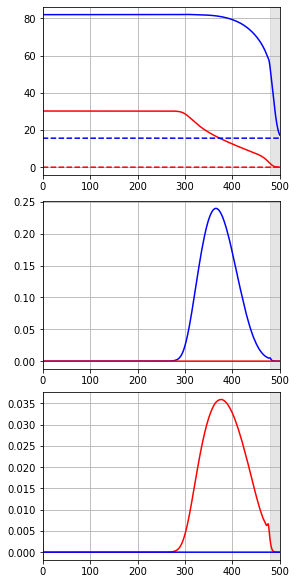

-------  13 0.4000000000000001 0.4500000000000002
--------------- k  0
set cost params:  1.0 990.0 0.0
interpolate adjoint :  True True True
initial cost =  15.68566180167018
RUN  0 , total integrated cost =  15.68566180167018
Gradient descend method:  None
RUN  1 , total integrated cost =  15.66633534666125
RUN  2 , total integrated cost =  15.64805759827944
RUN  3 , total integrated cost =  15.632605595723566
RUN  4 , total integrated cost =  15.614868401732831
RUN  5 , total integrated cost =  15.600679856320097
RUN  6 , total integrated cost =  15.583501107883082
RUN  7 , total integrated cost =  15.570325310500882
RUN  8 , total integrated cost =  15.555345508486024
RUN  9 , total integrated cost =  15.543572588803558
RUN  10 , total integrated cost =  15.529526382919833
RUN  11 , total integrated cost =  15.5188593462621
RUN  12 , total integrated cost =  15.505790982101702
RUN  13 , total integrated cost =  15.495766402390515
RUN  14 , total integrated cost =  15.484196963344818

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  13.21998494363145
RUN  100 , total integrated cost =  13.21998494363145
Improved over  100  iterations in  56.721417932072654  seconds by  15.719303968266033  percent.
Problem in initial value trasfer post:  sigmae_f 1.5350021684601989 1.5350021840067398
Problem in initial value trasfer post:  tau_exc 21.19475787189922 21.194757781812616
cost splitting :  0.038295950730786656 [8.14924680e-23 1.20752908e-02 1.23954658e-03 0.00000000e+00]
--------------- k  1
set cost params:  1.0 79037.65443741405 0.0
interpolate adjoint :  True True True
initial cost =  1052.4118106197711
RUN  0 , total integrated cost =  1052.4118106197711
Gradient descend method:  None
RUN  1 , total integrated cost =  1041.5965654792021
RUN  2 , total integrated cost =  1041.5297222614843
RUN  3 , total integrated cost =  1041.4650649076166
RUN  4 , total integrated cost =  1041.4176390561297
RUN  5 , total integrated cost =  1041.368137585994
RUN  6 , total integrated cost =  104

RUN  1 , total integrated cost =  9374.437277195699
RUN  2 , total integrated cost =  9374.42790942375
Control only changes marginally.
RUN  2 , total integrated cost =  9374.42790942375
Improved over  2  iterations in  2.4742513810051605  seconds by  0.0013215393233565464  percent.
cost splitting :  11.901332309052682 [2.76376917e-25 1.13936345e-02 1.17366045e-03 0.00000000e+00]
--------------- k  10
set cost params:  1.0 827803.2493129012 0.0
interpolate adjoint :  True True True
initial cost =  10414.76987895599
RUN  0 , total integrated cost =  10414.76987895599
Gradient descend method:  None
RUN  1 , total integrated cost =  10414.651754064744
RUN  2 , total integrated cost =  10414.641950030466
RUN  3 , total integrated cost =  10414.622302469194
RUN  4 , total integrated cost =  10414.61345649025
Control only changes marginally.
RUN  4 , total integrated cost =  10414.61345649025
Improved over  4  iterations in  4.5025933990255  seconds by  0.0015019291598292739  percent.
cost s

RUN  1 , total integrated cost =  22896.976435971657
RUN  2 , total integrated cost =  22896.939012845916
RUN  3 , total integrated cost =  22896.885394584708
RUN  4 , total integrated cost =  22896.86498961678
Control only changes marginally.
RUN  4 , total integrated cost =  22896.86498961678
Improved over  4  iterations in  4.736964776995592  seconds by  0.0009726200894988324  percent.
cost splitting :  31.685727602550376 [3.14288490e-25 1.13784624e-02 1.17210779e-03 0.00000000e+00]
--------------- k  23
set cost params:  1.0 1904832.3575759518 0.0
interpolate adjoint :  True True True
initial cost =  23937.23485596003
RUN  0 , total integrated cost =  23937.23485596003
Gradient descend method:  None
RUN  1 , total integrated cost =  23937.130012565733
RUN  2 , total integrated cost =  23937.114160407724
Control only changes marginally.
RUN  2 , total integrated cost =  23937.114160407724
Improved over  2  iterations in  2.535498257027939  seconds by  0.0005042167695279431  percent.

RUN  1 , total integrated cost =  36415.92838703375
RUN  2 , total integrated cost =  36415.9004782922
Control only changes marginally.
RUN  2 , total integrated cost =  36415.9004782922
Improved over  2  iterations in  2.6549979320261627  seconds by  0.0003404133173887658  percent.
cost splitting :  52.848929001353135 [3.77940067e-25 1.13705423e-02 1.17048609e-03 0.00000000e+00]
--------------- k  36
set cost params:  1.0 2982577.1883563725 0.0
interpolate adjoint :  True True True
initial cost =  37455.59433547955
RUN  0 , total integrated cost =  37455.59433547955
Gradient descend method:  None
RUN  1 , total integrated cost =  37455.49155661667
RUN  2 , total integrated cost =  37455.45475604081
Control only changes marginally.
RUN  2 , total integrated cost =  37455.45475604081
Improved over  2  iterations in  2.665192355052568  seconds by  0.00037265311422629566  percent.
cost splitting :  54.39717399422578 [3.83272296e-25 1.13700348e-02 1.17044351e-03 0.00000000e+00]
-----------

RUN  1 , total integrated cost =  50968.61872052483
RUN  2 , total integrated cost =  50968.57700954866
Control only changes marginally.
RUN  2 , total integrated cost =  50968.57700954866
Improved over  2  iterations in  2.6420225389301777  seconds by  0.0003025874778330717  percent.
cost splitting :  76.22958406286706 [4.79272780e-25 1.13641013e-02 1.16995780e-03 0.00000000e+00]
--------------- k  50
set cost params:  1.0 4143453.472848257 0.0
interpolate adjoint :  True True True
initial cost =  52007.56089360592
RUN  0 , total integrated cost =  52007.56089360592
Gradient descend method:  None
RUN  1 , total integrated cost =  52007.41617862287
RUN  2 , total integrated cost =  52007.362176166454
Control only changes marginally.
RUN  2 , total integrated cost =  52007.362176166454
Improved over  2  iterations in  2.6724940879503265  seconds by  0.00038209336499051005  percent.
cost splitting :  78.68378058475672 [4.90003635e-25 1.13635107e-02 1.16990749e-03 0.00000000e+00]
--------

RUN  1 , total integrated cost =  75901.37984165753
RUN  2 , total integrated cost =  75901.31711214376
Control only changes marginally.
RUN  2 , total integrated cost =  75901.31711214376
Improved over  2  iterations in  2.5929748099297285  seconds by  0.00027300839275312683  percent.
cost splitting :  119.87714147129394 [7.39649976e-25 1.13554006e-02 1.16957387e-03 0.00000000e+00]
--------------- k  74
set cost params:  1.0 6133704.519163786 0.0
interpolate adjoint :  True True True
initial cost =  76940.12778997296
RUN  0 , total integrated cost =  76940.12778997296
Gradient descend method:  None
RUN  1 , total integrated cost =  76939.97390488496
RUN  2 , total integrated cost =  76939.90174442947
Control only changes marginally.
RUN  2 , total integrated cost =  76939.90174442947
Improved over  2  iterations in  2.6945701020304114  seconds by  0.00029379408375973526  percent.
cost splitting :  122.04735405677471 [7.68712415e-25 1.13550561e-02 1.16954904e-03 0.00000000e+00]
-------

RUN  1 , total integrated cost =  90436.00719743886
RUN  2 , total integrated cost =  90435.9382374489
Control only changes marginally.
RUN  2 , total integrated cost =  90435.9382374489
Improved over  2  iterations in  1.8679107759380713  seconds by  0.00025588877024063095  percent.
cost splitting :  146.2853145988845 [1.30475732e-24 1.13513337e-02 1.16930489e-03 0.00000000e+00]
--------------- k  88
set cost params:  1.0 7294617.574536546 0.0
interpolate adjoint :  True True True
initial cost =  91474.41804070935
RUN  0 , total integrated cost =  91474.41804070935
Gradient descend method:  None
RUN  1 , total integrated cost =  91474.2444505265
RUN  2 , total integrated cost =  91474.14769790125
Control only changes marginally.
RUN  2 , total integrated cost =  91474.14769790125
Improved over  2  iterations in  2.0505697010084987  seconds by  0.00029553924899516915  percent.
cost splitting :  148.75342160458916 [1.36190614e-24 1.13509551e-02 1.16927701e-03 0.00000000e+00]
-----------

RUN  1 , total integrated cost =  103925.83468876085
RUN  2 , total integrated cost =  103925.62925771365
Control only changes marginally.
RUN  2 , total integrated cost =  103925.62925771365
Improved over  2  iterations in  2.5817365660332143  seconds by  0.00047104543156706313  percent.
cost splitting :  139.04487922744303 [3.47718443e-27 1.13207868e-02 1.16489323e-03 0.00000000e+00]
--------------- k  101
set cost params:  1.0 8312991.936027491 0.0
interpolate adjoint :  True True True
initial cost =  103924.21632609054
RUN  0 , total integrated cost =  103924.21632609054
Gradient descend method:  None
RUN  1 , total integrated cost =  103917.24325516267
RUN  2 , total integrated cost =  103911.31003389151
RUN  3 , total integrated cost =  103911.16267060784
RUN  4 , total integrated cost =  103910.9436302846
RUN  5 , total integrated cost =  103910.87569338926
Control only changes marginally.
RUN  5 , total integrated cost =  103910.87569338926
Improved over  5  iterations in  5.62

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  96502.3572876129
Control only changes marginally.
RUN  8 , total integrated cost =  96502.3572876129
Improved over  8  iterations in  4.94662222196348  seconds by  7.144963602442047  percent.
Problem in initial value trasfer post:  sigmae_f 1.5048664008665487 1.5048668094631725
Problem in initial value trasfer post:  tau_exc 3.284486122608133 3.2844859059258855
cost splitting :  89318.6195186526 [6.07643349e-12 8.10960382e-04 5.30572235e-05 6.27478744e-26]
converged to zero, reload and break
file found
-------  14 0.4250000000000001 0.4500000000000002
--------------- k  0
set cost params:  1.0 990.0 0.0
interpolate adjoint :  True True True
initial cost =  1955.0441570952298
RUN  0 , total integrated cost =  1955.0441570952298
Gradient descend method:  None
RUN  1 , total integrated cost =  1954.8187964372896
RUN  2 , total integrated cost =  1954.6745129794915
RUN  3 , total integrated cost =  1954.4952779013606
RUN  4 , total integrated cost =  1954.

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  1911.290367339206
RUN  100 , total integrated cost =  1911.290367339206
Improved over  100  iterations in  73.37901743489783  seconds by  2.237994962785521  percent.
Problem in initial value trasfer post:  sigmae_f 1.5344461327306596 1.5344465375534648
Problem in initial value trasfer post:  tau_exc 20.898617227435857 20.89861454234771
cost splitting :  1.0545360158876647 [1.25001179e-18 1.87582398e+00 5.37071623e-02 0.00000000e+00]
--------------- k  1
set cost params:  1.0 2114.329139988077 0.0
interpolate adjoint :  True True True
initial cost =  4080.718457648458
RUN  0 , total integrated cost =  4080.718457648458
Gradient descend method:  None
RUN  1 , total integrated cost =  4080.205206335309
RUN  2 , total integrated cost =  4080.2046567112307
RUN  3 , total integrated cost =  4080.2034296898123
RUN  4 , total integrated cost =  4080.2027476653157
RUN  5 , total integrated cost =  4080.2020910983606
RUN  6 , total integrated cost =  4080.2003

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  4080.142113229445
RUN  100 , total integrated cost =  4080.142113229445
Improved over  100  iterations in  65.81488393899053  seconds by  0.014123601640108063  percent.
Problem in initial value trasfer post:  sigmae_f 1.5342005991115104 1.5342009940678412
Problem in initial value trasfer post:  tau_exc 20.852229958681363 20.852227311025413
cost splitting :  2.2483412629607784 [1.25013285e-18 1.87485882e+00 5.38351058e-02 0.00000000e+00]
--------------- k  2
set cost params:  1.0 3239.6306026858824 0.0
interpolate adjoint :  True True True
initial cost =  6250.504210374855
RUN  0 , total integrated cost =  6250.504210374855
Gradient descend method:  None
RUN  1 , total integrated cost =  6250.220585661228
RUN  2 , total integrated cost =  6250.219933092586
RUN  3 , total integrated cost =  6250.186170344692
RUN  4 , total integrated cost =  6250.160504475125
RUN  5 , total integrated cost =  6250.158298369751
RUN  6 , total integrated cost =  6250.155

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  32 , total integrated cost =  6247.67538746439
Improved over  32  iterations in  25.214839035994373  seconds by  0.04525751547801349  percent.
Problem in initial value trasfer post:  sigmae_f 1.5340793085290532 1.5340794642433542
Problem in initial value trasfer post:  tau_exc 20.825223888972708 20.825222835230257
cost splitting :  3.2562822143103713 [1.38446383e-18 1.87427491e+00 5.32420036e-02 0.00000000e+00]
--------------- k  3
set cost params:  1.0 4366.508914572334 0.0
interpolate adjoint :  True True True
initial cost =  8419.752392992163
RUN  0 , total integrated cost =  8419.752392992163
Gradient descend method:  None
RUN  1 , total integrated cost =  8419.557105735215
RUN  2 , total integrated cost =  8419.546187245332
RUN  3 , total integrated cost =  8419.535025970905
RUN  4 , total integrated cost =  8419.534739156561
RUN  5 , total integrated cost =  8419.530486243528
RUN  6 , total integrated cost =  8419.526006452967
RUN  7 , total 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  16 , total integrated cost =  8419.502809897016
Control only changes marginally.
RUN  16 , total integrated cost =  8419.502809897016
Improved over  16  iterations in  10.388768777018413  seconds by  0.002964256946015098  percent.
Problem in initial value trasfer post:  sigmae_f 1.5338839349144062 1.533884090936846
Problem in initial value trasfer post:  tau_exc 20.80427226636566 20.804271200757285
cost splitting :  4.433855192138288 [1.38445689e-18 1.87391166e+00 5.32817369e-02 0.00000000e+00]
--------------- k  4
set cost params:  1.0 5492.749846631391 0.0
interpolate adjoint :  True True True
initial cost =  10589.986895219745
RUN  0 , total integrated cost =  10589.986895219745
Gradient descend method:  None
RUN  1 , total integrated cost =  10589.848822085285
RUN  2 , total integrated cost =  10589.848466784979
RUN  3 , total integrated cost =  10588.440766137126
RUN  4 , total integrated cost =  10588.124025460353
RUN  5 , total integrated cost =  10588.12062492651
RUN  6 , 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  230 , total integrated cost =  10586.64193240532
Improved over  230  iterations in  165.12948883802164  seconds by  0.03158609021446068  percent.
Problem in initial value trasfer post:  sigmae_f 1.5337854166862142 1.5337856043207427
Problem in initial value trasfer post:  tau_exc 20.79243664005684 20.792435351935595
cost splitting :  5.152987855390629 [1.30683045e-18 1.87278206e+00 5.36728010e-02 0.00000000e+00]
--------------- k  5
set cost params:  1.0 6620.595364834239 0.0
interpolate adjoint :  True True True
initial cost =  12759.385412211328
RUN  0 , total integrated cost =  12759.385412211328
Gradient descend method:  None
RUN  1 , total integrated cost =  12759.263570887337
RUN  2 , total integrated cost =  12759.26326300485
RUN  3 , total integrated cost =  12759.246486198357
RUN  4 , total integrated cost =  12759.237695520089
RUN  5 , total integrated cost =  12759.237402620578
RUN  6 , total integrated cost =  12759.2191114445
RUN  7 , 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  142 , total integrated cost =  12756.154928732776
Improved over  142  iterations in  102.3102724700002  seconds by  0.025318488110400494  percent.
Problem in initial value trasfer post:  sigmae_f 1.533687622723994 1.5336877754660523
Problem in initial value trasfer post:  tau_exc 20.781259474936867 20.781258421258052
cost splitting :  5.874886370031985 [1.19741361e-18 1.87232933e+00 5.35265947e-02 0.00000000e+00]
--------------- k  6
set cost params:  1.0 7748.811743985737 0.0
interpolate adjoint :  True True True
initial cost =  14928.937124829876
RUN  0 , total integrated cost =  14928.937124829876
Gradient descend method:  None
RUN  1 , total integrated cost =  14928.837531385934
RUN  2 , total integrated cost =  14928.837371651394
RUN  3 , total integrated cost =  14928.8357576026


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  14928.83563025685
Control only changes marginally.
RUN  4 , total integrated cost =  14928.83563025685
Improved over  4  iterations in  2.5014449290465564  seconds by  0.0006798512993668737  percent.
Problem in initial value trasfer post:  sigmae_f 1.533523936465408 1.5335240881054146
Problem in initial value trasfer post:  tau_exc 20.7681215068478 20.768120454676307
cost splitting :  7.030082934755173 [1.19729595e-18 1.87217040e+00 5.35218912e-02 0.00000000e+00]
--------------- k  7
set cost params:  1.0 8875.914319592357 0.0
interpolate adjoint :  True True True
initial cost =  17099.28836610893
RUN  0 , total integrated cost =  17099.28836610893
Gradient descend method:  None
RUN  1 , total integrated cost =  17099.225627449898


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  17099.225347673964
Control only changes marginally.
RUN  2 , total integrated cost =  17099.225347673964
Improved over  2  iterations in  1.4377061040140688  seconds by  0.00036854419678888917  percent.
Problem in initial value trasfer post:  sigmae_f 1.5334039921351161 1.5334041429638918
Problem in initial value trasfer post:  tau_exc 20.759226868255997 20.75922581757871
cost splitting :  7.977217086922201 [1.19729843e-18 1.87206153e+00 5.35221138e-02 0.00000000e+00]
--------------- k  8
set cost params:  1.0 10002.947111292002 0.0
interpolate adjoint :  True True True
initial cost =  19269.42125863255
RUN  0 , total integrated cost =  19269.42125863255
Gradient descend method:  None
RUN  1 , total integrated cost =  19269.35478188298


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  19269.354433405064
Control only changes marginally.
RUN  2 , total integrated cost =  19269.354433405064
Improved over  2  iterations in  1.4933291730703786  seconds by  0.00034679415944083303  percent.
Problem in initial value trasfer post:  sigmae_f 1.5332769471613186 1.5332770971237062
Problem in initial value trasfer post:  tau_exc 20.750339354842737 20.750338306069107
cost splitting :  8.981018608936003 [1.19730771e-18 1.87195448e+00 5.35223261e-02 0.00000000e+00]
--------------- k  9
set cost params:  1.0 11130.086151479645 0.0
interpolate adjoint :  True True True
initial cost =  21439.634509695232
RUN  0 , total integrated cost =  21439.634509695232
Gradient descend method:  None
RUN  1 , total integrated cost =  21439.571607653328


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  21439.571419613214
Control only changes marginally.
RUN  2 , total integrated cost =  21439.571419613214
Improved over  2  iterations in  2.162345038028434  seconds by  0.00029426845867419615  percent.
Problem in initial value trasfer post:  sigmae_f 1.533145940952461 1.5331460900153766
Problem in initial value trasfer post:  tau_exc 20.740150606342745 20.740149559813393
cost splitting :  10.031388217560405 [1.19732001e-18 1.87185142e+00 5.35224262e-02 0.00000000e+00]
--------------- k  10
set cost params:  1.0 12257.315629758366 0.0
interpolate adjoint :  True True True
initial cost =  23609.909571771364
RUN  0 , total integrated cost =  23609.909571771364
Gradient descend method:  None
RUN  1 , total integrated cost =  23609.854638483775
RUN  2 , total integrated cost =  23609.85422993205
RUN  3 , total integrated cost =  23609.83534541401
RUN  4 , total integrated cost =  23609.810158532764
RUN  5 , total integrated cost =  23609.80987533792
RUN  6 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  11 , total integrated cost =  23608.909443954868
Control only changes marginally.
RUN  11 , total integrated cost =  23608.909443954868
Improved over  11  iterations in  10.433183057932183  seconds by  0.004236051025344523  percent.
Problem in initial value trasfer post:  sigmae_f 1.5330470511545309 1.5330471907667464
Problem in initial value trasfer post:  tau_exc 20.732448296344675 20.732447313413648
cost splitting :  10.939601723580836 [1.20744247e-18 1.87159956e+00 5.36223179e-02 0.00000000e+00]
--------------- k  11
set cost params:  1.0 13384.982188603197 0.0
interpolate adjoint :  True True True
initial cost =  25779.9177766739
RUN  0 , total integrated cost =  25779.9177766739
Gradient descend method:  None
RUN  1 , total integrated cost =  25779.857075865526


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  25779.856978779553
Control only changes marginally.
RUN  2 , total integrated cost =  25779.856978779553
Improved over  2  iterations in  2.2350651590386406  seconds by  0.0002358343221828818  percent.
Problem in initial value trasfer post:  sigmae_f 1.532909989714149 1.5329101284269664
Problem in initial value trasfer post:  tau_exc 20.722078533860643 20.722077553568965
cost splitting :  12.097193184950978 [1.20743243e-18 1.87150617e+00 5.36196178e-02 0.00000000e+00]
--------------- k  12
set cost params:  1.0 14512.407454946979 0.0
interpolate adjoint :  True True True
initial cost =  27950.292434187402
RUN  0 , total integrated cost =  27950.292434187402
Gradient descend method:  None
RUN  1 , total integrated cost =  27950.252945155033
RUN  2 , total integrated cost =  27950.252520214268
RUN  3 , total integrated cost =  27950.239598810524
RUN  4 , total integrated cost =  27950.22395771998
RUN  5 , total integrated cost =  27950.22353114562
RUN  6

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  11 , total integrated cost =  27950.21203742225
Control only changes marginally.
RUN  11 , total integrated cost =  27950.21203742225
Improved over  11  iterations in  9.718547280994244  seconds by  0.0002876419463007096  percent.
Problem in initial value trasfer post:  sigmae_f 1.532809131193259 1.5328092689357904
Problem in initial value trasfer post:  tau_exc 20.714759720394383 20.71475874436082
cost splitting :  13.190380165465626 [1.20807708e-18 1.87147613e+00 5.35795188e-02 0.00000000e+00]
--------------- k  13
set cost params:  1.0 15639.739370910202 0.0
interpolate adjoint :  True True True
initial cost =  30120.388708865463
RUN  0 , total integrated cost =  30120.388708865463
Gradient descend method:  None
RUN  1 , total integrated cost =  30120.349523085617


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  30120.349208159467
Control only changes marginally.
RUN  2 , total integrated cost =  30120.349208159467
Improved over  2  iterations in  2.310481907101348  seconds by  0.00013114274976544493  percent.
Problem in initial value trasfer post:  sigmae_f 1.5327101902473157 1.5327103273381277
Problem in initial value trasfer post:  tau_exc 20.70781351077824 20.707812536899237
cost splitting :  14.001964234652215 [1.20810715e-18 1.87141345e+00 5.35795920e-02 0.00000000e+00]
--------------- k  14
set cost params:  1.0 16767.10101806935 0.0
interpolate adjoint :  True True True
initial cost =  32290.512529264033
RUN  0 , total integrated cost =  32290.512529264033
Gradient descend method:  None
RUN  1 , total integrated cost =  32290.472169219596
RUN  2 , total integrated cost =  32290.47176436127
RUN  3 , total integrated cost =  32290.46900999355
RUN  4 , total integrated cost =  32290.46505938089


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  32290.46457438115
Control only changes marginally.
RUN  5 , total integrated cost =  32290.46457438115
Improved over  5  iterations in  4.806519303936511  seconds by  0.0001485107516998596  percent.
Problem in initial value trasfer post:  sigmae_f 1.5326053967679303 1.5326055331453108
Problem in initial value trasfer post:  tau_exc 20.700709452480496 20.700708481153885
cost splitting :  15.108420212402349 [1.20848302e-18 1.87132972e+00 5.35987954e-02 0.00000000e+00]
--------------- k  15
set cost params:  1.0 17894.522201712585 0.0
interpolate adjoint :  True True True
initial cost =  34460.66975546917
RUN  0 , total integrated cost =  34460.66975546917
Gradient descend method:  None
RUN  1 , total integrated cost =  34460.63240575952
RUN  2 , total integrated cost =  34460.63200048221
RUN  3 , total integrated cost =  34460.24782367298
RUN  4 , total integrated cost =  34459.83315997835


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  34459.83282538546
Control only changes marginally.
RUN  5 , total integrated cost =  34459.83282538546
Improved over  5  iterations in  5.079454275895841  seconds by  0.002428652982217727  percent.
Problem in initial value trasfer post:  sigmae_f 1.5325197449051169 1.532519873160985
Problem in initial value trasfer post:  tau_exc 20.69522743495507 20.69522651963583
cost splitting :  15.970122870628224 [1.35160902e-18 1.87124434e+00 5.35868057e-02 0.00000000e+00]
--------------- k  16
set cost params:  1.0 19022.3388651284 0.0
interpolate adjoint :  True True True
initial cost =  36630.68946286428
RUN  0 , total integrated cost =  36630.68946286428
Gradient descend method:  None
RUN  1 , total integrated cost =  36630.6513046302


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  36630.65073747749
Control only changes marginally.
RUN  2 , total integrated cost =  36630.65073747749
Improved over  2  iterations in  2.3420071590226144  seconds by  0.00010571842177853341  percent.
Problem in initial value trasfer post:  sigmae_f 1.5324209203543382 1.5324210479863325
Problem in initial value trasfer post:  tau_exc 20.688807330333496 20.688806417328216
cost splitting :  17.10550067077145 [1.35174369e-18 1.87118857e+00 5.35870706e-02 0.00000000e+00]
--------------- k  17
set cost params:  1.0 20149.817127959624 0.0
interpolate adjoint :  True True True
initial cost =  38800.793429349396
RUN  0 , total integrated cost =  38800.793429349396
Gradient descend method:  None
RUN  1 , total integrated cost =  38800.75456661561


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  38800.75439778506
Control only changes marginally.
RUN  2 , total integrated cost =  38800.75439778506
Improved over  2  iterations in  2.3512261300347745  seconds by  0.00010059475822288277  percent.
Problem in initial value trasfer post:  sigmae_f 1.5323141357241767 1.5323142626846435
Problem in initial value trasfer post:  tau_exc 20.682017598525555 20.68201668806841
cost splitting :  18.10092062176978 [1.35179348e-18 1.87113057e+00 5.35871445e-02 0.00000000e+00]
--------------- k  18
set cost params:  1.0 21277.387988730014 0.0
interpolate adjoint :  True True True
initial cost =  40971.01000711494
RUN  0 , total integrated cost =  40971.01000711494
Gradient descend method:  None
RUN  1 , total integrated cost =  40970.976934806844


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  40970.97668215607
Control only changes marginally.
RUN  2 , total integrated cost =  40970.97668215607
Improved over  2  iterations in  2.3700944400625303  seconds by  8.133789933140179e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.532218759613462 1.5322188859667463
Problem in initial value trasfer post:  tau_exc 20.676071529756495 20.6760706216828
cost splitting :  19.203291618772305 [1.35201757e-18 1.87108188e+00 5.35857298e-02 0.00000000e+00]
--------------- k  19
set cost params:  1.0 22404.918606321535 0.0
interpolate adjoint :  True True True
initial cost =  43141.09834479489
RUN  0 , total integrated cost =  43141.09834479489
Gradient descend method:  None
RUN  1 , total integrated cost =  43141.063669168914
RUN  2 , total integrated cost =  43141.063218115996
RUN  3 , total integrated cost =  43141.060503986475
RUN  4 , total integrated cost =  43141.054737842926


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  43141.05429925902
Control only changes marginally.
RUN  5 , total integrated cost =  43141.05429925902
Improved over  5  iterations in  4.655351100023836  seconds by  0.00010209646383430027  percent.
Problem in initial value trasfer post:  sigmae_f 1.5321147397245105 1.532114865400471
Problem in initial value trasfer post:  tau_exc 20.669803984577307 20.669803079296827
cost splitting :  20.39667401189767 [1.35256079e-18 1.87100847e+00 5.36051576e-02 0.00000000e+00]
--------------- k  20
set cost params:  1.0 23532.53341287815 0.0
interpolate adjoint :  True True True
initial cost =  45311.27712460176
RUN  0 , total integrated cost =  45311.27712460176
Gradient descend method:  None
RUN  1 , total integrated cost =  45311.246895405246


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  45311.24671342641
Control only changes marginally.
RUN  2 , total integrated cost =  45311.24671342641
Improved over  2  iterations in  2.4734407030045986  seconds by  6.711612931553645e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5320148160847138 1.5320149411286703
Problem in initial value trasfer post:  tau_exc 20.663751240067583 20.663750337346393
cost splitting :  21.48084165125967 [1.35261205e-18 1.87101252e+00 5.35513709e-02 0.00000000e+00]
--------------- k  21
set cost params:  1.0 24660.15891662291 0.0
interpolate adjoint :  True True True
initial cost =  47481.434036669125
RUN  0 , total integrated cost =  47481.434036669125
Gradient descend method:  None
RUN  1 , total integrated cost =  47481.41354405056


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  47481.41314970258
Control only changes marginally.
RUN  2 , total integrated cost =  47481.41314970258
Improved over  2  iterations in  2.582100663916208  seconds by  4.3989755084794524e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.531937605091663 1.5319377296304937
Problem in initial value trasfer post:  tau_exc 20.65912604157997 20.659125140985996
cost splitting :  22.44578746418189 [1.35292927e-18 1.87097600e+00 5.35503326e-02 0.00000000e+00]
--------------- k  22
set cost params:  1.0 25787.687114599845 0.0
interpolate adjoint :  True True True
initial cost =  49651.37086284486
RUN  0 , total integrated cost =  49651.37086284486
Gradient descend method:  None
RUN  1 , total integrated cost =  49651.3471914871
RUN  2 , total integrated cost =  49651.34624733559
RUN  3 , total integrated cost =  49651.34140485311
RUN  4 , total integrated cost =  49651.333852488315


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  49651.33272471823
Control only changes marginally.
RUN  5 , total integrated cost =  49651.33272471823
Improved over  5  iterations in  5.113357766997069  seconds by  7.681183009822234e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.53186688385739 1.5318670078208227
Problem in initial value trasfer post:  tau_exc 20.654947232269972 20.654946334468022
cost splitting :  23.42334395886086 [1.35593100e-18 1.87093390e+00 5.35579607e-02 0.00000000e+00]
--------------- k  23
set cost params:  1.0 26915.206361364126 0.0
interpolate adjoint :  True True True
initial cost =  51821.23434076086
RUN  0 , total integrated cost =  51821.23434076086
Gradient descend method:  None
RUN  1 , total integrated cost =  51821.20359344866
RUN  2 , total integrated cost =  51821.20338603792
RUN  3 , total integrated cost =  51821.20235900488
RUN  4 , total integrated cost =  51821.193083651306
RUN  5 , total integrated cost =  51821.188266221005


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  51821.18811851958
Control only changes marginally.
RUN  6 , total integrated cost =  51821.18811851958
Improved over  6  iterations in  5.759132727049291  seconds by  8.919556213982105e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.531787329117375 1.5317874524461204
Problem in initial value trasfer post:  tau_exc 20.650292301956306 20.6502914072318
cost splitting :  24.227452848479384 [1.35643815e-18 1.87088469e+00 5.35689941e-02 0.00000000e+00]
--------------- k  24
set cost params:  1.0 28042.830342861263 0.0
interpolate adjoint :  True True True
initial cost =  53991.24824617726
RUN  0 , total integrated cost =  53991.24824617726
Gradient descend method:  None
RUN  1 , total integrated cost =  53991.217180920685


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  53991.216971496564
Control only changes marginally.
RUN  2 , total integrated cost =  53991.216971496564
Improved over  2  iterations in  2.29544664605055  seconds by  5.792546330951609e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5317037514874294 1.5317038742657425
Problem in initial value trasfer post:  tau_exc 20.64542128109422 20.645420388778994
cost splitting :  25.207023346106055 [1.35648697e-18 1.87084626e+00 5.35690342e-02 0.00000000e+00]
--------------- k  25
set cost params:  1.0 29170.471524193203 0.0
interpolate adjoint :  True True True
initial cost =  56161.266903631236
RUN  0 , total integrated cost =  56161.266903631236
Gradient descend method:  None
RUN  1 , total integrated cost =  56161.23910190843


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  56161.238788826886
Control only changes marginally.
RUN  2 , total integrated cost =  56161.238788826886
Improved over  2  iterations in  2.349894742947072  seconds by  5.006084424508117e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5316136046127982 1.5316137267941596
Problem in initial value trasfer post:  tau_exc 20.640215684693153 20.640214794947564
cost splitting :  26.3999525840849 [1.35656017e-18 1.87080577e+00 5.35691125e-02 0.00000000e+00]
--------------- k  26
set cost params:  1.0 30298.15004457219 0.0
interpolate adjoint :  True True True
initial cost =  58331.315007560384
RUN  0 , total integrated cost =  58331.315007560384
Gradient descend method:  None
RUN  1 , total integrated cost =  58331.29332524767
RUN  2 , total integrated cost =  58331.2930114022
RUN  3 , total integrated cost =  58331.28842058492
RUN  4 , total integrated cost =  58331.279641241694


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  58331.27930525699
Control only changes marginally.
RUN  5 , total integrated cost =  58331.27930525699
Improved over  5  iterations in  4.817053026985377  seconds by  6.120606639115067e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5315252074982746 1.5315253290735662
Problem in initial value trasfer post:  tau_exc 20.63519087942653 20.635189991745836
cost splitting :  27.58673997434431 [1.35764436e-18 1.87074603e+00 5.35892171e-02 0.00000000e+00]
--------------- k  27
set cost params:  1.0 31425.85243779225 0.0
interpolate adjoint :  True True True
initial cost =  60501.3567682041
RUN  0 , total integrated cost =  60501.3567682041
Gradient descend method:  None
RUN  1 , total integrated cost =  60501.34054680691


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  60501.34003612819
Control only changes marginally.
RUN  2 , total integrated cost =  60501.34003612819
Improved over  2  iterations in  2.288094274001196  seconds by  2.765570361873415e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5314702768100616 1.5314703980209343
Problem in initial value trasfer post:  tau_exc 20.63198418758428 20.6319833010738
cost splitting :  28.414857473738536 [1.35797474e-18 1.87075238e+00 5.35591742e-02 0.00000000e+00]
--------------- k  28
set cost params:  1.0 32553.377812074796 0.0
interpolate adjoint :  True True True
initial cost =  62671.05013780405
RUN  0 , total integrated cost =  62671.05013780405
Gradient descend method:  None
RUN  1 , total integrated cost =  62671.01988917498
RUN  2 , total integrated cost =  62671.01932382976


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  62671.01929516727
Control only changes marginally.
RUN  3 , total integrated cost =  62671.01929516727
Improved over  3  iterations in  3.262908859993331  seconds by  4.9213531141845124e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5313924632169618 1.5313925839113
Problem in initial value trasfer post:  tau_exc 20.62747265991939 20.627471775096012
cost splitting :  29.260751986705774 [1.35831652e-18 1.87071446e+00 5.35640504e-02 0.00000000e+00]
--------------- k  29
set cost params:  1.0 33681.0801054186 0.0
interpolate adjoint :  True True True
initial cost =  64841.03258158944
RUN  0 , total integrated cost =  64841.03258158944
Gradient descend method:  None
RUN  1 , total integrated cost =  64841.00271994394
RUN  2 , total integrated cost =  64841.00228281234
RUN  3 , total integrated cost =  64841.00176941148
RUN  4 , total integrated cost =  64828.90551231043
RUN  5 , total integrated cost =  64826.88582329303
RUN  6 , total int

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  40 , total integrated cost =  64819.30468597045
Control only changes marginally.
RUN  40 , total integrated cost =  64819.30468597045
Improved over  40  iterations in  26.25438566203229  seconds by  0.033509484278567925  percent.
Problem in initial value trasfer post:  sigmae_f 1.5315943677635673 1.5315945117838405
Problem in initial value trasfer post:  tau_exc 20.63625557751047 20.636254526718222
cost splitting :  26.634352709156712 [2.78082337e-25 1.87026276e+00 5.34523510e-02 0.00000000e+00]
--------------- k  30
set cost params:  1.0 34818.75969164628 0.0
interpolate adjoint :  True True True
initial cost =  67007.8760948222
RUN  0 , total integrated cost =  67007.8760948222
Gradient descend method:  None
RUN  1 , total integrated cost =  67007.85076475941


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  67007.8503220622
Control only changes marginally.
RUN  2 , total integrated cost =  67007.8503220622
Improved over  2  iterations in  1.595269157900475  seconds by  3.84622846070215e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5315130065936224 1.5315131499574528
Problem in initial value trasfer post:  tau_exc 20.63150107422289 20.63150002560705
cost splitting :  27.683902473036817 [4.24146609e-25 1.87023151e+00 5.34524664e-02 0.00000000e+00]
--------------- k  31
set cost params:  1.0 35946.7864983215 0.0
interpolate adjoint :  True True True
initial cost =  69177.81741942979
RUN  0 , total integrated cost =  69177.81741942979
Gradient descend method:  None
RUN  1 , total integrated cost =  69177.7990563981
RUN  2 , total integrated cost =  69177.79740518784
RUN  3 , total integrated cost =  69177.78452236025
RUN  4 , total integrated cost =  69177.76749545087
RUN  5 , total integrated cost =  69177.76584391182
RUN  6 , total integr

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  21 , total integrated cost =  69174.16704998889
Improved over  21  iterations in  12.237853839993477  seconds by  0.005276791863451535  percent.
Problem in initial value trasfer post:  sigmae_f 1.531482917735412 1.5314830150081615
Problem in initial value trasfer post:  tau_exc 20.630537970626754 20.63053725874576
cost splitting :  28.265296818788865 [9.30731295e-24 1.87012121e+00 5.34463917e-02 0.00000000e+00]
--------------- k  32
set cost params:  1.0 37076.53045181588 0.0
interpolate adjoint :  True True True
initial cost =  71347.30591284423
RUN  0 , total integrated cost =  71347.30591284423
Gradient descend method:  None
RUN  1 , total integrated cost =  71347.27988033879


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  71347.27967983912
Control only changes marginally.
RUN  2 , total integrated cost =  71347.27967983912
Improved over  2  iterations in  2.2905016309814528  seconds by  3.676803878249757e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5314029144228911 1.5314030112625934
Problem in initial value trasfer post:  tau_exc 20.625909640082046 20.62590892964885
cost splitting :  29.315193123735344 [1.03127771e-23 1.87009149e+00 5.34465217e-02 0.00000000e+00]
--------------- k  33
set cost params:  1.0 38204.6318588325 0.0
interpolate adjoint :  True True True
initial cost =  73517.22561570718
RUN  0 , total integrated cost =  73517.22561570718
Gradient descend method:  None
RUN  1 , total integrated cost =  73517.20628961176


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  73517.20606703525
Control only changes marginally.
RUN  2 , total integrated cost =  73517.20606703525
Improved over  2  iterations in  2.282845463952981  seconds by  2.6590600725739932e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5313228731979565 1.5313229696040147
Problem in initial value trasfer post:  tau_exc 20.621319341798966 20.621318632844826
cost splitting :  30.341955812702956 [1.08192831e-23 1.87006237e+00 5.34465932e-02 0.00000000e+00]
--------------- k  34
set cost params:  1.0 39332.75057974568 0.0
interpolate adjoint :  True True True
initial cost =  75687.15253825158
RUN  0 , total integrated cost =  75687.15253825158
Gradient descend method:  None
RUN  1 , total integrated cost =  75687.13937594891


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  75687.13894013377
Control only changes marginally.
RUN  2 , total integrated cost =  75687.13894013377
Improved over  2  iterations in  2.3503844069782645  seconds by  1.796621667438103e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5312743485092157 1.531274444648209
Problem in initial value trasfer post:  tau_exc 20.618557831380134 20.61855712336738
cost splitting :  31.065145969755775 [1.51333016e-23 1.87004542e+00 5.34461714e-02 0.00000000e+00]
--------------- k  35
set cost params:  1.0 40460.70646371988 0.0
interpolate adjoint :  True True True
initial cost =  77856.75260302599
RUN  0 , total integrated cost =  77856.75260302599
Gradient descend method:  None
RUN  1 , total integrated cost =  77856.73029504114
RUN  2 , total integrated cost =  77856.72955660004


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  77856.72921257552
Control only changes marginally.
RUN  3 , total integrated cost =  77856.72921257552
Improved over  3  iterations in  2.5045589220244437  seconds by  3.004293101582789e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5312100696934419 1.5312101654749632
Problem in initial value trasfer post:  tau_exc 20.6149165016075 20.614915794882766
cost splitting :  31.968660258068795 [1.81546686e-23 1.87001557e+00 5.34532072e-02 0.00000000e+00]
--------------- k  36
set cost params:  1.0 41588.757664877776 0.0
interpolate adjoint :  True True True
initial cost =  80026.5004779669
RUN  0 , total integrated cost =  80026.5004779669
Gradient descend method:  None
RUN  1 , total integrated cost =  80026.47759208732


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  80026.47710950421
Control only changes marginally.
RUN  2 , total integrated cost =  80026.47710950421
Improved over  2  iterations in  2.148717063013464  seconds by  2.9200905387938292e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5311259867179028 1.5311260820374009
Problem in initial value trasfer post:  tau_exc 20.61016805682891 20.610167351766798
cost splitting :  33.2202511732583 [1.97308520e-23 1.86998609e+00 5.34533565e-02 0.00000000e+00]
--------------- k  37
set cost params:  1.0 42716.902055675266 0.0
interpolate adjoint :  True True True
initial cost =  82196.39453267542
RUN  0 , total integrated cost =  82196.39453267542
Gradient descend method:  None
RUN  1 , total integrated cost =  82196.37875796063


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  82196.37866835622
Control only changes marginally.
RUN  2 , total integrated cost =  82196.37866835622
Improved over  2  iterations in  2.2202978059649467  seconds by  1.9300504945363173e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5310632534375606 1.5310633484126208
Problem in initial value trasfer post:  tau_exc 20.60664383014898 20.60664312634169
cost splitting :  33.94584001864906 [2.39032421e-23 1.86996507e+00 5.34527959e-02 0.00000000e+00]
--------------- k  38
set cost params:  1.0 43844.997956089996 0.0
interpolate adjoint :  True True True
initial cost =  84366.17847346478
RUN  0 , total integrated cost =  84366.17847346478
Gradient descend method:  None
RUN  1 , total integrated cost =  84366.16274883448


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  84366.16213267074
Control only changes marginally.
RUN  2 , total integrated cost =  84366.16213267074
Improved over  2  iterations in  2.105325396056287  seconds by  1.936889205467196e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5309999377856305 1.5310000324065163
Problem in initial value trasfer post:  tau_exc 20.603095926172806 20.603095223692407
cost splitting :  35.007173813584174 [3.24942667e-23 1.86994405e+00 5.34522670e-02 0.00000000e+00]
--------------- k  39
set cost params:  1.0 44973.04287250318 0.0
interpolate adjoint :  True True True
initial cost =  86535.83956975363
RUN  0 , total integrated cost =  86535.83956975363
Gradient descend method:  None
RUN  1 , total integrated cost =  86535.8223508646


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  86535.82191439882
Control only changes marginally.
RUN  2 , total integrated cost =  86535.82191439882
Improved over  2  iterations in  2.2351049090502784  seconds by  2.0402361485594156e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.530938759192448 1.5309388534684707
Problem in initial value trasfer post:  tau_exc 20.59966610950065 20.59966540833017
cost splitting :  35.95807454198962 [3.55634890e-23 1.86992322e+00 5.34524063e-02 0.00000000e+00]
--------------- k  40
set cost params:  1.0 46101.10487182508 0.0
interpolate adjoint :  True True True
initial cost =  88705.50887369733
RUN  0 , total integrated cost =  88705.50887369733
Gradient descend method:  None
RUN  1 , total integrated cost =  88705.49107540381


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  88705.49075926079
Control only changes marginally.
RUN  2 , total integrated cost =  88705.49075926079
Improved over  2  iterations in  2.318403888028115  seconds by  2.042086987330549e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5308713235750566 1.5308714174738671
Problem in initial value trasfer post:  tau_exc 20.595894167534144 20.595893467798568
cost splitting :  36.85868245484745 [4.29485654e-23 1.86990128e+00 5.34518291e-02 0.00000000e+00]
--------------- k  41
set cost params:  1.0 47229.2366893967 0.0
interpolate adjoint :  True True True
initial cost =  90875.28659848621
RUN  0 , total integrated cost =  90875.28659848621
Gradient descend method:  None
RUN  1 , total integrated cost =  90875.27491894811


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  90875.27422877909
Control only changes marginally.
RUN  2 , total integrated cost =  90875.27422877909
Improved over  2  iterations in  2.376722759916447  seconds by  1.3611739319685512e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.530825867225336 1.5308259608617631
Problem in initial value trasfer post:  tau_exc 20.593353856982898 20.593353158281676
cost splitting :  37.749517087515585 [5.60138000e-23 1.86988652e+00 5.34514847e-02 0.00000000e+00]
--------------- k  42
set cost params:  1.0 48357.20368066715 0.0
interpolate adjoint :  True True True
initial cost =  93044.73601095585
RUN  0 , total integrated cost =  93044.73601095585
Gradient descend method:  None
RUN  1 , total integrated cost =  93044.71882350113


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  93044.7185003439
Control only changes marginally.
RUN  2 , total integrated cost =  93044.7185003439
Improved over  2  iterations in  2.382238229038194  seconds by  1.8819562185967698e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5307564593101513 1.5307565525535232
Problem in initial value trasfer post:  tau_exc 20.589466989649576 20.58946629247789
cost splitting :  38.636098778350664 [6.57193219e-23 1.86986425e+00 5.34508995e-02 0.00000000e+00]
--------------- k  43
set cost params:  1.0 49485.37735895804 0.0
interpolate adjoint :  True True True
initial cost =  95214.55202717046
RUN  0 , total integrated cost =  95214.55202717046
Gradient descend method:  None
RUN  1 , total integrated cost =  95214.54108292796


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  95214.5405249575
Control only changes marginally.
RUN  2 , total integrated cost =  95214.5405249575
Improved over  2  iterations in  2.3326393968891352  seconds by  1.208030991506348e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.530712178578699 1.5307122715643926
Problem in initial value trasfer post:  tau_exc 20.586997669508122 20.586996973373182
cost splitting :  39.52030481581174 [8.10697881e-23 1.86985011e+00 5.34505679e-02 0.00000000e+00]
--------------- k  44
set cost params:  1.0 50613.35121017739 0.0
interpolate adjoint :  True True True
initial cost =  97383.97339774229
RUN  0 , total integrated cost =  97383.97339774229
Gradient descend method:  None
RUN  1 , total integrated cost =  97383.95795180353


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  97383.95780734453
Control only changes marginally.
RUN  2 , total integrated cost =  97383.95780734453
Improved over  2  iterations in  2.4355818529147655  seconds by  1.60092027670089e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5306479024651238 1.5306479950800558
Problem in initial value trasfer post:  tau_exc 20.583381753256425 20.58338105860014
cost splitting :  40.43231493194012 [9.44265836e-23 1.86982969e+00 5.34500413e-02 0.00000000e+00]
--------------- k  45
set cost params:  1.0 51741.49880292467 0.0
interpolate adjoint :  True True True
initial cost =  99553.70120829457
RUN  0 , total integrated cost =  99553.70120829457
Gradient descend method:  None
RUN  1 , total integrated cost =  99553.68930674635


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  99553.68917321695
Control only changes marginally.
RUN  2 , total integrated cost =  99553.68917321695
Improved over  2  iterations in  2.4532049760455266  seconds by  1.2089030818174251e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.530600956905225 1.530601049246893
Problem in initial value trasfer post:  tau_exc 20.580747627699406 20.58074693415
cost splitting :  41.20377938910617 [1.07555392e-22 1.86981487e+00 5.34496690e-02 0.00000000e+00]
--------------- k  46
set cost params:  1.0 52869.538837106265 0.0
interpolate adjoint :  True True True
initial cost =  101723.20856885241
RUN  0 , total integrated cost =  101723.20856885241
Gradient descend method:  None
RUN  1 , total integrated cost =  101723.19535734254


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  101723.1949919093
Control only changes marginally.
RUN  2 , total integrated cost =  101723.1949919093
Improved over  2  iterations in  2.0177898859838024  seconds by  1.334694736954134e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5305461084882233 1.530546200505159
Problem in initial value trasfer post:  tau_exc 20.57764888154123 20.577648189326176
cost splitting :  42.26854984938165 [1.28234869e-22 1.86979759e+00 5.34492488e-02 0.00000000e+00]
--------------- k  47
set cost params:  1.0 53997.58677341022 0.0
interpolate adjoint :  True True True
initial cost =  103892.70962048076
RUN  0 , total integrated cost =  103892.70962048076
Gradient descend method:  None
RUN  1 , total integrated cost =  103892.69578997006


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  103892.6956921034
Control only changes marginally.
RUN  2 , total integrated cost =  103892.6956921034
Improved over  2  iterations in  1.812915364978835  seconds by  1.3406501196300269e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5304953360709577 1.5304954277901448
Problem in initial value trasfer post:  tau_exc 20.574795760280434 20.574795069290484
cost splitting :  43.019686189734806 [1.43735103e-22 1.86978178e+00 5.34488476e-02 0.00000000e+00]
--------------- k  48
set cost params:  1.0 55125.680733402995 0.0
interpolate adjoint :  True True True
initial cost =  106062.28054336579
RUN  0 , total integrated cost =  106062.28054336579
Gradient descend method:  None
RUN  1 , total integrated cost =  106062.26800886689
RUN  2 , total integrated cost =  106062.26626880218


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  106062.2655644721
Control only changes marginally.
RUN  3 , total integrated cost =  106062.2655644721
Improved over  3  iterations in  3.408982302993536  seconds by  1.4122733944077481e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5304669154569899 1.5304670069944861
Problem in initial value trasfer post:  tau_exc 20.573224585135044 20.57322389495496
cost splitting :  43.594690280792875 [1.84406674e-22 1.86976329e+00 5.34581835e-02 0.00000000e+00]
--------------- k  49
set cost params:  1.0 56253.62622940843 0.0
interpolate adjoint :  True True True
initial cost =  108231.55456134983
RUN  0 , total integrated cost =  108231.55456134983
Gradient descend method:  None
RUN  1 , total integrated cost =  108231.5288514697


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  108231.52849960799
Control only changes marginally.
RUN  2 , total integrated cost =  108231.52849960799
Improved over  2  iterations in  1.7099234049674124  seconds by  2.4079615172922786e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.530385653597509 1.5303857446609657
Problem in initial value trasfer post:  tau_exc 20.56867782281028 20.568677134596953
cost splitting :  44.89691722965074 [2.04301391e-22 1.86973846e+00 5.34575216e-02 0.00000000e+00]
--------------- k  50
set cost params:  1.0 57381.87071355861 0.0
interpolate adjoint :  True True True
initial cost =  110401.36375934277
RUN  0 , total integrated cost =  110401.36375934277
Gradient descend method:  None
RUN  1 , total integrated cost =  110401.35344489555
RUN  2 , total integrated cost =  110401.35158176029


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  110401.35149351032
Control only changes marginally.
RUN  3 , total integrated cost =  110401.35149351032
Improved over  3  iterations in  2.534253117046319  seconds by  1.1110218238741254e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5303551140644696 1.5303552049403524
Problem in initial value trasfer post:  tau_exc 20.56699298503895 20.566992297647563
cost splitting :  45.41629561457193 [2.35063067e-22 1.86972210e+00 5.34642858e-02 0.00000000e+00]
--------------- k  51
set cost params:  1.0 58509.85981471634 0.0
interpolate adjoint :  True True True
initial cost =  112570.68478138525
RUN  0 , total integrated cost =  112570.68478138525
Gradient descend method:  None
RUN  1 , total integrated cost =  112570.6637244046


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  112570.66329586427
Control only changes marginally.
RUN  2 , total integrated cost =  112570.66329586427
Improved over  2  iterations in  2.4300267160870135  seconds by  1.9086248798316774e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5302862681754805 1.5302863586446773
Problem in initial value trasfer post:  tau_exc 20.563155996003495 20.563155310339045
cost splitting :  46.701131838458046 [2.62864532e-22 1.86970142e+00 5.34637472e-02 0.00000000e+00]
--------------- k  52
set cost params:  1.0 59638.00554866455 0.0
interpolate adjoint :  True True True
initial cost =  114740.27388013399
RUN  0 , total integrated cost =  114740.27388013399
Gradient descend method:  None
RUN  1 , total integrated cost =  114740.2620800712


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  114740.26163973844
Control only changes marginally.
RUN  2 , total integrated cost =  114740.26163973844
Improved over  2  iterations in  2.291972919018008  seconds by  1.0667915574913422e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5302400769811628 1.530240167174444
Problem in initial value trasfer post:  tau_exc 20.560582433691863 20.560581749215963
cost splitting :  47.506853959691654 [2.89040248e-22 1.86968762e+00 5.34633988e-02 0.00000000e+00]
--------------- k  53
set cost params:  1.0 60766.07363757362 0.0
interpolate adjoint :  True True True
initial cost =  116909.7069303258
RUN  0 , total integrated cost =  116909.7069303258
Gradient descend method:  None
RUN  1 , total integrated cost =  116909.69069883782


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  116909.6904337098
Control only changes marginally.
RUN  2 , total integrated cost =  116909.6904337098
Improved over  2  iterations in  2.4007222100626677  seconds by  1.4110561437519209e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5301801611256676 1.5301802509589455
Problem in initial value trasfer post:  tau_exc 20.557244549415458 20.557243866505175
cost splitting :  48.62318250410137 [3.27524644e-22 1.86966985e+00 5.34629548e-02 0.00000000e+00]
--------------- k  54
set cost params:  1.0 61894.192413183046 0.0
interpolate adjoint :  True True True
initial cost =  119079.2126584173
RUN  0 , total integrated cost =  119079.2126584173
Gradient descend method:  None
RUN  1 , total integrated cost =  119079.20186607401


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  119079.20173941598
Control only changes marginally.
RUN  2 , total integrated cost =  119079.20173941598
Improved over  2  iterations in  2.4011941259959713  seconds by  9.169527643848596e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5301385217658432 1.530138611347644
Problem in initial value trasfer post:  tau_exc 20.554927938960798 20.554927257154542
cost splitting :  49.394923511031394 [3.58755461e-22 1.86965757e+00 5.34626519e-02 0.00000000e+00]
--------------- k  55
set cost params:  1.0 63022.236619460884 0.0
interpolate adjoint :  True True True
initial cost =  121248.56636096096
RUN  0 , total integrated cost =  121248.56636096096
Gradient descend method:  None
RUN  1 , total integrated cost =  121248.55143692943
RUN  2 , total integrated cost =  121248.55085672298
RUN  3 , total integrated cost =  121248.54678313431
RUN  4 , total integrated cost =  121248.53483236418
RUN  5 , total integrated cost =  121248.5343019651
RUN  

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  121248.51419940057
Control only changes marginally.
RUN  8 , total integrated cost =  121248.51419940057
Improved over  8  iterations in  7.653454352985136  seconds by  4.302035229386547e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5300701857205616 1.5300702748300252
Problem in initial value trasfer post:  tau_exc 20.551505122594072 20.55150444317941
cost splitting :  50.81126008341641 [4.01910704e-22 1.86966074e+00 5.34383217e-02 0.00000000e+00]
--------------- k  56
set cost params:  1.0 64150.38417472543 0.0
interpolate adjoint :  True True True
initial cost =  123418.05369898079
RUN  0 , total integrated cost =  123418.05369898079
Gradient descend method:  None
RUN  1 , total integrated cost =  123418.04596545157
RUN  2 , total integrated cost =  123418.0447656262


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  123418.04384727926
Control only changes marginally.
RUN  3 , total integrated cost =  123418.04384727926
Improved over  3  iterations in  3.1856513380771503  seconds by  7.98238282584407e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.530057894929931 1.5300579839494266
Problem in initial value trasfer post:  tau_exc 20.550836564380443 20.55083588541932
cost splitting :  51.028410355714755 [4.68857420e-22 1.86965035e+00 5.34449357e-02 0.00000000e+00]
--------------- k  57
set cost params:  1.0 65278.31113430425 0.0
interpolate adjoint :  True True True
initial cost =  125587.15486108302
RUN  0 , total integrated cost =  125587.15486108302
Gradient descend method:  None
RUN  1 , total integrated cost =  125587.13248730244
RUN  2 , total integrated cost =  125587.13118412287


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  125587.13100265713
Control only changes marginally.
RUN  3 , total integrated cost =  125587.13100265713
Improved over  3  iterations in  3.593335463083349  seconds by  1.8997504895423845e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5299970886225658 1.5299971772720693
Problem in initial value trasfer post:  tau_exc 20.547471106644377 20.5474704293423
cost splitting :  52.10744199520014 [5.26261281e-22 1.86962705e+00 5.34501568e-02 0.00000000e+00]
--------------- k  58
set cost params:  1.0 66406.47114582366 0.0
interpolate adjoint :  True True True
initial cost =  127756.66980288901
RUN  0 , total integrated cost =  127756.66980288901
Gradient descend method:  None
RUN  1 , total integrated cost =  127756.65164554204


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  127756.65128046508
Control only changes marginally.
RUN  2 , total integrated cost =  127756.65128046508
Improved over  2  iterations in  2.4758385630557314  seconds by  1.4498205018753652e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5299449994570624 1.5299450877915046
Problem in initial value trasfer post:  tau_exc 20.54455126803491 20.544550592135767
cost splitting :  52.98374480546712 [5.60379618e-22 1.86961202e+00 5.34497745e-02 0.00000000e+00]
--------------- k  59
set cost params:  1.0 67534.61029513708 0.0
interpolate adjoint :  True True True
initial cost =  129926.1325799595
RUN  0 , total integrated cost =  129926.1325799595
Gradient descend method:  None
RUN  1 , total integrated cost =  129926.11794809924
RUN  2 , total integrated cost =  129926.11600545199


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  129926.11559501207
Control only changes marginally.
RUN  3 , total integrated cost =  129926.11559501207
Improved over  3  iterations in  3.443395353970118  seconds by  1.3072772276245814e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5299063237733521 1.5299064118581427
Problem in initial value trasfer post:  tau_exc 20.54241818482493 20.542417510102805
cost splitting :  53.95048176914381 [5.90602922e-22 1.86959320e+00 5.34571930e-02 0.00000000e+00]
--------------- k  60
set cost params:  1.0 68662.58819965778 0.0
interpolate adjoint :  True True True
initial cost =  132095.27394898058
RUN  0 , total integrated cost =  132095.27394898058
Gradient descend method:  None
RUN  1 , total integrated cost =  132095.25114356738


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  132095.2511075954
Control only changes marginally.
RUN  2 , total integrated cost =  132095.2511075954
Improved over  2  iterations in  2.4699590960517526  seconds by  1.7291599078816944e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5298316358808088 1.529831723512631
Problem in initial value trasfer post:  tau_exc 20.5382177377507 20.5382170650647
cost splitting :  55.16695568717536 [6.31696729e-22 1.86957190e+00 5.34566321e-02 0.00000000e+00]
--------------- k  61
set cost params:  1.0 69790.86792393171 0.0
interpolate adjoint :  True True True
initial cost =  134264.96520645078
RUN  0 , total integrated cost =  134264.96520645078
Gradient descend method:  None
RUN  1 , total integrated cost =  134264.95487437575
RUN  2 , total integrated cost =  134264.95238301562


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  134264.95231340034
Control only changes marginally.
RUN  3 , total integrated cost =  134264.95231340034
Improved over  3  iterations in  3.4751934290397912  seconds by  9.602691534382757e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5298028533343493 1.5298029407704452
Problem in initial value trasfer post:  tau_exc 20.536628214897938 20.53662754317172
cost splitting :  55.85057622051603 [7.49089128e-22 1.86955627e+00 5.34638153e-02 0.00000000e+00]
--------------- k  62
set cost params:  1.0 70918.84053211563 0.0
interpolate adjoint :  True True True
initial cost =  136434.0662891111
RUN  0 , total integrated cost =  136434.0662891111
Gradient descend method:  None
RUN  1 , total integrated cost =  136434.04790515438


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  136434.0473843647
Control only changes marginally.
RUN  2 , total integrated cost =  136434.0473843647
Improved over  2  iterations in  2.4581440730253235  seconds by  1.3856324088123984e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5297368467750174 1.5297369338016746
Problem in initial value trasfer post:  tau_exc 20.532891135425853 20.532890465578667
cost splitting :  57.29291272038311 [8.17771161e-22 1.86953752e+00 5.34633417e-02 0.00000000e+00]
--------------- k  63
set cost params:  1.0 72046.96886653615 0.0
interpolate adjoint :  True True True
initial cost =  138603.43914495385
RUN  0 , total integrated cost =  138603.43914495385
Gradient descend method:  None
RUN  1 , total integrated cost =  138603.42967757137
RUN  2 , total integrated cost =  138603.42821909612


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  138603.4281573388
Control only changes marginally.
RUN  3 , total integrated cost =  138603.4281573388
Improved over  3  iterations in  3.481381393969059  seconds by  7.92737546362332e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5297096395563032 1.5297097264114075
Problem in initial value trasfer post:  tau_exc 20.531271054738596 20.531270385784676
cost splitting :  57.63156291593025 [8.67776946e-22 1.86952462e+00 5.34683884e-02 0.00000000e+00]
--------------- k  64
set cost params:  1.0 73175.04202540194 0.0
interpolate adjoint :  True True True
initial cost =  140772.70495353945
RUN  0 , total integrated cost =  140772.70495353945
Gradient descend method:  None
RUN  1 , total integrated cost =  140772.6880191605
RUN  2 , total integrated cost =  140772.6861690604
RUN  3 , total integrated cost =  140772.68562412634
RUN  4 , total integrated cost =  140772.21821334053
RUN  5 , total integrated cost =  140771.73058779142
RUN  6 , to

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  14 , total integrated cost =  140771.6854434793
Control only changes marginally.
RUN  14 , total integrated cost =  140771.6854434793
Improved over  14  iterations in  12.675112531054765  seconds by  0.0007242242453742165  percent.
Problem in initial value trasfer post:  sigmae_f 1.5296832589947635 1.529683341842586
Problem in initial value trasfer post:  tau_exc 20.53009342270329 20.530092784381676
cost splitting :  58.58182210635282 [1.20229072e-21 1.86948441e+00 5.34868079e-02 0.00000000e+00]
--------------- k  65
set cost params:  1.0 74303.45019941982 0.0
interpolate adjoint :  True True True
initial cost =  142941.58188152369
RUN  0 , total integrated cost =  142941.58188152369
Gradient descend method:  None
RUN  1 , total integrated cost =  142941.55581250504


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  142941.55540190855
Control only changes marginally.
RUN  2 , total integrated cost =  142941.55540190855
Improved over  2  iterations in  2.4617892149835825  seconds by  1.852478108332889e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5296035443491798 1.5296036267254292
Problem in initial value trasfer post:  tau_exc 20.524875472654767 20.524874836993757
cost splitting :  59.98273451836013 [1.27464195e-21 1.86946212e+00 5.34862025e-02 0.00000000e+00]
--------------- k  66
set cost params:  1.0 75431.76253204656 0.0
interpolate adjoint :  True True True
initial cost =  145111.2417118823
RUN  0 , total integrated cost =  145111.2417118823
Gradient descend method:  None
RUN  1 , total integrated cost =  145111.23202189975
RUN  2 , total integrated cost =  145111.22970951025


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  145111.22967784564
Control only changes marginally.
RUN  3 , total integrated cost =  145111.22967784564
Improved over  3  iterations in  3.5950676510110497  seconds by  8.292973390666702e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.529573920148119 1.529574002333245
Problem in initial value trasfer post:  tau_exc 20.522938066526777 20.522937431980132
cost splitting :  60.544891245984296 [1.42647243e-21 1.86944626e+00 5.34934555e-02 0.00000000e+00]
--------------- k  67
set cost params:  1.0 76559.81346684007 0.0
interpolate adjoint :  True True True
initial cost =  147280.40362144052
RUN  0 , total integrated cost =  147280.40362144052
Gradient descend method:  None
RUN  1 , total integrated cost =  147280.3895549777
RUN  2 , total integrated cost =  147280.3890335478


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  147280.3888007076
Control only changes marginally.
RUN  3 , total integrated cost =  147280.3888007076
Improved over  3  iterations in  3.5232943559531122  seconds by  1.0062936112831267e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5295370256568348 1.5295371076145108
Problem in initial value trasfer post:  tau_exc 20.52051635176732 20.5205157185276
cost splitting :  61.38320008698607 [1.52828120e-21 1.86943143e+00 5.34976565e-02 0.00000000e+00]
--------------- k  68
set cost params:  1.0 77687.85222860424 0.0
interpolate adjoint :  True True True
initial cost =  149449.52734977435
RUN  0 , total integrated cost =  149449.52734977435
Gradient descend method:  None
RUN  1 , total integrated cost =  149449.51250776372


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  149449.5119580096
Control only changes marginally.
RUN  2 , total integrated cost =  149449.5119580096
Improved over  2  iterations in  2.132445399998687  seconds by  1.0298971858446748e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5294901673734305 1.529490249045257
Problem in initial value trasfer post:  tau_exc 20.517406746551195 20.517406114945853
cost splitting :  62.569405615463424 [1.61946810e-21 1.86941838e+00 5.34973086e-02 0.00000000e+00]
--------------- k  69
set cost params:  1.0 78815.88330883854 0.0
interpolate adjoint :  True True True
initial cost =  151618.62061933958
RUN  0 , total integrated cost =  151618.62061933958
Gradient descend method:  None
RUN  1 , total integrated cost =  151618.60956065415
RUN  2 , total integrated cost =  151618.60795573425


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  151618.60764481552
Control only changes marginally.
RUN  3 , total integrated cost =  151618.60764481552
Improved over  3  iterations in  3.304424482048489  seconds by  8.557342098924892e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5294612810095944 1.5294613624955848
Problem in initial value trasfer post:  tau_exc 20.515497457989916 20.515496827469757
cost splitting :  63.09230799321965 [1.76379471e-21 1.86940270e+00 5.35046321e-02 0.00000000e+00]
--------------- k  70
set cost params:  1.0 79943.95058261117 0.0
interpolate adjoint :  True True True
initial cost =  153787.77647252596
RUN  0 , total integrated cost =  153787.77647252596
Gradient descend method:  None
RUN  1 , total integrated cost =  153787.7589546471


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  153787.7583036802
Control only changes marginally.
RUN  2 , total integrated cost =  153787.7583036802
Improved over  2  iterations in  1.5891937969718128  seconds by  1.1814232692586302e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5294071633766464 1.5294072445281848
Problem in initial value trasfer post:  tau_exc 20.511867488461434 20.511866859863677
cost splitting :  64.47248749274894 [1.88725742e-21 1.86938763e+00 5.35042260e-02 0.00000000e+00]
--------------- k  71
set cost params:  1.0 81072.00437992968 0.0
interpolate adjoint :  True True True
initial cost =  155956.8837690732
RUN  0 , total integrated cost =  155956.8837690732
Gradient descend method:  None
RUN  1 , total integrated cost =  155956.8735669298


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  155956.87309643778
Control only changes marginally.
RUN  2 , total integrated cost =  155956.87309643778
Improved over  2  iterations in  2.014967120019719  seconds by  6.843324356964331e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.529375609350971 1.5293756903008031
Problem in initial value trasfer post:  tau_exc 20.50972049469327 20.50971986726578
cost splitting :  65.2108767856666 [2.01051204e-21 1.86937877e+00 5.35039958e-02 0.00000000e+00]
--------------- k  72
set cost params:  1.0 82200.03096331061 0.0
interpolate adjoint :  True True True
initial cost =  158125.9359723044
RUN  0 , total integrated cost =  158125.9359723044
Gradient descend method:  None
RUN  1 , total integrated cost =  158125.92482990123
RUN  2 , total integrated cost =  158125.92291145335
RUN  3 , total integrated cost =  158125.92210773253
RUN  4 , total integrated cost =  158125.9026416011
RUN  5 , total integrated cost =  158125.89920481216


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  158125.8984409986
Control only changes marginally.
RUN  6 , total integrated cost =  158125.8984409986
Improved over  6  iterations in  6.365984610049054  seconds by  2.37350726592922e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5293509967910233 1.5293510775889547
Problem in initial value trasfer post:  tau_exc 20.508598739527322 20.50859811306236
cost splitting :  65.86182513525107 [2.21946265e-21 1.86936532e+00 5.35100695e-02 0.00000000e+00]
--------------- k  73
set cost params:  1.0 83328.01932083395 0.0
interpolate adjoint :  True True True
initial cost =  160294.8794989206
RUN  0 , total integrated cost =  160294.8794989206
Gradient descend method:  None
RUN  1 , total integrated cost =  160294.85948924863


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  160294.85890666794
Control only changes marginally.
RUN  2 , total integrated cost =  160294.85890666794
Improved over  2  iterations in  2.1735044460510835  seconds by  1.2846481894257522e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.529296441482652 1.529296521937522
Problem in initial value trasfer post:  tau_exc 20.50487216495433 20.504871540472895
cost splitting :  67.08547505794375 [2.36401770e-21 1.86935015e+00 5.35096563e-02 0.00000000e+00]
--------------- k  74
set cost params:  1.0 84456.14905689035 0.0
interpolate adjoint :  True True True
initial cost =  162464.094232435
RUN  0 , total integrated cost =  162464.094232435
Gradient descend method:  None
RUN  1 , total integrated cost =  162464.08234748326


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  162464.0820513729
Control only changes marginally.
RUN  2 , total integrated cost =  162464.0820513729
Improved over  2  iterations in  2.432246238924563  seconds by  7.4976948809535315e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.529257193286331 1.529257273488352
Problem in initial value trasfer post:  tau_exc 20.50213488341016 20.502134260396993
cost splitting :  67.92343482923432 [2.49150902e-21 1.86933909e+00 5.35093575e-02 0.00000000e+00]
--------------- k  75
set cost params:  1.0 85584.24740297964 0.0
interpolate adjoint :  True True True
initial cost =  164633.24420099775
RUN  0 , total integrated cost =  164633.24420099775
Gradient descend method:  None
RUN  1 , total integrated cost =  164633.23307686075
RUN  2 , total integrated cost =  164633.23143040744


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  164633.23102913197
Control only changes marginally.
RUN  3 , total integrated cost =  164633.23102913197
Improved over  3  iterations in  2.6657383310375735  seconds by  8.000732691471057e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5292327508511911 1.5292328308831398
Problem in initial value trasfer post:  tau_exc 20.500458565551313 20.500457943556636
cost splitting :  68.66841887668411 [2.76841002e-21 1.86932553e+00 5.35158215e-02 0.00000000e+00]
--------------- k  76
set cost params:  1.0 86712.19534683836 0.0
interpolate adjoint :  True True True
initial cost =  166802.0959747558
RUN  0 , total integrated cost =  166802.0959747558
Gradient descend method:  None
RUN  1 , total integrated cost =  166802.07754802678


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  166802.07673667045
Control only changes marginally.
RUN  2 , total integrated cost =  166802.07673667045
Improved over  2  iterations in  1.4592237169854343  seconds by  1.1533479380432254e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5291824956077722 1.529182575316562
Problem in initial value trasfer post:  tau_exc 20.496953322216697 20.49695270210428
cost splitting :  69.78359962385395 [2.93440711e-21 1.86931150e+00 5.35154353e-02 0.00000000e+00]
--------------- k  77
set cost params:  1.0 87840.3289484896 0.0
interpolate adjoint :  True True True
initial cost =  168971.28241705315
RUN  0 , total integrated cost =  168971.28241705315
Gradient descend method:  None
RUN  1 , total integrated cost =  168971.2712489953


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  168971.27083014123
Control only changes marginally.
RUN  2 , total integrated cost =  168971.27083014123
Improved over  2  iterations in  1.8036892329109833  seconds by  6.857326141584963e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5291454152441535 1.529145494709268
Problem in initial value trasfer post:  tau_exc 20.494352771668698 20.49435215298674
cost splitting :  70.68557693285821 [3.12844596e-21 1.86930115e+00 5.35151560e-02 0.00000000e+00]
--------------- k  78
set cost params:  1.0 88968.380185553 0.0
interpolate adjoint :  True True True
initial cost =  171140.30614318722
RUN  0 , total integrated cost =  171140.30614318722
Gradient descend method:  None
RUN  1 , total integrated cost =  171140.29630424952
RUN  2 , total integrated cost =  171140.29408928612


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  171140.29337283142
Control only changes marginally.
RUN  3 , total integrated cost =  171140.29337283142
Improved over  3  iterations in  3.2729726360412315  seconds by  7.4619217969029705e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.529134440476739 1.5291345198536577
Problem in initial value trasfer post:  tau_exc 20.493628381230984 20.493627763105405
cost splitting :  71.0798844369944 [3.48719466e-21 1.86928891e+00 5.35241787e-02 0.00000000e+00]
--------------- k  79
set cost params:  1.0 90096.29639681196 0.0
interpolate adjoint :  True True True
initial cost =  173309.0654305856
RUN  0 , total integrated cost =  173309.0654305856
Gradient descend method:  None
RUN  1 , total integrated cost =  173309.04319871584


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  173309.04285048269
Control only changes marginally.
RUN  2 , total integrated cost =  173309.04285048269
Improved over  2  iterations in  1.5690867470111698  seconds by  1.3028806563397666e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5290710583614906 1.5290711373307677
Problem in initial value trasfer post:  tau_exc 20.48917562287006 20.48917500712714
cost splitting :  72.51527068375623 [3.67732864e-21 1.86927142e+00 5.35236854e-02 0.00000000e+00]
--------------- k  80
set cost params:  1.0 91224.47846522316 0.0
interpolate adjoint :  True True True
initial cost =  175478.30581021067
RUN  0 , total integrated cost =  175478.30581021067
Gradient descend method:  None
RUN  1 , total integrated cost =  175478.29543495332


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  175478.29463034295
Control only changes marginally.
RUN  2 , total integrated cost =  175478.29463034295
Improved over  2  iterations in  1.5600566050270572  seconds by  6.371082548639606e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5290419346299342 1.529042013402959
Problem in initial value trasfer post:  tau_exc 20.487119557861583 20.487118943284322
cost splitting :  73.46894359339689 [3.92584045e-21 1.86926335e+00 5.35234638e-02 0.00000000e+00]
--------------- k  81
set cost params:  1.0 92352.40532272571 0.0
interpolate adjoint :  True True True
initial cost =  177647.05751509403
RUN  0 , total integrated cost =  177647.05751509403
Gradient descend method:  None
RUN  1 , total integrated cost =  177647.04738475895
RUN  2 , total integrated cost =  177647.04581887028


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  177647.04544859714
Control only changes marginally.
RUN  3 , total integrated cost =  177647.04544859714
Improved over  3  iterations in  2.1382451159879565  seconds by  6.792398949073686e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5290225026733941 1.529022581312326
Problem in initial value trasfer post:  tau_exc 20.485786047882065 20.485785434114238
cost splitting :  73.75099423994908 [4.18337648e-21 1.86925161e+00 5.35296770e-02 0.00000000e+00]
--------------- k  82
set cost params:  1.0 93480.48421177291 0.0
interpolate adjoint :  True True True
initial cost =  179816.09442157243
RUN  0 , total integrated cost =  179816.09442157243
Gradient descend method:  None
RUN  1 , total integrated cost =  179816.0750475523


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  179816.0744436102
Control only changes marginally.
RUN  2 , total integrated cost =  179816.0744436102
Improved over  2  iterations in  1.661610928014852  seconds by  1.111021919086852e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5289657079051928 1.528965786171384
Problem in initial value trasfer post:  tau_exc 20.481756991948636 20.481756380380364
cost splitting :  75.43019360158216 [4.46326734e-21 1.86923603e+00 5.35292340e-02 0.00000000e+00]
--------------- k  83
set cost params:  1.0 94608.4790480553 0.0
interpolate adjoint :  True True True
initial cost =  181984.94372848867
RUN  0 , total integrated cost =  181984.94372848867
Gradient descend method:  None
RUN  1 , total integrated cost =  181984.93315184908


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  181984.9322538259
Control only changes marginally.
RUN  2 , total integrated cost =  181984.9322538259
Improved over  2  iterations in  1.4361837109318003  seconds by  6.305281388563344e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.52893579211053 1.5289358701759044
Problem in initial value trasfer post:  tau_exc 20.47962527000597 20.479624659632467
cost splitting :  76.28225249908527 [4.70427706e-21 1.86922780e+00 5.35290014e-02 0.00000000e+00]
--------------- k  84
set cost params:  1.0 95736.46056890149 0.0
interpolate adjoint :  True True True
initial cost =  184153.76639935857
RUN  0 , total integrated cost =  184153.76639935857
Gradient descend method:  None
RUN  1 , total integrated cost =  184153.75560220136


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  184153.75403593975
Control only changes marginally.
RUN  2 , total integrated cost =  184153.75403593975
Improved over  2  iterations in  1.6854245651047677  seconds by  6.713638853739212e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.528907615683773 1.528907693556707
Problem in initial value trasfer post:  tau_exc 20.477621357391588 20.477620748171542
cost splitting :  77.1076597288581 [5.02039614e-21 1.86922009e+00 5.35287842e-02 0.00000000e+00]
--------------- k  85
set cost params:  1.0 96864.4285688054 0.0
interpolate adjoint :  True True True
initial cost =  186322.55324027746
RUN  0 , total integrated cost =  186322.55324027746
Gradient descend method:  None
RUN  1 , total integrated cost =  186322.5376394774


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  186322.5357330865
Control only changes marginally.
RUN  2 , total integrated cost =  186322.5357330865
Improved over  2  iterations in  2.2954936909954995  seconds by  9.396173823006393e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.528860669061869 1.5288607466154838
Problem in initial value trasfer post:  tau_exc 20.47424720414211 20.47424659683179
cost splitting :  78.4526600407796 [5.47594822e-21 1.86920722e+00 5.35284207e-02 0.00000000e+00]
--------------- k  86
set cost params:  1.0 97992.43501927337 0.0
interpolate adjoint :  True True True
initial cost =  188491.39393861912
RUN  0 , total integrated cost =  188491.39393861912
Gradient descend method:  None
RUN  1 , total integrated cost =  188491.38257907282


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  188491.3809650982
Control only changes marginally.
RUN  2 , total integrated cost =  188491.3809650982
Improved over  2  iterations in  1.6198222839739174  seconds by  6.8828187096414695e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.528829986915527 1.5288300642584671
Problem in initial value trasfer post:  tau_exc 20.47203381714238 20.47203321109697
cost splitting :  79.16161684249165 [5.83495266e-21 1.86919880e+00 5.35281837e-02 0.00000000e+00]
--------------- k  87
set cost params:  1.0 99120.49498239231 0.0
interpolate adjoint :  True True True
initial cost =  190660.33230102833
RUN  0 , total integrated cost =  190660.33230102833
Gradient descend method:  None
RUN  1 , total integrated cost =  190660.32157776464
RUN  2 , total integrated cost =  190660.32009995356


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  190660.32009318037
Control only changes marginally.
RUN  3 , total integrated cost =  190660.32009318037
Improved over  3  iterations in  2.4732949959579855  seconds by  6.402930182503042e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5288004287496209 1.5288005058909897
Problem in initial value trasfer post:  tau_exc 20.46991902464552 20.469918419812508
cost splitting :  79.54472526705773 [6.16572871e-21 1.86918746e+00 5.35312388e-02 0.00000000e+00]
--------------- k  88
set cost params:  1.0 100248.68801036454 0.0
interpolate adjoint :  True True True
initial cost =  192829.51792533792
RUN  0 , total integrated cost =  192829.51792533792
Gradient descend method:  None
RUN  1 , total integrated cost =  192829.50402788477
RUN  2 , total integrated cost =  192829.5007412454
RUN  3 , total integrated cost =  192829.50025696668
RUN  4 , total integrated cost =  192829.49606408467
RUN  5 , total integrated cost =  192829.48185699256


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  192829.47847990922
Control only changes marginally.
RUN  6 , total integrated cost =  192829.47847990922
Improved over  6  iterations in  5.53557172906585  seconds by  2.0456115393585605e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5287624282120802 1.528762505070179
Problem in initial value trasfer post:  tau_exc 20.467444761582286 20.467444158538132
cost splitting :  81.42242130496734 [7.50417594e-21 1.86915909e+00 5.35487269e-02 0.00000000e+00]
--------------- k  89
set cost params:  1.0 101376.33175995876 0.0
interpolate adjoint :  True True True
initial cost =  194997.6079304539
RUN  0 , total integrated cost =  194997.6079304539
Gradient descend method:  None
RUN  1 , total integrated cost =  194997.59427129437


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  194997.59409635837
Control only changes marginally.
RUN  2 , total integrated cost =  194997.59409635837
Improved over  2  iterations in  2.4265382000012323  seconds by  7.094494989701161e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5287203417248503 1.5287204182986855
Problem in initial value trasfer post:  tau_exc 20.46435881476536 20.464358213420997
cost splitting :  81.7940348087347 [7.83501693e-21 1.86914761e+00 5.35483832e-02 0.00000000e+00]
--------------- k  90
set cost params:  1.0 102504.72373983459 0.0
interpolate adjoint :  True True True
initial cost =  197167.1488360562
RUN  0 , total integrated cost =  197167.1488360562
Gradient descend method:  None
RUN  1 , total integrated cost =  197167.1271455395


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  197167.119048115
Control only changes marginally.
RUN  2 , total integrated cost =  197167.119048115
Improved over  2  iterations in  1.825135560007766  seconds by  1.5107963662330803e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5286911045079714 1.528691180823702
Problem in initial value trasfer post:  tau_exc 20.462212658150044 20.46221205846483
cost splitting :  83.60371096206262 [7.92294818e-21 1.86913893e+00 5.35486612e-02 0.00000000e+00]
--------------- k  91
set cost params:  1.0 103632.26104929749 0.0
interpolate adjoint :  True True True
initial cost =  199335.02104351253
RUN  0 , total integrated cost =  199335.02104351253
Gradient descend method:  None
RUN  1 , total integrated cost =  199334.99800188222


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  199334.98886121533
Control only changes marginally.
RUN  2 , total integrated cost =  199334.98886121533
Improved over  2  iterations in  1.989154851064086  seconds by  1.6144828464348393e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5286644130415021 1.5286644891196846
Problem in initial value trasfer post:  tau_exc 20.46024091634069 20.46024031818544
cost splitting :  84.8325163280881 [1.01754405e-20 1.86913147e+00 5.35483545e-02 0.00000000e+00]
--------------- k  92
set cost params:  1.0 104760.03291948083 0.0
interpolate adjoint :  True True True
initial cost =  201503.33308335816
RUN  0 , total integrated cost =  201503.33308335816
Gradient descend method:  None
RUN  1 , total integrated cost =  201503.31729915732


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  201503.3166804334
Control only changes marginally.
RUN  2 , total integrated cost =  201503.3166804334
Improved over  2  iterations in  1.97732993401587  seconds by  8.140274658785529e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5286153970133312 1.5286154727507477
Problem in initial value trasfer post:  tau_exc 20.456586826949383 20.456586230852672
cost splitting :  85.02479393223427 [1.08664532e-20 1.86911808e+00 5.35479448e-02 0.00000000e+00]
--------------- k  93
set cost params:  1.0 105888.6343266846 0.0
interpolate adjoint :  True True True
initial cost =  203673.24026699475
RUN  0 , total integrated cost =  203673.24026699475
Gradient descend method:  None
RUN  1 , total integrated cost =  203673.21745941535


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  203673.20251593672
Control only changes marginally.
RUN  2 , total integrated cost =  203673.20251593672
Improved over  2  iterations in  1.7783966340357438  seconds by  1.8535109461481625e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5286001822543003 1.5286002578061415
Problem in initial value trasfer post:  tau_exc 20.45545465871576 20.45545406388773
cost splitting :  86.84431525773019 [1.09986579e-20 1.86911309e+00 5.35483669e-02 0.00000000e+00]
--------------- k  94
set cost params:  1.0 107015.94158076431 0.0
interpolate adjoint :  True True True
initial cost =  205840.63272046097
RUN  0 , total integrated cost =  205840.63272046097
Gradient descend method:  None
RUN  1 , total integrated cost =  205840.6198399229


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  205840.6173065664
Control only changes marginally.
RUN  2 , total integrated cost =  205840.6173065664
Improved over  2  iterations in  2.267958809970878  seconds by  7.48826623464538e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.528575237514268 1.5285753128784427
Problem in initial value trasfer post:  tau_exc 20.453573597195682 20.453573003527506
cost splitting :  86.75657450569913 [1.19219101e-20 1.86910622e+00 5.35481365e-02 0.00000000e+00]
--------------- k  95
set cost params:  1.0 108144.31977010357 0.0
interpolate adjoint :  True True True
initial cost =  208010.0985432411
RUN  0 , total integrated cost =  208010.0985432411
Gradient descend method:  None
RUN  1 , total integrated cost =  208010.0842896242
RUN  2 , total integrated cost =  208010.08114506412


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  208010.0809513192
Control only changes marginally.
RUN  3 , total integrated cost =  208010.0809513192
Improved over  3  iterations in  2.6859653029823676  seconds by  8.457244163651012e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.528543886072329 1.528543961231364
Problem in initial value trasfer post:  tau_exc 20.451379325424593 20.45137873300007
cost splitting :  86.97208412241702 [1.19591019e-20 1.86910694e+00 5.35385583e-02 0.00000000e+00]
--------------- k  96
set cost params:  1.0 109272.65534167098 0.0
interpolate adjoint :  True True True
initial cost =  210179.47025963265
RUN  0 , total integrated cost =  210179.47025963265
Gradient descend method:  None
RUN  1 , total integrated cost =  210179.45373710812


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  210179.45304045512
Control only changes marginally.
RUN  2 , total integrated cost =  210179.45304045512
Improved over  2  iterations in  1.4536644619656727  seconds by  8.192606784973577e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5284937576251771 1.5284938324356434
Problem in initial value trasfer post:  tau_exc 20.447559682192537 20.44755909187567
cost splitting :  88.54116225371804 [1.24963474e-20 1.86909325e+00 5.35381581e-02 0.00000000e+00]
--------------- k  97
set cost params:  1.0 110400.61701578487 0.0
interpolate adjoint :  True True True
initial cost =  212348.107581152
RUN  0 , total integrated cost =  212348.107581152
Gradient descend method:  None
RUN  1 , total integrated cost =  212348.04545520226
RUN  2 , total integrated cost =  193498.80361610686
RUN  3 , total integrated cost =  148184.19189899345
RUN  4 , total integrated cost =  142557.0912100708
RUN  5 , total integrated cost =  142127.71301462024
RUN  6 , t

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  142069.55870826545
Control only changes marginally.
RUN  10 , total integrated cost =  142069.55870826545
Improved over  10  iterations in  8.22529318893794  seconds by  33.09591485105585  percent.
Problem in initial value trasfer post:  sigmae_f 1.5037526779068477 1.5037670687462206
Problem in initial value trasfer post:  tau_exc 2.7828712045082886 2.7828671750732643
cost splitting :  114131.5095389079 [1.49555461e-08 2.48175632e-01 4.88497812e-03 9.47427666e-23]
converged to zero, reload and break
file found
-------  19 0.4250000000000001 0.4750000000000002
--------------- k  0
set cost params:  1.0 990.0 0.0
interpolate adjoint :  True True True
initial cost =  1830.1979343811613
RUN  0 , total integrated cost =  1830.1979343811613
Gradient descend method:  None
RUN  1 , total integrated cost =  1829.6801683809354
RUN  2 , total integrated cost =  1828.910322542237
RUN  3 , total integrated cost =  1828.6899485291585
RUN  4 , total integrated cost 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  1814.093822404953
RUN  100 , total integrated cost =  1814.093822404953
Improved over  100  iterations in  76.39933765097521  seconds by  0.8799109469901936  percent.
Problem in initial value trasfer post:  sigmae_f 1.5247495376583153 1.5247495768227672
Problem in initial value trasfer post:  tau_exc 21.099625841734365 21.099625598497532
cost splitting :  1.2498379762156846 [1.56706553e-22 1.78015110e+00 5.10044439e-02 0.00000000e+00]
--------------- k  1
set cost params:  1.0 2135.4978978214167 0.0
interpolate adjoint :  True True True
initial cost =  3911.678643860837
RUN  0 , total integrated cost =  3911.678643860837
Gradient descend method:  None
RUN  1 , total integrated cost =  3911.022108460652
RUN  2 , total integrated cost =  3911.0210968181223
RUN  3 , total integrated cost =  3911.018770847166
RUN  4 , total integrated cost =  3911.0176453184126
RUN  5 , total integrated cost =  3910.998044876039
RUN  6 , total integrated cost =  3910.978

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  73 , total integrated cost =  3907.1614884858113
Improved over  73  iterations in  52.05588480702136  seconds by  0.11547869306991743  percent.
Problem in initial value trasfer post:  sigmae_f 1.5246241780436436 1.5246242045810139
Problem in initial value trasfer post:  tau_exc 21.06237195336108 21.062371784871537
cost splitting :  2.3720021146832817 [8.78847549e-20 1.77774744e+00 5.07773692e-02 0.00000000e+00]
--------------- k  2
set cost params:  1.0 3284.3081039682847 0.0
interpolate adjoint :  True True True
initial cost =  6007.789451507779
RUN  0 , total integrated cost =  6007.789451507779
Gradient descend method:  None
RUN  1 , total integrated cost =  6007.478836955878
RUN  2 , total integrated cost =  6007.443952327405
RUN  3 , total integrated cost =  6007.404791223074
RUN  4 , total integrated cost =  6007.403813778901
RUN  5 , total integrated cost =  6007.402156211848
RUN  6 , total integrated cost =  6007.401521300702
RUN  7 , total

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  200 , total integrated cost =  6006.897724522246
RUN  200 , total integrated cost =  6006.897724522246
Improved over  200  iterations in  149.70566404506098  seconds by  0.014842846819632882  percent.
Problem in initial value trasfer post:  sigmae_f 1.5244826184358296 1.5244826437007393
Problem in initial value trasfer post:  tau_exc 21.034783557554434 21.0347833945218
cost splitting :  3.7537969107522895 [7.98800274e-20 1.77695314e+00 5.08729173e-02 0.00000000e+00]
--------------- k  3
set cost params:  1.0 4432.766455489313 0.0
interpolate adjoint :  True True True
initial cost =  8106.07982339964
RUN  0 , total integrated cost =  8106.07982339964
Gradient descend method:  None
RUN  1 , total integrated cost =  8105.920959751358
RUN  2 , total integrated cost =  8105.9206099029625
RUN  3 , total integrated cost =  8105.91601874457
RUN  4 , total integrated cost =  8105.9129122986515
RUN  5 , total integrated cost =  8105.910215719037
RUN  6 , total integrated cost =  8105.907059

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  21 , total integrated cost =  8105.103761790784
Improved over  21  iterations in  15.21280611003749  seconds by  0.01204110531996605  percent.
Problem in initial value trasfer post:  sigmae_f 1.5243916419250274 1.524391664947726
Problem in initial value trasfer post:  tau_exc 21.020018321345482 21.020018171493547
cost splitting :  4.798887467835544 [7.87579188e-20 1.77647559e+00 5.09024217e-02 0.00000000e+00]
--------------- k  4
set cost params:  1.0 5581.46759474026 0.0
interpolate adjoint :  True True True
initial cost =  10204.214963166543
RUN  0 , total integrated cost =  10204.214963166543
Gradient descend method:  None
RUN  1 , total integrated cost =  10204.045414998001
RUN  2 , total integrated cost =  10204.044420143877
RUN  3 , total integrated cost =  10204.040469592383
RUN  4 , total integrated cost =  10204.038228749067
RUN  5 , total integrated cost =  10204.035942483097
RUN  6 , total integrated cost =  10204.032081838905
RUN  7 , t

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  229 , total integrated cost =  10203.234683000388
Improved over  229  iterations in  152.97825652605388  seconds by  0.00960662010447777  percent.
Problem in initial value trasfer post:  sigmae_f 1.5242918030703807 1.5242918244646835
Problem in initial value trasfer post:  tau_exc 21.00549409087105 21.005493950434595
cost splitting :  6.0509670539070814 [7.21365054e-20 1.77596696e+00 5.10140486e-02 0.00000000e+00]
--------------- k  5
set cost params:  1.0 6730.558141361873 0.0
interpolate adjoint :  True True True
initial cost =  12302.601286277564
RUN  0 , total integrated cost =  12302.601286277564
Gradient descend method:  None
RUN  1 , total integrated cost =  12302.462803214301


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  12302.462575530815
Control only changes marginally.
RUN  2 , total integrated cost =  12302.462575530815
Improved over  2  iterations in  2.1744988040300086  seconds by  0.0011274911989858083  percent.
Problem in initial value trasfer post:  sigmae_f 1.5241938277917868 1.5241938490490279
Problem in initial value trasfer post:  tau_exc 20.990743498728683 20.990743358503547
cost splitting :  7.3151098875730725 [7.21304219e-20 1.77575871e+00 5.10142426e-02 0.00000000e+00]
--------------- k  6
set cost params:  1.0 7879.419573837571 0.0
interpolate adjoint :  True True True
initial cost =  14401.171566911087
RUN  0 , total integrated cost =  14401.171566911087
Gradient descend method:  None
RUN  1 , total integrated cost =  14401.061607136871
RUN  2 , total integrated cost =  14401.060893147953
RUN  3 , total integrated cost =  14400.990784208796
RUN  4 , total integrated cost =  14400.907030217822
RUN  5 , total integrated cost =  14400.906273775132
RUN  

ERROR:root:Problem in initial value trasfer post


RUN  90 , total integrated cost =  14388.091697589842
Control only changes marginally.
RUN  90 , total integrated cost =  14388.091697589842
Improved over  90  iterations in  72.0160459120525  seconds by  0.09082503642480333  percent.
Problem in initial value trasfer post:  tau_exc 20.992473402660142 20.99247336885429
cost splitting :  7.1144459731949485 [1.17843272e-21 1.77433875e+00 5.08048630e-02 0.00000000e+00]
--------------- k  7
set cost params:  1.0 9034.901110514511 0.0
interpolate adjoint :  True True True
initial cost =  16497.01144064772
RUN  0 , total integrated cost =  16497.01144064772
Gradient descend method:  None
RUN  1 , total integrated cost =  16496.931450913504
RUN  2 , total integrated cost =  16496.93105711651
RUN  3 , total integrated cost =  16496.883562782903
RUN  4 , total integrated cost =  16496.834427465776
RUN  5 , total integrated cost =  16496.83379834343
RUN  6 , total integrated cost =  16496.829877435266
RUN  7 , total integrated cost =  16496.82828

ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  55 , total integrated cost =  16495.95129951263
Improved over  55  iterations in  34.06754117098171  seconds by  0.0064262617438402  percent.
Problem in initial value trasfer post:  tau_exc 20.98247765564503 20.98247759336938
cost splitting :  7.99641707817392 [1.36944149e-21 1.77407704e+00 5.08542590e-02 0.00000000e+00]
--------------- k  8
set cost params:  1.0 10185.212873870158 0.0
interpolate adjoint :  True True True
initial cost =  18595.19124387585
RUN  0 , total integrated cost =  18595.19124387585
Gradient descend method:  None
RUN  1 , total integrated cost =  18595.117766578955
RUN  2 , total integrated cost =  18595.117274889646
RUN  3 , total integrated cost =  18595.116028886114
RUN  4 , total integrated cost =  18595.11370189593


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  18595.113102950247
Control only changes marginally.
RUN  5 , total integrated cost =  18595.113102950247
Improved over  5  iterations in  3.790835396037437  seconds by  0.0004202211452479787  percent.
Problem in initial value trasfer post:  tau_exc 20.972078804146065 20.97207874198274
cost splitting :  9.019830882151233 [1.37206619e-21 1.77394874e+00 5.08741624e-02 0.00000000e+00]
--------------- k  9
set cost params:  1.0 11335.183812799374 0.0
interpolate adjoint :  True True True
initial cost =  20693.60640726488
RUN  0 , total integrated cost =  20693.60640726488
Gradient descend method:  None
RUN  1 , total integrated cost =  20693.53743126353


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  20693.537049726263
Control only changes marginally.
RUN  2 , total integrated cost =  20693.537049726263
Improved over  2  iterations in  1.5755044950637966  seconds by  0.00033516409490630394  percent.
Problem in initial value trasfer post:  tau_exc 20.9624620788886 20.96246201686779
cost splitting :  10.011041900439789 [1.37419099e-21 1.77385015e+00 5.08743063e-02 0.00000000e+00]
--------------- k  10
set cost params:  1.0 12485.219817989346 0.0
interpolate adjoint :  True True True
initial cost =  22792.03587789101
RUN  0 , total integrated cost =  22792.03587789101
Gradient descend method:  None
RUN  1 , total integrated cost =  22791.969823667405


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  22791.96966929871
Control only changes marginally.
RUN  2 , total integrated cost =  22791.96966929871
Improved over  2  iterations in  1.3602569790091366  seconds by  0.00029049003192938017  percent.
Problem in initial value trasfer post:  tau_exc 20.952392945511033 20.952392883661858
cost splitting :  11.1924654710313 [1.37815318e-21 1.77375200e+00 5.08714805e-02 0.00000000e+00]
--------------- k  11
set cost params:  1.0 13635.376376170889 0.0
interpolate adjoint :  True True True
initial cost =  24890.57233454123
RUN  0 , total integrated cost =  24890.57233454123
Gradient descend method:  None
RUN  1 , total integrated cost =  24890.522279759243
RUN  2 , total integrated cost =  24890.521724707363
RUN  3 , total integrated cost =  24890.518507856064
RUN  4 , total integrated cost =  24890.513207244854


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  24890.512322655373
Control only changes marginally.
RUN  5 , total integrated cost =  24890.512322655373
Improved over  5  iterations in  3.2187730729347095  seconds by  0.00024110287641576633  percent.
Problem in initial value trasfer post:  tau_exc 20.944859136997227 20.944859075270834
cost splitting :  12.250332830689374 [1.38535446e-21 1.77365728e+00 5.08914245e-02 0.00000000e+00]
--------------- k  12
set cost params:  1.0 14785.45672826435 0.0
interpolate adjoint :  True True True
initial cost =  26988.8899381948
RUN  0 , total integrated cost =  26988.8899381948
Gradient descend method:  None
RUN  1 , total integrated cost =  26988.838359395664


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  26988.83802731989
Control only changes marginally.
RUN  2 , total integrated cost =  26988.83802731989
Improved over  2  iterations in  1.5718181679258123  seconds by  0.00019234164513193264  percent.
Problem in initial value trasfer post:  tau_exc 20.93717266275591 20.93717260118199
cost splitting :  13.248200772627643 [1.38735359e-21 1.77358254e+00 5.08915914e-02 0.00000000e+00]
--------------- k  13
set cost params:  1.0 15935.623134948728 0.0
interpolate adjoint :  True True True
initial cost =  29087.28688324753
RUN  0 , total integrated cost =  29087.28688324753
Gradient descend method:  None
RUN  1 , total integrated cost =  29087.243257784256


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  29087.24266384483
Control only changes marginally.
RUN  2 , total integrated cost =  29087.24266384483
Improved over  2  iterations in  2.3034962179372087  seconds by  0.00015202312569329024  percent.
Problem in initial value trasfer post:  tau_exc 20.930482051831085 20.93048199039674
cost splitting :  14.272607337409067 [1.39101093e-21 1.77351829e+00 5.08918225e-02 0.00000000e+00]
--------------- k  14
set cost params:  1.0 17085.777471824862 0.0
interpolate adjoint :  True True True
initial cost =  31185.595869864446
RUN  0 , total integrated cost =  31185.595869864446
Gradient descend method:  None
RUN  1 , total integrated cost =  31185.55046580674


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  31185.550300903706
Control only changes marginally.
RUN  2 , total integrated cost =  31185.550300903706
Improved over  2  iterations in  2.2999050240032375  seconds by  0.0001461218215297322  percent.
Problem in initial value trasfer post:  tau_exc 20.923438166367056 20.923438105094625
cost splitting :  15.246853809429618 [1.39545400e-21 1.77345379e+00 5.08899508e-02 0.00000000e+00]
--------------- k  15
set cost params:  1.0 18236.028591930106 0.0
interpolate adjoint :  True True True
initial cost =  33284.00373263092
RUN  0 , total integrated cost =  33284.00373263092
Gradient descend method:  None
RUN  1 , total integrated cost =  33283.96310949361


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  33283.962910271905
Control only changes marginally.
RUN  2 , total integrated cost =  33283.962910271905
Improved over  2  iterations in  2.3203849410638213  seconds by  0.00012264858321486827  percent.
Problem in initial value trasfer post:  tau_exc 20.916908870776403 20.91690880966223
cost splitting :  16.347778088984604 [1.40092464e-21 1.77339481e+00 5.08882343e-02 0.00000000e+00]
--------------- k  16
set cost params:  1.0 19386.284580552914 0.0
interpolate adjoint :  True True True
initial cost =  35382.35540926094
RUN  0 , total integrated cost =  35382.35540926094
Gradient descend method:  None
RUN  1 , total integrated cost =  35382.31662963594
RUN  2 , total integrated cost =  35382.316407665734
RUN  3 , total integrated cost =  35382.315001760224
RUN  4 , total integrated cost =  35382.31066929979


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  35382.31021900676
Control only changes marginally.
RUN  5 , total integrated cost =  35382.31021900676
Improved over  5  iterations in  4.9971384580712765  seconds by  0.00012771974522252094  percent.
Problem in initial value trasfer post:  tau_exc 20.910450761561243 20.91045070057004
cost splitting :  17.510653835503305 [1.41274743e-21 1.77331947e+00 5.09044092e-02 0.00000000e+00]
--------------- k  17
set cost params:  1.0 20536.5833965026 0.0
interpolate adjoint :  True True True
initial cost =  37480.71278937022
RUN  0 , total integrated cost =  37480.71278937022
Gradient descend method:  None
RUN  1 , total integrated cost =  37480.67595948803
RUN  2 , total integrated cost =  37480.67523519821


ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  37480.67515219796
Control only changes marginally.
RUN  3 , total integrated cost =  37480.67515219796
Improved over  3  iterations in  3.3705457049654797  seconds by  0.00010041743995259367  percent.
Problem in initial value trasfer post:  tau_exc 20.90491370557312 20.904913644647856
cost splitting :  18.434954401294807 [1.41714745e-21 1.77332373e+00 5.08516699e-02 0.00000000e+00]
--------------- k  18
set cost params:  1.0 21686.84604508251 0.0
interpolate adjoint :  True True True
initial cost =  39578.95597449002
RUN  0 , total integrated cost =  39578.95597449002
Gradient descend method:  None
RUN  1 , total integrated cost =  39578.911064793545
RUN  2 , total integrated cost =  39578.91010853595
RUN  3 , total integrated cost =  39578.88824487288
RUN  4 , total integrated cost =  39578.85149039235


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  39578.850638566684
Control only changes marginally.
RUN  5 , total integrated cost =  39578.850638566684
Improved over  5  iterations in  5.006380127975717  seconds by  0.00026614123778756493  percent.
Problem in initial value trasfer post:  tau_exc 20.89844361999136 20.898443558852865
cost splitting :  19.752900193690028 [1.71063123e-21 1.77325411e+00 5.08623941e-02 0.00000000e+00]
--------------- k  19
set cost params:  1.0 22837.244974849622 0.0
interpolate adjoint :  True True True
initial cost =  41677.31230955897
RUN  0 , total integrated cost =  41677.31230955897
Gradient descend method:  None
RUN  1 , total integrated cost =  41677.27222776999


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  41677.272181093744
Control only changes marginally.
RUN  2 , total integrated cost =  41677.272181093744
Improved over  2  iterations in  2.314229096053168  seconds by  9.628371648773282e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.89153874761007 20.891538686572005
cost splitting :  20.86452761096027 [1.71759826e-21 1.77319710e+00 5.08607517e-02 0.00000000e+00]
--------------- k  20
set cost params:  1.0 23987.72385489424 0.0
interpolate adjoint :  True True True
initial cost =  43775.812218662766
RUN  0 , total integrated cost =  43775.812218662766
Gradient descend method:  None
RUN  1 , total integrated cost =  43775.78964956395
RUN  2 , total integrated cost =  43775.78874993043
RUN  3 , total integrated cost =  43775.784516792584
RUN  4 , total integrated cost =  43775.77480018006


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  43775.774218060695
Control only changes marginally.
RUN  5 , total integrated cost =  43775.774218060695
Improved over  5  iterations in  5.280181639944203  seconds by  8.680730326204866e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.88703072185946 20.887030660883152
cost splitting :  21.938899350942133 [1.73333990e-21 1.77312888e+00 5.08891789e-02 0.00000000e+00]
--------------- k  21
set cost params:  1.0 25138.017699400392 0.0
interpolate adjoint :  True True True
initial cost =  45873.930966297674
RUN  0 , total integrated cost =  45873.930966297674
Gradient descend method:  None
RUN  1 , total integrated cost =  45873.90383621329


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  45873.903300894905
Control only changes marginally.
RUN  2 , total integrated cost =  45873.903300894905
Improved over  2  iterations in  2.391024300013669  seconds by  6.030746042995361e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.882490451548247 20.882490390641525
cost splitting :  22.894399650787697 [1.74551619e-21 1.77309221e+00 5.08880905e-02 0.00000000e+00]
--------------- k  22
set cost params:  1.0 26288.336337484398 0.0
interpolate adjoint :  True True True
initial cost =  47972.061832478255
RUN  0 , total integrated cost =  47972.061832478255
Gradient descend method:  None
RUN  1 , total integrated cost =  47972.03063315485


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  47972.03013685627
Control only changes marginally.
RUN  2 , total integrated cost =  47972.03013685627
Improved over  2  iterations in  2.3551599249476567  seconds by  6.607100210942463e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.877980505857224 20.87798044502387
cost splitting :  23.814653046626333 [1.75818067e-21 1.77305612e+00 5.08870193e-02 0.00000000e+00]
--------------- k  23
set cost params:  1.0 27438.68810105138 0.0
interpolate adjoint :  True True True
initial cost =  50070.20634570273
RUN  0 , total integrated cost =  50070.20634570273
Gradient descend method:  None
RUN  1 , total integrated cost =  50070.17141511268


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  50070.170516639446
Control only changes marginally.
RUN  2 , total integrated cost =  50070.170516639446
Improved over  2  iterations in  2.338462257059291  seconds by  7.155765054278618e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.87340339076543 20.87340333001521
cost splitting :  24.81633689092985 [1.76537450e-21 1.77306411e+00 5.08416279e-02 0.00000000e+00]
--------------- k  24
set cost params:  1.0 28589.070075890264 0.0
interpolate adjoint :  True True True
initial cost =  52168.35880281358
RUN  0 , total integrated cost =  52168.35880281358
Gradient descend method:  None
RUN  1 , total integrated cost =  52168.3222243652


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  52168.32211381254
Control only changes marginally.
RUN  2 , total integrated cost =  52168.32211381254
Improved over  2  iterations in  2.3614885670831427  seconds by  7.032807218365633e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.868146056437443 20.86814599578816
cost splitting :  25.846155705362026 [1.77450997e-21 1.77302291e+00 5.08404516e-02 0.00000000e+00]
--------------- k  25
set cost params:  1.0 29739.563955334525 0.0
interpolate adjoint :  True True True
initial cost =  54266.6657447432
RUN  0 , total integrated cost =  54266.6657447432
Gradient descend method:  None
RUN  1 , total integrated cost =  54266.635765126215
RUN  2 , total integrated cost =  54266.63550058185
RUN  3 , total integrated cost =  54266.632996134824
RUN  4 , total integrated cost =  54266.626442268265


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  54266.62620290369
Control only changes marginally.
RUN  5 , total integrated cost =  54266.62620290369
Improved over  5  iterations in  3.8040709330234677  seconds by  7.286579885601441e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.86291724828931 20.862917187714064
cost splitting :  27.114188235581842 [1.79744506e-21 1.77297820e+00 5.08430841e-02 0.00000000e+00]
--------------- k  26
set cost params:  1.0 30890.061406606535 0.0
interpolate adjoint :  True True True
initial cost =  56364.92794469535
RUN  0 , total integrated cost =  56364.92794469535
Gradient descend method:  None
RUN  1 , total integrated cost =  56364.90498353474
RUN  2 , total integrated cost =  56364.90431214824
RUN  3 , total integrated cost =  56364.885274400884
RUN  4 , total integrated cost =  56364.8625026443
RUN  5 , total integrated cost =  56364.86189857763
RUN  6 , total integrated cost =  56364.84755922161
RUN  7 , total integrated cost =  56364.83061721

ERROR:root:Problem in initial value trasfer post


RUN  11 , total integrated cost =  56364.81404396607
Control only changes marginally.
RUN  11 , total integrated cost =  56364.81404396607
Improved over  11  iterations in  6.162404941977002  seconds by  0.00020207730841548255  percent.
Problem in initial value trasfer post:  tau_exc 20.858937026172438 20.858936965440158
cost splitting :  28.24460598888174 [2.22209213e-21 1.77290459e+00 5.08802108e-02 0.00000000e+00]
--------------- k  27
set cost params:  1.0 32040.522872824546 0.0
interpolate adjoint :  True True True
initial cost =  58463.00818430032
RUN  0 , total integrated cost =  58463.00818430032
Gradient descend method:  None
RUN  1 , total integrated cost =  58462.982070005986


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  58462.98135712488
Control only changes marginally.
RUN  2 , total integrated cost =  58462.98135712488
Improved over  2  iterations in  1.439249532064423  seconds by  4.5887435959457434e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.854766713558565 20.854766652915274
cost splitting :  29.260849905730048 [2.23778708e-21 1.77287288e+00 5.08792740e-02 0.00000000e+00]
--------------- k  28
set cost params:  1.0 33190.967603033525 0.0
interpolate adjoint :  True True True
initial cost =  60561.107415764454
RUN  0 , total integrated cost =  60561.107415764454
Gradient descend method:  None
RUN  1 , total integrated cost =  60561.07779828155


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  60561.0772441914
Control only changes marginally.
RUN  2 , total integrated cost =  60561.0772441914
Improved over  2  iterations in  2.3133119409903884  seconds by  4.982004844578114e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.850638989657593 20.850638929105376
cost splitting :  30.328163073787856 [2.25507711e-21 1.77284178e+00 5.08783532e-02 0.00000000e+00]
--------------- k  29
set cost params:  1.0 34341.42317836765 0.0
interpolate adjoint :  True True True
initial cost =  62659.186235584064
RUN  0 , total integrated cost =  62659.186235584064
Gradient descend method:  None
RUN  1 , total integrated cost =  62659.153803211826


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  62659.15360119833
Control only changes marginally.
RUN  2 , total integrated cost =  62659.15360119833
Improved over  2  iterations in  2.560941950068809  seconds by  5.208236444786962e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.845196204531973 20.845196144110247
cost splitting :  31.5035456081347 [2.25636189e-21 1.77280000e+00 5.08784010e-02 0.00000000e+00]
--------------- k  30
set cost params:  1.0 35492.07520092251 0.0
interpolate adjoint :  True True True
initial cost =  64757.57283875706
RUN  0 , total integrated cost =  64757.57283875706
Gradient descend method:  None
RUN  1 , total integrated cost =  64757.55293363434


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  64757.55203553093
Control only changes marginally.
RUN  2 , total integrated cost =  64757.55203553093
Improved over  2  iterations in  2.4997160490602255  seconds by  3.2124777419539896e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.84124591787423 20.841245857545903
cost splitting :  32.717873040167945 [2.27681876e-21 1.77277085e+00 5.08775330e-02 0.00000000e+00]
--------------- k  31
set cost params:  1.0 36642.52987848588 0.0
interpolate adjoint :  True True True
initial cost =  66855.57684343883
RUN  0 , total integrated cost =  66855.57684343883
Gradient descend method:  None
RUN  1 , total integrated cost =  66855.55404097446


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  66855.55318364997
Control only changes marginally.
RUN  2 , total integrated cost =  66855.55318364997
Improved over  2  iterations in  2.4330677289981395  seconds by  3.538940201508467e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.837896409872204 20.837896349629172
cost splitting :  33.632227763485346 [2.28613103e-21 1.77277716e+00 5.08458286e-02 0.00000000e+00]
--------------- k  32
set cost params:  1.0 37792.967900458825 0.0
interpolate adjoint :  True True True
initial cost =  68953.51840506523
RUN  0 , total integrated cost =  68953.51840506523
Gradient descend method:  None
RUN  1 , total integrated cost =  68953.48646847246


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  68953.48586039833
Control only changes marginally.
RUN  2 , total integrated cost =  68953.48586039833
Improved over  2  iterations in  2.4138760989299044  seconds by  4.719797865959663e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.833192203307544 20.83319214318695
cost splitting :  34.902667866544846 [2.29112675e-21 1.77274190e+00 5.08459875e-02 0.00000000e+00]
--------------- k  33
set cost params:  1.0 38943.56742147835 0.0
interpolate adjoint :  True True True
initial cost =  71051.7052159727
RUN  0 , total integrated cost =  71051.7052159727
Gradient descend method:  None
RUN  1 , total integrated cost =  71051.68386632658
RUN  2 , total integrated cost =  71051.68253038356
RUN  3 , total integrated cost =  71051.67970686093
RUN  4 , total integrated cost =  71051.67158717364


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  71051.67031445826
Control only changes marginally.
RUN  5 , total integrated cost =  71051.67031445826
Improved over  5  iterations in  5.010070419986732  seconds by  4.912129038814328e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.82964851069744 20.82964845066649
cost splitting :  36.12820886187987 [2.31144155e-21 1.77269574e+00 5.08646218e-02 0.00000000e+00]
--------------- k  34
set cost params:  1.0 40094.04238531406 0.0
interpolate adjoint :  True True True
initial cost =  73149.6308598452
RUN  0 , total integrated cost =  73149.6308598452
Gradient descend method:  None
RUN  1 , total integrated cost =  73149.60928538298


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  73149.60827844395
Control only changes marginally.
RUN  2 , total integrated cost =  73149.60827844395
Improved over  2  iterations in  2.2458074499154463  seconds by  3.087015065261767e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.826380017780913 20.82637995783629
cost splitting :  37.04301119577006 [2.31991218e-21 1.77267149e+00 5.08648786e-02 0.00000000e+00]
--------------- k  35
set cost params:  1.0 41244.52002840785 0.0
interpolate adjoint :  True True True
initial cost =  75247.54609936001
RUN  0 , total integrated cost =  75247.54609936001
Gradient descend method:  None
RUN  1 , total integrated cost =  75247.52121404343


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  75247.52061176693
Control only changes marginally.
RUN  2 , total integrated cost =  75247.52061176693
Improved over  2  iterations in  2.3229808560572565  seconds by  3.3871660150452954e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.82213037555293 20.82213031572692
cost splitting :  38.07219751200742 [2.32329976e-21 1.77264082e+00 5.08649932e-02 0.00000000e+00]
--------------- k  36
set cost params:  1.0 42395.14560973263 0.0
interpolate adjoint :  True True True
initial cost =  77345.69305280778
RUN  0 , total integrated cost =  77345.69305280778
Gradient descend method:  None
RUN  1 , total integrated cost =  77345.676226155


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  77345.67613995954
Control only changes marginally.
RUN  2 , total integrated cost =  77345.67613995954
Improved over  2  iterations in  2.3316860989434645  seconds by  2.18665675788543e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.818079634825445 20.81807957509514
cost splitting :  38.9606064090693 [2.33717934e-21 1.77261766e+00 5.08643176e-02 0.00000000e+00]
--------------- k  37
set cost params:  1.0 43545.66952183232 0.0
interpolate adjoint :  True True True
initial cost =  79443.63575358294
RUN  0 , total integrated cost =  79443.63575358294
Gradient descend method:  None
RUN  1 , total integrated cost =  79443.61579318238


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  79443.61574391468
Control only changes marginally.
RUN  2 , total integrated cost =  79443.61574391468
Improved over  2  iterations in  2.3373694859910756  seconds by  2.518725140987499e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.814037747571124 20.814037687937372
cost splitting :  39.922988702354225 [2.35046938e-21 1.77259469e+00 5.08636490e-02 0.00000000e+00]
--------------- k  38
set cost params:  1.0 44696.19347708064 0.0
interpolate adjoint :  True True True
initial cost =  81541.54824807077
RUN  0 , total integrated cost =  81541.54824807077
Gradient descend method:  None
RUN  1 , total integrated cost =  81541.52853779748
RUN  2 , total integrated cost =  81541.52697532257
RUN  3 , total integrated cost =  81541.52432905929
RUN  4 , total integrated cost =  81541.51376358568


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  81541.5122224476
Control only changes marginally.
RUN  5 , total integrated cost =  81541.5122224476
Improved over  5  iterations in  5.4267436399823055  seconds by  4.418069553935311e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.810204386856338 20.810204327308686
cost splitting :  41.46596502229737 [2.40688524e-21 1.77255060e+00 5.08840185e-02 0.00000000e+00]
--------------- k  39
set cost params:  1.0 45846.61518543747 0.0
interpolate adjoint :  True True True
initial cost =  83639.23098617994
RUN  0 , total integrated cost =  83639.23098617994
Gradient descend method:  None
RUN  1 , total integrated cost =  83639.20946192965


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  83639.20811676118
Control only changes marginally.
RUN  2 , total integrated cost =  83639.20811676118
Improved over  2  iterations in  2.1566310179186985  seconds by  2.734293285300282e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.80677340862777 20.80677334916554
cost splitting :  42.193693872242456 [2.41943734e-21 1.77255852e+00 5.08561193e-02 0.00000000e+00]
--------------- k  40
set cost params:  1.0 46997.133519882496 0.0
interpolate adjoint :  True True True
initial cost =  85737.08008908642
RUN  0 , total integrated cost =  85737.08008908642
Gradient descend method:  None
RUN  1 , total integrated cost =  85737.0531555194


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  85737.05269530746
Control only changes marginally.
RUN  2 , total integrated cost =  85737.05269530746
Improved over  2  iterations in  2.3216901440173388  seconds by  3.195091193219923e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.801545664455656 20.801545605124076
cost splitting :  43.381211396220955 [2.44403304e-21 1.77252951e+00 5.08552780e-02 0.00000000e+00]
--------------- k  41
set cost params:  1.0 48147.82360759975 0.0
interpolate adjoint :  True True True
initial cost =  87835.20349123122
RUN  0 , total integrated cost =  87835.20349123122
Gradient descend method:  None
RUN  1 , total integrated cost =  87835.18724572551


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  87835.18578310823
Control only changes marginally.
RUN  2 , total integrated cost =  87835.18578310823
Improved over  2  iterations in  2.3792345250258222  seconds by  2.016062158816112e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.798485719021453 20.798485659762687
cost splitting :  44.489312165523145 [2.47577374e-21 1.77251260e+00 5.08547829e-02 0.00000000e+00]
--------------- k  42
set cost params:  1.0 49298.22414483564 0.0
interpolate adjoint :  True True True
initial cost =  89932.78860011914
RUN  0 , total integrated cost =  89932.78860011914
Gradient descend method:  None
RUN  1 , total integrated cost =  89932.76292829502
RUN  2 , total integrated cost =  89932.76201023418
RUN  3 , total integrated cost =  89932.76152313546
RUN  4 , total integrated cost =  89932.7512800239


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  89932.74764132059
Control only changes marginally.
RUN  5 , total integrated cost =  89932.74764132059
Improved over  5  iterations in  5.203903835033998  seconds by  4.554378796228775e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.793520298572943 20.793520239419333
cost splitting :  45.91415565559219 [2.48344977e-21 1.77247313e+00 5.08657094e-02 0.00000000e+00]
--------------- k  43
set cost params:  1.0 50448.86493970649 0.0
interpolate adjoint :  True True True
initial cost =  92030.75568907433
RUN  0 , total integrated cost =  92030.75568907433
Gradient descend method:  None
RUN  1 , total integrated cost =  92030.73898845306


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  92030.73775744105
Control only changes marginally.
RUN  2 , total integrated cost =  92030.73775744105
Improved over  2  iterations in  2.111042523989454  seconds by  1.9484392083768398e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.790109863997998 20.7901098049292
cost splitting :  46.84608862301569 [2.51887044e-21 1.77245459e+00 5.08651539e-02 0.00000000e+00]
--------------- k  44
set cost params:  1.0 51599.38083899514 0.0
interpolate adjoint :  True True True
initial cost =  94128.49610678943
RUN  0 , total integrated cost =  94128.49610678943
Gradient descend method:  None
RUN  1 , total integrated cost =  94128.47414201335
RUN  2 , total integrated cost =  94128.47310911473
RUN  3 , total integrated cost =  94128.4728013814
RUN  4 , total integrated cost =  94128.46095835834
RUN  5 , total integrated cost =  94128.43566982349
RUN  6 , total integrated cost =  94128.43489189715


ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  94128.43455009269
Control only changes marginally.
RUN  7 , total integrated cost =  94128.43455009269
Improved over  7  iterations in  6.946218861965463  seconds by  6.539645195857702e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.78658429823868 20.786584239187615
cost splitting :  47.47098802097894 [2.52654091e-21 1.77244988e+00 5.08490434e-02 0.00000000e+00]
--------------- k  45
set cost params:  1.0 52750.03582527833 0.0
interpolate adjoint :  True True True
initial cost =  96226.42254724217
RUN  0 , total integrated cost =  96226.42254724217
Gradient descend method:  None
RUN  1 , total integrated cost =  96226.39927211868
RUN  2 , total integrated cost =  96226.39863593447
RUN  3 , total integrated cost =  96226.39661329615
RUN  4 , total integrated cost =  96226.38288368763


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  96226.38196285364
Control only changes marginally.
RUN  5 , total integrated cost =  96226.38196285364
Improved over  5  iterations in  5.1297305970219895  seconds by  4.217592990585217e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.781735869657656 20.781735810721155
cost splitting :  49.15680780704689 [2.55705469e-21 1.77240566e+00 5.08655991e-02 0.00000000e+00]
--------------- k  46
set cost params:  1.0 53900.643174182725 0.0
interpolate adjoint :  True True True
initial cost =  98324.25127439496
RUN  0 , total integrated cost =  98324.25127439496
Gradient descend method:  None
RUN  1 , total integrated cost =  98324.23550148653


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  98324.2346634332
Control only changes marginally.
RUN  2 , total integrated cost =  98324.2346634332
Improved over  2  iterations in  2.340788119006902  seconds by  1.6894063818995164e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.778899369251032 20.77889931038891
cost splitting :  49.9367931504819 [2.58695348e-21 1.77239059e+00 5.08651482e-02 0.00000000e+00]
--------------- k  47
set cost params:  1.0 55051.137599174435 0.0
interpolate adjoint :  True True True
initial cost =  100421.88022927787
RUN  0 , total integrated cost =  100421.88022927787
Gradient descend method:  None
RUN  1 , total integrated cost =  100421.85691008388


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  100421.85619600327
Control only changes marginally.
RUN  2 , total integrated cost =  100421.85619600327
Improved over  2  iterations in  2.2733406519982964  seconds by  2.3932308920393552e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.773705918608062 20.773705859890146
cost splitting :  51.38350594785245 [2.62119131e-21 1.77236326e+00 5.08643433e-02 0.00000000e+00]
--------------- k  48
set cost params:  1.0 56201.85322278781 0.0
interpolate adjoint :  True True True
initial cost =  102519.8726803819
RUN  0 , total integrated cost =  102519.8726803819
Gradient descend method:  None
RUN  1 , total integrated cost =  102519.85976963934


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  102519.85897034367
Control only changes marginally.
RUN  2 , total integrated cost =  102519.85897034367
Improved over  2  iterations in  2.3625012850388885  seconds by  1.337305428705804e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.771422025470972 20.771421966812667
cost splitting :  52.231502602972654 [2.65549299e-21 1.77235129e+00 5.08639806e-02 0.00000000e+00]
--------------- k  49
set cost params:  1.0 57352.2568204892 0.0
interpolate adjoint :  True True True
initial cost =  104617.29237175778
RUN  0 , total integrated cost =  104617.29237175778
Gradient descend method:  None
RUN  1 , total integrated cost =  104617.26818375253


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  104617.26739508864
Control only changes marginally.
RUN  2 , total integrated cost =  104617.26739508864
Improved over  2  iterations in  2.364666705019772  seconds by  2.3874321897210393e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.766240529697484 20.766240471186784
cost splitting :  53.68725361172917 [2.66235698e-21 1.77232346e+00 5.08641437e-02 0.00000000e+00]
--------------- k  50
set cost params:  1.0 58502.98794756106 0.0
interpolate adjoint :  True True True
initial cost =  106715.26611750029
RUN  0 , total integrated cost =  106715.26611750029
Gradient descend method:  None
RUN  1 , total integrated cost =  106715.25261846819
RUN  2 , total integrated cost =  106715.25157261387
RUN  3 , total integrated cost =  106715.2485912739
RUN  4 , total integrated cost =  106715.23970334418


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  106715.23823276676
Control only changes marginally.
RUN  5 , total integrated cost =  106715.23823276676
Improved over  5  iterations in  5.305846636067145  seconds by  2.6130032324545027e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.76408894795412 20.764088889502688
cost splitting :  54.60963819143426 [2.71435836e-21 1.77231616e+00 5.08587793e-02 0.00000000e+00]
--------------- k  51
set cost params:  1.0 59653.40069102892 0.0
interpolate adjoint :  True True True
initial cost =  108812.64191276311
RUN  0 , total integrated cost =  108812.64191276311
Gradient descend method:  None
RUN  1 , total integrated cost =  108812.61774827479


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  108812.61718832239
Control only changes marginally.
RUN  2 , total integrated cost =  108812.61718832239
Improved over  2  iterations in  2.525685251923278  seconds by  2.2722029612509687e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.7587797264688 20.758779668171915
cost splitting :  56.04851867232548 [2.75616248e-21 1.77228902e+00 5.08579848e-02 0.00000000e+00]
--------------- k  52
set cost params:  1.0 60804.17723805853 0.0
interpolate adjoint :  True True True
initial cost =  110910.65200551196
RUN  0 , total integrated cost =  110910.65200551196
Gradient descend method:  None
RUN  1 , total integrated cost =  110910.63928772509


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  110910.6379090902
Control only changes marginally.
RUN  2 , total integrated cost =  110910.6379090902
Improved over  2  iterations in  2.591891793999821  seconds by  1.270970957989448e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.75667079590758 20.75667073766789
cost splitting :  56.826194050724 [2.79457965e-21 1.77227826e+00 5.08576628e-02 0.00000000e+00]
--------------- k  53
set cost params:  1.0 61954.597623602516 0.0
interpolate adjoint :  True True True
initial cost =  113008.01064057482
RUN  0 , total integrated cost =  113008.01064057482
Gradient descend method:  None
RUN  1 , total integrated cost =  113007.98860845319
RUN  2 , total integrated cost =  113007.98698673176
RUN  3 , total integrated cost =  113007.97475602762
RUN  4 , total integrated cost =  113007.95740651169


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  113007.95591307287
Control only changes marginally.
RUN  5 , total integrated cost =  113007.95591307287
Improved over  5  iterations in  4.419493808993138  seconds by  4.8427984566501436e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.752408273491856 20.752408215381536
cost splitting :  58.4250982574797 [2.84629156e-21 1.77222668e+00 5.08841874e-02 0.00000000e+00]
--------------- k  54
set cost params:  1.0 63105.26043720882 0.0
interpolate adjoint :  True True True
initial cost =  115105.74179447383
RUN  0 , total integrated cost =  115105.74179447383
Gradient descend method:  None
RUN  1 , total integrated cost =  115105.72584592846


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  115105.72533850894
Control only changes marginally.
RUN  2 , total integrated cost =  115105.72533850894
Improved over  2  iterations in  2.3715867740102112  seconds by  1.4296389238666052e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.74927568956329 20.7492756315483
cost splitting :  58.95793918432759 [2.87206301e-21 1.77221102e+00 5.08837143e-02 0.00000000e+00]
--------------- k  55
set cost params:  1.0 64255.9469911785 0.0
interpolate adjoint :  True True True
initial cost =  117203.53593611339
RUN  0 , total integrated cost =  117203.53593611339
Gradient descend method:  None
RUN  1 , total integrated cost =  117203.52259122042


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  117203.52098517245
Control only changes marginally.
RUN  2 , total integrated cost =  117203.52098517245
Improved over  2  iterations in  2.3453806469915435  seconds by  1.2756390688650754e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.74689538170534 20.746895323751886
cost splitting :  60.18053995448541 [2.93801431e-21 1.77219916e+00 5.08833152e-02 0.00000000e+00]
--------------- k  56
set cost params:  1.0 65406.29818359248 0.0
interpolate adjoint :  True True True
initial cost =  119300.70608756934
RUN  0 , total integrated cost =  119300.70608756934
Gradient descend method:  None
RUN  1 , total integrated cost =  119300.68379928725


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  119300.68289801144
Control only changes marginally.
RUN  2 , total integrated cost =  119300.68289801144
Improved over  2  iterations in  2.4364783769706264  seconds by  1.943790499581155e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.74285779263141 20.742857734800797
cost splitting :  61.25978732483424 [2.94755861e-21 1.77217849e+00 5.08834390e-02 0.00000000e+00]
--------------- k  57
set cost params:  1.0 66556.99704205862 0.0
interpolate adjoint :  True True True
initial cost =  121398.47818332675
RUN  0 , total integrated cost =  121398.47818332675
Gradient descend method:  None
RUN  1 , total integrated cost =  121398.46528080838


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  121398.46401128879
Control only changes marginally.
RUN  2 , total integrated cost =  121398.46401128879
Improved over  2  iterations in  2.4024083360563964  seconds by  1.1673983209448124e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.74044131623457 20.740441258475727
cost splitting :  62.01516243356085 [2.98340116e-21 1.77216663e+00 5.08830682e-02 0.00000000e+00]
--------------- k  58
set cost params:  1.0 67707.50640104768 0.0
interpolate adjoint :  True True True
initial cost =  123495.89975475626
RUN  0 , total integrated cost =  123495.89975475626
Gradient descend method:  None
RUN  1 , total integrated cost =  123495.87958544433


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  123495.8788079708
Control only changes marginally.
RUN  2 , total integrated cost =  123495.8788079708
Improved over  2  iterations in  2.393122932058759  seconds by  1.6961523016334468e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.73663692121051 20.736636863564613
cost splitting :  63.44080422410206 [3.04677088e-21 1.77214807e+00 5.08824831e-02 0.00000000e+00]
--------------- k  59
set cost params:  1.0 68858.06569575178 0.0
interpolate adjoint :  True True True
initial cost =  125593.38355969609
RUN  0 , total integrated cost =  125593.38355969609
Gradient descend method:  None
RUN  1 , total integrated cost =  125593.36660007742


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  125593.36621326611
Control only changes marginally.
RUN  2 , total integrated cost =  125593.36621326611
Improved over  2  iterations in  2.455532919964753  seconds by  1.381157946411804e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.733145859021768 20.73314580148686
cost splitting :  64.28117621292691 [3.07721457e-21 1.77213119e+00 5.08819740e-02 0.00000000e+00]
--------------- k  60
set cost params:  1.0 70008.75962814584 0.0
interpolate adjoint :  True True True
initial cost =  127691.0963946406
RUN  0 , total integrated cost =  127691.0963946406
Gradient descend method:  None
RUN  1 , total integrated cost =  127691.08181364225


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  127691.07923150953
Control only changes marginally.
RUN  2 , total integrated cost =  127691.07923150953
Improved over  2  iterations in  2.398764002020471  seconds by  1.3441133759783952e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.730677092370286 20.7306770348985
cost splitting :  65.74294904920221 [3.09716446e-21 1.77211859e+00 5.08822334e-02 0.00000000e+00]
--------------- k  61
set cost params:  1.0 71159.06220205482 0.0
interpolate adjoint :  True True True
initial cost =  129788.08176721091
RUN  0 , total integrated cost =  129788.08176721091
Gradient descend method:  None
RUN  1 , total integrated cost =  129788.06273484227


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  129788.06157063809
Control only changes marginally.
RUN  2 , total integrated cost =  129788.06157063809
Improved over  2  iterations in  2.3828129939502105  seconds by  1.556119217127616e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.727346423793257 20.72734636643453
cost splitting :  66.60829626830089 [3.11185423e-21 1.77212385e+00 5.08602558e-02 0.00000000e+00]
--------------- k  62
set cost params:  1.0 72309.73987838581 0.0
interpolate adjoint :  True True True
initial cost =  131885.72868683576
RUN  0 , total integrated cost =  131885.72868683576
Gradient descend method:  None
RUN  1 , total integrated cost =  131885.71417433384


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  131885.71246274092
Control only changes marginally.
RUN  2 , total integrated cost =  131885.71246274092
Improved over  2  iterations in  2.4291380690410733  seconds by  1.2301630363253935e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.7249146559136 20.72491459862909
cost splitting :  67.45725999546877 [3.15750733e-21 1.77211225e+00 5.08599079e-02 0.00000000e+00]
--------------- k  63
set cost params:  1.0 73460.24390564671 0.0
interpolate adjoint :  True True True
initial cost =  133983.04927411338
RUN  0 , total integrated cost =  133983.04927411338
Gradient descend method:  None
RUN  1 , total integrated cost =  133983.02949734777


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  133983.027848633
Control only changes marginally.
RUN  2 , total integrated cost =  133983.027848633
Improved over  2  iterations in  2.391414801008068  seconds by  1.599118731121507e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.721086146103666 20.721086088937685
cost splitting :  68.8558257196821 [3.23227911e-21 1.77209410e+00 5.08593631e-02 0.00000000e+00]
--------------- k  64
set cost params:  1.0 74610.83587062969 0.0
interpolate adjoint :  True True True
initial cost =  136080.50345380136
RUN  0 , total integrated cost =  136080.50345380136
Gradient descend method:  None
RUN  1 , total integrated cost =  136080.48730014852


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  136080.48656215754
Control only changes marginally.
RUN  2 , total integrated cost =  136080.48656215754
Improved over  2  iterations in  2.421452932059765  seconds by  1.2412978634301908e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.71798494143248 20.717984884364544
cost splitting :  69.90886522176363 [3.28608364e-21 1.77207950e+00 5.08589280e-02 0.00000000e+00]
--------------- k  65
set cost params:  1.0 75761.40774423836 0.0
interpolate adjoint :  True True True
initial cost =  138177.9082484846
RUN  0 , total integrated cost =  138177.9082484846
Gradient descend method:  None
RUN  1 , total integrated cost =  138177.89572476692


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  138177.89317301023
Control only changes marginally.
RUN  2 , total integrated cost =  138177.89317301023
Improved over  2  iterations in  2.40184925601352  seconds by  1.0910191477364606e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.716052624275136 20.71605256726059
cost splitting :  71.05390797970207 [3.36132513e-21 1.77207041e+00 5.08586457e-02 0.00000000e+00]
--------------- k  66
set cost params:  1.0 76911.71657080734 0.0
interpolate adjoint :  True True True
initial cost =  140274.82455026885
RUN  0 , total integrated cost =  140274.82455026885
Gradient descend method:  None
RUN  1 , total integrated cost =  140274.80175477866


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  140274.8006899295
Control only changes marginally.
RUN  2 , total integrated cost =  140274.8006899295
Improved over  2  iterations in  2.410033760010265  seconds by  1.7009708912496535e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.712475173302085 20.712475116395204
cost splitting :  72.13506176606334 [3.43741695e-21 1.77205378e+00 5.08581476e-02 0.00000000e+00]
--------------- k  67
set cost params:  1.0 78062.37837596632 0.0
interpolate adjoint :  True True True
initial cost =  142372.3558206015
RUN  0 , total integrated cost =  142372.3558206015
Gradient descend method:  None
RUN  1 , total integrated cost =  142372.3367077746
RUN  2 , total integrated cost =  142372.33650018016
RUN  3 , total integrated cost =  142372.3363347692
RUN  4 , total integrated cost =  142371.9376918312
RUN  5 , total integrated cost =  142371.5674236899


ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  142371.56717371603
Control only changes marginally.
RUN  6 , total integrated cost =  142371.56717371603
Improved over  6  iterations in  6.434389456990175  seconds by  0.0005539325952099716  percent.
Problem in initial value trasfer post:  tau_exc 20.70930667673044 20.70930661846475
cost splitting :  72.79352593847466 [3.51941698e-21 1.77202054e+00 5.08663886e-02 0.00000000e+00]
--------------- k  68
set cost params:  1.0 79213.54856861173 0.0
interpolate adjoint :  True True True
initial cost =  144470.02027611336
RUN  0 , total integrated cost =  144470.02027611336
Gradient descend method:  None
RUN  1 , total integrated cost =  144470.00488687895
RUN  2 , total integrated cost =  144470.0030684031
RUN  3 , total integrated cost =  144470.000564244
RUN  4 , total integrated cost =  144469.9695272071
RUN  5 , total integrated cost =  144469.9598374058


ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  144469.95827028394
Control only changes marginally.
RUN  6 , total integrated cost =  144469.95827028394
Improved over  6  iterations in  5.8978889209683985  seconds by  4.2919513205674775e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.70807309815841 20.70807303986112
cost splitting :  73.77379322918291 [3.59115172e-21 1.77201734e+00 5.08622775e-02 0.00000000e+00]
--------------- k  69
set cost params:  1.0 80363.84507456618 0.0
interpolate adjoint :  True True True
initial cost =  146566.81032628982
RUN  0 , total integrated cost =  146566.81032628982
Gradient descend method:  None
RUN  1 , total integrated cost =  146566.78347509287


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  146566.7826240979
Control only changes marginally.
RUN  2 , total integrated cost =  146566.7826240979
Improved over  2  iterations in  2.472223259974271  seconds by  1.8900726487913744e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.703556237603703 20.70355617941326
cost splitting :  75.23147687448865 [3.66008644e-21 1.77199725e+00 5.08616767e-02 0.00000000e+00]
--------------- k  70
set cost params:  1.0 81514.55271806732 0.0
interpolate adjoint :  True True True
initial cost =  148664.36032644074
RUN  0 , total integrated cost =  148664.36032644074
Gradient descend method:  None
RUN  1 , total integrated cost =  148664.34484571576


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  148664.34349593698
Control only changes marginally.
RUN  2 , total integrated cost =  148664.34349593698
Improved over  2  iterations in  2.4849857660010457  seconds by  1.1321142295628306e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.7004068286932 20.700406770585573
cost splitting :  76.2616871734049 [3.67013982e-21 1.77200036e+00 5.08440126e-02 0.00000000e+00]
--------------- k  71
set cost params:  1.0 82665.16004863977 0.0
interpolate adjoint :  True True True
initial cost =  150761.7215929006
RUN  0 , total integrated cost =  150761.7215929006
Gradient descend method:  None
RUN  1 , total integrated cost =  150761.7042882507
RUN  2 , total integrated cost =  150761.70184225318


ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  150761.70138275475
Control only changes marginally.
RUN  3 , total integrated cost =  150761.70138275475
Improved over  3  iterations in  3.5789580119308084  seconds by  1.340535624194672e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.698112764232917 20.69811270616682
cost splitting :  77.15129400955537 [3.79816964e-21 1.77198348e+00 5.08502917e-02 0.00000000e+00]
--------------- k  72
set cost params:  1.0 83815.64897063204 0.0
interpolate adjoint :  True True True
initial cost =  152858.85144023268
RUN  0 , total integrated cost =  152858.85144023268
Gradient descend method:  None
RUN  1 , total integrated cost =  152858.83192077937


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  152858.83050297535
Control only changes marginally.
RUN  2 , total integrated cost =  152858.83050297535
Improved over  2  iterations in  2.3941018369514495  seconds by  1.3697118049549317e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.694460398442025 20.69446034046225
cost splitting :  78.61702964664366 [3.87006053e-21 1.77196750e+00 5.08498219e-02 0.00000000e+00]
--------------- k  73
set cost params:  1.0 84966.18236186558 0.0
interpolate adjoint :  True True True
initial cost =  154956.0426994379
RUN  0 , total integrated cost =  154956.0426994379
Gradient descend method:  None
RUN  1 , total integrated cost =  154956.02765801287


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  154956.02479648907
Control only changes marginally.
RUN  2 , total integrated cost =  154956.02479648907
Improved over  2  iterations in  2.305276470957324  seconds by  1.1553566110933389e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.691858858015802 20.691858800089953
cost splitting :  79.86472863161335 [3.97492423e-21 1.77195614e+00 5.08494805e-02 0.00000000e+00]
--------------- k  74
set cost params:  1.0 86116.5855576622 0.0
interpolate adjoint :  True True True
initial cost =  157052.98621179696
RUN  0 , total integrated cost =  157052.98621179696
Gradient descend method:  None
RUN  1 , total integrated cost =  157052.96740806705
RUN  2 , total integrated cost =  157052.96547189902
RUN  3 , total integrated cost =  157052.96447100106
RUN  4 , total integrated cost =  157052.93088296804
RUN  5 , total integrated cost =  157052.91293044246
RUN  6 , total integrated cost =  157052.91185413007
RUN  7 , total integrated cost =  157052

ERROR:root:Problem in initial value trasfer post


RUN  9 , total integrated cost =  157052.88125553672
Control only changes marginally.
RUN  9 , total integrated cost =  157052.88125553672
Improved over  9  iterations in  5.946667424985208  seconds by  6.682856708550844e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.689071281451657 20.689071223496974
cost splitting :  81.15497417042118 [4.12120810e-21 1.77191128e+00 5.08789782e-02 0.00000000e+00]
--------------- k  75
set cost params:  1.0 87267.14730321549 0.0
interpolate adjoint :  True True True
initial cost =  159150.11400166852
RUN  0 , total integrated cost =  159150.11400166852
Gradient descend method:  None
RUN  1 , total integrated cost =  159150.09690162592


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  159150.0948106904
Control only changes marginally.
RUN  2 , total integrated cost =  159150.0948106904
Improved over  2  iterations in  2.5178155340254307  seconds by  1.2058413048521288e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.686310185408495 20.686310127513952
cost splitting :  82.03586675931363 [4.22294944e-21 1.77189941e+00 5.08785874e-02 0.00000000e+00]
--------------- k  76
set cost params:  1.0 88417.73537821327 0.0
interpolate adjoint :  True True True
initial cost =  161247.36143658462
RUN  0 , total integrated cost =  161247.36143658462
Gradient descend method:  None
RUN  1 , total integrated cost =  161247.34426957404


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  161247.3420819002
Control only changes marginally.
RUN  2 , total integrated cost =  161247.3420819002
Improved over  2  iterations in  2.277283260016702  seconds by  1.200310147453365e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.683571463425064 20.683571405590882
cost splitting :  83.32051421124979 [4.25299567e-21 1.77188708e+00 5.08788295e-02 0.00000000e+00]
--------------- k  77
set cost params:  1.0 89568.15016225899 0.0
interpolate adjoint :  True True True
initial cost =  163344.2789295237
RUN  0 , total integrated cost =  163344.2789295237
Gradient descend method:  None
RUN  1 , total integrated cost =  163344.258596714


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  163344.25732294688
Control only changes marginally.
RUN  2 , total integrated cost =  163344.25732294688
Improved over  2  iterations in  2.4454146389616653  seconds by  1.322762997801874e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.680187500195995 20.68018744244089
cost splitting :  84.47890296031984 [4.27799360e-21 1.77187205e+00 5.08790247e-02 0.00000000e+00]
--------------- k  78
set cost params:  1.0 90718.75670801458 0.0
interpolate adjoint :  True True True
initial cost =  165441.52663582
RUN  0 , total integrated cost =  165441.52663582
Gradient descend method:  None
RUN  1 , total integrated cost =  165441.50971706267


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  165441.50710714594
Control only changes marginally.
RUN  2 , total integrated cost =  165441.50710714594
Improved over  2  iterations in  2.462281594052911  seconds by  1.1803973549717739e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.677264442400986 20.677264384711066
cost splitting :  85.65293689668442 [4.39037247e-21 1.77185969e+00 5.08786188e-02 0.00000000e+00]
--------------- k  79
set cost params:  1.0 91869.25837607737 0.0
interpolate adjoint :  True True True
initial cost =  167538.57056992818
RUN  0 , total integrated cost =  167538.57056992818
Gradient descend method:  None
RUN  1 , total integrated cost =  167538.55236313792


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  167538.55073210664
Control only changes marginally.
RUN  2 , total integrated cost =  167538.55073210664
Improved over  2  iterations in  2.4422026419779286  seconds by  1.1840748953773073e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.67452122545745 20.674521167824935
cost splitting :  86.62759061089206 [4.53241523e-21 1.77184815e+00 5.08782252e-02 0.00000000e+00]
--------------- k  80
set cost params:  1.0 93019.8083489353 0.0
interpolate adjoint :  True True True
initial cost =  169635.68851895785
RUN  0 , total integrated cost =  169635.68851895785
Gradient descend method:  None
RUN  1 , total integrated cost =  169635.67003744288


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  169635.66836045386
Control only changes marginally.
RUN  2 , total integrated cost =  169635.66836045386
Improved over  2  iterations in  2.4626935799606144  seconds by  1.1883409783308707e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.6712826627575 20.67128260519829
cost splitting :  87.92259676448613 [4.66431064e-21 1.77183462e+00 5.08777812e-02 0.00000000e+00]
--------------- k  81
set cost params:  1.0 94170.32597955083 0.0
interpolate adjoint :  True True True
initial cost =  171732.73111902896
RUN  0 , total integrated cost =  171732.73111902896
Gradient descend method:  None
RUN  1 , total integrated cost =  171732.71639092828


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  171732.71309628923
Control only changes marginally.
RUN  2 , total integrated cost =  171732.71309628923
Improved over  2  iterations in  2.450001087039709  seconds by  1.049464457025806e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.66910480685431 20.669104749336917
cost splitting :  89.14605914137628 [4.80935860e-21 1.77182555e+00 5.08774629e-02 0.00000000e+00]
--------------- k  82
set cost params:  1.0 95320.64016046718 0.0
interpolate adjoint :  True True True
initial cost =  173829.39422192445
RUN  0 , total integrated cost =  173829.39422192445
Gradient descend method:  None
RUN  1 , total integrated cost =  173829.3746357198


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  173829.37260092126
Control only changes marginally.
RUN  2 , total integrated cost =  173829.37260092126
Improved over  2  iterations in  2.4417403219267726  seconds by  1.2438059343367058e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.665951028614977 20.66595097117127
cost splitting :  90.09279701896375 [4.84070431e-21 1.77181193e+00 5.08776431e-02 0.00000000e+00]
--------------- k  83
set cost params:  1.0 96471.29304458322 0.0
interpolate adjoint :  True True True
initial cost =  175926.65561208484
RUN  0 , total integrated cost =  175926.65561208484
Gradient descend method:  None
RUN  1 , total integrated cost =  175926.63614042572


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  175926.63496963592
Control only changes marginally.
RUN  2 , total integrated cost =  175926.63496963592
Improved over  2  iterations in  2.450237139943056  seconds by  1.1733553876069891e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.662154759439332 20.662154702087676
cost splitting :  91.38441680340182 [4.97323717e-21 1.77179634e+00 5.08771453e-02 0.00000000e+00]
--------------- k  84
set cost params:  1.0 97621.93474536148 0.0
interpolate adjoint :  True True True
initial cost =  178023.87909272788
RUN  0 , total integrated cost =  178023.87909272788
Gradient descend method:  None
RUN  1 , total integrated cost =  178023.86591960402


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  178023.86155517952
Control only changes marginally.
RUN  2 , total integrated cost =  178023.86155517952
Improved over  2  iterations in  1.5328467549989  seconds by  9.851233684798899e-06  percent.
Problem in initial value trasfer post:  tau_exc 20.66058967939945 20.660589622067675
cost splitting :  92.79168174525772 [5.16454879e-21 1.77178990e+00 5.08768916e-02 0.00000000e+00]
--------------- k  85
set cost params:  1.0 98772.02093479586 0.0
interpolate adjoint :  True True True
initial cost =  180120.0854620612
RUN  0 , total integrated cost =  180120.0854620612
Gradient descend method:  None
RUN  1 , total integrated cost =  180120.0649710419


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  180120.06322483544
Control only changes marginally.
RUN  2 , total integrated cost =  180120.06322483544
Improved over  2  iterations in  2.314428579993546  seconds by  1.2345777932409874e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.657641448692605 20.65764139144699
cost splitting :  93.44124153692901 [5.19795143e-21 1.77179581e+00 5.08582347e-02 0.00000000e+00]
--------------- k  86
set cost params:  1.0 99922.7892476471 0.0
interpolate adjoint :  True True True
initial cost =  182217.5157417146
RUN  0 , total integrated cost =  182217.5157417146
Gradient descend method:  None
RUN  1 , total integrated cost =  182217.49565949832


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  182217.49446619814
Control only changes marginally.
RUN  2 , total integrated cost =  182217.49446619814
Improved over  2  iterations in  1.692782983998768  seconds by  1.1675889865614408e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.653956680867644 20.653956623712823
cost splitting :  94.92955735208795 [5.22122143e-21 1.77178030e+00 5.08583916e-02 0.00000000e+00]
--------------- k  87
set cost params:  1.0 101073.30999402564 0.0
interpolate adjoint :  True True True
initial cost =  184314.4780996632
RUN  0 , total integrated cost =  184314.4780996632
Gradient descend method:  None
RUN  1 , total integrated cost =  184314.4638722692


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  184314.46020084253
Control only changes marginally.
RUN  2 , total integrated cost =  184314.46020084253
Improved over  2  iterations in  2.489338949904777  seconds by  9.711022613601017e-06  percent.
Problem in initial value trasfer post:  tau_exc 20.651963106314202 20.65196304919584
cost splitting :  96.16651548977337 [5.39865008e-21 1.77177224e+00 5.08581287e-02 0.00000000e+00]
--------------- k  88
set cost params:  1.0 102223.56229925282 0.0
interpolate adjoint :  True True True
initial cost =  186410.94498134253
RUN  0 , total integrated cost =  186410.94498134253
Gradient descend method:  None
RUN  1 , total integrated cost =  186410.92744497667


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  186410.92559757133
Control only changes marginally.
RUN  2 , total integrated cost =  186410.92559757133
Improved over  2  iterations in  1.9831093089887872  seconds by  1.0398408306855345e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.64914192874704 20.649141871693878
cost splitting :  96.76176571361748 [5.55162462e-21 1.77176095e+00 5.08577785e-02 0.00000000e+00]
--------------- k  89
set cost params:  1.0 103374.31222076953 0.0
interpolate adjoint :  True True True
initial cost =  188508.3039599155
RUN  0 , total integrated cost =  188508.3039599155
Gradient descend method:  None
RUN  1 , total integrated cost =  188508.28399764773


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  188508.27902553126
Control only changes marginally.
RUN  2 , total integrated cost =  188508.27902553126
Improved over  2  iterations in  1.64984807302244  seconds by  1.322720734719951e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.646646695908572 20.64664663889319
cost splitting :  98.53584186490264 [5.58866413e-21 1.77175030e+00 5.08580802e-02 0.00000000e+00]
--------------- k  90
set cost params:  1.0 104524.41482826804 0.0
interpolate adjoint :  True True True
initial cost =  190604.46567540598
RUN  0 , total integrated cost =  190604.46567540598
Gradient descend method:  None
RUN  1 , total integrated cost =  190604.44707638127


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  190604.44392327257
Control only changes marginally.
RUN  2 , total integrated cost =  190604.44392327257
Improved over  2  iterations in  2.4691885199863464  seconds by  1.1412184562686889e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.643944133236694 20.643944076304393
cost splitting :  99.23545161667516 [5.61834066e-21 1.77175634e+00 5.08404319e-02 0.00000000e+00]
--------------- k  91
set cost params:  1.0 105675.12013312467 0.0
interpolate adjoint :  True True True
initial cost =  192701.71570186206
RUN  0 , total integrated cost =  192701.71570186206
Gradient descend method:  None
RUN  1 , total integrated cost =  192701.69548575458
RUN  2 , total integrated cost =  192701.69398612087


ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  192701.69169442245
Control only changes marginally.
RUN  3 , total integrated cost =  192701.69169442245
Improved over  3  iterations in  3.5367329160217196  seconds by  1.2458342439458647e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.642961587076606 20.642961530130847
cost splitting :  99.65130665785567 [5.97671136e-21 1.77174647e+00 5.08460481e-02 0.00000000e+00]
--------------- k  92
set cost params:  1.0 106825.5454159887 0.0
interpolate adjoint :  True True True
initial cost =  194798.4482097451
RUN  0 , total integrated cost =  194798.4482097451
Gradient descend method:  None
RUN  1 , total integrated cost =  194798.4271894828


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  194798.42479207195
Control only changes marginally.
RUN  2 , total integrated cost =  194798.42479207195
Improved over  2  iterations in  2.4104822139488533  seconds by  1.2021488558389137e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.64011726727133 20.64011721039575
cost splitting :  100.8772600632936 [6.11750356e-21 1.77173528e+00 5.08457173e-02 0.00000000e+00]
--------------- k  93
set cost params:  1.0 107975.98834440381 0.0
interpolate adjoint :  True True True
initial cost =  196895.2002133762
RUN  0 , total integrated cost =  196895.2002133762
Gradient descend method:  None
RUN  1 , total integrated cost =  196895.17857245138


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  196895.17756515252
Control only changes marginally.
RUN  2 , total integrated cost =  196895.17756515252
Improved over  2  iterations in  1.8405560959363356  seconds by  1.1502679413410988e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.636950529451298 20.636950472644006
cost splitting :  102.2646409407963 [6.36372711e-21 1.77172285e+00 5.08453446e-02 0.00000000e+00]
--------------- k  94
set cost params:  1.0 109126.42599844941 0.0
interpolate adjoint :  True True True
initial cost =  198991.92864310785
RUN  0 , total integrated cost =  198991.92864310785
Gradient descend method:  None
RUN  1 , total integrated cost =  198991.91126345276
RUN  2 , total integrated cost =  198991.90814650658
RUN  3 , total integrated cost =  198991.9075910545
RUN  4 , total integrated cost =  198991.88649143826
RUN  5 , total integrated cost =  198991.84761254725


ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  198991.8461918236
Control only changes marginally.
RUN  6 , total integrated cost =  198991.8461918236
Improved over  6  iterations in  6.196996676037088  seconds by  4.1434486718117114e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.63471992532319 20.634719868580262
cost splitting :  103.41437725897367 [6.67692038e-21 1.77168213e+00 5.08731958e-02 0.00000000e+00]
--------------- k  95
set cost params:  1.0 110276.99271196396 0.0
interpolate adjoint :  True True True
initial cost =  201088.81767925527
RUN  0 , total integrated cost =  201088.81767925527
Gradient descend method:  None
RUN  1 , total integrated cost =  201088.80143675103


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  201088.80066016014
Control only changes marginally.
RUN  2 , total integrated cost =  201088.80066016014
Improved over  2  iterations in  2.4589032899821177  seconds by  8.463471672826017e-06  percent.
Problem in initial value trasfer post:  tau_exc 20.6320494577932 20.632049401114976
cost splitting :  104.21551830224747 [6.83910230e-21 1.77167181e+00 5.08728611e-02 0.00000000e+00]
--------------- k  96
set cost params:  1.0 111427.61118855745 0.0
interpolate adjoint :  True True True
initial cost =  203185.85423123994
RUN  0 , total integrated cost =  203185.85423123994
Gradient descend method:  None
RUN  1 , total integrated cost =  203184.51064999952
RUN  2 , total integrated cost =  189341.2808093501
RUN  3 , total integrated cost =  144972.23163797017
RUN  4 , total integrated cost =  140374.40085796494
RUN  5 , total integrated cost =  139966.0760868068
RUN  6 , total integrated cost =  139916.50652373594
RUN  7 , total integrated cost =  139911.

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  11 , total integrated cost =  139910.23582943258
Control only changes marginally.
RUN  11 , total integrated cost =  139910.23582943258
Improved over  11  iterations in  8.670419344096445  seconds by  31.141743917760735  percent.
Problem in initial value trasfer post:  sigmae_f 1.5037213671031517 1.5037360594075202
Problem in initial value trasfer post:  tau_exc 2.805606335781056 2.8056022219358328
cost splitting :  112750.46118062868 [1.53471210e-08 2.38997135e-01 4.74651723e-03 6.33534392e-23]
converged to zero, reload and break
file found
-------  25 0.4250000000000001 0.5000000000000002
--------------- k  0
set cost params:  1.0 990.0 0.0
interpolate adjoint :  True True True
initial cost =  1908.0469483191814
RUN  0 , total integrated cost =  1908.0469483191814
Gradient descend method:  None
RUN  1 , total integrated cost =  1907.8297142208555
RUN  2 , total integrated cost =  1907.4167935508708
RUN  3 , total integrated cost =  1907.1054567425206
RUN  4 , total integrated co

ERROR:root:Problem in initial value trasfer post


RUN  200 , total integrated cost =  5490.311358890778
RUN  200 , total integrated cost =  5490.311358890778
Improved over  200  iterations in  141.84190292097628  seconds by  7.113777482250455  percent.
Problem in initial value trasfer post:  tau_exc 21.191373482381362 21.191373464988498
cost splitting :  3.7276800467627793 [5.75101220e-22 1.68651951e+00 4.84647563e-02 0.00000000e+00]
--------------- k  3
set cost params:  1.0 4501.733360638789 0.0
interpolate adjoint :  True True True
initial cost =  7814.164226733925
RUN  0 , total integrated cost =  7814.164226733925
Gradient descend method:  None
RUN  1 , total integrated cost =  7813.306875496455
RUN  2 , total integrated cost =  7813.303714603034
RUN  3 , total integrated cost =  7813.2567306562405
RUN  4 , total integrated cost =  7813.200152243065
RUN  5 , total integrated cost =  7813.198197339834
RUN  6 , total integrated cost =  7813.1930186546915
RUN  7 , total integrated cost =  7813.189655541494
RUN  8 , total integrated 

ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  191 , total integrated cost =  7795.396930128208
Improved over  191  iterations in  131.2018307839753  seconds by  0.24017023524423564  percent.
Problem in initial value trasfer post:  tau_exc 21.170731573575363 21.170731558787168
cost splitting :  4.87046532591264 [1.78167996e-21 1.68257437e+00 4.79944300e-02 0.00000000e+00]
--------------- k  4
set cost params:  1.0 5684.332466037918 0.0
interpolate adjoint :  True True True
initial cost =  9841.966045843876
RUN  0 , total integrated cost =  9841.966045843876
Gradient descend method:  None
RUN  1 , total integrated cost =  9841.793753560909
RUN  2 , total integrated cost =  9841.649419674653
RUN  3 , total integrated cost =  9841.524666091831
RUN  4 , total integrated cost =  9841.519188142243
RUN  5 , total integrated cost =  9841.511794652148
RUN  6 , total integrated cost =  9841.511071272236
RUN  7 , total integrated cost =  9841.455272450861
RUN  8 , total integrated cost =  9841.39175216340

ERROR:root:Problem in initial value trasfer post


RUN  120 , total integrated cost =  9831.468829195159
Control only changes marginally.
RUN  120 , total integrated cost =  9831.468829195159
Improved over  120  iterations in  85.4045203080168  seconds by  0.10665772062026235  percent.
Problem in initial value trasfer post:  tau_exc 21.167807457351262 21.1678074465026
cost splitting :  4.971699176189307 [1.26589577e-22 1.68037479e+00 4.83318857e-02 0.00000000e+00]
--------------- k  5
set cost params:  1.0 6864.286762974521 0.0
interpolate adjoint :  True True True
initial cost =  11871.263700235591
RUN  0 , total integrated cost =  11871.263700235591
Gradient descend method:  None
RUN  1 , total integrated cost =  11871.146801653882
RUN  2 , total integrated cost =  11871.146302643072
RUN  3 , total integrated cost =  11867.980574473011
RUN  4 , total integrated cost =  11867.35747229103
RUN  5 , total integrated cost =  11867.354445959907
RUN  6 , total integrated cost =  11867.34848859697
RUN  7 , total integrated cost =  11867.3473

RUN  1 , total integrated cost =  28123.45405242799
RUN  2 , total integrated cost =  28123.453925750735
Control only changes marginally.
RUN  2 , total integrated cost =  28123.453925750735
Improved over  2  iterations in  1.5405103149823844  seconds by  0.00012150972000313232  percent.
cost splitting :  12.554395126830453 [1.65577888e-21 1.67858847e+00 4.82666122e-02 0.00000000e+00]
--------------- k  14
set cost params:  1.0 17455.17291445034 0.0
interpolate adjoint :  True True True
initial cost =  30155.06619753031
RUN  0 , total integrated cost =  30155.06619753031
Gradient descend method:  None
RUN  1 , total integrated cost =  30155.028708001853
RUN  2 , total integrated cost =  30155.0280094858
Control only changes marginally.
RUN  2 , total integrated cost =  30155.0280094858
Improved over  2  iterations in  1.7477807910181582  seconds by  0.00012663890126418664  percent.
cost splitting :  13.474681403812637 [1.65577476e-21 1.67853895e+00 4.82668371e-02 0.00000000e+00]
------

RUN  1 , total integrated cost =  52502.35675158906
RUN  2 , total integrated cost =  52502.356322375905
Control only changes marginally.
RUN  2 , total integrated cost =  52502.356322375905
Improved over  2  iterations in  1.9165887659182772  seconds by  4.513620687873754e-05  percent.
cost splitting :  23.704875649769527 [1.70401725e-21 1.67797209e+00 4.82748853e-02 0.00000000e+00]
--------------- k  26
set cost params:  1.0 31577.361277501917 0.0
interpolate adjoint :  True True True
initial cost =  54533.885564361444
RUN  0 , total integrated cost =  54533.885564361444
Gradient descend method:  None
RUN  1 , total integrated cost =  54533.86506131918
RUN  2 , total integrated cost =  54533.86464475652
Control only changes marginally.
RUN  2 , total integrated cost =  54533.86464475652
Improved over  2  iterations in  2.1494986860780045  seconds by  3.836074526475386e-05  percent.
cost splitting :  24.67374403370579 [1.70434115e-21 1.67794299e+00 4.82750728e-02 0.00000000e+00]
-----

RUN  1 , total integrated cost =  78910.53509169552
RUN  2 , total integrated cost =  78910.53439184175
Control only changes marginally.
RUN  2 , total integrated cost =  78910.53439184175
Improved over  2  iterations in  2.3548019770532846  seconds by  2.8980864598793232e-05  percent.
cost splitting :  36.1470254588397 [1.71852982e-21 1.67762317e+00 4.82898782e-02 0.00000000e+00]
--------------- k  39
set cost params:  1.0 46877.18227568315 0.0
interpolate adjoint :  True True True
initial cost =  80941.90844195453
RUN  0 , total integrated cost =  80941.90844195453
Gradient descend method:  None
RUN  1 , total integrated cost =  80941.89309402525
RUN  2 , total integrated cost =  80941.89179538246
Control only changes marginally.
RUN  2 , total integrated cost =  80941.89179538246
Improved over  2  iterations in  2.3488937149522826  seconds by  2.056607311828884e-05  percent.
cost splitting :  37.313119850429494 [1.71983325e-21 1.67760328e+00 4.82901225e-02 0.00000000e+00]
----------

RUN  1 , total integrated cost =  105315.6471469433
RUN  2 , total integrated cost =  105315.64564561106
Control only changes marginally.
RUN  2 , total integrated cost =  105315.64564561106
Improved over  2  iterations in  1.9526356689166278  seconds by  1.7706511897586097e-05  percent.
cost splitting :  48.57816595971605 [1.78004277e-21 1.67739101e+00 4.82855587e-02 0.00000000e+00]
--------------- k  52
set cost params:  1.0 62177.61842025098 0.0
interpolate adjoint :  True True True
initial cost =  107346.66989397029
RUN  0 , total integrated cost =  107346.66989397029
Gradient descend method:  None
RUN  1 , total integrated cost =  107346.64894799358
RUN  2 , total integrated cost =  107346.6483734328
Control only changes marginally.
RUN  2 , total integrated cost =  107346.6483734328
Improved over  2  iterations in  1.5854002999840304  seconds by  2.00476991949472e-05  percent.
cost splitting :  49.57012012442884 [1.78072821e-21 1.67737120e+00 4.82856232e-02 0.00000000e+00]
------

RUN  1 , total integrated cost =  133748.6624700626
RUN  2 , total integrated cost =  133748.66115243977
Control only changes marginally.
RUN  2 , total integrated cost =  133748.66115243977
Improved over  2  iterations in  1.6820442869793624  seconds by  1.2015874489179623e-05  percent.
cost splitting :  62.736955363238195 [1.85641162e-21 1.67719001e+00 4.82811520e-02 0.00000000e+00]
--------------- k  66
set cost params:  1.0 78655.1150305741 0.0
interpolate adjoint :  True True True
initial cost =  135779.3576621923
RUN  0 , total integrated cost =  135779.3576621923
Gradient descend method:  None
RUN  1 , total integrated cost =  135779.3467996594
RUN  2 , total integrated cost =  135779.34505569853
Control only changes marginally.
RUN  2 , total integrated cost =  135779.34505569853
Improved over  2  iterations in  1.7334762829123065  seconds by  9.284543693865999e-06  percent.
cost splitting :  63.27437817404773 [1.86408011e-21 1.67718279e+00 4.82809157e-02 0.00000000e+00]
------

RUN  1 , total integrated cost =  162177.64018813238
RUN  2 , total integrated cost =  162177.6367915627
Control only changes marginally.
RUN  2 , total integrated cost =  162177.6367915627
Improved over  2  iterations in  1.653111478080973  seconds by  1.0631981353981246e-05  percent.
cost splitting :  76.04533764475488 [1.93558523e-21 1.67703501e+00 4.82801707e-02 0.00000000e+00]
--------------- k  80
set cost params:  1.0 95131.94492874401 0.0
interpolate adjoint :  True True True
initial cost =  164208.035670894
RUN  0 , total integrated cost =  164208.035670894
Gradient descend method:  None
RUN  1 , total integrated cost =  164208.0164102099
RUN  2 , total integrated cost =  164208.01476926298
Control only changes marginally.
RUN  2 , total integrated cost =  164208.01476926298
Improved over  2  iterations in  1.6517173169413581  seconds by  1.272875040569943e-05  percent.
cost splitting :  77.39393289008548 [1.95878805e-21 1.67702168e+00 4.82797249e-02 0.00000000e+00]
----------

RUN  1 , total integrated cost =  190602.19270695985
RUN  2 , total integrated cost =  190602.18987753955
Control only changes marginally.
RUN  2 , total integrated cost =  190602.18987753955
Improved over  2  iterations in  1.780641482095234  seconds by  1.347042476140814e-05  percent.
cost splitting :  90.66118145193414 [2.21082378e-21 1.67689413e+00 4.82773728e-02 0.00000000e+00]
--------------- k  94
set cost params:  1.0 111608.11165722576 0.0
interpolate adjoint :  True True True
initial cost =  192633.06286296094
RUN  0 , total integrated cost =  192633.06286296094
Gradient descend method:  None
RUN  1 , total integrated cost =  192633.04870922334
RUN  2 , total integrated cost =  192633.04729296998
Control only changes marginally.
RUN  2 , total integrated cost =  192633.04729296998
Improved over  2  iterations in  1.583647933905013  seconds by  8.082719929802806e-06  percent.
cost splitting :  91.29001138741066 [2.23218175e-21 1.67688552e+00 4.82770902e-02 0.00000000e+00]
----

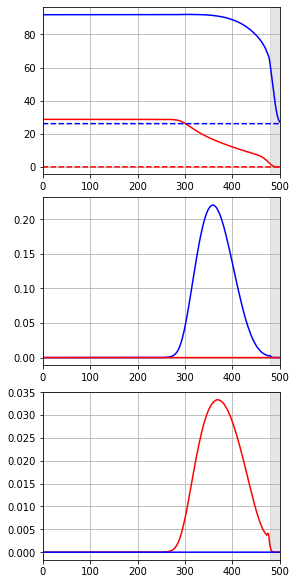

-------  55 0.4250000000000001 0.6250000000000003
--------------- k  0
set cost params:  1.0 990.0 0.0
interpolate adjoint :  True True True
initial cost =  1909.9328558661116
RUN  0 , total integrated cost =  1909.9328558661116
Gradient descend method:  None
RUN  1 , total integrated cost =  1907.513501932149
RUN  2 , total integrated cost =  1902.8826188162177
RUN  3 , total integrated cost =  1900.535557210448
RUN  4 , total integrated cost =  1896.3206153847975
RUN  5 , total integrated cost =  1894.1549154208985
RUN  6 , total integrated cost =  1887.8549272881592
RUN  7 , total integrated cost =  1885.3876137538364
RUN  8 , total integrated cost =  1869.6781117643177
RUN  9 , total integrated cost =  1756.7814731216477
RUN  10 , total integrated cost =  1452.8362260087017
RUN  11 , total integrated cost =  1446.3596904028043
RUN  12 , total integrated cost =  1444.4921655337619
RUN  13 , total integrated cost =  1441.5282254745484
RUN  14 , total integrated cost =  1439.156491896

RUN  120 , total integrated cost =  6554.875634520923
RUN  130 , total integrated cost =  6554.840994992479
RUN  140 , total integrated cost =  6554.811733698396
RUN  150 , total integrated cost =  6554.762176821301
Control only changes marginally.
RUN  159 , total integrated cost =  6554.023255088925
Improved over  159  iterations in  118.23024863493629  seconds by  0.0787083744163084  percent.
cost splitting :  4.285487061811335 [4.78235786e-27 1.26031503e+00 3.67063958e-02 0.00000000e+00]
--------------- k  4
set cost params:  1.0 6408.112336459838 0.0
interpolate adjoint :  True True True
initial cost =  8315.718498965462
RUN  0 , total integrated cost =  8315.718498965462
Gradient descend method:  None
RUN  1 , total integrated cost =  8315.552438517208
RUN  2 , total integrated cost =  8315.55085103254
RUN  3 , total integrated cost =  8315.546480721665
RUN  4 , total integrated cost =  8315.54556714016
RUN  5 , total integrated cost =  8315.250424005566
RUN  6 , total integrated

RUN  7 , total integrated cost =  17102.684284776376
RUN  8 , total integrated cost =  17102.68240447702
RUN  9 , total integrated cost =  17102.678065704444
RUN  10 , total integrated cost =  17102.677406501538
Control only changes marginally.
RUN  10 , total integrated cost =  17102.677406501538
Improved over  10  iterations in  8.394908376969397  seconds by  0.0009910949299865024  percent.
cost splitting :  10.418978433675353 [5.77848113e-27 1.25841426e+00 3.67932022e-02 0.00000000e+00]
--------------- k  10
set cost params:  1.0 14553.916291827485 0.0
interpolate adjoint :  True True True
initial cost =  18860.639302247833
RUN  0 , total integrated cost =  18860.639302247833
Gradient descend method:  None
RUN  1 , total integrated cost =  18860.575163141257
RUN  2 , total integrated cost =  18860.574290063334
RUN  3 , total integrated cost =  18860.56921498345
RUN  4 , total integrated cost =  18860.568091948167
Control only changes marginally.
RUN  4 , total integrated cost =  188

RUN  1 , total integrated cost =  31161.979125779984
RUN  2 , total integrated cost =  31161.9772396435
RUN  3 , total integrated cost =  31161.942475595333
RUN  4 , total integrated cost =  31161.92358588902
RUN  5 , total integrated cost =  31161.92150565676
RUN  6 , total integrated cost =  31161.91567034856
RUN  7 , total integrated cost =  31161.912898191633
RUN  8 , total integrated cost =  31161.904629137007
RUN  9 , total integrated cost =  31161.894258877433
RUN  10 , total integrated cost =  31161.892367260894
RUN  11 , total integrated cost =  31161.8090094574
RUN  12 , total integrated cost =  31161.75942923826
RUN  13 , total integrated cost =  31161.75783883933
RUN  14 , total integrated cost =  31161.73041946845
RUN  15 , total integrated cost =  31161.71656895507
RUN  16 , total integrated cost =  31161.71490305997
RUN  17 , total integrated cost =  31161.70872907011
RUN  18 , total integrated cost =  31161.70548498356
RUN  19 , total integrated cost =  31161.6947082055

RUN  1 , total integrated cost =  46973.68503199101
RUN  2 , total integrated cost =  46973.68459057254
Control only changes marginally.
RUN  2 , total integrated cost =  46973.68459057254
Improved over  2  iterations in  2.2099767399486154  seconds by  5.8418038548779805e-05  percent.
cost splitting :  19.747048173463757 [1.20867831e-25 1.25593427e+00 3.64805018e-02 0.00000000e+00]
--------------- k  27
set cost params:  1.0 37690.338288172374 0.0
interpolate adjoint :  True True True
initial cost =  48731.24783825328
RUN  0 , total integrated cost =  48731.24783825328
Gradient descend method:  None
RUN  1 , total integrated cost =  48731.2364777632
RUN  2 , total integrated cost =  48731.235573993814
Control only changes marginally.
RUN  2 , total integrated cost =  48731.235573993814
Improved over  2  iterations in  2.15575081796851  seconds by  2.5167136101345022e-05  percent.
cost splitting :  20.453336856318074 [1.20846959e-25 1.25591984e+00 3.64807801e-02 0.00000000e+00]
-------

RUN  1 , total integrated cost =  68060.17967271767
RUN  2 , total integrated cost =  68060.17934847088
Control only changes marginally.
RUN  2 , total integrated cost =  68060.17934847088
Improved over  2  iterations in  2.234003989957273  seconds by  3.296563969001909e-05  percent.
cost splitting :  29.001656405043516 [1.21140296e-25 1.25559873e+00 3.65829503e-02 0.00000000e+00]
--------------- k  39
set cost params:  1.0 54008.438622101785 0.0
interpolate adjoint :  True True True
initial cost =  69817.6038488677
RUN  0 , total integrated cost =  69817.6038488677
Gradient descend method:  None
RUN  1 , total integrated cost =  69817.59122556457
RUN  2 , total integrated cost =  69817.5901936683
Control only changes marginally.
RUN  2 , total integrated cost =  69817.5901936683
Improved over  2  iterations in  2.1956932130269706  seconds by  1.9558390235374645e-05  percent.
cost splitting :  29.915160218377583 [1.21163485e-25 1.25558575e+00 3.65831911e-02 0.00000000e+00]
------------

RUN  1 , total integrated cost =  90901.68183659714
RUN  2 , total integrated cost =  90901.68072361147
Control only changes marginally.
RUN  2 , total integrated cost =  90901.68072361147
Improved over  2  iterations in  2.352819958003238  seconds by  1.7116978085596202e-05  percent.
cost splitting :  39.16394716636709 [1.22517123e-25 1.25540682e+00 3.66099505e-02 0.00000000e+00]
--------------- k  52
set cost params:  1.0 71686.24997632962 0.0
interpolate adjoint :  True True True
initial cost =  92658.6496854276
RUN  0 , total integrated cost =  92658.6496854276
Gradient descend method:  None
RUN  1 , total integrated cost =  92658.63595395457
RUN  2 , total integrated cost =  92658.63509114098
Control only changes marginally.
RUN  2 , total integrated cost =  92658.63509114098
Improved over  2  iterations in  2.2029555129120126  seconds by  1.5750592822882936e-05  percent.
cost splitting :  39.825338847753414 [1.22648509e-25 1.25539704e+00 3.66097479e-02 0.00000000e+00]
-----------

RUN  19 , total integrated cost =  111983.99958822702
RUN  20 , total integrated cost =  111983.98859735978
RUN  30 , total integrated cost =  111983.38707387615
Control only changes marginally.
RUN  30 , total integrated cost =  111983.38707387615
Improved over  30  iterations in  22.339166737976484  seconds by  0.0006944632611265433  percent.
cost splitting :  48.811312713469825 [1.68297121e-25 1.25518497e+00 3.66997836e-02 0.00000000e+00]
--------------- k  64
set cost params:  1.0 88004.94597342887 0.0
interpolate adjoint :  True True True
initial cost =  113740.57075032839
RUN  0 , total integrated cost =  113740.57075032839
Gradient descend method:  None
RUN  1 , total integrated cost =  113740.54979866701
RUN  2 , total integrated cost =  113740.54916434396
Control only changes marginally.
RUN  2 , total integrated cost =  113740.54916434396
Improved over  2  iterations in  2.186049085925333  seconds by  1.8978262801283563e-05  percent.
cost splitting :  49.72615093171165 [1.686

RUN  1 , total integrated cost =  154141.05502363772
RUN  2 , total integrated cost =  154141.05396113553
Control only changes marginally.
RUN  2 , total integrated cost =  154141.05396113553
Improved over  2  iterations in  2.3434340349631384  seconds by  1.1230180021470915e-05  percent.
cost splitting :  68.41125021581807 [1.77298059e-25 1.25499414e+00 3.66952610e-02 0.00000000e+00]
--------------- k  88
set cost params:  1.0 120640.4245950437 0.0
interpolate adjoint :  True True True
initial cost =  155898.0639221794
RUN  0 , total integrated cost =  155898.0639221794
Gradient descend method:  None
RUN  1 , total integrated cost =  155898.0549459055
RUN  2 , total integrated cost =  155898.0513620815
Control only changes marginally.
RUN  2 , total integrated cost =  155898.0513620815
Improved over  2  iterations in  2.4173359860433266  seconds by  8.056609289042171e-06  percent.
cost splitting :  69.2474895509986 [1.78769820e-25 1.25499087e+00 3.66951903e-02 0.00000000e+00]
--------

RUN  1 , total integrated cost =  176972.17620789766
Control only changes marginally.
RUN  1 , total integrated cost =  176972.17620789766
Improved over  1  iterations in  1.2431516450596973  seconds by  7.75979700051721e-07  percent.
cost splitting :  78.60663697387365 [1.92398767e-25 1.25491333e+00 3.66955981e-02 0.00000000e+00]


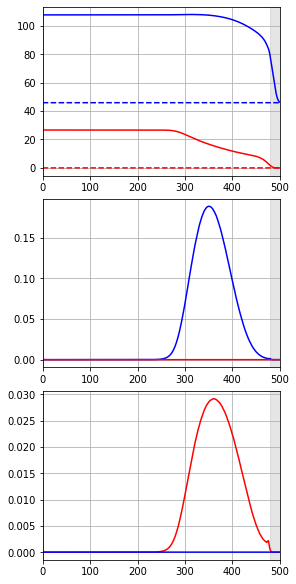

-------  62 0.4250000000000001 0.6500000000000004
--------------- k  0
set cost params:  1.0 990.0 0.0
interpolate adjoint :  True True True
initial cost =  1794.0301510225083
RUN  0 , total integrated cost =  1794.0301510225083
Gradient descend method:  None
RUN  1 , total integrated cost =  1791.94281220417
RUN  2 , total integrated cost =  1787.3832742103582
RUN  3 , total integrated cost =  1785.2513244396705
RUN  4 , total integrated cost =  1781.4869203950834
RUN  5 , total integrated cost =  1779.4854950303231
RUN  6 , total integrated cost =  1775.474076843301
RUN  7 , total integrated cost =  1773.311689485871
RUN  8 , total integrated cost =  1768.6692513905252
RUN  9 , total integrated cost =  1766.7497724799987
RUN  10 , total integrated cost =  1763.1696644761892
RUN  11 , total integrated cost =  1761.2300891491013
RUN  12 , total integrated cost =  1757.6025909678694
RUN  13 , total integrated cost =  1755.6808892668553
RUN  14 , total integrated cost =  1751.88831357406

RUN  120 , total integrated cost =  6342.951395057256
RUN  130 , total integrated cost =  6342.939580531306
RUN  140 , total integrated cost =  6342.929286592746
Control only changes marginally.
RUN  146 , total integrated cost =  6342.922223978895
Improved over  146  iterations in  62.28674828505609  seconds by  0.005429312554454668  percent.
cost splitting :  3.6885048115771686 [6.09419564e-29 1.18434432e+00 3.46452274e-02 0.00000000e+00]
--------------- k  4
set cost params:  1.0 6605.03540110601 0.0
interpolate adjoint :  True True True
initial cost =  8055.123101145738
RUN  0 , total integrated cost =  8055.123101145738
Gradient descend method:  None
RUN  1 , total integrated cost =  8054.981209822573
RUN  2 , total integrated cost =  8054.980419208574
RUN  3 , total integrated cost =  8054.976520616484
RUN  4 , total integrated cost =  8054.9745975251935
RUN  5 , total integrated cost =  8054.971673248213
RUN  6 , total integrated cost =  8054.967157370246
RUN  7 , total integrat

RUN  1 , total integrated cost =  20034.81184806558
RUN  2 , total integrated cost =  20034.811022223996
RUN  3 , total integrated cost =  20034.805013814213
RUN  4 , total integrated cost =  20034.803182728076
RUN  5 , total integrated cost =  20034.801422353685
RUN  6 , total integrated cost =  20034.797226189214
RUN  7 , total integrated cost =  20034.79644461375
Control only changes marginally.
RUN  7 , total integrated cost =  20034.79644461375
Improved over  7  iterations in  3.7188325190218166  seconds by  0.00028991099213726557  percent.
cost splitting :  8.988941132822674 [2.22009862e-26 1.18160795e+00 3.47145484e-02 0.00000000e+00]
--------------- k  12
set cost params:  1.0 17871.780307215355 0.0
interpolate adjoint :  True True True
initial cost =  21746.706072491284
RUN  0 , total integrated cost =  21746.706072491284
Gradient descend method:  None
RUN  1 , total integrated cost =  21746.669085933918
RUN  2 , total integrated cost =  21746.668769290885
Control only changes

RUN  1 , total integrated cost =  38863.98993924781
RUN  2 , total integrated cost =  38863.98930030188
Control only changes marginally.
RUN  2 , total integrated cost =  38863.98930030188
Improved over  2  iterations in  1.3480123990448192  seconds by  7.752673575112112e-05  percent.
cost splitting :  17.880733008229917 [1.86964235e-26 1.18119640e+00 3.47116504e-02 0.00000000e+00]
--------------- k  23
set cost params:  1.0 33356.169957102145 0.0
interpolate adjoint :  True True True
initial cost =  40575.734916524096
RUN  0 , total integrated cost =  40575.734916524096
Gradient descend method:  None
RUN  1 , total integrated cost =  40575.70931360345
RUN  2 , total integrated cost =  40575.70861672857
Control only changes marginally.
RUN  2 , total integrated cost =  40575.70861672857
Improved over  2  iterations in  1.3301355030853301  seconds by  6.481655991308344e-05  percent.
cost splitting :  18.659446536204225 [1.86951283e-26 1.18117257e+00 3.47118128e-02 0.00000000e+00]
------

RUN  1 , total integrated cost =  62826.37118368789
RUN  2 , total integrated cost =  62826.36953143857
Control only changes marginally.
RUN  2 , total integrated cost =  62826.36953143857
Improved over  2  iterations in  1.316629879991524  seconds by  2.277668539818478e-05  percent.
cost splitting :  29.67313262088023 [1.87259919e-26 1.18091149e+00 3.47110958e-02 0.00000000e+00]
--------------- k  37
set cost params:  1.0 53066.04056354344 0.0
interpolate adjoint :  True True True
initial cost =  64537.63363147458
RUN  0 , total integrated cost =  64537.63363147458
Gradient descend method:  None
RUN  1 , total integrated cost =  64537.61079767022
RUN  2 , total integrated cost =  64537.609784540844
Control only changes marginally.
RUN  2 , total integrated cost =  64537.609784540844
Improved over  2  iterations in  1.3615393480286002  seconds by  3.69504309247759e-05  percent.
cost splitting :  30.545365425419597 [1.87304459e-26 1.18089215e+00 3.47111944e-02 0.00000000e+00]
----------

RUN  1 , total integrated cost =  83359.38440168653
RUN  2 , total integrated cost =  83359.38298221143
RUN  3 , total integrated cost =  83359.3811059057
RUN  4 , total integrated cost =  83359.36941196297
RUN  5 , total integrated cost =  83359.36788093252
RUN  6 , total integrated cost =  83359.36611154416
RUN  7 , total integrated cost =  83359.35422400912
RUN  8 , total integrated cost =  83359.35241774684
RUN  9 , total integrated cost =  83359.35077200888
RUN  10 , total integrated cost =  83359.33899346499
RUN  11 , total integrated cost =  83359.33705235319
RUN  12 , total integrated cost =  83359.33554427681
RUN  13 , total integrated cost =  83359.32347382234
RUN  14 , total integrated cost =  83359.32132199306
Control only changes marginally.
RUN  14 , total integrated cost =  83359.32132199306
Improved over  14  iterations in  7.049219807959162  seconds by  8.850044187624917e-05  percent.
cost splitting :  33.721695808835484 [6.49596469e-26 1.18016885e+00 3.46478102e-02 0.

RUN  1 , total integrated cost =  105604.86575395051
RUN  2 , total integrated cost =  105604.86396871612
Control only changes marginally.
RUN  2 , total integrated cost =  105604.86396871612
Improved over  2  iterations in  1.3709959520492703  seconds by  9.705433825502041e-06  percent.
cost splitting :  42.88624694015201 [6.52668045e-26 1.18005335e+00 3.46447368e-02 0.00000000e+00]
--------------- k  62
set cost params:  1.0 88312.69245615105 0.0
interpolate adjoint :  True True True
initial cost =  107315.58823972907
RUN  0 , total integrated cost =  107315.58823972907
Gradient descend method:  None
RUN  1 , total integrated cost =  107315.570103802
RUN  2 , total integrated cost =  107315.56879871803
Control only changes marginally.
RUN  2 , total integrated cost =  107315.56879871803
Improved over  2  iterations in  1.3773818489862606  seconds by  1.8115738228630107e-05  percent.
cost splitting :  43.66670382306266 [6.53143769e-26 1.18004164e+00 3.46444178e-02 0.00000000e+00]
----

RUN  1 , total integrated cost =  129558.9547669491
RUN  2 , total integrated cost =  129558.95368477501
Control only changes marginally.
RUN  2 , total integrated cost =  129558.95368477501
Improved over  2  iterations in  1.4114489319035783  seconds by  9.193424531872552e-06  percent.
cost splitting :  53.596113668391 [6.65701524e-26 1.17992942e+00 3.46539942e-02 0.00000000e+00]
--------------- k  76
set cost params:  1.0 108034.19559290084 0.0
interpolate adjoint :  True True True
initial cost =  131269.76674603956
RUN  0 , total integrated cost =  131269.76674603956
Gradient descend method:  None
RUN  1 , total integrated cost =  131269.7593439046
Control only changes marginally.
RUN  1 , total integrated cost =  131269.7593439046
Improved over  1  iterations in  0.725723166950047  seconds by  5.63887265059293e-06  percent.
cost splitting :  53.22437933695678 [6.66367173e-26 1.17992362e+00 3.46538326e-02 0.00000000e+00]
--------------- k  87
set cost params:  1.0 123528.30658839282

RUN  1 , total integrated cost =  170616.22847186503
RUN  2 , total integrated cost =  170616.2238731363
Control only changes marginally.
RUN  2 , total integrated cost =  170616.2238731363
Improved over  2  iterations in  0.9282987490296364  seconds by  8.377164306239138e-06  percent.
cost splitting :  71.45253077896996 [6.98238744e-26 1.17978233e+00 3.46567673e-02 0.00000000e+00]
--------------- k  100
set cost params:  1.0 141839.77804641204 0.0
interpolate adjoint :  True True True
initial cost =  172326.57724758142
RUN  0 , total integrated cost =  172326.57724758142
Gradient descend method:  None
RUN  1 , total integrated cost =  172326.53735777063
RUN  2 , total integrated cost =  172326.51475714747
RUN  3 , total integrated cost =  172326.51289453218
Control only changes marginally.
RUN  3 , total integrated cost =  172326.51289453218
Improved over  3  iterations in  1.26023722498212  seconds by  3.734365891716607e-05  percent.
cost splitting :  71.5420132350486 [7.01782361e-26

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  11 , total integrated cost =  129432.74206087852
Control only changes marginally.
RUN  11 , total integrated cost =  129432.74206087852
Improved over  11  iterations in  4.558722137007862  seconds by  24.891022723189337  percent.
Problem in initial value trasfer post:  sigmae_f 1.5035239156996063 1.5035367238675132
Problem in initial value trasfer post:  tau_exc 2.9010183594135714 2.9010145031388617
cost splitting :  107951.3661782621 [1.09325066e-08 1.48313955e-01 3.13436585e-03 2.86871689e-24]
converged to zero, reload and break
file found
-------  69 0.4250000000000001 0.6750000000000004
--------------- k  0
set cost params:  1.0 990.0 0.0
interpolate adjoint :  True True True
initial cost =  1344.211874171794
RUN  0 , total integrated cost =  1344.211874171794
Gradient descend method:  None
RUN  1 , total integrated cost =  1341.671453117116
RUN  2 , total integrated cost =  1336.0102275297095
RUN  3 , total integrated cost =  1333.9244518364237
RUN  4 , total integrated cost 

RUN  20 , total integrated cost =  6142.366068140588
RUN  30 , total integrated cost =  6142.338807458514
RUN  40 , total integrated cost =  6135.663930091321
RUN  50 , total integrated cost =  6135.604790811414
RUN  60 , total integrated cost =  6135.519580258688
RUN  70 , total integrated cost =  6135.344366432866
RUN  80 , total integrated cost =  6135.163458987097
RUN  90 , total integrated cost =  6135.138708804808
RUN  100 , total integrated cost =  6135.117533767084
RUN  110 , total integrated cost =  6135.02403269319
RUN  120 , total integrated cost =  6134.997141027861
RUN  130 , total integrated cost =  6134.976333295161
RUN  140 , total integrated cost =  6134.941695197169
RUN  150 , total integrated cost =  6134.9058993137
RUN  160 , total integrated cost =  6134.796903526776
RUN  170 , total integrated cost =  6134.639335721251
RUN  180 , total integrated cost =  6132.597224441818
RUN  190 , total integrated cost =  6132.556632701603
RUN  200 , total integrated cost =  613

RUN  1 , total integrated cost =  19486.784388396463
RUN  2 , total integrated cost =  19486.783508160603
RUN  3 , total integrated cost =  19486.776102771884
RUN  4 , total integrated cost =  19486.759141988023
RUN  5 , total integrated cost =  19486.75862883731
Control only changes marginally.
RUN  5 , total integrated cost =  19486.75862883731
Improved over  5  iterations in  2.9566326539497823  seconds by  0.0003493154387683717  percent.
cost splitting :  9.111104548321926 [2.04791725e-28 1.10995253e+00 3.25813282e-02 2.57262970e-41]
--------------- k  12
set cost params:  1.0 18508.28801475945 0.0
interpolate adjoint :  True True True
initial cost =  21155.39054899414
RUN  0 , total integrated cost =  21155.39054899414
Gradient descend method:  None
RUN  1 , total integrated cost =  21155.340974464547
RUN  2 , total integrated cost =  21155.340311462438
RUN  3 , total integrated cost =  21155.33119896937
RUN  4 , total integrated cost =  21155.327784927078
RUN  5 , total integrate

RUN  1 , total integrated cost =  39509.493591300234
RUN  2 , total integrated cost =  39509.49328898186
Control only changes marginally.
RUN  2 , total integrated cost =  39509.49328898186
Improved over  2  iterations in  1.3467354970052838  seconds by  6.561925015091674e-05  percent.
cost splitting :  19.254099626692984 [2.23174202e-28 1.10943594e+00 3.26638401e-02 2.80640269e-41]
--------------- k  24
set cost params:  1.0 36037.85100997451 0.0
interpolate adjoint :  True True True
initial cost =  41178.019590833355
RUN  0 , total integrated cost =  41178.019590833355
Gradient descend method:  None
RUN  1 , total integrated cost =  41177.99755102363
RUN  2 , total integrated cost =  41177.99678334811
Control only changes marginally.
RUN  2 , total integrated cost =  41177.99678334811
Improved over  2  iterations in  1.3578163220081478  seconds by  5.538752341749387e-05  percent.
cost splitting :  20.13813386150468 [2.23470026e-28 1.10941295e+00 3.26639650e-02 2.80975527e-41]
-------

RUN  1 , total integrated cost =  61198.605346908116
RUN  2 , total integrated cost =  61198.603899279806
Control only changes marginally.
RUN  2 , total integrated cost =  61198.603899279806
Improved over  2  iterations in  1.4516045459313318  seconds by  3.176150664785382e-05  percent.
cost splitting :  30.79678568127446 [2.36018809e-28 1.10916984e+00 3.26661255e-02 2.94242040e-41]
--------------- k  37
set cost params:  1.0 55030.93201935958 0.0
interpolate adjoint :  True True True
initial cost =  62866.81174263974
RUN  0 , total integrated cost =  62866.81174263974
Gradient descend method:  None
RUN  1 , total integrated cost =  62866.79147510733
RUN  2 , total integrated cost =  62866.79097056078
Control only changes marginally.
RUN  2 , total integrated cost =  62866.79097056078
Improved over  2  iterations in  1.3831326959189028  seconds by  3.30414067093443e-05  percent.
cost splitting :  31.683494521284835 [2.38302194e-28 1.10915218e+00 3.26656477e-02 2.96554588e-41]
--------

RUN  1 , total integrated cost =  84552.86760230719
RUN  2 , total integrated cost =  84552.8669638245
Control only changes marginally.
RUN  2 , total integrated cost =  84552.8669638245
Improved over  2  iterations in  0.9441151970531791  seconds by  2.2805711012097163e-05  percent.
cost splitting :  43.24091029388954 [2.79973690e-28 1.10897404e+00 3.26633033e-02 3.36073428e-41]
--------------- k  51
set cost params:  1.0 75486.34078440037 0.0
interpolate adjoint :  True True True
initial cost =  86221.01005701974
RUN  0 , total integrated cost =  86221.01005701974
Gradient descend method:  None
RUN  1 , total integrated cost =  86220.9939966414
RUN  2 , total integrated cost =  86220.99238959613
Control only changes marginally.
RUN  2 , total integrated cost =  86220.99238959613
Improved over  2  iterations in  1.4455428021028638  seconds by  2.049085669852957e-05  percent.
cost splitting :  44.14900070838465 [2.85430566e-28 1.10896236e+00 3.26630048e-02 3.40968609e-41]
-------------

RUN  1 , total integrated cost =  107904.18705291027
RUN  2 , total integrated cost =  107904.18443140264
Control only changes marginally.
RUN  2 , total integrated cost =  107904.18443140264
Improved over  2  iterations in  1.4228334759827703  seconds by  1.2405440443785665e-05  percent.
cost splitting :  56.06100030976492 [4.06054173e-28 1.10882554e+00 3.26606267e-02 4.39554273e-41]
--------------- k  65
set cost params:  1.0 95941.6761807209 0.0
interpolate adjoint :  True True True
initial cost =  109571.55922352863
RUN  0 , total integrated cost =  109571.55922352863
Gradient descend method:  None
RUN  1 , total integrated cost =  109571.54065727745
RUN  2 , total integrated cost =  109571.5375677537
Control only changes marginally.
RUN  2 , total integrated cost =  109571.5375677537
Improved over  2  iterations in  1.408406696980819  seconds by  1.976404743686544e-05  percent.
cost splitting :  57.085695855046545 [4.24727593e-28 1.10881549e+00 3.26604060e-02 4.53762068e-41]
-----

RUN  2 , total integrated cost =  127916.14794602616
Control only changes marginally.
RUN  2 , total integrated cost =  127916.14794602616
Improved over  2  iterations in  1.3781059930333868  seconds by  1.4984801453010732e-05  percent.
cost splitting :  67.04830578113703 [7.53794064e-28 1.10871258e+00 3.26609051e-02 6.84051700e-41]
--------------- k  77
set cost params:  1.0 113474.98322234422 0.0
interpolate adjoint :  True True True
initial cost =  129584.05267754894
RUN  0 , total integrated cost =  129584.05267754894
Gradient descend method:  None
RUN  1 , total integrated cost =  129584.03800126292
RUN  2 , total integrated cost =  129584.03396662966
Control only changes marginally.
RUN  2 , total integrated cost =  129584.03396662966
Improved over  2  iterations in  1.4170915320282802  seconds by  1.4439214467643069e-05  percent.
cost splitting :  68.16440174279936 [7.96113786e-28 1.10870619e+00 3.26608012e-02 7.11508273e-41]
--------------- k  78
set cost params:  1.0 114935.71

RUN  1 , total integrated cost =  149592.82762184826
RUN  2 , total integrated cost =  149592.82501178735
Control only changes marginally.
RUN  2 , total integrated cost =  149592.82501178735
Improved over  2  iterations in  1.4562844219617546  seconds by  1.703504231898023e-05  percent.
cost splitting :  80.1963913689174 [1.39281157e-27 1.10860405e+00 3.26611048e-02 1.06112523e-40]
--------------- k  90
set cost params:  1.0 132468.15065805637 0.0
interpolate adjoint :  True True True
initial cost =  151260.87127640235
RUN  0 , total integrated cost =  151260.87127640235
Gradient descend method:  None
RUN  1 , total integrated cost =  151260.8559279074
RUN  2 , total integrated cost =  151260.8502767895
Control only changes marginally.
RUN  2 , total integrated cost =  151260.8502767895
Improved over  2  iterations in  1.456267717992887  seconds by  1.388304367822002e-05  percent.
cost splitting :  81.05240890200425 [1.49804591e-27 1.10859955e+00 3.26610681e-02 1.11779654e-40]
-------

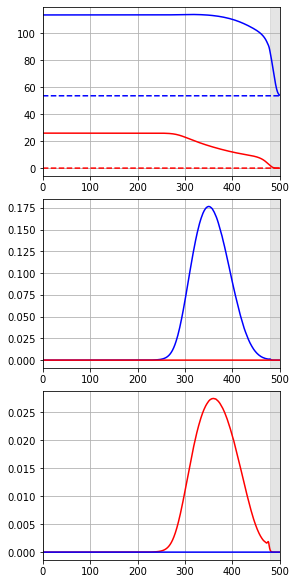

-------  76 0.4250000000000001 0.7000000000000004
--------------- k  0
set cost params:  1.0 990.0 0.0
interpolate adjoint :  True True True
initial cost =  1470.4525177145215
RUN  0 , total integrated cost =  1470.4525177145215
Gradient descend method:  None
RUN  1 , total integrated cost =  1465.2697098943927
RUN  2 , total integrated cost =  1461.6479860651193
RUN  3 , total integrated cost =  1434.965872449914
RUN  4 , total integrated cost =  1432.7602250752316
RUN  5 , total integrated cost =  1428.4427814676276
RUN  6 , total integrated cost =  1426.1877047109547
RUN  7 , total integrated cost =  1422.5387436739213
RUN  8 , total integrated cost =  1420.516211885431
RUN  9 , total integrated cost =  1417.0472380864558
RUN  10 , total integrated cost =  1415.066793219079
RUN  11 , total integrated cost =  1411.7064523178863
RUN  12 , total integrated cost =  1409.839942198459
RUN  13 , total integrated cost =  1406.7938587869367
RUN  14 , total integrated cost =  1404.99430924680

RUN  130 , total integrated cost =  5922.952477233171
RUN  140 , total integrated cost =  5902.5705909946555
RUN  150 , total integrated cost =  5902.089591168202
RUN  160 , total integrated cost =  5901.753959226038
RUN  170 , total integrated cost =  5901.689016998349
RUN  180 , total integrated cost =  5901.623387186018
RUN  190 , total integrated cost =  5901.018151984276
RUN  200 , total integrated cost =  5900.493336238161
RUN  300 , total integrated cost =  5891.566160320864
RUN  300 , total integrated cost =  5891.566160320864
Improved over  300  iterations in  218.73191935406066  seconds by  1.1922587061059744  percent.
cost splitting :  3.8484527240491655 [2.92664004e-29 1.04366580e+00 3.08467305e-02 6.85421157e-39]
--------------- k  4
set cost params:  1.0 7045.553890996771 0.0
interpolate adjoint :  True True True
initial cost =  7574.384416405968
RUN  0 , total integrated cost =  7574.384416405968
Gradient descend method:  None
RUN  1 , total integrated cost =  7574.22824

RUN  1 , total integrated cost =  17334.823065070384
RUN  2 , total integrated cost =  17334.822513831434
RUN  3 , total integrated cost =  17334.818835326056
RUN  4 , total integrated cost =  17334.8161984172
RUN  5 , total integrated cost =  17334.815156814468
RUN  6 , total integrated cost =  17334.81130890056
RUN  7 , total integrated cost =  17334.80891605442
RUN  8 , total integrated cost =  17334.80729975836
RUN  9 , total integrated cost =  17334.80468946814
RUN  10 , total integrated cost =  17334.803747167218
Control only changes marginally.
RUN  10 , total integrated cost =  17334.803747167218
Improved over  10  iterations in  10.269431027001701  seconds by  0.0003401071047193227  percent.
cost splitting :  8.036021436922868 [2.24324539e-29 1.04057946e+00 3.08499125e-02 6.18198841e-39]
--------------- k  11
set cost params:  1.0 17690.57689549407 0.0
interpolate adjoint :  True True True
initial cost =  18962.120480939222
RUN  0 , total integrated cost =  18962.120480939222


RUN  1 , total integrated cost =  31980.392609156002
RUN  2 , total integrated cost =  31980.39229694462
Control only changes marginally.
RUN  2 , total integrated cost =  31980.39229694462
Improved over  2  iterations in  2.356559726060368  seconds by  0.00010953049695672235  percent.
cost splitting :  15.238962573084624 [4.16858575e-29 1.04022074e+00 3.08469272e-02 6.62549301e-39]
--------------- k  20
set cost params:  1.0 31363.661520637645 0.0
interpolate adjoint :  True True True
initial cost =  33607.74091066294
RUN  0 , total integrated cost =  33607.74091066294
Gradient descend method:  None
RUN  1 , total integrated cost =  33607.71000183641
RUN  2 , total integrated cost =  33607.70924028817
Control only changes marginally.
RUN  2 , total integrated cost =  33607.70924028817
Improved over  2  iterations in  2.352313113049604  seconds by  9.423535743735556e-05  percent.
cost splitting :  16.153319436922448 [4.17989129e-29 1.04019309e+00 3.08460921e-02 6.62777602e-39]
--------

RUN  2 , total integrated cost =  53133.693333690535
RUN  3 , total integrated cost =  53132.0662399643
RUN  4 , total integrated cost =  53130.88003228163
RUN  5 , total integrated cost =  53130.87399512115
RUN  6 , total integrated cost =  53130.85977116571
RUN  7 , total integrated cost =  53130.85265680024
RUN  8 , total integrated cost =  53130.84744335732
RUN  9 , total integrated cost =  53130.837013916185
RUN  10 , total integrated cost =  53130.832640318105
RUN  11 , total integrated cost =  53130.82828386653
RUN  12 , total integrated cost =  53130.81845995556
RUN  13 , total integrated cost =  53130.81444375397
RUN  14 , total integrated cost =  53130.81193983006
RUN  15 , total integrated cost =  53130.803191676554
RUN  16 , total integrated cost =  53130.79947313677
RUN  17 , total integrated cost =  53130.7983082008
RUN  18 , total integrated cost =  53130.790259993446
RUN  19 , total integrated cost =  53130.78680273355
Control only changes marginally.
RUN  19 , total in

RUN  3 , total integrated cost =  72655.81919707281
RUN  4 , total integrated cost =  72654.28158024236
RUN  5 , total integrated cost =  72654.27883908605
Control only changes marginally.
RUN  5 , total integrated cost =  72654.27883908605
Improved over  5  iterations in  5.577827896922827  seconds by  0.00408895933745157  percent.
cost splitting :  35.85664108627578 [2.36806747e-27 1.03968548e+00 3.08287330e-02 1.82597557e-38]
--------------- k  45
set cost params:  1.0 69357.63375925292 0.0
interpolate adjoint :  True True True
initial cost =  74283.76350171426
RUN  0 , total integrated cost =  74283.76350171426
Gradient descend method:  None
RUN  1 , total integrated cost =  74283.74225129408
RUN  2 , total integrated cost =  74283.7415033465
Control only changes marginally.
RUN  2 , total integrated cost =  74283.7415033465
Improved over  2  iterations in  2.4399458169937134  seconds by  2.9613965054409164e-05  percent.
cost splitting :  36.819865922854845 [2.36899861e-27 1.039668

RUN  1 , total integrated cost =  95431.97693588634
Control only changes marginally.
RUN  1 , total integrated cost =  95431.97693588634
Improved over  1  iterations in  1.2853699330007657  seconds by  1.4934493933083104e-05  percent.
cost splitting :  47.15384928670061 [2.45786776e-27 1.03952554e+00 3.08252020e-02 1.85167898e-38]
--------------- k  69
set cost params:  1.0 105829.20410964185 0.0
interpolate adjoint :  True True True
initial cost =  113322.43266076404
RUN  0 , total integrated cost =  113322.43266076404
Gradient descend method:  None
RUN  1 , total integrated cost =  113321.58956978541
RUN  2 , total integrated cost =  113321.58837163205
Control only changes marginally.
RUN  2 , total integrated cost =  113321.58837163205
Improved over  2  iterations in  2.5199584560468793  seconds by  0.0007450326578464228  percent.
cost splitting :  57.73663418474097 [2.45985327e-27 1.03942810e+00 3.08252588e-02 1.85211193e-38]
--------------- k  70
set cost params:  1.0 107351.43133

RUN  1 , total integrated cost =  150727.81713482668
RUN  2 , total integrated cost =  150727.81297309222
Control only changes marginally.
RUN  2 , total integrated cost =  150727.81297309222
Improved over  2  iterations in  2.508050704956986  seconds by  2.010024471132965e-05  percent.
cost splitting :  79.30951314945978 [3.08556397e-27 1.03925899e+00 3.08231565e-02 1.95879317e-38]
--------------- k  93
set cost params:  1.0 142302.7667983081 0.0
interpolate adjoint :  True True True
initial cost =  152354.03978526697
RUN  0 , total integrated cost =  152354.03978526697
Gradient descend method:  None
RUN  1 , total integrated cost =  152354.02275776357
RUN  2 , total integrated cost =  152354.0196428972
Control only changes marginally.
RUN  2 , total integrated cost =  152354.0196428972
Improved over  2  iterations in  2.4883946490008384  seconds by  1.3220765126220613e-05  percent.
cost splitting :  79.93647513229186 [3.15188495e-27 1.03925150e+00 3.08229363e-02 1.96859395e-38]
-----

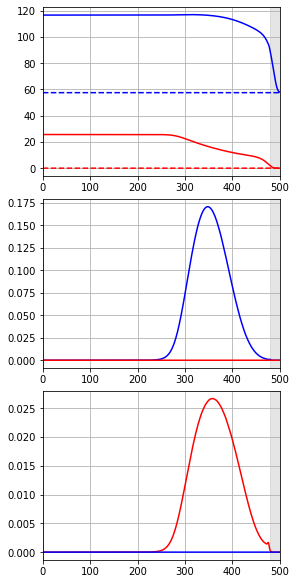

In [16]:
tol = 1e-6
c_var = [2,3,4,5]

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    k = 0
        
    if i in bad:
        continue
        
    while not conv[i]:
        print('--------------- k ', k)
        max_it = min(1000, int(100*k))
        
        if k == 0:
            max_it = 100
            weight_ = w_[i]
        else:
            weight_ = ( cost_uncontrolled[i] - costnode_[i][0][0][0] ) / sum( costnode_[i][cost_index][0][:] )
            if k < 100:
                weight_ = w_[i] + 0.01 *k * (weight_ - w_[i])
            
        aln.params.duration = dur
        cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][2] == 0.:
            if k > 100:
                conv[i] = True
            else: 
                k += 10

        #print('uncontrolled cost : ', cost_uncontrolled[i])
        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][cost_index][0][2:])

        if conv[i]:
            plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]

            fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

            ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
            ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
            ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
            ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

            ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
            ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

            ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
            ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

            for l in range(3):
                ax[l].set_xlim(0.,dur)
                ax[l].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()

        if np.abs(target_[0,0,0] - bestState_[i][0,0,-1]) < 3.:
            with open(file_,'wb') as f:
                pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)
        else:
            print("converged to zero, reload and break")
            if os.path.isfile(file_) :
                print("file found")

                with open(file_,'rb') as f:
                    load_array = pickle.load(f)

                bestControl_ = load_array[0]
                bestState_ = load_array[1]
                cost_ = load_array[2]
                costnode_ = load_array[3]
                weights_ = load_array[4]   
            break
        
        k += 1

ERROR:root:Problem in initial value trasfer pre


-------  1 0.4250000000000001 0.3500000000000001
init ind =  2542
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  2.366816285915065
RUN  0 , total integrated cost =  2.366816285915065
Gradient descend method:  None
RUN  0 , total integrated cost =  2.366816285915065
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951153066574
uncontrolled cost :  244234.70502182204
cost splitting :  0.0002979435815782253 [0. 0.]


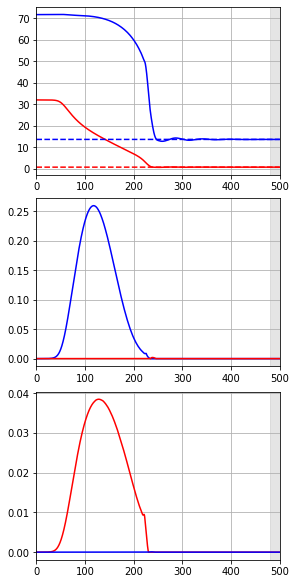

ERROR:root:Problem in initial value trasfer pre


-------  2 0.4000000000000001 0.3750000000000001
init ind =  2172
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  0.04963458246147907
RUN  0 , total integrated cost =  0.04963458246147907
Gradient descend method:  None
RUN  0 , total integrated cost =  0.04963458246147907
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.503837337451138 1.503837323067571
uncontrolled cost :  137806.3558139294
cost splitting :  1.0218470899166339e-14 [0. 0.]


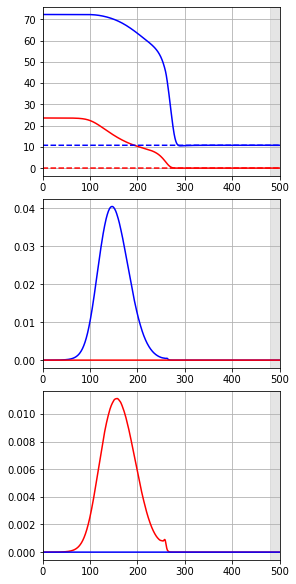

ERROR:root:Problem in initial value trasfer pre


-------  3 0.4250000000000001 0.3750000000000001
init ind =  2450
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  2.2490019898876694
RUN  0 , total integrated cost =  2.2490019898876694
Gradient descend method:  None
RUN  0 , total integrated cost =  2.2490019898876694
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5025675080425562 1.5025674957294708
uncontrolled cost :  241480.3484875782
cost splitting :  1.3374495685036437e-13 [0. 0.]


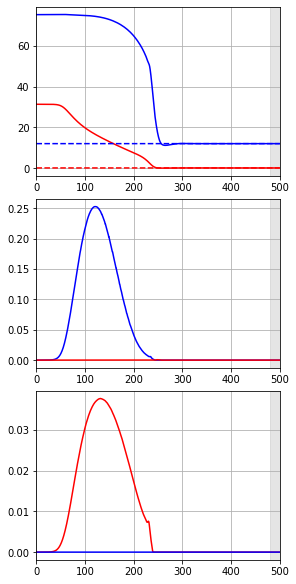

ERROR:root:Problem in initial value trasfer pre


-------  5 0.4000000000000001 0.40000000000000013
init ind =  1909
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  0.03491767365724284
RUN  0 , total integrated cost =  0.03491767365724284
Gradient descend method:  None
RUN  0 , total integrated cost =  0.03491767365724284
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5039081989608674 1.5039081865772885
uncontrolled cost :  126823.61408372025
cost splitting :  5.762317660730678e-11 [0. 0.]


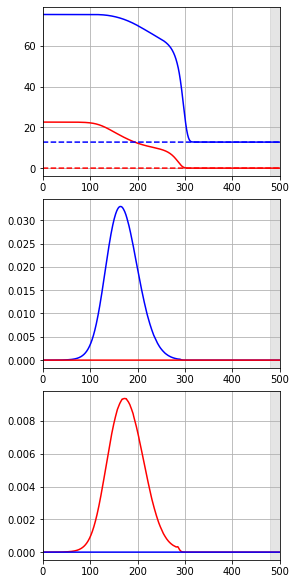

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


-------  9 0.4000000000000001 0.42500000000000016
init ind =  1597
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  0.02256700895132564
RUN  0 , total integrated cost =  0.02256700895132564
Gradient descend method:  None
RUN  0 , total integrated cost =  0.02256700895132564
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5040468738619945 1.5040468630624286
Problem in initial value trasfer pre:  sigmai_f 1.5035566682852224 1.5035566570821097
uncontrolled cost :  115502.5972235114
cost splitting :  6.532744610866139e-11 [0. 0.]


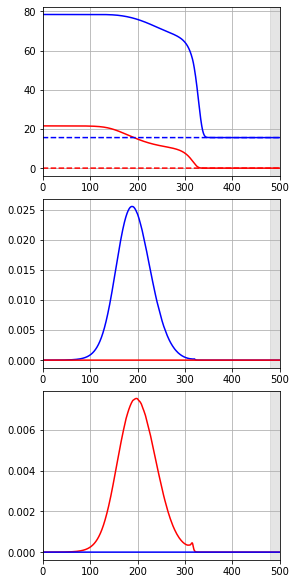

-------  10 0.4250000000000001 0.42500000000000016
init ind =  2377
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  2.0284011315575707
RUN  0 , total integrated cost =  2.0284011315575707
Gradient descend method:  None
RUN  0 , total integrated cost =  2.0284011315575707
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  226698.47715197233
cost splitting :  1.082409476693999e-12 [0. 0.]


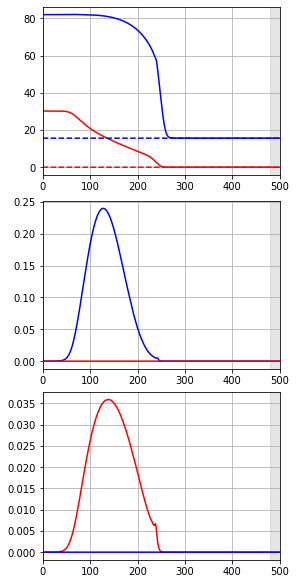

ERROR:root:Problem in initial value trasfer pre


-------  13 0.4000000000000001 0.4500000000000002
init ind =  1002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  0.012483869450495325
RUN  0 , total integrated cost =  0.012483869450495325
Gradient descend method:  None
RUN  0 , total integrated cost =  0.012483869450495325
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmai_f 1.5039627863732437 1.50396277289516
uncontrolled cost :  103932.40255255786
cost splitting :  2.828271005506903e-10 [0. 0.]


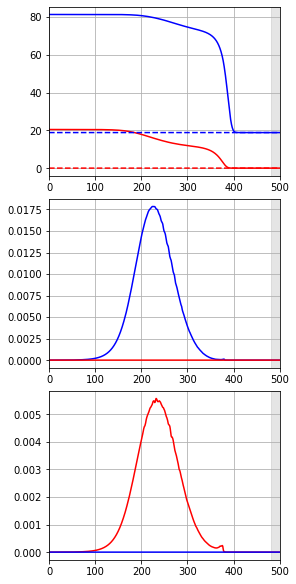

-------  14 0.4250000000000001 0.4500000000000002
init ind =  2288
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  1.922631407134367
RUN  0 , total integrated cost =  1.922631407134367
Gradient descend method:  None
RUN  0 , total integrated cost =  1.922631407134367
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  218854.09939826332
cost splitting :  8.796950035072206e-14 [0. 0.]


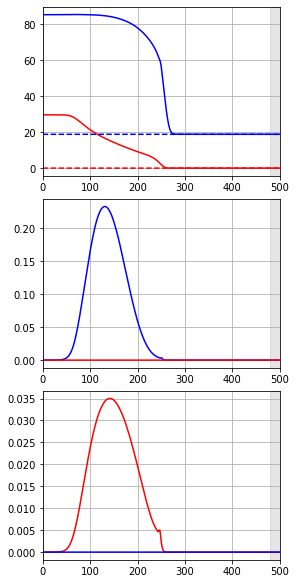

-------  19 0.4250000000000001 0.4750000000000002
init ind =  2271
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  1.8225446694426217
RUN  0 , total integrated cost =  1.8225446694426217
Gradient descend method:  None
RUN  0 , total integrated cost =  1.8225446694426217
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  211572.5759679924
cost splitting :  4.421437314612264e-15 [0. 0.]


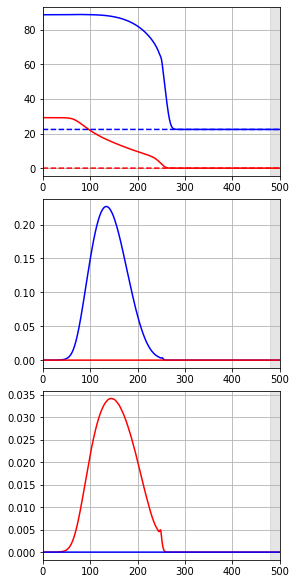

-------  25 0.4250000000000001 0.5000000000000002
init ind =  2212
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  1.725119701993798
RUN  0 , total integrated cost =  1.725119701993798
Gradient descend method:  None
RUN  0 , total integrated cost =  1.725119701993798
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  204814.76624161197
cost splitting :  1.4894853860873496e-16 [0. 0.]


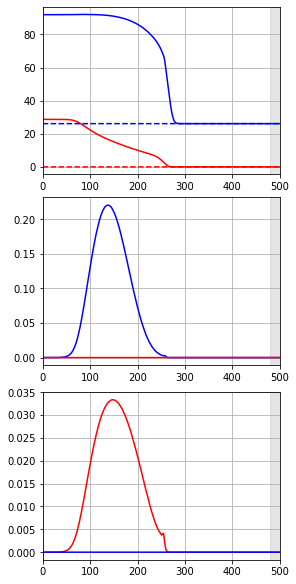

-------  55 0.4250000000000001 0.6250000000000003
init ind =  1950
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  1.2916089299319797
RUN  0 , total integrated cost =  1.2916089299319797
Gradient descend method:  None
RUN  0 , total integrated cost =  1.2916089299319797
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  176973.53086129532
cost splitting :  2.6448984193387706e-21 [0. 0.]


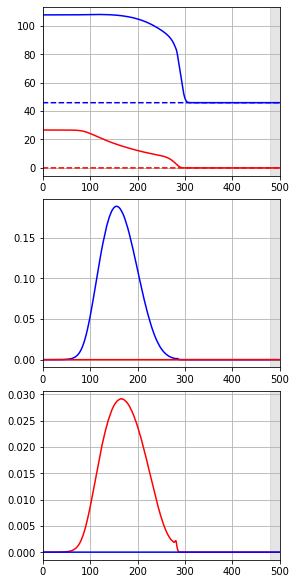

-------  62 0.4250000000000001 0.6500000000000004
init ind =  1887
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  1.2144378947340881
RUN  0 , total integrated cost =  1.2144378947340881
Gradient descend method:  None
RUN  0 , total integrated cost =  1.2144378947340881
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  172327.22420179544
cost splitting :  1.1507500556569613e-21 [0. 0.]


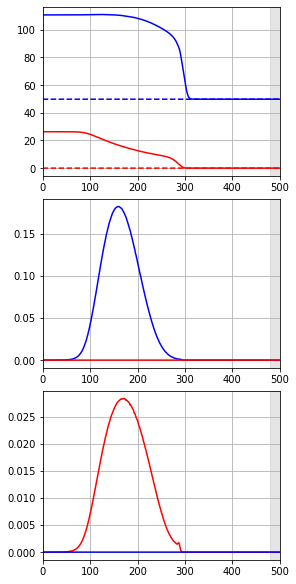

-------  69 0.4250000000000001 0.6750000000000004
init ind =  1867
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  1.141198442944816
RUN  0 , total integrated cost =  1.141198442944816
Gradient descend method:  None
RUN  0 , total integrated cost =  1.141198442944816
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  167933.86239870195
cost splitting :  3.5364166432091785e-22 [0. 0.]


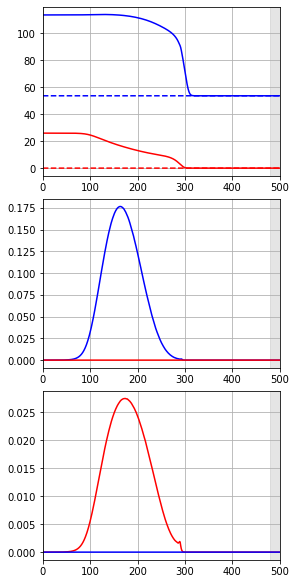

-------  76 0.4250000000000001 0.7000000000000004
init ind =  1808
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  1.0700401630225378
RUN  0 , total integrated cost =  1.0700401630225378
Gradient descend method:  None
RUN  0 , total integrated cost =  1.0700401630225378
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  163736.8297408659
cost splitting :  1.4382079475601552e-22 [0. 0.]


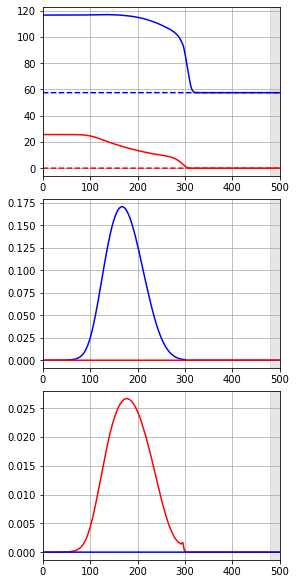

In [17]:
tol = 1.0 * 1e-7

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    max_it = int(0)
    limit = 1e-6
        
    for l in range( bestControl_[i].shape[2] ):
        if ( np.abs(bestControl_[i][0,2,l]) > limit or np.abs(bestControl_[i][0,3,l]) > limit
            or np.abs(bestControl_[i][0,4,l]) > limit or np.abs(bestControl_[i][0,5,l]) > limit ):
            init_ind = l - n_pre
            break
            
    if init_ind == -1:
        init_ind = 0
            
    print("init ind = ", init_ind)

    weight_ = 1.
    cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
    weights_[i] = cost.getParams()

    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    if init_ind != 0:
        control0[:,:,:-init_ind] = bestControl_[i][:,:,n_pre-1+init_ind:-n_post+1]
    else:
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][cost_index][0][:2])

    if True:
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

        ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
        ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
        ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

        ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
        ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

        ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
        ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

        for k in range(3):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

In [37]:
bad = [12,54,60,66,72]

In [22]:
tol = 1. * 1e-11   #5.
c_var = [2,3,4,5]
conv_shift = [None] * len(exc)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    if i in bad:
        continue
    
    aln.params.duration = dur
    max_it = int(1000)
    
    while not conv_shift[i]:
            
        weight_ = 1.
        cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i]= aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][-1] == 0.:
            conv_shift[i] = True

        print('uncontrolled cost : ', cost_uncontrolled[i])
        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])

        if False and conv_shift[i]:
            plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]

            fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

            ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
            ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
            ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
            ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

            ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
            ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

            ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
            ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

            for k in range(3):
                ax[k].set_xlim(0.,dur)
                ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()
            
        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  1 0.4250000000000001 0.3500000000000001
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  2.3626771377378133
RUN  0 , total integrated cost =  2.3626771377378133
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  2.3626771377378133
Control only changes marginally.
RUN  1 , total integrated cost =  2.3626771377378133
Improved over  1  iterations in  0.4536472909967415  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951153140642
Problem in initial value trasfer post:  sigmae_f 1.5960362260024892 1.5960363057674618
Problem in initial value trasfer post:  tau_exc 15.742571329979938 15.742570369609668
uncontrolled cost :  244234.70502182204
cost splitting :  2.4804469951582157e-10 [0. 0.]
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  0.049301635459755584
RUN  0 , total integrated cost =  0.049301635459755584
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  0.049301635459755584
Control only changes marginally.
RUN  1 , total integrated cost =  0.049301635459755584
Improved over  1  iterations in  0.4761018830467947  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.503837337451138 1.5038373231130293
Problem in initial value trasfer post:  sigmae_f 1.591263862591167 1.5912639910539759
Problem in initial value trasfer post:  tau_exc 19.154833058916687 19.1548318646076
uncontrolled cost :  137806.3558139294
cost splitting :  2.2743528265898212e-10 [0. 0.]
-------  3 0.4250000000000001 0.3750000000000001
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  2.2450898282530884
RUN  0 , total integrated cost =  2.2450898282530884
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  2.2450898282530884
Control only changes marginally.
RUN  1 , total integrated cost =  2.2450898282530884
Improved over  1  iterations in  0.5129436349961907  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5025675080425562 1.5025674957401651
Problem in initial value trasfer post:  sigmae_f 1.5880783008324748 1.5880784994264634
Problem in initial value trasfer post:  tau_exc 17.840755548887408 17.840753362415757
uncontrolled cost :  241480.3484875782
cost splitting :  1.707904352093522e-10 [0. 0.]
-------  5 0.4000000000000001 0.40000000000000013
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  0.03464565001537337
RUN  0 , total integrated cost =  0.03464565001537337
Gradient descend method:  None
RUN  1 , total integrated cost =  0.03464565001253997
RUN  2 , total integrated cost =  0.03464565000973427


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  0.03464565000970461
Control only changes marginally.
RUN  3 , total integrated cost =  0.03464565000970461
Improved over  3  iterations in  0.9663625480025075  seconds by  1.6362093901989283e-08  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5039081989608674 1.503908186490671
Problem in initial value trasfer post:  sigmae_f 1.5683653568448124 1.568365380449251
Problem in initial value trasfer post:  tau_exc 20.495245129346117 20.4952449637467
uncontrolled cost :  126823.61408372025
cost splitting :  2.4566927970958567e-09 [0. 0.]
-------  9 0.4000000000000001 0.42500000000000016
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  0.022306644073474133
RUN  0 , total integrated cost =  0.022306644073474133
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  0.022306644073474133
Control only changes marginally.
RUN  1 , total integrated cost =  0.022306644073474133
Improved over  1  iterations in  0.47377187298843637  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5040468738619945 1.5040468625717185
Problem in initial value trasfer pre:  sigmai_f 1.5035566682852224 1.5035566565968324
Problem in initial value trasfer post:  sigmae_f 1.5491535968187973 1.5491539418028255
Problem in initial value trasfer post:  tau_exc 21.15024011356025 21.150238143016118
uncontrolled cost :  115502.5972235114
cost splitting :  1.6024921032142033e-07 [0. 0.]
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  2.0236037378422354
RUN  0 , total integrated cost =  2.0236037378422354
Gradient descend method:  None
RUN  1 , total integrated cost =  2.0236037378422354
Control only changes marginally.
RUN  1 , total integr

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  0.012337979523715674
Control only changes marginally.
RUN  1 , total integrated cost =  0.012337979523715674
Improved over  1  iterations in  0.44967125297989696  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmai_f 1.5039627863732437 1.503962772693451
Problem in initial value trasfer post:  sigmae_f 1.534992272195629 1.5349924291313053
Problem in initial value trasfer post:  tau_exc 21.399724233862205 21.399723435607974
uncontrolled cost :  103932.40255255786
cost splitting :  1.3149648276960562e-06 [0. 0.]
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  1.9189066257798253
RUN  0 , total integrated cost =  1.9189066257798253
Gradient descend method:  None
RUN  1 , total integrated cost =  1.9189066257798253
Control only changes marginally.
RUN  1 , total integrated cost =  1.9189066257798253
Improved over  1  iterations in  0.524635583977215  sec

-------  0 0.4000000000000001 0.3500000000000001
-------  6 0.4250000000000001 0.40000000000000013


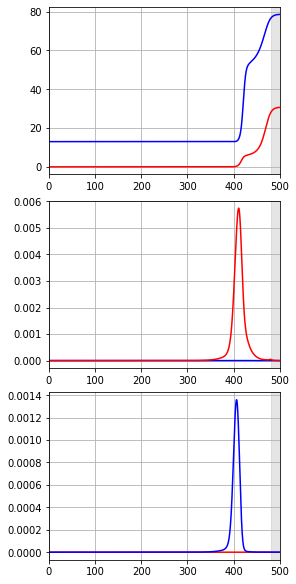

-------  12 0.47500000000000014 0.42500000000000016


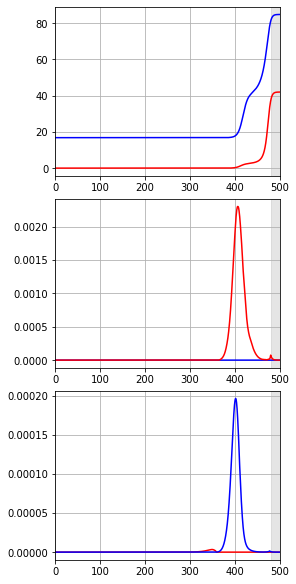

-------  18 0.4000000000000001 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002


TypeError: 'NoneType' object is not subscriptable

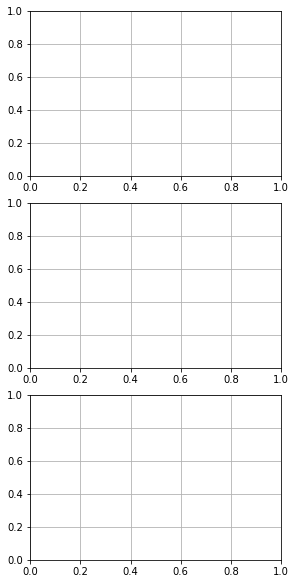

In [36]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    if i in bad:
        continue
        
    plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)


    fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

    ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
    ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')

    ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
    ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

    ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
    ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

    for k in range(3):
        ax[k].set_xlim(0.,dur)
        ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()

In [35]:
bad = [0, 18, 24]